In [1]:
import pandas as pd
import scipy as sp
from scipy.stats import rankdata

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGM
import numpy as np
import json
import networkx as nx
from scipy.stats import kendalltau, spearmanr, pearsonr
import community
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from datetime import datetime
import matplotlib
from tqdm import notebook as nb

from surprise import Dataset, Reader, SVD,accuracy
import pandas as pd
import scipy as sp
from scipy.stats import rankdata

from scipy.sparse import csr_matrix
from scipy import spatial

from sklearn.metrics import r2_score,explained_variance_score
import os
import pickle as pk
from pandas.api.types import CategoricalDtype
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from dateutil.relativedelta import relativedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, YearLocator
import pickle



## 2.1 Data Collection 

Filtering out the users who cast less than 5 recommendations

In [54]:
#Loading Data
print("Loading dataset votes_df.csv...\n")

vote = pd.read_csv('csv_files/data_CMU/votes_df.csv', index_col=False)
vote_df=vote[['vote_id','discussion_id','timestamp','user_id','label']]

vote_df= vote_df[vote_df['label'].isin(['keep','delete','merge','redirect'])]

vote_df.drop(vote_df[vote_df['timestamp']==-1].index, inplace=True)

#Filtering 
print("Filtering the Dataset...\n")
vote_df_filter = []
for n,grp in nb.tqdm(vote_df.groupby('user_id')):
    if grp['discussion_id'].count() >=5 :
        vote_df_filter.append(n)
vote_df2= vote_df[vote_df['user_id'].isin(vote_df_filter)]

print("Number of Voters: ",len(vote_df_filter),"\n")
print("Number of AfD discussions/articles: ",len(vote_df2['discussion_id'].unique()),"\n")
print("Number of recommendations:: ",len(vote_df2['vote_id'].unique()),"\n")
print("Filtered Dataset\n ",vote_df2.head(),"\n")


vote_df2.to_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index=False)
print("Saved into file: Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv \n")

Loading dataset votes_df.csv...

Filtering the Dataset...




Number of Voters:  20153 

Number of AfD discussions/articles:  355505 

Number of recommendations::  1495963 

Filtered Dataset
       vote_id  discussion_id   timestamp    user_id   label
1  400000002      100000001  1158558120  200000004    keep
2  400000003      100000001  1158562140  200000005  delete
3  400000004      100000001  1158562800  200000006  delete
7  400000008      100000001  1158737880  200000010    keep
9  400000010      100000001  1158787560  200000011    keep 

Saved into file: Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv 



## 2.2 Measurement of Preference 

Counts of all types of recommendations and Calculation of probability of 'Keep' per user:

In [55]:
user_counts=vote_df2.groupby('user_id')['label'].value_counts().unstack().fillna(0).reset_index('user_id')
# .reset_index('label')
user_counts['alignment_score']= user_counts.apply(lambda row: row['keep']/(row['keep']+row['delete']), axis=1)
user_counts=user_counts.dropna()

print("Result:\n",user_counts.head(),"\n\n")

user_counts.to_csv('Data_Wiki_Workshop/csv_files/data_vote_counts.csv', index=False)
print("Saved into file: Data_Wiki_Workshop/csv_files/data_vote_counts.csv \n")

/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Result:
 label    user_id  delete   keep  merge  redirect  alignment_score
0      200000001   378.0  184.0    7.0      17.0         0.327402
1      200000002    10.0    5.0    0.0       0.0         0.333333
2      200000004    11.0  604.0    2.0       2.0         0.982114
3      200000005    40.0    2.0    2.0       0.0         0.047619
4      200000006    42.0    3.0    0.0       0.0         0.066667 


Saved into file: Data_Wiki_Workshop/csv_files/data_vote_counts.csv 



Fitting Gaussian Mixture Model with variational Bayes algorithm

In [56]:
def BGM_bic(models,X):
    _, n_features = models.means_.shape
    if models.covariance_type == 'full':
        cov_params = models.n_components * n_features * (n_features + 1) / 2.
    elif models.covariance_type == 'diag':
        cov_params = models.n_components * n_features
    elif models.covariance_type == 'tied':
        cov_params = n_features * (n_features + 1) / 2.
    elif models.covariance_type == 'spherical':
        cov_params = models.n_components
    mean_params = n_features * models.n_components
    n_par=int(cov_params + mean_params + models.n_components - 1)
    print("Mean score: ",models.score(X)," Total score: ",models.score(X)*X.shape[0],"\n")
    print("number of parameter: ", n_par)
    return (-2 * models.score(X) * X.shape[0] +
                        n_par * np.log(X.shape[0]))

user_counts = pd.read_csv('Data_Wiki_Workshop/csv_files/data_vote_counts.csv', index_col=False)
user_counts.head()

data = user_counts[user_counts.columns[-1:]]
bic_list=[]

ii=1

mm=20
em_lb=[]
model_save = ''
for n in nb.tqdm(range(2,mm)):

    models = BGM(n_components = n, verbose=0,covariance_type='full',max_iter=1000,init_params='random',
                n_init=30).fit(data)
    
    
    em_lb.append(BGM_bic(models,data))
    
    if n==4:
        
        with open('Data_Wiki_Workshop/GMM_model_save.pickle', 'wb') as handle:
                 pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)


                
with open('Data_Wiki_Workshop/em_lb.pickle', 'wb') as handle:
                 pickle.dump(em_lb, handle, protocol=pickle.HIGHEST_PROTOCOL)                

Mean score:  -0.10147860773567119  Total score:  -2044.4895100505676 

number of parameter:  5
Mean score:  -0.009414449275550293  Total score:  -189.67290955451176 

number of parameter:  8
Mean score:  0.012119709196407386  Total score:  244.1757811800196 

number of parameter:  11
Mean score:  0.05400360000156395  Total score:  1088.0105292315088 

number of parameter:  14
Mean score:  0.06110266695680872  Total score:  1231.0354311788253 

number of parameter:  17
Mean score:  0.0610495178189341  Total score:  1229.9646354980653 

number of parameter:  20
Mean score:  0.06102315632154048  Total score:  1229.433530410076 

number of parameter:  23
Mean score:  0.060979106803256626  Total score:  1228.5460647652112 

number of parameter:  26


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.060985367653232835  Total score:  1228.6722021096818 

number of parameter:  29
Mean score:  0.060966953725515284  Total score:  1228.3012167079564 

number of parameter:  32


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.06068008506431603  Total score:  1222.5216737907751 

number of parameter:  35


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.060917324778064295  Total score:  1227.3013423036614 

number of parameter:  38


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.06108167417076763  Total score:  1230.6124895184555 

number of parameter:  41


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.060995818667669385  Total score:  1228.882758697535 

number of parameter:  44


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.06086483875727744  Total score:  1226.2439064428686 

number of parameter:  47


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.06065633115400927  Total score:  1222.0431037598248 

number of parameter:  50


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Mean score:  0.060695458800684485  Total score:  1222.8314084573904 

number of parameter:  53
Mean score:  0.06088511001230413  Total score:  1226.6523114178913 

number of parameter:  56



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 30 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


## 2.3 Signed Network Analysis

In [65]:
data = pd.read_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index_col=False)

In [66]:
voters = pd.read_csv('Data_Wiki_Workshop/csv_files/data_vote_counts.csv', index_col=False)

In [67]:
data = data[data['user_id'].isin(voters['user_id'])]
len(data['user_id'].unique())

20147

In [68]:
user_list= data.groupby('user_id')
article_list = data.groupby('discussion_id')

user = {}
for name,group in user_list:
    user[name]=list(zip(list(group["discussion_id"]),list(group["label"])))
    
    
article = {}
for name,group in article_list:
    article[name]=list(zip(list(group["user_id"]),list(group["label"])))
        
    

In [69]:
mp = {}
mp1 = {}
res = {}
for u in user.keys():
    art = user[u]
    #print(art)
    temp = {}
    for a,d1 in art:
        userlist = article[a]
        for u2,d2 in userlist:
            if u==u2:
                continue
            if (str(u)+","+str(u2) not in mp1) and (str(u2)+"<->"+str(u) not in mp1):
                mp1[str(u)+","+str(u2)]=0
            if (str(u)+","+str(u2)+","+str(a) not in mp) and (str(u2)+","+str(u)+","+str(a) not in mp):
                mp1[str(u)+","+str(u2)] +=1 if d1==d2 else -1
                mp[str(u)+","+str(u2)+","+str(a)]=1
                temp[str(u2)] = mp1[str(u)+","+str(u2)]
    if len(temp.keys())!=0:
        res[str(u)]=temp 
                

In [21]:
voters

user_id  delete   keep  merge  redirect  alignment_score
0      200000001   378.0  184.0    7.0      17.0         0.327402
1      200000002    10.0    5.0    0.0       0.0         0.333333
2      200000004    11.0  604.0    2.0       2.0         0.982114
3      200000005    40.0    2.0    2.0       0.0         0.047619
4      200000006    42.0    3.0    0.0       0.0         0.066667
...          ...     ...    ...    ...       ...              ...
20142  200176413     6.0    0.0    0.0       0.0         0.000000
20143  200176602     5.0    0.0    0.0       0.0         0.000000
20144  200177056     0.0    5.0    0.0       0.0         1.000000
20145  200177240     0.0    6.0    0.0       0.0         1.000000
20146  200177974     2.0    3.0    1.0       0.0         0.600000

[20147 rows x 6 columns]

In [82]:
AAM=voters[voters.columns[-1:]]
model =GMM(n_components = 2).fit(AAM)
gmm_classes = model.predict(AAM)

In [83]:
model.means_

array([[0.74043418],
       [0.22953259]])

In [84]:
gmm_class_map = {}
ind = 0
for j in list(voters['user_id']):
    gmm_class_map[int(j)]=gmm_classes[ind]

        
    ind +=1

In [85]:
edges = []
edge_only = []
for u in list(res.keys()):
    for v in list(res[u].keys()):
        if u!=v:
            edges.append((u,v,res[u][v]))
            edge_only.append((u,v))

In [86]:
G.clear()
G = nx.Graph()
G.add_edges_from(edge_only)
for u,v,w in edges:
#     print(u,v,w)
    G.edges[u,v]["sign"] = 1 if w > 0 else (0.0001 if w==0 else -1)
    G.edges[u,v]["weight"]= w if w > 0 else (0.0001 if w==0 else w) 
# nx.set_edge_attributes(G, attr)
# plt.plot()

In [87]:
for node in G.nodes:
    
#     if int(node) in gmm_class_map.keys():
#         print(node)
        G.nodes[node]['class']=gmm_class_map[int(node)]
#     G.nodes[node]['ratio']= my_class[node]
    

In [88]:
gmm_class_map[200047115]

0

In [89]:
nodes = pd.read_csv('Data_Wiki_Workshop/csv_files/node_list_CMU.csv')

In [90]:
partition={}
for i,r in nodes.iterrows():
    partition[str(int(r['Id']))]=r['modularity_class']

In [94]:
k_list=[]

corr_list_tau_mod_sign=[]
corr_list_spe_mod_sign=[]
corr_list_pea_mod_sign=[]


corr_list_tau_gau_sign=[]
corr_list_spe_gau_sign=[]
corr_list_pea_gau_sign=[]

corr_list_tau_mod_weight=[]
corr_list_spe_mod_weight=[]
corr_list_pea_mod_weight=[]


corr_list_tau_gau_weight=[]
corr_list_spe_gau_weight=[]
corr_list_pea_gau_weight=[]

In [95]:
g_k_core=G

In [96]:
for kcore in nb.tqdm(range(1,350)):
    print(kcore)
    
    g_k_core=nx.k_core(g_k_core,k=kcore)

    print(len(g_k_core.edges()))
    if len(g_k_core.edges()) == 0:
        break

    k_list.append(kcore)

    sign=[]
    weight=[]
    comm_match_mod=[]
    comm_match_gau=[]
    for u,v in nb.tqdm(g_k_core.edges()):
        sign.append(g_k_core.edges[u,v]['sign'])
        weight.append(g_k_core.edges[u,v]['weight'])
        match_mod = -1 if partition[u]!=partition[v] else 1
        match_gau = -1 if g_k_core.nodes[u]['class']!= g_k_core.nodes[v]['class'] else 1
        comm_match_mod.append(match_mod)
        comm_match_gau.append(match_gau)


    corr,pvalue=kendalltau(sign,comm_match_mod)
    
    print("Tau mod sign: ",corr,pvalue)
    corr_list_tau_mod_sign.append(corr)

    
    corr,pvalue=spearmanr(sign,comm_match_mod)
    
    print("Spear mod sign: ",corr,pvalue)
    corr_list_spe_mod_sign.append(corr)

    
    corr,pvalue=pearsonr(sign,comm_match_mod)
    
    print("Pearson mod sign: ",corr,pvalue)
    corr_list_pea_mod_sign.append(corr)

    corr,pvalue=kendalltau(sign,comm_match_gau)
    
    print("Tau gau sign: ",corr,pvalue)
    corr_list_tau_gau_sign.append(corr)

    
    corr,pvalue=spearmanr(sign,comm_match_gau)
    
    print("Spear gau sign: ",corr,pvalue)
    corr_list_spe_gau_sign.append(corr)

    
    corr,pvalue=pearsonr(sign,comm_match_gau)
    
    print("Pearson gau sign: ",corr,pvalue)
    corr_list_pea_gau_sign.append(corr)
    
    
    corr,pvalue=kendalltau(weight,comm_match_mod)
    print("\n")
    print("Tau mod weight: ",corr,pvalue)
    corr_list_tau_mod_weight.append(corr)

    
    corr,pvalue=spearmanr(weight,comm_match_mod)
    
    print("Spear mod weight: ",corr,pvalue)
    corr_list_spe_mod_weight.append(corr)

    
    corr,pvalue=pearsonr(weight,comm_match_mod)
    
    print("Pearson mod weight: ",corr,pvalue)
    corr_list_pea_mod_weight.append(corr)

    corr,pvalue=kendalltau(weight,comm_match_gau)
    
    print("Tau gau weight: ",corr,pvalue)
    corr_list_tau_gau_weight.append(corr)

    
    corr,pvalue=spearmanr(weight,comm_match_gau)
    
    print("Spear gau weight: ",corr,pvalue)
    corr_list_spe_gau_weight.append(corr)

    
    corr,pvalue=pearsonr(weight,comm_match_gau)
    
    print("Pearson gau weight: ",corr,pvalue)
    corr_list_pea_gau_weight.append(corr)
    print("\n")

1
2370787



Tau mod sign:  0.02107883650955964 5.5741019406501556e-242
Spear mod sign:  0.02157500283802115 4.903276929905189e-242
Pearson mod sign:  0.022502550962538736 4.1163224204247256e-263
Tau gau sign:  0.2097117171129058 0.0
Spear gau sign:  0.21464803760991352 0.0
Pearson gau sign:  0.21560947994112592 0.0


Tau mod weight:  0.03238221735228966 0.0
Spear mod weight:  0.035169679682777226 0.0
Pearson mod weight:  0.02640072496696584 0.0
Tau gau weight:  0.21539674756744331 0.0
Spear gau weight:  0.23393810665418324 0.0
Pearson gau weight:  0.1188121941123131 0.0


2
2370786



Tau mod sign:  0.02107858046939748 5.650653287663085e-242
Spear mod sign:  0.02157474096037305 4.9706468191426494e-242
Pearson mod sign:  0.022502291469111625 4.174838538032348e-263
Tau gau sign:  0.20971150608349595 0.0
Spear gau sign:  0.21464782349693376 0.0
Pearson gau sign:  0.21560926716924025 0.0


Tau mod weight:  0.03238207098262596 0.0
Spear mod weight:  0.035169521703633536 0.0
Pearson mod weight:  0.026400694660637394 0.0
Tau gau weight:  0.21539663389930808 0.0
Spear gau weight:  0.2339379897868725 0.0
Pearson gau weight:  0.11881217622193298 0.0


3
2370784



Tau mod sign:  0.02107875294445513 5.6023148343477034e-242
Spear mod sign:  0.021574917873940044 4.928105259556431e-242
Pearson mod sign:  0.022502464522738377 4.1385195493458225e-263
Tau gau sign:  0.2097110840238229 0.0
Spear gau sign:  0.2146473952700846 0.0
Pearson gau sign:  0.215608841624405 0.0


Tau mod weight:  0.032382839517055055 0.0
Spear mod weight:  0.03517035390258988 0.0
Pearson mod weight:  0.0264015370873183 0.0
Tau gau weight:  0.21539615004401078 0.0
Spear gau weight:  0.23393744771249467 0.0
Pearson gau weight:  0.11881169257570158 0.0


4
2370760



Tau mod sign:  0.021079860595503905 5.3158045937274516e-242
Spear mod sign:  0.021576052448074073 4.675954857279259e-242
Pearson mod sign:  0.022503637113474625 3.910950542680096e-263
Tau gau sign:  0.2097062497362536 0.0
Spear gau sign:  0.21464245565093382 0.0
Pearson gau sign:  0.2156038011025989 0.0


Tau mod weight:  0.03238358191087285 0.0
Spear mod weight:  0.035171145641276436 0.0
Pearson mod weight:  0.026402701702341394 0.0
Tau gau weight:  0.21539093469543205 0.0
Spear gau weight:  0.23393168658221106 0.0
Pearson gau weight:  0.1188080095311697 0.0


5
2370740



Tau mod sign:  0.021082372984879236 4.681003260454146e-242
Spear mod sign:  0.02157862725472269 4.117315010215454e-242
Pearson mod sign:  0.02250631369142655 3.407076011082623e-263
Tau gau sign:  0.20970344516148315 0.0
Spear gau sign:  0.21463961767569106 0.0
Pearson gau sign:  0.21560093978748257 0.0


Tau mod weight:  0.032384843475999674 0.0
Spear mod weight:  0.03517251230203183 0.0
Pearson mod weight:  0.026402973951284877 0.0
Tau gau weight:  0.21538955676196558 0.0
Spear gau weight:  0.23393016676315975 0.0
Pearson gau weight:  0.11880716934782949 0.0


6
2370670



Tau mod sign:  0.021089097065640754 3.3438807106365037e-242
Spear mod sign:  0.021585514407898014 2.940737953383727e-242
Pearson mod sign:  0.022513384737214044 2.3768179076645518e-263
Tau gau sign:  0.20968914068593902 0.0
Spear gau sign:  0.2146250241709236 0.0
Pearson gau sign:  0.21558606435650196 0.0


Tau mod weight:  0.03239245468454468 0.0
Spear mod weight:  0.03518078146097885 0.0
Pearson mod weight:  0.026406720533436765 0.0
Tau gau weight:  0.2153779373153958 0.0
Spear gau weight:  0.23391756561828592 0.0
Pearson gau weight:  0.11880232203853974 0.0


7
2370550



Tau mod sign:  0.021091835406990826 2.9776337750106144e-242
Spear mod sign:  0.021588325554981885 2.6184878410597824e-242
Pearson mod sign:  0.022516503580022957 2.074090505591944e-263
Tau gau sign:  0.20967042958635898 0.0
Spear gau sign:  0.21460595561365559 0.0
Pearson gau sign:  0.215567082157785 0.0


Tau mod weight:  0.032395179312508154 0.0
Spear mod weight:  0.035183741072387156 0.0
Pearson mod weight:  0.026409514597216282 0.0
Tau gau weight:  0.21536045634565476 0.0
Spear gau weight:  0.2338985828786845 0.0
Pearson gau weight:  0.11879256158739357 0.0


8
2370361



Tau mod sign:  0.021090776986729298 3.2885419285131455e-242
Spear mod sign:  0.021587247139660575 2.8919999799591888e-242
Pearson mod sign:  0.022515837635874603 2.2548319870432492e-263
Tau gau sign:  0.20966205995606146 0.0
Spear gau sign:  0.21459743787199825 0.0
Pearson gau sign:  0.21555809780485075 0.0


Tau mod weight:  0.03240008036784945 0.0
Spear mod weight:  0.035189096600451455 0.0
Pearson mod weight:  0.02641466962450539 0.0
Tau gau weight:  0.21535705614830936 0.0
Spear gau weight:  0.23389510662793064 0.0
Pearson gau weight:  0.11878993906690344 0.0


9
2370066



Tau mod sign:  0.021077886359873965 6.910258375410583e-242
Spear mod sign:  0.021574086097131826 6.079001348486559e-242
Pearson mod sign:  0.022503395275955355 4.723793879230612e-263
Tau gau sign:  0.2096526817725421 0.0
Spear gau sign:  0.2145881674201432 0.0
Pearson gau sign:  0.21554886858457398 0.0


Tau mod weight:  0.032388654499136235 0.0
Spear mod weight:  0.03517671022293539 0.0
Pearson mod weight:  0.026413027881027264 0.0
Tau gau weight:  0.2153479023787128 0.0
Spear gau weight:  0.23388531806083376 0.0
Pearson gau weight:  0.11878105365713651 0.0


10
2369752



Tau mod sign:  0.02105969537936714 1.923986591883143e-241
Spear mod sign:  0.02155549671631034 1.6933204734214336e-241
Pearson mod sign:  0.022485234442992805 1.348502057585567e-262
Tau gau sign:  0.2096332494608956 0.0
Spear gau sign:  0.21456857466281237 0.0
Pearson gau sign:  0.2155292739499366 0.0


Tau mod weight:  0.032380797129722125 0.0
Spear mod weight:  0.03516828931902391 0.0
Pearson mod weight:  0.026413764136408155 0.0
Tau gau weight:  0.2153339989929615 0.0
Spear gau weight:  0.233870968230605 0.0
Pearson gau weight:  0.11877547401460081 0.0


11
2369213



Tau mod sign:  0.021061977013891845 1.9290971893708288e-241
Spear mod sign:  0.021557896643396298 1.6977711106760643e-241
Pearson mod sign:  0.022488930911869924 1.2689611300468686e-262
Tau gau sign:  0.20961300830641116 0.0
Spear gau sign:  0.2145484996589121 0.0
Pearson gau sign:  0.21550851955975958 0.0


Tau mod weight:  0.03238802629326679 0.0
Spear mod weight:  0.035176325670301156 0.0
Pearson mod weight:  0.026421369889148255 0.0
Tau gau weight:  0.21531478476826632 0.0
Spear gau weight:  0.2338513289466461 0.0
Pearson gau weight:  0.11876345536141814 0.0


12
2368510



Tau mod sign:  0.021058347244786536 2.7380323841604454e-241
Spear mod sign:  0.021554243518300292 2.4100037820678375e-241
Pearson mod sign:  0.022486195521716067 1.7542666861901607e-262
Tau gau sign:  0.2095797403526779 0.0
Spear gau sign:  0.21451506652223787 0.0
Pearson gau sign:  0.21547497172120084 0.0


Tau mod weight:  0.03240104210416042 0.0
Spear mod weight:  0.035190703762563696 0.0
Pearson mod weight:  0.02643804581516411 0.0
Tau gau weight:  0.2152833127746767 0.0
Spear gau weight:  0.23381875374632424 0.0
Pearson gau weight:  0.11873757997603668 0.0


13
2367563



Tau mod sign:  0.02106335980960402 2.612173051195806e-241
Spear mod sign:  0.02155947491100519 2.2990553536845032e-241
Pearson mod sign:  0.02249260568967741 1.584009956079389e-262
Tau gau sign:  0.209534735985722 0.0
Spear gau sign:  0.21447000498982524 0.0
Pearson gau sign:  0.21543009137738006 0.0


Tau mod weight:  0.0324210793991769 0.0
Spear mod weight:  0.03521289821643047 0.0
Pearson mod weight:  0.026455268774041443 0.0
Tau gau weight:  0.21524526351967946 0.0
Spear gau weight:  0.23378029653385546 0.0
Pearson gau weight:  0.11871967350223461 0.0


14
2366290



Tau mod sign:  0.02102220279907428 2.9896155240272593e-240
Spear mod sign:  0.021517496542491295 2.6340471622465416e-240
Pearson mod sign:  0.022453327069474494 1.7705325486458844e-261
Tau gau sign:  0.20949430710374173 0.0
Spear gau sign:  0.21443009906530194 0.0
Pearson gau sign:  0.2153897287134859 0.0


Tau mod weight:  0.03241283857683549 0.0
Spear mod weight:  0.03520456676252176 0.0
Pearson mod weight:  0.026464983292243182 0.0
Tau gau weight:  0.21521294135639904 0.0
Spear gau weight:  0.23374930104254088 0.0
Pearson gau weight:  0.11870286537719239 0.0


15
2364764



Tau mod sign:  0.021023257636103052 3.9984925105140333e-240
Spear mod sign:  0.021518729967971387 3.523119766643694e-240
Pearson mod sign:  0.02245718435569563 2.1196805989737296e-261
Tau gau sign:  0.20945892294732593 0.0
Spear gau sign:  0.21439541294234363 0.0
Pearson gau sign:  0.2153552858468576 0.0


Tau mod weight:  0.032444511345522536 0.0
Spear mod weight:  0.03523963335844563 0.0
Pearson mod weight:  0.026493130356286494 0.0
Tau gau weight:  0.21518267974980923 0.0
Spear gau weight:  0.2337208490741408 0.0
Pearson gau weight:  0.11868604821005892 0.0


16
2363132



Tau mod sign:  0.021032835809909896 3.512295511709267e-240
Spear mod sign:  0.021528705380131883 3.0942695038281615e-240
Pearson mod sign:  0.02247054109539792 1.5734153724934547e-261
Tau gau sign:  0.2093951498504232 0.0
Spear gau sign:  0.2143318442601225 0.0
Pearson gau sign:  0.21529102054462554 0.0


Tau mod weight:  0.03247493434380075 0.0
Spear mod weight:  0.035273317973460096 0.0
Pearson mod weight:  0.026517063560361778 0.0
Tau gau weight:  0.21512949955621344 0.0
Spear gau weight:  0.2336673313326108 0.0
Pearson gau weight:  0.11865869053523073 0.0


17
2361007



Tau mod sign:  0.021011557634257955 1.7260588441512285e-239
Spear mod sign:  0.021507087914684916 1.5215737534992493e-239
Pearson mod sign:  0.0224515840474923 7.3667116553716515e-261
Tau gau sign:  0.20933052408712666 0.0
Spear gau sign:  0.2142673124541967 0.0
Pearson gau sign:  0.21522554388865248 0.0


Tau mod weight:  0.03248869661202462 0.0
Spear mod weight:  0.035289174972187524 0.0
Pearson mod weight:  0.026540273597155294 0.0
Tau gau weight:  0.21507052230504123 0.0
Spear gau weight:  0.23360928828931019 0.0
Pearson gau weight:  0.11863224202765668 0.0


18
2359121



Tau mod sign:  0.021004644252912565 3.786261896685068e-239
Spear mod sign:  0.02150021557900335 3.338580619979927e-239
Pearson mod sign:  0.02244688682750862 1.5209689016646786e-260
Tau gau sign:  0.20925542267604033 0.0
Spear gau sign:  0.2141924730758752 0.0
Pearson gau sign:  0.21515123904353264 0.0


Tau mod weight:  0.03251104596553428 0.0
Spear mod weight:  0.035314466454729666 0.0
Pearson mod weight:  0.026565187414478223 0.0
Tau gau weight:  0.21501192998037494 0.0
Spear gau weight:  0.23355236237887092 0.0
Pearson gau weight:  0.1186095678053495 0.0


19
2356441



Tau mod sign:  0.020990951937406455 1.4122996763476377e-238
Spear mod sign:  0.021486477711699214 1.2458903016680623e-238
Pearson mod sign:  0.022436798498818817 5.101211992772101e-260
Tau gau sign:  0.20917407794686133 0.0
Spear gau sign:  0.21411197439127636 0.0
Pearson gau sign:  0.2150714697364919 0.0


Tau mod weight:  0.03253623708033409 0.0
Spear mod weight:  0.03534323986176996 0.0
Pearson mod weight:  0.02659391998137031 0.0
Tau gau weight:  0.21495517951946735 0.0
Spear gau weight:  0.23350003414741446 0.0
Pearson gau weight:  0.11858549946039137 0.0


20
2353972



Tau mod sign:  0.02101573289795523 6.8171648169160805e-239
Spear mod sign:  0.021512118026048827 6.011094112746554e-239
Pearson mod sign:  0.022466290041651998 1.9954793403876994e-260
Tau gau sign:  0.2090951052919449 0.0
Spear gau sign:  0.21403386717705547 0.0
Pearson gau sign:  0.21499422000241694 0.0


Tau mod weight:  0.032592039924434615 0.0
Spear mod weight:  0.0354050199085271 0.0
Pearson mod weight:  0.026635910075062025 0.0
Tau gau weight:  0.2148867876301735 0.0
Spear gau weight:  0.23343340925468906 0.0
Pearson gau weight:  0.1185513665072803 0.0


21
2350933



Tau mod sign:  0.021024820626712962 8.444186750211897e-239
Spear mod sign:  0.021521791709221104 7.4452605493791555e-239
Pearson mod sign:  0.02248194542185073 1.878360558729465e-260
Tau gau sign:  0.2090021371478022 0.0
Spear gau sign:  0.21394239419869324 0.0
Pearson gau sign:  0.21490291081398324 0.0


Tau mod weight:  0.032634440248833815 0.0
Spear mod weight:  0.03545237778571078 0.0
Pearson mod weight:  0.026671019511881538 0.0
Tau gau weight:  0.2148092879800262 0.0
Spear gau weight:  0.2333577647197289 0.0
Pearson gau weight:  0.11850156807511301 0.0


22
2348058



Tau mod sign:  0.02101041865850112 3.421897640435821e-238
Spear mod sign:  0.021507297946207298 3.0185835137299025e-238
Pearson mod sign:  0.02246957291688798 7.475202015595786e-260
Tau gau sign:  0.20896527781388405 0.0
Spear gau sign:  0.21390713642618178 0.0
Pearson gau sign:  0.21486827516439816 0.0


Tau mod weight:  0.032667939103275395 0.0
Spear mod weight:  0.035489984634969864 0.0
Pearson mod weight:  0.026709532030980476 0.0
Tau gau weight:  0.21477112382238212 0.0
Spear gau weight:  0.23332429573824462 0.0
Pearson gau weight:  0.11847591088774363 0.0


23
2345092



Tau mod sign:  0.021002428662154925 1.0109886274988189e-237
Spear mod sign:  0.021499438310363203 8.92135725838484e-238
Pearson mod sign:  0.022466184618760716 1.8914298020155155e-259
Tau gau sign:  0.20891466337981196 0.0
Spear gau sign:  0.21385850130552134 0.0
Pearson gau sign:  0.21481852396102763 0.0


Tau mod weight:  0.03269813500874048 0.0
Spear mod weight:  0.03552443232322489 0.0
Pearson mod weight:  0.02674232199091038 0.0
Tau gau weight:  0.21472723003016844 0.0
Spear gau weight:  0.23328740153287758 0.0
Pearson gau weight:  0.11845479175356358 0.0


24
2341758



Tau mod sign:  0.021034890751507922 4.031597353612937e-238
Spear mod sign:  0.021532960443977442 3.5554922939267807e-238
Pearson mod sign:  0.02250403495787988 5.968765017614598e-260
Tau gau sign:  0.20881104633666892 0.0
Spear gau sign:  0.21375532937867706 0.0
Pearson gau sign:  0.2147159167568399 0.0


Tau mod weight:  0.032772590972203114 0.0
Spear mod weight:  0.03560707929424808 0.0
Pearson mod weight:  0.026795266762138094 0.0
Tau gau weight:  0.21465661026460658 0.0
Spear gau weight:  0.2332221748719609 0.0
Pearson gau weight:  0.11842856216928144 0.0


25
2338208



Tau mod sign:  0.021048741210663198 4.4114427912130996e-238
Spear mod sign:  0.02154751513805675 3.889900437804856e-238
Pearson mod sign:  0.022523249554044895 5.33127437649803e-260
Tau gau sign:  0.20872792346414304 0.0
Spear gau sign:  0.21367396964813956 0.0
Pearson gau sign:  0.21463249220198335 0.0


Tau mod weight:  0.032822136573961484 0.0
Spear mod weight:  0.03566259178599363 0.0
Pearson mod weight:  0.026837923328717716 0.0
Tau gau weight:  0.21458030406298298 0.0
Spear gau weight:  0.23315026344700004 0.0
Pearson gau weight:  0.11839042264741782 0.0


26
2334584



Tau mod sign:  0.021066750490593266 3.9704726173246804e-238
Spear mod sign:  0.021566322819487754 3.500208776451318e-238
Pearson mod sign:  0.022544884960463054 4.28060939482795e-260
Tau gau sign:  0.20872451629742586 0.0
Spear gau sign:  0.21367416397805059 0.0
Pearson gau sign:  0.214630213553422 0.0


Tau mod weight:  0.032878749784173454 0.0
Spear mod weight:  0.03572615247344747 0.0
Pearson mod weight:  0.026879758911527597 0.0
Tau gau weight:  0.21456925562505857 0.0
Spear gau weight:  0.2331516250738034 0.0
Pearson gau weight:  0.11838056229720506 0.0


27
2330659



Tau mod sign:  0.02111591249908876 7.685290955119402e-239
Spear mod sign:  0.021617063725471595 6.768423414862462e-239
Pearson mod sign:  0.02260026030865256 6.284496545790228e-261
Tau gau sign:  0.20861572539205292 0.0
Spear gau sign:  0.2135668742769291 0.0
Pearson gau sign:  0.21452041759898166 0.0


Tau mod weight:  0.032972027843254766 0.0
Spear mod weight:  0.03582946592564431 0.0
Pearson mod weight:  0.026937960982671576 0.0
Tau gau weight:  0.21447465261448928 0.0
Spear gau weight:  0.2330615603716119 0.0
Pearson gau weight:  0.11832852081465808 0.0


28
2326718



Tau mod sign:  0.021091751241210724 6.561372449415147e-238
Spear mod sign:  0.02159276025172754 5.783129381569579e-238
Pearson mod sign:  0.02257906474946482 5.252040341554138e-260
Tau gau sign:  0.20857720140032052 0.0
Spear gau sign:  0.21353170025131024 0.0
Pearson gau sign:  0.21448213730483184 0.0


Tau mod weight:  0.03299218016362404 0.0
Spear mod weight:  0.03585337600442028 0.0
Pearson mod weight:  0.02697161289117846 0.0
Tau gau weight:  0.21443521260058637 0.0
Spear gau weight:  0.23303177503963302 0.0
Pearson gau weight:  0.11829874611294626 0.0


29
2322044



Tau mod sign:  0.021031008678126357 4.290862104333213e-236
Spear mod sign:  0.021531104169066357 3.78831546247438e-236
Pearson mod sign:  0.02252342405147875 3.2019403082384428e-258
Tau gau sign:  0.20849909986889933 0.0
Spear gau sign:  0.21345699139494492 0.0
Pearson gau sign:  0.2144048215170958 0.0


Tau mod weight:  0.03299595921008161 0.0
Spear mod weight:  0.03586012570857354 0.0
Pearson mod weight:  0.02700326900449989 0.0
Tau gau weight:  0.21436505698713096 0.0
Spear gau weight:  0.2329727056013365 0.0
Pearson gau weight:  0.11826693663783883 0.0


30
2317581



Tau mod sign:  0.021044452644854588 5.95555820294324e-236
Spear mod sign:  0.02154526711313358 5.2575796577411494e-236
Pearson mod sign:  0.022541611004513084 3.8421331668592415e-258
Tau gau sign:  0.20840032841710754 0.0
Spear gau sign:  0.21335982541266946 0.0
Pearson gau sign:  0.21430444868934823 0.0


Tau mod weight:  0.03303682675684177 0.0
Spear mod weight:  0.03590667905774877 0.0
Pearson mod weight:  0.02704597369764615 0.0
Tau gau weight:  0.21428590984615278 0.0
Spear gau weight:  0.2329005581581757 0.0
Pearson gau weight:  0.11822406151334404 0.0


31
2312248



Tau mod sign:  0.0210550692201839 1.1647286849937557e-235
Spear mod sign:  0.021556658766847866 1.028249531382959e-235
Pearson mod sign:  0.0225583863087472 6.212504002549927e-258
Tau gau sign:  0.2082862004377489 0.0
Spear gau sign:  0.21324814949435783 0.0
Pearson gau sign:  0.21419428560585896 0.0


Tau mod weight:  0.03310288166018538 0.0
Spear mod weight:  0.0359813471709684 0.0
Pearson mod weight:  0.02709962214761804 0.0
Tau gau weight:  0.21419829459908238 0.0
Spear gau weight:  0.23282393601004225 0.0
Pearson gau weight:  0.1181837606896771 0.0


32
2307541



Tau mod sign:  0.0210389965393841 7.711592765397146e-235
Spear mod sign:  0.02154067401508029 6.812216454869783e-235
Pearson mod sign:  0.02254852586254632 3.444630009478641e-257
Tau gau sign:  0.208080822686893 0.0
Spear gau sign:  0.21304253565029435 0.0
Pearson gau sign:  0.21398670762057428 0.0


Tau mod weight:  0.03314269452582238 0.0
Spear mod weight:  0.03602684048135215 0.0
Pearson mod weight:  0.027151307474250343 0.0
Tau gau weight:  0.21401887300020636 0.0
Spear gau weight:  0.23264323881601848 0.0
Pearson gau weight:  0.11810138511603108 0.0


33
2302424



Tau mod sign:  0.02099480453235819 2.3245085090570246e-233
Spear mod sign:  0.021495953877816495 2.056082240192791e-233
Pearson mod sign:  0.022508014846818223 1.0388044864353105e-255
Tau gau sign:  0.20803292840445906 0.0
Spear gau sign:  0.21299870771157234 0.0
Pearson gau sign:  0.2139437730531344 0.0


Tau mod weight:  0.033177603283531844 0.0
Spear mod weight:  0.036067685971282584 0.0
Pearson mod weight:  0.027200952799238877 0.0
Tau gau weight:  0.2139796972317635 0.0
Spear gau weight:  0.23261935041028617 0.0
Pearson gau weight:  0.11808455131549497 0.0


34
2297312



Tau mod sign:  0.021048310421953098 4.90510790885989e-234
Spear mod sign:  0.021551274888323372 4.3343737878759145e-234
Pearson mod sign:  0.02257065013385081 1.4759809216645038e-256
Tau gau sign:  0.20794463531300472 0.0
Spear gau sign:  0.21291362144244164 0.0
Pearson gau sign:  0.21385608038623266 0.0


Tau mod weight:  0.033275813450751854 0.0
Spear mod weight:  0.03617709095476152 0.0
Pearson mod weight:  0.02727445847846373 0.0
Tau gau weight:  0.21389698735961238 0.0
Spear gau weight:  0.23254640425577144 0.0
Pearson gau weight:  0.11803814813238347 0.0


35
2292082



Tau mod sign:  0.021060567748678104 8.64763023837289e-234
Spear mod sign:  0.02156439061479631 7.641290275491802e-234
Pearson mod sign:  0.02258958344909884 2.0995679044466093e-256
Tau gau sign:  0.2077972772965645 0.0
Spear gau sign:  0.21276832181295285 0.0
Pearson gau sign:  0.21371057634950932 0.0


Tau mod weight:  0.03334866049484457 0.0
Spear mod weight:  0.03625889266850981 0.0
Pearson mod weight:  0.02733828478513757 0.0
Tau gau weight:  0.2137846469523199 0.0
Spear gau weight:  0.23244095723778072 0.0
Pearson gau weight:  0.11798293374227625 0.0


36
2286661



Tau mod sign:  0.02105128488554756 4.75038106685342e-233
Spear mod sign:  0.021555435606661056 4.199662929183705e-233
Pearson mod sign:  0.022584545568701993 1.0880390574806789e-255
Tau gau sign:  0.20762220797614356 0.0
Spear gau sign:  0.21259448812148488 0.0
Pearson gau sign:  0.2135347077514629 0.0


Tau mod weight:  0.033404042277846734 0.0
Spear mod weight:  0.036321928776702116 0.0
Pearson mod weight:  0.027392022297509738 0.0
Tau gau weight:  0.21366574302875033 0.0
Spear gau weight:  0.23232972332388085 0.0
Pearson gau weight:  0.11793302108919519 0.0


37
2280981



Tau mod sign:  0.021173856406667996 3.528089570475526e-235
Spear mod sign:  0.021681524839186974 3.1109809430673664e-235
Pearson mod sign:  0.02271772396358403 4.720997814460908e-258
Tau gau sign:  0.20748455288050882 0.0
Spear gau sign:  0.2124592422195554 0.0
Pearson gau sign:  0.21339980479529355 0.0


Tau mod weight:  0.03356569407891004 0.0
Spear mod weight:  0.0365001072346577 0.0
Pearson mod weight:  0.027498843797059438 0.0
Tau gau weight:  0.21353988708847024 0.0
Spear gau weight:  0.23220818134379512 0.0
Pearson gau weight:  0.11782793998108451 0.0


38
2274995



Tau mod sign:  0.021184061993522667 8.353192790282072e-235
Spear mod sign:  0.021692589143991824 7.366182399227308e-235
Pearson mod sign:  0.02273521961928962 8.958444471897835e-258
Tau gau sign:  0.20740073248052296 0.0
Spear gau sign:  0.2123794237025252 0.0
Pearson gau sign:  0.21331892387192372 0.0


Tau mod weight:  0.033638236795676915 0.0
Spear mod weight:  0.03658204257476264 0.0
Pearson mod weight:  0.02757123177099183 0.0
Tau gau weight:  0.21347979981425083 0.0
Spear gau weight:  0.23216220199330972 0.0
Pearson gau weight:  0.11778047310200955 0.0


39
2269416



Tau mod sign:  0.02117501355766903 4.767920186598359e-234
Spear mod sign:  0.021683902047888746 4.2066891277387726e-234
Pearson mod sign:  0.022730141053546732 4.93245144302221e-257
Tau gau sign:  0.20732838820591581 0.0
Spear gau sign:  0.2123110074692496 0.0
Pearson gau sign:  0.2132496333142613 0.0


Tau mod weight:  0.03369802968462985 0.0
Spear mod weight:  0.03665000481998144 0.0
Pearson mod weight:  0.0276219775349824 0.0
Tau gau weight:  0.21342592031295482 0.0
Spear gau weight:  0.23212220659139876 0.0
Pearson gau weight:  0.11773789294804834 0.0


40
2263491



Tau mod sign:  0.02126056817926246 2.5073640560534953e-235
Spear mod sign:  0.02177205510517541 2.2084247293063003e-235
Pearson mod sign:  0.02282676083244198 1.5562933793882277e-258
Tau gau sign:  0.20727125133984267 0.0
Spear gau sign:  0.21225778482681767 0.0
Pearson gau sign:  0.21319440972810072 0.0


Tau mod weight:  0.03383718937650591 0.0
Spear mod weight:  0.036804657040730875 0.0
Pearson mod weight:  0.027716775034156985 0.0
Tau gau weight:  0.2133815716895874 0.0
Spear gau weight:  0.23209479597913485 0.0
Pearson gau weight:  0.11771510955400963 0.0


41
2257456



Tau mod sign:  0.021322179010399026 4.5407399146602965e-236
Spear mod sign:  0.021835797809954614 3.994768436243646e-236
Pearson mod sign:  0.02289584863878544 2.1139271128470172e-259
Tau gau sign:  0.20718380989989732 0.0
Spear gau sign:  0.21217455215359785 0.0
Pearson gau sign:  0.21311016686439324 0.0


Tau mod weight:  0.033957167510563255 0.0
Spear mod weight:  0.03693850855945101 0.0
Pearson mod weight:  0.027794942321541973 0.0
Tau gau weight:  0.2133090421653451 0.0
Spear gau weight:  0.23203695883591632 0.0
Pearson gau weight:  0.11766925545610155 0.0


42
2251720



Tau mod sign:  0.021363326816736593 2.1736195307569527e-236
Spear mod sign:  0.021878537446138727 1.9109701758168115e-236
Pearson mod sign:  0.022942841287777405 8.39591898935538e-260
Tau gau sign:  0.20706968415740926 0.0
Spear gau sign:  0.2120634991760171 0.0
Pearson gau sign:  0.2129968817066281 0.0


Tau mod weight:  0.03404084935948285 0.0
Spear mod weight:  0.03703261030499247 0.0
Pearson mod weight:  0.027850390473206806 0.0
Tau gau weight:  0.2131986703881861 0.0
Spear gau weight:  0.23193614221111689 0.0
Pearson gau weight:  0.11760030343280975 0.0


43
2246514



Tau mod sign:  0.021411351441957674 6.526255065098568e-237
Spear mod sign:  0.0219282874304563 5.73263305822251e-237
Pearson mod sign:  0.022999113126131482 1.8067872989350924e-260
Tau gau sign:  0.20708145420693433 0.0
Spear gau sign:  0.2120810384938201 0.0
Pearson gau sign:  0.21301101411500098 0.0


Tau mod weight:  0.0341323381988037 0.0
Spear mod weight:  0.03713508184585694 0.0
Pearson mod weight:  0.027922046435191857 0.0
Tau gau weight:  0.21319554453899045 0.0
Spear gau weight:  0.23195111772052457 0.0
Pearson gau weight:  0.11757295922954131 0.0


44
2239084



Tau mod sign:  0.021409914367776603 4.030618231454469e-236
Spear mod sign:  0.021927622827726156 3.542053854154081e-236
Pearson mod sign:  0.023007182081749768 8.5218885331621e-260
Tau gau sign:  0.2070413118387062 0.0
Spear gau sign:  0.2120477325490716 0.0
Pearson gau sign:  0.21297606506403705 0.0


Tau mod weight:  0.03421771338716151 0.0
Spear mod weight:  0.03723184475822 0.0
Pearson mod weight:  0.028003603934060824 0.0
Tau gau weight:  0.21314678677437188 0.0
Spear gau weight:  0.23192222069620785 0.0
Pearson gau weight:  0.11752014986135585 0.0


45
2233411



Tau mod sign:  0.021405589139685686 1.9002482078212462e-235
Spear mod sign:  0.021923837511760923 1.670609527355642e-235
Pearson mod sign:  0.023008159533379865 3.643215089580025e-259
Tau gau sign:  0.2069104856635062 0.0
Spear gau sign:  0.21191997274936303 0.0
Pearson gau sign:  0.21284607580041906 0.0


Tau mod weight:  0.03426476163013402 0.0
Spear mod weight:  0.0372864744097085 0.0
Pearson mod weight:  0.028051183548521035 0.0
Tau gau weight:  0.2130183282679999 0.0
Spear gau weight:  0.23180381441143516 0.0
Pearson gau weight:  0.11746395710225799 0.0


46
2226752



Tau mod sign:  0.02138399047942317 2.6854152263232807e-234
Spear mod sign:  0.021902408502622574 2.3629858103080017e-234
Pearson mod sign:  0.022991587493398868 4.976361860362093e-258
Tau gau sign:  0.20695687494483275 0.0
Spear gau sign:  0.2119741879715895 0.0
Pearson gau sign:  0.21290213034293334 0.0


Tau mod weight:  0.03433345495614377 0.0
Spear mod weight:  0.03736502796243664 0.0
Pearson mod weight:  0.028114575770099782 0.0
Tau gau weight:  0.2130597911638646 0.0
Spear gau weight:  0.23187252971417474 0.0
Pearson gau weight:  0.11747125787140364 0.0


47
2220637



Tau mod sign:  0.02130718305670036 5.202108730696577e-232
Spear mod sign:  0.021824248059775012 4.5874287541313185e-232
Pearson mod sign:  0.022916449433209425 1.1621127832304418e-255
Tau gau sign:  0.20692460588904107 0.0
Spear gau sign:  0.21194608018226593 0.0
Pearson gau sign:  0.21287297115545506 0.0


Tau mod weight:  0.03433384843637378 0.0
Spear mod weight:  0.03736872637486141 0.0
Pearson mod weight:  0.028155133533798074 0.0
Tau gau weight:  0.21301387348942225 0.0
Spear gau weight:  0.2318428464908865 0.0
Pearson gau weight:  0.11743510948224632 0.0


48
2213639



Tau mod sign:  0.02139750996123212 3.013775150022863e-233
Spear mod sign:  0.021917451058181468 2.6529937457651506e-233
Pearson mod sign:  0.02301787624400184 4.183921329699673e-257
Tau gau sign:  0.20684221429069427 0.0
Spear gau sign:  0.21186830227890474 0.0
Pearson gau sign:  0.21279569045989666 0.0


Tau mod weight:  0.034491549346315695 0.0
Spear mod weight:  0.037544231614302384 0.0
Pearson mod weight:  0.028251669888381514 0.0
Tau gau weight:  0.21292934342084804 0.0
Spear gau weight:  0.2317747024526621 0.0
Pearson gau weight:  0.11738436862818777 0.0


49
2207501



Tau mod sign:  0.021446408029543475 1.129874060465511e-233
Spear mod sign:  0.021968122069289303 9.937937170357117e-234
Pearson mod sign:  0.0230736303580613 1.2445367502140422e-257
Tau gau sign:  0.20678324862249192 0.0
Spear gau sign:  0.21181354198639687 0.0
Pearson gau sign:  0.21273867022937773 0.0


Tau mod weight:  0.034605362195311865 0.0
Spear mod weight:  0.03767175518609166 0.0
Pearson mod weight:  0.028333227443659226 0.0
Tau gau weight:  0.2128809540389783 0.0
Spear gau weight:  0.23174440825313755 0.0
Pearson gau weight:  0.11735474481252381 0.0


50
2200408



Tau mod sign:  0.021479575632799654 1.158715375683197e-233
Spear mod sign:  0.022002980522320456 1.0187521895710096e-233
Pearson mod sign:  0.02311532541100966 9.8732329550646e-258
Tau gau sign:  0.20677369214771252 0.0
Spear gau sign:  0.2118122628971789 0.0
Pearson gau sign:  0.21273727051548028 0.0


Tau mod weight:  0.03469477509523646 0.0
Spear mod weight:  0.03777379665974105 0.0
Pearson mod weight:  0.02840139729833859 0.0
Tau gau weight:  0.2128600565978028 0.0
Spear gau weight:  0.23175052937611654 0.0
Pearson gau weight:  0.1173451170852183 0.0


51
2193215



Tau mod sign:  0.021549560743158124 1.9960558073094836e-234
Spear mod sign:  0.022075353368187778 1.7527095536211258e-234
Pearson mod sign:  0.023192463605363044 1.3378136436710871e-258
Tau gau sign:  0.20675587696430986 0.0
Spear gau sign:  0.21180056054672877 0.0
Pearson gau sign:  0.21272691234342478 0.0


Tau mod weight:  0.03484859697856561 0.0
Spear mod weight:  0.03794554049381422 0.0
Pearson mod weight:  0.028496182869911114 0.0
Tau gau weight:  0.21283276298444034 0.0
Spear gau weight:  0.2317468973343096 0.0
Pearson gau weight:  0.11731454827727439 0.0


52
2187096



Tau mod sign:  0.021580284167887976 1.8820837836980516e-234
Spear mod sign:  0.022107427608411123 1.6519836483666858e-234
Pearson mod sign:  0.023230068655496146 1.0272388279867578e-258
Tau gau sign:  0.2066915855360875 0.0
Spear gau sign:  0.21174045851102283 0.0
Pearson gau sign:  0.2126654984841797 0.0


Tau mod weight:  0.03495046902553376 0.0
Spear mod weight:  0.03805992822009709 0.0
Pearson mod weight:  0.02857398922315551 0.0
Tau gau weight:  0.21277283269834477 0.0
Spear gau weight:  0.23170272003415548 0.0
Pearson gau weight:  0.11726837313762203 0.0


53
2180028



Tau mod sign:  0.021571675474138224 1.563732289717834e-233
Spear mod sign:  0.022099373393136952 1.373393129764822e-233
Pearson mod sign:  0.023229370112760186 7.181463301012647e-258
Tau gau sign:  0.20666666869783723 0.0
Spear gau sign:  0.21172225981911996 0.0
Pearson gau sign:  0.212647271867484 0.0


Tau mod weight:  0.03500567374769185 0.0
Spear mod weight:  0.03812431195129783 0.0
Pearson mod weight:  0.02863089707104023 0.0
Tau gau weight:  0.212762403952023 0.0
Spear gau weight:  0.23171730155057466 0.0
Pearson gau weight:  0.1172487702467056 0.0


54
2173199



Tau mod sign:  0.02159078412809384 3.125485645871747e-233
Spear mod sign:  0.022119680346301338 2.7448576996945955e-233
Pearson mod sign:  0.02325655166357409 1.1486262181487508e-257
Tau gau sign:  0.20659386666011934 0.0
Spear gau sign:  0.21165467010908995 0.0
Pearson gau sign:  0.21257725915019202 0.0


Tau mod weight:  0.0350882352593249 0.0
Spear mod weight:  0.03821820084236887 0.0
Pearson mod weight:  0.028689192427887783 0.0
Tau gau weight:  0.21269190945620828 0.0
Spear gau weight:  0.23166460362192462 0.0
Pearson gau weight:  0.11720648605043914 0.0


55
2166775



Tau mod sign:  0.02162361300310533 2.89995056156633e-233
Spear mod sign:  0.022154004865874953 2.5457146256376967e-233
Pearson mod sign:  0.023298004390410083 8.05843937782263e-258
Tau gau sign:  0.2066241626378234 0.0
Spear gau sign:  0.21169231542519373 0.0
Pearson gau sign:  0.2126141041422048 0.0


Tau mod weight:  0.035193111885963635 0.0
Spear mod weight:  0.038336385340428776 0.0
Pearson mod weight:  0.02875749073269731 0.0
Tau gau weight:  0.2127064346112145 0.0
Spear gau weight:  0.23170431384604434 0.0
Pearson gau weight:  0.11720234857969425 0.0


56
2160181



Tau mod sign:  0.021619229020035505 1.7547595191041675e-232
Spear mod sign:  0.022150235685847657 1.541159779692432e-232
Pearson mod sign:  0.02329734364354547 4.99802912841773e-257
Tau gau sign:  0.2065117689186335 0.0
Spear gau sign:  0.21158406477908245 0.0
Pearson gau sign:  0.21250395126356048 0.0


Tau mod weight:  0.035268890678323075 0.0
Spear mod weight:  0.03842300036125257 0.0
Pearson mod weight:  0.028825776316411006 0.0
Tau gau weight:  0.21260473295077084 0.0
Spear gau weight:  0.23161805131546853 0.0
Pearson gau weight:  0.11715295900790357 0.0


57
2154077



Tau mod sign:  0.021604340764605066 1.580208482352866e-231
Spear mod sign:  0.022135594963251185 1.388841442719262e-231
Pearson mod sign:  0.023287883031370468 4.2214702459660585e-256
Tau gau sign:  0.20628672071190512 0.0
Spear gau sign:  0.21135934420443492 0.0
Pearson gau sign:  0.21227597857285618 0.0


Tau mod weight:  0.0353352977310909 0.0
Spear mod weight:  0.03849882099651302 0.0
Pearson mod weight:  0.02888660002209771 0.0
Tau gau weight:  0.21240259239929932 0.0
Spear gau weight:  0.2314187203460564 0.0
Pearson gau weight:  0.1170559141297528 0.0


58
2146046



Tau mod sign:  0.021589901093506808 2.203043350959867e-230
Spear mod sign:  0.02212159508907698 1.9378138504694798e-230
Pearson mod sign:  0.02328090722111999 5.295335517630781e-255
Tau gau sign:  0.20620333808677754 0.0
Spear gau sign:  0.21128150293118408 0.0
Pearson gau sign:  0.21219309952423496 0.0


Tau mod weight:  0.035415660834395186 0.0
Spear mod weight:  0.03859086188462642 0.0
Pearson mod weight:  0.028959867953003905 0.0
Tau gau weight:  0.21231181667609944 0.0
Spear gau weight:  0.23134669241761854 0.0
Pearson gau weight:  0.11698382167575706 0.0


59
2139844



Tau mod sign:  0.02163726409847631 9.805474759493008e-231
Spear mod sign:  0.022170682935003832 8.618341313306672e-231
Pearson mod sign:  0.023331955549019262 2.2255721517389378e-255
Tau gau sign:  0.20622600734595536 0.0
Spear gau sign:  0.21131005292581959 0.0
Pearson gau sign:  0.2122162594794863 0.0


Tau mod weight:  0.035517578201106674 0.0
Spear mod weight:  0.03870556416273026 0.0
Pearson mod weight:  0.02902743651869199 0.0
Tau gau weight:  0.21230581063701545 0.0
Spear gau weight:  0.23136195067138354 0.0
Pearson gau weight:  0.11695769516278899 0.0


60
2131884



Tau mod sign:  0.02172107760525861 1.139190589564902e-231
Spear mod sign:  0.022257403966582143 9.997250754716478e-232
Pearson mod sign:  0.023426275266742805 1.7577705155069441e-256
Tau gau sign:  0.20606549185664624 0.0
Spear gau sign:  0.21115356149344186 0.0
Pearson gau sign:  0.21206248287358292 0.0


Tau mod weight:  0.035666496549534674 0.0
Spear mod weight:  0.038872745474808394 0.0
Pearson mod weight:  0.029122843817489127 0.0
Tau gau weight:  0.21216070703056905 0.0
Spear gau weight:  0.23123294862170252 0.0
Pearson gau weight:  0.11687590135170647 0.0


61
2123906



Tau mod sign:  0.02173641713875751 3.748970921380015e-231
Spear mod sign:  0.022274026444768127 3.290332179930579e-231
Pearson mod sign:  0.023451832102301826 4.3998809529968343e-256
Tau gau sign:  0.20605902973888027 0.0
Spear gau sign:  0.2111555114298585 0.0
Pearson gau sign:  0.21206351660759057 0.0


Tau mod weight:  0.03576202720401562 0.0
Spear mod weight:  0.03898193802086205 0.0
Pearson mod weight:  0.029198449368165354 0.0
Tau gau weight:  0.2121345679236266 0.0
Spear gau weight:  0.23123455870400544 0.0
Pearson gau weight:  0.11683826944427447 0.0


62
2116834



Tau mod sign:  0.02193659587421725 1.2584930485506484e-234
Spear mod sign:  0.022479779228936087 1.0996362131163152e-234
Pearson mod sign:  0.023664705788484765 7.44978232871449e-260
Tau gau sign:  0.2060529774268485 0.0
Spear gau sign:  0.21115516138329887 0.0
Pearson gau sign:  0.21206174503490083 0.0


Tau mod weight:  0.035978999706856495 0.0
Spear mod weight:  0.0392223790468758 0.0
Pearson mod weight:  0.029314507303338774 0.0
Tau gau weight:  0.21209967720262024 0.0
Spear gau weight:  0.2312197115745788 0.0
Pearson gau weight:  0.11679947821234163 0.0


63
2109024



Tau mod sign:  0.022018577040577872 1.6096316275110305e-235
Spear mod sign:  0.022564578248582243 1.4042821234955817e-235
Pearson mod sign:  0.02376061512323733 5.456931513365249e-261
Tau gau sign:  0.20600249690315464 0.0
Spear gau sign:  0.21111080212895364 0.0
Pearson gau sign:  0.21201597715290033 0.0


Tau mod weight:  0.0361286579545353 0.0
Spear mod weight:  0.03939028510876048 0.0
Pearson mod weight:  0.02941288488800377 0.0
Tau gau weight:  0.2120572897917459 0.0
Spear gau weight:  0.23120142228364562 0.0
Pearson gau weight:  0.11676556695799685 0.0


64
2102100



Tau mod sign:  0.022054397676015577 1.5867637511643168e-235
Spear mod sign:  0.022602010757680528 1.3836991393432422e-235
Pearson mod sign:  0.023805201980476975 4.142923603440891e-261
Tau gau sign:  0.20615545477614766 0.0
Spear gau sign:  0.21127431703438967 0.0
Pearson gau sign:  0.21218142559056782 0.0


Tau mod weight:  0.036206414370345046 0.0
Spear mod weight:  0.03947929122028574 0.0
Pearson mod weight:  0.02947282905496466 0.0
Tau gau weight:  0.21215350423870602 0.0
Spear gau weight:  0.23133110866963116 0.0
Pearson gau weight:  0.11676638907257483 0.0


65
2094363



Tau mod sign:  0.022153733457920335 8.728532439986907e-237
Spear mod sign:  0.022704737604201834 7.596335791703428e-237
Pearson mod sign:  0.023918716821403375 1.2683683610789075e-262
Tau gau sign:  0.20587192683831124 0.0
Spear gau sign:  0.21099234076341047 0.0
Pearson gau sign:  0.21189714126747486 0.0


Tau mod weight:  0.03635857045327649 0.0
Spear mod weight:  0.03965023757879133 0.0
Pearson mod weight:  0.02957812863003968 0.0
Tau gau weight:  0.21194365640583088 0.0
Spear gau weight:  0.2311316486056058 0.0
Pearson gau weight:  0.1166879597537145 0.0


66
2086569



Tau mod sign:  0.022204514157242408 5.287262663852588e-237
Spear mod sign:  0.02275765237232535 4.5978606171912525e-237
Pearson mod sign:  0.023978323211922014 5.986888959369639e-263
Tau gau sign:  0.20558357665222785 0.0
Spear gau sign:  0.21070488360065573 0.0
Pearson gau sign:  0.21160611709634403 0.0


Tau mod weight:  0.036493977762165286 0.0
Spear mod weight:  0.039802558195630555 0.0
Pearson mod weight:  0.029677236542976493 0.0
Tau gau weight:  0.2117129704664926 0.0
Spear gau weight:  0.2309070795921552 0.0
Pearson gau weight:  0.1165889498313112 0.0


67
2079249



Tau mod sign:  0.02224286519921339 5.26218334028997e-237
Spear mod sign:  0.02279777658693168 4.5737891312467745e-237
Pearson mod sign:  0.024021268489998446 5.755923113912699e-263
Tau gau sign:  0.20553666759383246 0.0
Spear gau sign:  0.21066436298828692 0.0
Pearson gau sign:  0.21156174930197116 0.0


Tau mod weight:  0.0366014042828032 0.0
Spear mod weight:  0.03992425486766529 0.0
Pearson mod weight:  0.02975913654440781 0.0
Tau gau weight:  0.2116645416001767 0.0
Spear gau weight:  0.23088046130687362 0.0
Pearson gau weight:  0.11653414360813887 0.0


68
2071882



Tau mod sign:  0.0223147741034663 1.0469129210878108e-237
Spear mod sign:  0.022872339176389447 9.08737215658495e-238
Pearson mod sign:  0.024104912079282392 7.4234990824624255e-264
Tau gau sign:  0.20542760987189904 0.0
Spear gau sign:  0.21056049895012066 0.0
Pearson gau sign:  0.21145922712009607 0.0


Tau mod weight:  0.03673400530633985 0.0
Spear mod weight:  0.04007392618333981 0.0
Pearson mod weight:  0.029856763908913956 0.0
Tau gau weight:  0.21158138977598606 0.0
Spear gau weight:  0.2308187447827244 0.0
Pearson gau weight:  0.11649714031039293 0.0


69
2064135



Tau mod sign:  0.02228157575754383 3.830157986452828e-236
Spear mod sign:  0.022839062007690966 3.329129909456272e-236
Pearson mod sign:  0.024074964857195173 3.139035653030614e-262
Tau gau sign:  0.20535566086972934 0.0
Spear gau sign:  0.21049367079193754 0.0
Pearson gau sign:  0.21139448283882603 0.0


Tau mod weight:  0.03679113149036364 0.0
Spear mod weight:  0.0401412184736492 0.0
Pearson mod weight:  0.029909697668563898 0.0
Tau gau weight:  0.2115187689127275 0.0
Spear gau weight:  0.2307790157643524 0.0
Pearson gau weight:  0.11644797259482041 0.0


70
2057512



Tau mod sign:  0.022304584914694732 6.873094180064584e-236
Spear mod sign:  0.022863376534837304 5.973143228817114e-236
Pearson mod sign:  0.024108199065158282 4.119473263795902e-262
Tau gau sign:  0.20522762121051888 0.0
Spear gau sign:  0.21036914145816452 0.0
Pearson gau sign:  0.21126785509176746 0.0


Tau mod weight:  0.03690736723150413 0.0
Spear mod weight:  0.040272423418059915 0.0
Pearson mod weight:  0.02999839355751565 0.0
Tau gau weight:  0.21140967294034851 0.0
Spear gau weight:  0.23068510441080034 0.0
Pearson gau weight:  0.11639340994086038 0.0


71
2049399



Tau mod sign:  0.022433427208611544 1.1012617498079072e-237
Spear mod sign:  0.022996385027155838 9.544546468276411e-238
Pearson mod sign:  0.024252444767070856 3.3972545108288055e-264
Tau gau sign:  0.20520628854144007 0.0
Spear gau sign:  0.21035585768548754 0.0
Pearson gau sign:  0.2112519536575849 0.0


Tau mod weight:  0.03708332460275921 0.0
Spear mod weight:  0.04046978674408424 0.0
Pearson mod weight:  0.030107228785078783 0.0
Tau gau weight:  0.21135204807976288 0.0
Spear gau weight:  0.2306527908524336 0.0
Pearson gau weight:  0.11635206148284043 0.0


72
2042160



Tau mod sign:  0.02234306521504945 5.559038993494507e-235
Spear mod sign:  0.022904547974255562 4.8313507631204476e-235
Pearson mod sign:  0.024165291743863795 2.1411593203939045e-261
Tau gau sign:  0.20519996437501065 0.0
Spear gau sign:  0.21035665353459318 0.0
Pearson gau sign:  0.21125096244253028 0.0


Tau mod weight:  0.037087794266686104 0.0
Spear mod weight:  0.04047929871220365 0.0
Pearson mod weight:  0.030200586497720422 0.0
Tau gau weight:  0.21135024675907949 0.0
Spear gau weight:  0.23067723332211076 0.0
Pearson gau weight:  0.11633023389749908 0.0


73
2034102



Tau mod sign:  0.022376339942606016 8.998924271737757e-235
Spear mod sign:  0.022939559854117407 7.81858151087752e-235
Pearson mod sign:  0.02420344442352305 3.44613773791385e-261
Tau gau sign:  0.20522593347091303 0.0
Spear gau sign:  0.21039153840835062 0.0
Pearson gau sign:  0.2112872138332755 0.0


Tau mod weight:  0.037161539742923896 0.0
Spear mod weight:  0.04056490566868263 0.0
Pearson mod weight:  0.030260352142714962 0.0
Tau gau weight:  0.2113634003081407 0.0
Spear gau weight:  0.23072069819023902 0.0
Pearson gau weight:  0.1163129912191541 0.0


74
2027678



Tau mod sign:  0.022477534855381266 3.7582164888384894e-236
Spear mod sign:  0.023043872356909346 3.258339871825643e-236
Pearson mod sign:  0.024310402404453323 1.1680476594026167e-262
Tau gau sign:  0.20508369091345247 0.0
Spear gau sign:  0.2102509205880317 0.0
Pearson gau sign:  0.21114407530242374 0.0


Tau mod weight:  0.03731558708181126 0.0
Spear mod weight:  0.0407369504326852 0.0
Pearson mod weight:  0.030349186142316947 0.0
Tau gau weight:  0.21123842453746264 0.0
Spear gau weight:  0.23060629358436774 0.0
Pearson gau weight:  0.11625502233097658 0.0


75
2021172



Tau mod sign:  0.022481268499508766 1.716537113537779e-235
Spear mod sign:  0.02304837786865529 1.4887393084008835e-235
Pearson mod sign:  0.02431980621319171 5.0389907566596514e-262
Tau gau sign:  0.20502861930326194 0.0
Spear gau sign:  0.2102006428904806 0.0
Pearson gau sign:  0.21109393717557345 0.0


Tau mod weight:  0.037378125599114395 0.0
Spear mod weight:  0.0408095728252814 0.0
Pearson mod weight:  0.030406371812847686 0.0
Tau gau weight:  0.21119643945853334 0.0
Spear gau weight:  0.23058503706048153 0.0
Pearson gau weight:  0.11623046938204094 0.0


76
2013605



Tau mod sign:  0.022579313565758 1.1487258880622198e-236
Spear mod sign:  0.023149676579971 9.943114228162595e-237
Pearson mod sign:  0.024425902579486698 2.574688718180771e-263
Tau gau sign:  0.20511050533937353 0.0
Spear gau sign:  0.21029168348863128 0.0
Pearson gau sign:  0.2111835955436535 0.0


Tau mod weight:  0.03754961962728303 0.0
Spear mod weight:  0.04100192032982821 0.0
Pearson mod weight:  0.030514995430800825 0.0
Tau gau weight:  0.21122640827520725 0.0
Spear gau weight:  0.23064650054039793 0.0
Pearson gau weight:  0.11621726039356704 0.0


77
2005633



Tau mod sign:  0.022619629665139872 1.3622812359965132e-236
Spear mod sign:  0.02319197670307043 1.1785914661795294e-236
Pearson mod sign:  0.024479182851005102 2.0336119444676684e-263
Tau gau sign:  0.20514337259137885 0.0
Spear gau sign:  0.210334138461199 0.0
Pearson gau sign:  0.21122483348143078 0.0


Tau mod weight:  0.037680096548773606 0.0
Spear mod weight:  0.04114990326848715 0.0
Pearson mod weight:  0.030625478714061877 0.0
Tau gau weight:  0.21122466588726022 0.0
Spear gau weight:  0.23067548560891943 0.0
Pearson gau weight:  0.11618288099571145 0.0


78
1997939



Tau mod sign:  0.022752010026385855 1.889288783218703e-238
Spear mod sign:  0.0233284739895825 1.6298464226301762e-238
Pearson mod sign:  0.024620860058648327 1.9419619637099765e-265
Tau gau sign:  0.20512944711592823 0.0
Spear gau sign:  0.2103267784249267 0.0
Pearson gau sign:  0.21121989091159254 0.0


Tau mod weight:  0.03785835475392445 0.0
Spear mod weight:  0.04134950686339386 0.0
Pearson mod weight:  0.030721419683031565 0.0
Tau gau weight:  0.2112035446939193 0.0
Spear gau weight:  0.2306799246205747 0.0
Pearson gau weight:  0.11614815005070328 0.0


79
1989992



Tau mod sign:  0.022785628445429446 3.169943617036598e-238
Spear mod sign:  0.023363890624379005 2.7337964744370018e-238
Pearson mod sign:  0.0246675461529122 2.1863921036921233e-265
Tau gau sign:  0.20497438602762838 0.0
Spear gau sign:  0.21017630246267688 0.0
Pearson gau sign:  0.21106781156063503 0.0


Tau mod weight:  0.0379558075538893 0.0
Spear mod weight:  0.041461604767470885 0.0
Pearson mod weight:  0.03079724898518644 0.0
Tau gau weight:  0.2110753702153691 0.0
Spear gau weight:  0.2305713971068048 0.0
Pearson gau weight:  0.11608891963508994 0.0


80
1981546



Tau mod sign:  0.02281705814986895 6.818781921109831e-238
Spear mod sign:  0.023397129713860786 5.8793502601161594e-238
Pearson mod sign:  0.024708483988939618 3.854458118978732e-265
Tau gau sign:  0.20491921517897335 0.0
Spear gau sign:  0.21012881796212068 0.0
Pearson gau sign:  0.21101919500405367 0.0


Tau mod weight:  0.038078280975069594 0.0
Spear mod weight:  0.04160139101185915 0.0
Pearson mod weight:  0.030897167026580633 0.0
Tau gau weight:  0.21101120587199076 0.0
Spear gau weight:  0.2305345582462569 0.0
Pearson gau weight:  0.11604986460790634 0.0


81
1974670



Tau mod sign:  0.02295596832106812 5.821762028663917e-240
Spear mod sign:  0.02354042918455415 5.003948499664322e-240
Pearson mod sign:  0.024860022793138634 1.8750468625600242e-267
Tau gau sign:  0.20494791690503344 0.0
Spear gau sign:  0.21016590792194903 0.0
Pearson gau sign:  0.2110572581254221 0.0


Tau mod weight:  0.03825585214869424 0.0
Spear mod weight:  0.041800307694669254 0.0
Pearson mod weight:  0.030997985241628327 0.0
Tau gau weight:  0.21103323585488165 0.0
Spear gau weight:  0.23058574563308606 0.0
Pearson gau weight:  0.11603800146286772 0.0


82
1967790



Tau mod sign:  0.023181668379374604 7.83340064043963e-244
Spear mod sign:  0.023772685084131242 6.69593603835767e-244
Pearson mod sign:  0.0251007577813968 1.123847584047465e-271
Tau gau sign:  0.20493549477421139 0.0
Spear gau sign:  0.21016032582722163 0.0
Pearson gau sign:  0.21105141357304452 0.0


Tau mod weight:  0.038503701520546975 0.0
Spear mod weight:  0.04207614318925093 0.0
Pearson mod weight:  0.031113871372039255 0.0
Tau gau weight:  0.21097105533905833 0.0
Spear gau weight:  0.23054532376573195 0.0
Pearson gau weight:  0.11598643939765714 0.0


83
1961397



Tau mod sign:  0.023305122098236836 1.2315884073695212e-245
Spear mod sign:  0.02390006713361257 1.0497340034489313e-245
Pearson mod sign:  0.025233086277899268 1.2173920566735653e-273
Tau gau sign:  0.2049451768859895 0.0
Spear gau sign:  0.21017712182060644 0.0
Pearson gau sign:  0.2110650481289151 0.0


Tau mod weight:  0.03866893776753489 0.0
Spear mod weight:  0.04226163621185353 0.0
Pearson mod weight:  0.031210950823712308 0.0
Tau gau weight:  0.21093503597281013 0.0
Spear gau weight:  0.230532832533645 0.0
Pearson gau weight:  0.11594912566194064 0.0


84
1955091



Tau mod sign:  0.02335116045113811 7.957006036527767e-246
Spear mod sign:  0.02394790365251039 6.776896387189877e-246
Pearson mod sign:  0.025286069882507325 6.611032528156547e-274
Tau gau sign:  0.20491226057447295 0.0
Spear gau sign:  0.2101488310923074 0.0
Pearson gau sign:  0.2110345914685878 0.0


Tau mod weight:  0.03879200585648971 0.0
Spear mod weight:  0.04240034272931547 0.0
Pearson mod weight:  0.03129622654202908 0.0
Tau gau weight:  0.21089917195507538 0.0
Spear gau weight:  0.23051649366380988 0.0
Pearson gau weight:  0.11591237191462353 0.0


85
1947119



Tau mod sign:  0.023459385180572338 4.1748847286342714e-247
Spear mod sign:  0.024059822773484032 3.547332451981707e-247
Pearson mod sign:  0.025402215660754304 2.726304785910211e-275
Tau gau sign:  0.20517660108261965 0.0
Spear gau sign:  0.21042804921425498 0.0
Pearson gau sign:  0.21130639102533727 0.0


Tau mod weight:  0.03896190843860961 0.0
Spear mod weight:  0.04259164870670378 0.0
Pearson mod weight:  0.031385379248197925 0.0
Tau gau weight:  0.2110891899294421 0.0
Spear gau weight:  0.23075452367595176 0.0
Pearson gau weight:  0.11594075163428781 0.0


86
1939052



Tau mod sign:  0.023552092956688676 4.872200574615375e-248
Spear mod sign:  0.024155683509436563 4.1318586871036725e-248
Pearson mod sign:  0.02550063683203575 2.848809762915018e-276
Tau gau sign:  0.20523075958141584 0.0
Spear gau sign:  0.21049039182915041 0.0
Pearson gau sign:  0.2113636824206243 0.0


Tau mod weight:  0.03914104244469666 0.0
Spear mod weight:  0.042792957123980666 0.0
Pearson mod weight:  0.03150974731005282 0.0
Tau gau weight:  0.2111263568162729 0.0
Spear gau weight:  0.23082474483776047 0.0
Pearson gau weight:  0.1159256192988864 0.0


87
1931145



Tau mod sign:  0.02371482309373052 1.8954851402557945e-250
Spear mod sign:  0.024323408774171315 1.6011434377853797e-250
Pearson mod sign:  0.02567422707615406 6.947752471521642e-279
Tau gau sign:  0.20546976033673378 0.0
Spear gau sign:  0.2107426630023079 0.0
Pearson gau sign:  0.21161741257135572 0.0


Tau mod weight:  0.03933187574447558 0.0
Spear mod weight:  0.04300740590120607 0.0
Pearson mod weight:  0.031604103488570005 0.0
Tau gau weight:  0.21131838485820276 0.0
Spear gau weight:  0.23106590723074127 0.0
Pearson gau weight:  0.11598975130866924 0.0


88
1922628



Tau mod sign:  0.0235961112721329 6.60466185463184e-247
Spear mod sign:  0.024202731882085902 5.601741915554168e-247
Pearson mod sign:  0.025561003507093786 3.0739213442375856e-275
Tau gau sign:  0.2054540351630483 0.0
Spear gau sign:  0.2107359500807485 0.0
Pearson gau sign:  0.2116076151415437 0.0


Tau mod weight:  0.039313343880406706 0.0
Spear mod weight:  0.0429936202036537 0.0
Pearson mod weight:  0.03163221672985523 0.0
Tau gau weight:  0.21127630721781737 0.0
Spear gau weight:  0.23105471104635386 0.0
Pearson gau weight:  0.11594124270535762 0.0


89
1914808



Tau mod sign:  0.02373888722987771 6.911698303439447e-249
Spear mod sign:  0.024350008261951016 5.842476747296613e-249
Pearson mod sign:  0.025715451193264686 1.998640327423712e-277
Tau gau sign:  0.20549492460853133 0.0
Spear gau sign:  0.21078507444565292 0.0
Pearson gau sign:  0.2116576271085462 0.0


Tau mod weight:  0.03952466834666664 0.0
Spear mod weight:  0.04323032541397872 0.0
Pearson mod weight:  0.031753521268356635 0.0
Tau gau weight:  0.2112988503591246 0.0
Spear gau weight:  0.23110929054499935 0.0
Pearson gau weight:  0.11593458414356331 0.0


90
1907517



Tau mod sign:  0.02366169948647952 2.2627360456433308e-246
Spear mod sign:  0.024271849359291213 1.9180263822568104e-246
Pearson mod sign:  0.025644364837352055 7.300365977997542e-275
Tau gau sign:  0.20537409099955006 0.0
Spear gau sign:  0.21066994794227675 0.0
Pearson gau sign:  0.21154251348663822 0.0


Tau mod weight:  0.03956301865754792 0.0
Spear mod weight:  0.043277906084343225 0.0
Pearson mod weight:  0.031819738874445655 0.0
Tau gau weight:  0.21121585102653254 0.0
Spear gau weight:  0.2310485922061199 0.0
Pearson gau weight:  0.11590084635373721 0.0


91
1899426



Tau mod sign:  0.023665147281108866 1.997955938661631e-245
Spear mod sign:  0.024276341050521778 1.6945664934946237e-245
Pearson mod sign:  0.025657369398230396 5.552580347172242e-274
Tau gau sign:  0.20531182383608715 0.0
Spear gau sign:  0.21061436034789685 0.0
Pearson gau sign:  0.21148533881725323 0.0


Tau mod weight:  0.03968401308453232 0.0
Spear mod weight:  0.04341632130050613 0.0
Pearson mod weight:  0.03190955681473074 0.0
Tau gau weight:  0.21117625172531182 0.0
Spear gau weight:  0.23103752073694075 0.0
Pearson gau weight:  0.11587100147042023 0.0


92
1891968



Tau mod sign:  0.02371355523792357 1.7671805373024616e-245
Spear mod sign:  0.024326806335141306 1.4977525131508952e-245
Pearson mod sign:  0.02571544891056176 3.8388764435593283e-274
Tau gau sign:  0.20520336494953312 0.0
Spear gau sign:  0.21051008456392725 0.0
Pearson gau sign:  0.21137923132009023 0.0


Tau mod weight:  0.0397749553889686 0.0
Spear mod weight:  0.0435210217595815 0.0
Pearson mod weight:  0.0319776923808019 0.0
Tau gau weight:  0.2110338510943045 0.0
Spear gau weight:  0.23090934322030177 0.0
Pearson gau weight:  0.11578947095825569 0.0


93
1885253



Tau mod sign:  0.023750109045086946 2.218246922489259e-245
Spear mod sign:  0.024365148001455762 1.8791938828279406e-245
Pearson mod sign:  0.025758390626080235 4.3988735394789163e-274
Tau gau sign:  0.20515116586243304 0.0
Spear gau sign:  0.21046381342587414 0.0
Pearson gau sign:  0.21133436213859064 0.0


Tau mod weight:  0.03987189571554925 0.0
Spear mod weight:  0.04363242496568259 0.0
Pearson mod weight:  0.032046698811136975 0.0
Tau gau weight:  0.21102669354093243 0.0
Spear gau weight:  0.23092973650836593 0.0
Pearson gau weight:  0.11578855738633845 0.0


94
1876800



Tau mod sign:  0.02388487447627153 4.589869826926846e-247
Spear mod sign:  0.024504350382144106 3.8764201805491713e-247
Pearson mod sign:  0.025906926482227727 5.376225903735428e-276
Tau gau sign:  0.2049893252484718 0.0
Spear gau sign:  0.2103059095193524 0.0
Pearson gau sign:  0.21117438399929647 0.0


Tau mod weight:  0.040084713362541394 0.0
Spear mod weight:  0.043871196203621635 0.0
Pearson mod weight:  0.032183901239977886 0.0
Tau gau weight:  0.21088617075971483 0.0
Spear gau weight:  0.23080690362814613 0.0
Pearson gau weight:  0.11572141420838743 0.0


95
1869849



Tau mod sign:  0.02394449138407239 2.1633575440405257e-247
Spear mod sign:  0.02456622057957858 1.8251104006595192e-247
Pearson mod sign:  0.02597427830211399 2.10766380269792e-276
Tau gau sign:  0.20497315962511384 0.0
Spear gau sign:  0.21029537739912965 0.0
Pearson gau sign:  0.21116181351139227 0.0


Tau mod weight:  0.0402110402304859 0.0
Spear mod weight:  0.044014078368849976 0.0
Pearson mod weight:  0.03223997326059257 0.0
Tau gau weight:  0.21085329160532248 0.0
Spear gau weight:  0.23079515595347955 0.0
Pearson gau weight:  0.11565808342393322 0.0


96
1862920



Tau mod sign:  0.024007771418224123 8.588308477140083e-248
Spear mod sign:  0.024631987670890292 7.236869962105366e-248
Pearson mod sign:  0.02604990239616111 5.574328780355218e-277
Tau gau sign:  0.20497281105276136 0.0
Spear gau sign:  0.2103022253405317 0.0
Pearson gau sign:  0.21116460859321376 0.0


Tau mod weight:  0.04037553891497722 0.0
Spear mod weight:  0.04419920656538131 0.0
Pearson mod weight:  0.0323543179990681 0.0
Tau gau weight:  0.21085324793753257 0.0
Spear gau weight:  0.23082159423797802 0.0
Pearson gau weight:  0.11564338454635967 0.0


97
1855625



Tau mod sign:  0.024021209090934133 4.051412060034604e-247
Spear mod sign:  0.0246464927067886 3.4148091611632756e-247
Pearson mod sign:  0.026073936454539433 2.0741379538121777e-276
Tau gau sign:  0.20509394456538171 0.0
Spear gau sign:  0.21043263849882318 0.0
Pearson gau sign:  0.2112977917335753 0.0


Tau mod weight:  0.04047141224753763 0.0
Spear mod weight:  0.04430962258959387 0.0
Pearson mod weight:  0.03242701648955819 0.0
Tau gau weight:  0.2109834018508089 0.0
Spear gau weight:  0.2309925547321805 0.0
Pearson gau weight:  0.11567616935741848 0.0


98
1848160



Tau mod sign:  0.023955066457732065 8.293586757247195e-245
Spear mod sign:  0.02457945294524295 7.008155007270659e-245
Pearson mod sign:  0.02601710002472376 4.074381737817151e-274
Tau gau sign:  0.20501754393615768 0.0
Spear gau sign:  0.21036130636580144 0.0
Pearson gau sign:  0.21122818218884332 0.0


Tau mod weight:  0.04051407723877536 0.0
Spear mod weight:  0.044361894663898664 0.0
Pearson mod weight:  0.03249975801885012 0.0
Tau gau weight:  0.21094276691488978 0.0
Spear gau weight:  0.23097701944038135 0.0
Pearson gau weight:  0.11565252003135938 0.0


99
1841012



Tau mod sign:  0.024036995919792473 1.527201659870174e-245
Spear mod sign:  0.0246643819743947 1.2883319531590073e-245
Pearson mod sign:  0.026107173959912248 6.056101212756114e-275
Tau gau sign:  0.20505301163018677 0.0
Spear gau sign:  0.21040506978172294 0.0
Pearson gau sign:  0.21126935604333424 0.0


Tau mod weight:  0.0406187809068789 0.0
Spear mod weight:  0.04448209324547747 0.0
Pearson mod weight:  0.03257224213944646 0.0
Tau gau weight:  0.21097654458420798 0.0
Spear gau weight:  0.23104283583297008 0.0
Pearson gau weight:  0.11565906900667644 0.0


100
1833296



Tau mod sign:  0.02415017365964901 7.85929588470487e-247
Spear mod sign:  0.02478156404198192 6.613261545111917e-247
Pearson mod sign:  0.026230832209498966 2.214110649769775e-276
Tau gau sign:  0.2050819644882452 0.0
Spear gau sign:  0.21044369735992866 0.0
Pearson gau sign:  0.21130855728710005 0.0


Tau mod weight:  0.04079099036045356 0.0
Spear mod weight:  0.04467689122201864 0.0
Pearson mod weight:  0.0326724261821514 0.0
Tau gau weight:  0.2109831534023558 0.0
Spear gau weight:  0.23108219023223497 0.0
Pearson gau weight:  0.11564096840283777 0.0


101
1825301



Tau mod sign:  0.02431447688505451 4.1349175156337024e-249
Spear mod sign:  0.02495116050826848 3.4654513671374226e-249
Pearson mod sign:  0.02641120407191996 5.915962134000813e-279
Tau gau sign:  0.20487947605976967 0.0
Spear gau sign:  0.21024432136392918 0.0
Pearson gau sign:  0.21110541104750327 0.0


Tau mod weight:  0.041006299425954046 0.0
Spear mod weight:  0.04491874239612369 0.0
Pearson mod weight:  0.03279872123935042 0.0
Tau gau weight:  0.21078015298063849 0.0
Spear gau weight:  0.23089085156414507 0.0
Pearson gau weight:  0.1155403753568129 0.0


102
1817529



Tau mod sign:  0.024467470804010894 3.502931018801328e-251
Spear mod sign:  0.02510912195201174 2.9248051513834273e-251
Pearson mod sign:  0.02658288534128265 2.262100083050646e-281
Tau gau sign:  0.20467268808210418 0.0
Spear gau sign:  0.2100401601156571 0.0
Pearson gau sign:  0.2109003627208432 0.0


Tau mod weight:  0.04121278169504583 0.0
Spear mod weight:  0.04514976626263101 0.0
Pearson mod weight:  0.03290895066266182 0.0
Tau gau weight:  0.2106252645165871 0.0
Spear gau weight:  0.23074592567654534 0.0
Pearson gau weight:  0.11543996789576191 0.0


103
1807238



Tau mod sign:  0.02469161987028508 2.376954243868488e-254
Spear mod sign:  0.025340181594928353 1.9734239723074656e-254
Pearson mod sign:  0.026828669952216846 5.9697441060207254e-285
Tau gau sign:  0.20479315501630235 0.0
Spear gau sign:  0.21017234854472433 0.0
Pearson gau sign:  0.2110353838774638 0.0


Tau mod weight:  0.04155408469120176 0.0
Spear mod weight:  0.04553146635596245 0.0
Pearson mod weight:  0.03311120796719648 0.0
Tau gau weight:  0.21068145408228348 0.0
Spear gau weight:  0.23084699397563083 0.0
Pearson gau weight:  0.11542657289720525 0.0


104
1799519



Tau mod sign:  0.024726233010273022 5.3834447754906576e-254
Spear mod sign:  0.025376591209229298 4.468293055449988e-254
Pearson mod sign:  0.02687333044572501 1.1096858469177635e-284
Tau gau sign:  0.2046841642072749 0.0
Spear gau sign:  0.21006784009245458 0.0
Pearson gau sign:  0.21092643982183845 0.0


Tau mod weight:  0.041681542060292 0.0
Spear mod weight:  0.04567713873934837 0.0
Pearson mod weight:  0.03321151212909159 0.0
Tau gau weight:  0.21056854260223154 0.0
Spear gau weight:  0.23075366359219426 0.0
Pearson gau weight:  0.11535928262130922 0.0


105
1788813



Tau mod sign:  0.024830397957897446 1.2103254311811008e-254
Spear mod sign:  0.02548514741341117 1.0024877099715253e-254
Pearson mod sign:  0.026991365274638718 1.7892412716522263e-285
Tau gau sign:  0.20445030407423503 0.0
Spear gau sign:  0.20984142690276175 0.0
Pearson gau sign:  0.21069080069657684 0.0


Tau mod weight:  0.04188005585124851 0.0
Spear mod weight:  0.04590380555197864 0.0
Pearson mod weight:  0.03333516796178722 0.0
Tau gau weight:  0.21036728269625565 0.0
Spear gau weight:  0.23057893890318593 0.0
Pearson gau weight:  0.11526373320714095 0.0


106
1780630



Tau mod sign:  0.02494167516242702 9.135164545938692e-256
Spear mod sign:  0.025600337978748288 7.547168328322125e-256
Pearson mod sign:  0.02711195163102212 1.0526665613363737e-286
Tau gau sign:  0.20458107682501298 0.0
Spear gau sign:  0.20998367898986534 0.0
Pearson gau sign:  0.21083415209405004 0.0


Tau mod weight:  0.042082794013834045 0.0
Spear mod weight:  0.04613258217998309 0.0
Pearson mod weight:  0.033456772246459446 0.0
Tau gau weight:  0.2104304294679993 0.0
Spear gau weight:  0.23068095424962384 0.0
Pearson gau weight:  0.11523678116871189 0.0


107
1775226



Tau mod sign:  0.024992576320621126 4.815702965223841e-256
Spear mod sign:  0.025653324393779986 3.974587774134585e-256
Pearson mod sign:  0.027173221069626056 3.9973767793833847e-287
Tau gau sign:  0.20463538958628874 0.0
Spear gau sign:  0.21004549367618547 0.0
Pearson gau sign:  0.21089493490212302 0.0


Tau mod weight:  0.04222174425038866 0.0
Spear mod weight:  0.046289932231704294 0.0
Pearson mod weight:  0.033548343702659335 0.0
Tau gau weight:  0.210471875883778 0.0
Spear gau weight:  0.23075145388504728 0.0
Pearson gau weight:  0.1152405130253449 0.0


108
1767102



Tau mod sign:  0.02512276677617984 1.5179120636062117e-257
Spear mod sign:  0.025788136500495922 1.2488235023592317e-257
Pearson mod sign:  0.02731346176412633 9.317931689542622e-289
Tau gau sign:  0.2046900720650658 0.0
Spear gau sign:  0.21011123359689635 0.0
Pearson gau sign:  0.2109580602639668 0.0


Tau mod weight:  0.0423849360414184 0.0
Spear mod weight:  0.04647581340086766 0.0
Pearson mod weight:  0.03365100494265536 0.0
Tau gau weight:  0.21048656189301934 0.0
Spear gau weight:  0.23080214546910474 0.0
Pearson gau weight:  0.11523667947037576 0.0


109
1760847



Tau mod sign:  0.02512404881329683 1.1051445344315374e-256
Spear mod sign:  0.025790257964873515 9.09800554114652e-257
Pearson mod sign:  0.027320509652929023 6.859738440784837e-288
Tau gau sign:  0.2044111504745136 0.0
Spear gau sign:  0.2098314782306991 0.0
Pearson gau sign:  0.21067263606692993 0.0


Tau mod weight:  0.042493892082715125 0.0
Spear mod weight:  0.046600553736689074 0.0
Pearson mod weight:  0.03375145528363471 0.0
Tau gau weight:  0.21023496693330834 0.0
Spear gau weight:  0.2305523310229283 0.0
Pearson gau weight:  0.11512970380599463 0.0


110
1754314



Tau mod sign:  0.02507810557835434 7.899654816454809e-255
Spear mod sign:  0.02574395393542711 6.517073233227092e-255
Pearson mod sign:  0.02728183902130182 5.034586508765246e-286
Tau gau sign:  0.20448259594715631 0.0
Spear gau sign:  0.20991180989380004 0.0
Pearson gau sign:  0.21075585319361 0.0


Tau mod weight:  0.04254011805240078 0.0
Spear mod weight:  0.04665682484691253 0.0
Pearson mod weight:  0.033814921246126756 0.0
Tau gau weight:  0.21030925883450882 0.0
Spear gau weight:  0.23066137806761225 0.0
Pearson gau weight:  0.11516015026064391 0.0


111
1748816



Tau mod sign:  0.025062620372865385 9.60996765040502e-254
Spear mod sign:  0.025728967460938126 7.936384876318913e-254
Pearson mod sign:  0.027275969007804816 5.1686374082171386e-285
Tau gau sign:  0.2044666384673499 0.0
Spear gau sign:  0.2099028517253326 0.0
Pearson gau sign:  0.2107432386860898 0.0


Tau mod weight:  0.04260362554519674 0.0
Spear mod weight:  0.0467314521330339 0.0
Pearson mod weight:  0.033871288723063664 0.0
Tau gau weight:  0.21029597440472353 0.0
Spear gau weight:  0.23067136038078567 0.0
Pearson gau weight:  0.11514754723631364 0.0


112
1741496



Tau mod sign:  0.025093400022493283 2.543903021228797e-253
Spear mod sign:  0.02576131273921397 2.100547053222432e-253
Pearson mod sign:  0.027307937984951874 1.7234778567933892e-284
Tau gau sign:  0.20445699579474563 0.0
Spear gau sign:  0.2098990414079914 0.0
Pearson gau sign:  0.2107430574034751 0.0


Tau mod weight:  0.042733980904363714 0.0
Spear mod weight:  0.04688004285311053 0.0
Pearson mod weight:  0.03397727931573128 0.0
Tau gau weight:  0.21028881394138832 0.0
Spear gau weight:  0.23069108939708965 0.0
Pearson gau weight:  0.11512178848307247 0.0


113
1735340



Tau mod sign:  0.025353591237447015 1.1506977253713e-257
Spear mod sign:  0.026029194442957336 9.431537788315378e-258
Pearson mod sign:  0.02759008820186073 2.447538580923663e-289
Tau gau sign:  0.20452395651934283 0.0
Spear gau sign:  0.20997395527234156 0.0
Pearson gau sign:  0.21082111184047647 0.0


Tau mod weight:  0.04305366073287961 0.0
Spear mod weight:  0.047235569407170205 0.0
Pearson mod weight:  0.03414822995083642 0.0
Tau gau weight:  0.21030720322920052 0.0
Spear gau weight:  0.23073486263095605 0.0
Pearson gau weight:  0.11508380581083907 0.0


114
1730825



Tau mod sign:  0.02537037480800266 2.3924599377460958e-257
Spear mod sign:  0.02604690500306094 1.960902857996013e-257
Pearson mod sign:  0.02760877781114207 5.591914716353931e-289
Tau gau sign:  0.20459082030533926 0.0
Spear gau sign:  0.21004646960558734 0.0
Pearson gau sign:  0.21089072700209766 0.0


Tau mod weight:  0.04311564966255401 0.0
Spear mod weight:  0.04730746213584846 0.0
Pearson mod weight:  0.03419359552676743 0.0
Tau gau weight:  0.21034421896358238 0.0
Spear gau weight:  0.23079441576306942 0.0
Pearson gau weight:  0.11508659719459786 0.0


115
1722053



Tau mod sign:  0.025509146965174635 7.283585042420878e-259
Spear mod sign:  0.02619063243999503 5.94949664718298e-259
Pearson mod sign:  0.02776062115363655 1.1284489402994741e-290
Tau gau sign:  0.20454026371332998 0.0
Spear gau sign:  0.21000462592531982 0.0
Pearson gau sign:  0.2108489957291087 0.0


Tau mod weight:  0.04330083540521459 0.0
Spear mod weight:  0.047518499339025654 0.0
Pearson mod weight:  0.03431008222503645 0.0
Tau gau weight:  0.21029855935904465 0.0
Spear gau weight:  0.23078242856943526 0.0
Pearson gau weight:  0.11504937694897213 0.0


116
1713319



Tau mod sign:  0.02545689474447687 1.5429003106482255e-256
Spear mod sign:  0.026138082253476587 1.2636288837170859e-256
Pearson mod sign:  0.027714176736965742 2.9906624399393486e-288
Tau gau sign:  0.20458263461703213 0.0
Spear gau sign:  0.21005695254379336 0.0
Pearson gau sign:  0.21090134317773696 0.0


Tau mod weight:  0.04336632127604556 0.0
Spear mod weight:  0.047597724920383375 0.0
Pearson mod weight:  0.03440632589021732 0.0
Tau gau weight:  0.21033325064012517 0.0
Spear gau weight:  0.23085620156369394 0.0
Pearson gau weight:  0.11502306459256172 0.0


117
1704393



Tau mod sign:  0.025671001976559627 1.6576105563267992e-259
Spear mod sign:  0.026358910842218253 1.3497739658464798e-259
Pearson mod sign:  0.027941520961654955 1.8884406560125316e-291
Tau gau sign:  0.20456723738745874 0.0
Spear gau sign:  0.21004904975888902 0.0
Pearson gau sign:  0.2108902478448981 0.0


Tau mod weight:  0.04359512664439814 0.0
Spear mod weight:  0.047856458549252905 0.0
Pearson mod weight:  0.03455605265670088 0.0
Tau gau weight:  0.21030301894541817 0.0
Spear gau weight:  0.23085969656742253 0.0
Pearson gau weight:  0.1149884077073661 0.0


118
1697492



Tau mod sign:  0.0257192163960923 1.9008349219685725e-259
Spear mod sign:  0.02640938502147645 1.546683635746736e-259
Pearson mod sign:  0.027996295603241243 2.0713680778920437e-291
Tau gau sign:  0.20435059127345814 0.0
Spear gau sign:  0.2098342873745981 0.0
Pearson gau sign:  0.21067816582833537 0.0


Tau mod weight:  0.043700409078049805 0.0
Spear mod weight:  0.0479783240142267 0.0
Pearson mod weight:  0.03463139148694167 0.0
Tau gau weight:  0.2100982955745639 0.0
Spear gau weight:  0.23066521143794771 0.0
Pearson gau weight:  0.11490337769707576 0.0


119
1689828



Tau mod sign:  0.025818492937453415 2.759335134802297e-260
Spear mod sign:  0.0265122810155877 2.2401012254351846e-260
Pearson mod sign:  0.028104375855760495 2.4764319673083167e-292
Tau gau sign:  0.20436527262468682 0.0
Spear gau sign:  0.20985692506447556 0.0
Pearson gau sign:  0.21069547909446348 0.0


Tau mod weight:  0.04388612894469434 0.0
Spear mod weight:  0.04818885104265065 0.0
Pearson mod weight:  0.03473821902993481 0.0
Tau gau weight:  0.2101075406603679 0.0
Spear gau weight:  0.23070708725710454 0.0
Pearson gau weight:  0.11487424053293409 0.0


120
1681384



Tau mod sign:  0.0259677697748533 5.380418117008932e-262
Spear mod sign:  0.02666665804153269 4.351244690225512e-262
Pearson mod sign:  0.02826600669384779 3.251337193268236e-294
Tau gau sign:  0.2046254542101005 0.0
Spear gau sign:  0.21013267836725025 0.0
Pearson gau sign:  0.21096136841169139 0.0


Tau mod weight:  0.044126762742312566 0.0
Spear mod weight:  0.04846165990855946 0.0
Pearson mod weight:  0.034869787484566435 0.0
Tau gau weight:  0.2102880841050471 0.0
Spear gau weight:  0.23094623265779238 0.0
Pearson gau weight:  0.11493011552025713 0.0


121
1673229



Tau mod sign:  0.02618244343749929 4.758530163771731e-265
Spear mod sign:  0.026888159416446292 3.824970728191147e-265
Pearson mod sign:  0.028497420396782623 1.4073684084201576e-297
Tau gau sign:  0.20453662821875077 0.0
Spear gau sign:  0.210049664737227 0.0
Pearson gau sign:  0.21087604187536058 0.0


Tau mod weight:  0.04438962785377016 0.0
Spear mod weight:  0.04875775198817586 0.0
Pearson mod weight:  0.03500110425679662 0.0
Tau gau weight:  0.21017760249699935 0.0
Spear gau weight:  0.23085995336065268 0.0
Pearson gau weight:  0.11486671683403563 0.0


122
1665612



Tau mod sign:  0.02639860142212691 3.252945118768629e-268
Spear mod sign:  0.02711131631546887 2.59828946587976e-268
Pearson mod sign:  0.028732132076743702 4.239841774633902e-301
Tau gau sign:  0.20459005715787199 0.0
Spear gau sign:  0.21011362177534787 0.0
Pearson gau sign:  0.21093487110103504 0.0


Tau mod weight:  0.04471007151094932 0.0
Spear mod weight:  0.049116243287195153 0.0
Pearson mod weight:  0.03517608905316193 0.0
Tau gau weight:  0.2101959887779519 0.0
Spear gau weight:  0.23091077634000395 0.0
Pearson gau weight:  0.11483740867472322 0.0


123
1656837



Tau mod sign:  0.026530792965131333 1.7033738370786503e-269
Spear mod sign:  0.027248373919949012 1.3559875245246731e-269
Pearson mod sign:  0.02888232270350172 1.2137311750753348e-302
Tau gau sign:  0.20450432838724678 0.0
Spear gau sign:  0.21003557697907588 0.0
Pearson gau sign:  0.21085099923844486 0.0


Tau mod weight:  0.044886746615823744 0.0
Spear mod weight:  0.04931858845566658 0.0
Pearson mod weight:  0.03526999465144958 0.0
Tau gau weight:  0.21009816702146228 0.0
Spear gau weight:  0.23084197042181293 0.0
Pearson gau weight:  0.11477976084646013 0.0


124
1648848



Tau mod sign:  0.026753547637662575 1.0294151328753246e-272
Spear mod sign:  0.02747824301621878 8.140335950580499e-273
Pearson mod sign:  0.029112526660009127 5.563579366472581e-306
Tau gau sign:  0.2045902986693744 0.0
Spear gau sign:  0.2101322045859723 0.0
Pearson gau sign:  0.2109526592343606 0.0


Tau mod weight:  0.04514094910379171 0.0
Spear mod weight:  0.049605585976206734 0.0
Pearson mod weight:  0.03540276273496832 0.0
Tau gau weight:  0.21019321638539334 0.0
Spear gau weight:  0.2309822428200838 0.0
Pearson gau weight:  0.11480302133356389 0.0


125
1643272



Tau mod sign:  0.026809703520766594 5.9821183500481565e-273
Spear mod sign:  0.027536812053540687 4.724786062871547e-273
Pearson mod sign:  0.029177761574600464 2.5926096358288438e-306
Tau gau sign:  0.20463725235831115 0.0
Spear gau sign:  0.21018723884726662 0.0
Pearson gau sign:  0.21100924100218021 0.0


Tau mod weight:  0.04528260455920232 0.0
Spear mod weight:  0.04976646438281766 0.0
Pearson mod weight:  0.03551009375775521 0.0
Tau gau weight:  0.21023377032085508 0.0
Spear gau weight:  0.23105100831953224 0.0
Pearson gau weight:  0.11482318853576012 0.0


126
1637152



Tau mod sign:  0.026829126606905895 2.4073078351985087e-272
Spear mod sign:  0.027557413965559937 1.9016686281349616e-272
Pearson mod sign:  0.029199031892212037 1.2714334996827241e-305
Tau gau sign:  0.20461106240545643 0.0
Spear gau sign:  0.2101653114264554 0.0
Pearson gau sign:  0.21098394289675657 0.0


Tau mod weight:  0.04536762741062887 0.0
Spear mod weight:  0.04986588379823634 0.0
Pearson mod weight:  0.03558523204975729 0.0
Tau gau weight:  0.2101792051865348 0.0
Spear gau weight:  0.23101873341919307 0.0
Pearson gau weight:  0.11478890477466183 0.0


127
1630604



Tau mod sign:  0.02695409557439803 8.492792337114489e-274
Spear mod sign:  0.02768681019931835 6.685483302210538e-274
Pearson mod sign:  0.029338372722677458 2.662548915948292e-307
Tau gau sign:  0.2045859220501324 0.0
Spear gau sign:  0.21014734393962628 0.0
Pearson gau sign:  0.21096136268892246 0.0


Tau mod weight:  0.04559809635496303 0.0
Spear mod weight:  0.050125877330634665 0.0
Pearson mod weight:  0.035717288501958634 0.0
Tau gau weight:  0.2101454719382019 0.0
Spear gau weight:  0.23101241038577172 0.0
Pearson gau weight:  0.11476688549593653 0.0


128
1622611



Tau mod sign:  0.02722041598353416 7.432683010405975e-278
Spear mod sign:  0.027961460256029743 5.801883529508797e-278
Pearson mod sign:  0.0296270284378608 8.20981704715e-312
Tau gau sign:  0.2046014863396812 0.0
Spear gau sign:  0.2101715246406322 0.0
Pearson gau sign:  0.2109839271263047 0.0


Tau mod weight:  0.04593053295991912 0.0
Spear mod weight:  0.050499341240611374 0.0
Pearson mod weight:  0.03588667974536715 0.0
Tau gau weight:  0.21013878987713902 0.0
Spear gau weight:  0.23104174443512532 0.0
Pearson gau weight:  0.1147373724887855 0.0


129
1615580



Tau mod sign:  0.02721638540399341 1.3289232764856844e-276
Spear mod sign:  0.02795852014354525 1.0385688129018023e-276
Pearson mod sign:  0.02962786327334526 1.73226342415387e-310
Tau gau sign:  0.20483944233919074 0.0
Spear gau sign:  0.21042499177692212 0.0
Pearson gau sign:  0.21124767166663394 0.0


Tau mod weight:  0.04597681837379332 0.0
Spear mod weight:  0.050557269608049724 0.0
Pearson mod weight:  0.035920345292127995 0.0
Tau gau weight:  0.21034806219572585 0.0
Spear gau weight:  0.2313040368626696 0.0
Pearson gau weight:  0.11480071699268976 0.0


130
1607455



Tau mod sign:  0.027321939875703635 2.287089937983717e-277
Spear mod sign:  0.028068088105702153 1.7826923925155252e-277
Pearson mod sign:  0.029747051532277156 2.0654939338104e-311
Tau gau sign:  0.2048320556963423 0.0
Spear gau sign:  0.21042591456947582 0.0
Pearson gau sign:  0.2112445462295644 0.0


Tau mod weight:  0.0462134232329164 0.0
Spear mod weight:  0.05082467663391571 0.0
Pearson mod weight:  0.03610903142681919 0.0
Tau gau weight:  0.21033595075871378 0.0
Spear gau weight:  0.23132362707518875 0.0
Pearson gau weight:  0.11474802219911273 0.0


131
1597974



Tau mod sign:  0.027385552248922144 4.759410817662723e-277
Spear mod sign:  0.028134948187337784 3.7064308122644927e-277
Pearson mod sign:  0.029820105219683823 4.231612549776e-311
Tau gau sign:  0.20509610073748652 0.0
Spear gau sign:  0.21070848289726443 0.0
Pearson gau sign:  0.21153129374139534 0.0


Tau mod weight:  0.0464087328829339 0.0
Spear mod weight:  0.0510486957155252 0.0
Pearson mod weight:  0.03624484788754354 0.0
Tau gau weight:  0.21052799533581157 0.0
Spear gau weight:  0.23157666468953209 0.0
Pearson gau weight:  0.11479132278068033 0.0


132
1590904



Tau mod sign:  0.027376940383112752 1.1073768744382077e-275
Spear mod sign:  0.028127209554058057 8.635717346452693e-276
Pearson mod sign:  0.02982194484186914 9.0218910511319e-310
Tau gau sign:  0.2050547457189398 0.0
Spear gau sign:  0.21067430188248568 0.0
Pearson gau sign:  0.2114976985460555 0.0


Tau mod weight:  0.04649269233131087 0.0
Spear mod weight:  0.051148308527700845 0.0
Pearson mod weight:  0.036317871859599574 0.0
Tau gau weight:  0.21046490275558838 0.0
Spear gau weight:  0.23154012470784943 0.0
Pearson gau weight:  0.11475918513879418 0.0


133
1584047



Tau mod sign:  0.02739411744760607 7.270794443027442e-275
Spear mod sign:  0.028145878016927167 5.672375755872305e-275
Pearson mod sign:  0.029848880467635154 5.337101312786237e-309
Tau gau sign:  0.20504683698056309 0.0
Spear gau sign:  0.21067381610120178 0.0
Pearson gau sign:  0.2114934101468953 0.0


Tau mod weight:  0.046557555363365366 0.0
Spear mod weight:  0.051225745929615984 0.0
Pearson mod weight:  0.03634126444243701 0.0
Tau gau weight:  0.2104542920684153 0.0
Spear gau weight:  0.2315559313876005 0.0
Pearson gau weight:  0.11473043305332492 0.0


134
1577005



Tau mod sign:  0.027466957161827062 4.080892919825441e-275
Spear mod sign:  0.028221619413832406 3.178755303011994e-275
Pearson mod sign:  0.02993442225801983 2.173900460093897e-309
Tau gau sign:  0.20491878880074474 0.0
Spear gau sign:  0.21054898925299814 0.0
Pearson gau sign:  0.2113707030945025 0.0


Tau mod weight:  0.04669585954644549 0.0
Spear mod weight:  0.051384108853780065 0.0
Pearson mod weight:  0.03642681921455116 0.0
Tau gau weight:  0.21034679665288847 0.0
Spear gau weight:  0.23146554750759774 0.0
Pearson gau weight:  0.1146679115715858 0.0


135
1571247



Tau mod sign:  0.02759331135137863 1.2172770071779338e-276
Spear mod sign:  0.028352172290255565 9.446516981608061e-277
Pearson mod sign:  0.030071473855896504 4.4512896858874e-311
Tau gau sign:  0.20476899833008433 0.0
Spear gau sign:  0.210400478812686 0.0
Pearson gau sign:  0.21121757845290015 0.0


Tau mod weight:  0.04688802173571248 0.0
Spear mod weight:  0.05160142042069498 0.0
Pearson mod weight:  0.03653016417987901 0.0
Tau gau weight:  0.21020736534455858 0.0
Spear gau weight:  0.231338372427206 0.0
Pearson gau weight:  0.11459704155950798 0.0


136
1563692



Tau mod sign:  0.02767155438121392 6.852934736532882e-277
Spear mod sign:  0.028433496423903012 5.309151148210594e-277
Pearson mod sign:  0.030163054594230528 1.8098670180436e-311
Tau gau sign:  0.20478970817375525 0.0
Spear gau sign:  0.21042863565928732 0.0
Pearson gau sign:  0.21124554472472024 0.0


Tau mod weight:  0.0470497367337966 0.0
Spear mod weight:  0.05178644429139954 0.0
Pearson mod weight:  0.03664279644318914 0.0
Tau gau weight:  0.21021546181086131 0.0
Spear gau weight:  0.23137879312381235 0.0
Pearson gau weight:  0.11459951387531286 0.0


137
1556083



Tau mod sign:  0.027636579626432147 6.976975720875606e-275
Spear mod sign:  0.028398586259969518 5.418727426463048e-275
Pearson mod sign:  0.03013525467578715 2.13783423090434e-309
Tau gau sign:  0.20494013731401217 0.0
Spear gau sign:  0.21059082731336282 0.0
Pearson gau sign:  0.21140416360121103 0.0


Tau mod weight:  0.0470849471652494 0.0
Spear mod weight:  0.051832840338494654 0.0
Pearson mod weight:  0.03670238407339899 0.0
Tau gau weight:  0.21035642674495392 0.0
Spear gau weight:  0.23156808572771653 0.0
Pearson gau weight:  0.11463982870222575 0.0


138
1548551



Tau mod sign:  0.027626279838925988 2.20897018101278e-273
Spear mod sign:  0.028389145033028418 1.7182940028770968e-273
Pearson mod sign:  0.030130335110608596 8.25768815137336e-308
Tau gau sign:  0.20494646794253604 0.0
Spear gau sign:  0.2106058085399379 0.0
Pearson gau sign:  0.21141503846109816 0.0


Tau mod weight:  0.047156517590838304 0.0
Spear mod weight:  0.05191921688434851 0.0
Pearson mod weight:  0.03678894388500949 0.0
Tau gau weight:  0.21036365862468684 0.0
Spear gau weight:  0.23160990197550288 0.0
Pearson gau weight:  0.11463581274787177 0.0


139
1539588



Tau mod sign:  0.027800653129206588 2.992358324819284e-275
Spear mod sign:  0.028569548404433806 2.3161534831924386e-275
Pearson mod sign:  0.03032145108806194 6.5629159255353e-310
Tau gau sign:  0.20488238060547373 0.0
Spear gau sign:  0.21054890554978734 0.0
Pearson gau sign:  0.21135690858776143 0.0


Tau mod weight:  0.047392620066417264 0.0
Spear mod weight:  0.0521878879527238 0.0
Pearson mod weight:  0.036946625374130806 0.0
Tau gau weight:  0.2102134222249842 0.0
Spear gau weight:  0.2314831826107451 0.0
Pearson gau weight:  0.11451760918015592 0.0


140
1534171



Tau mod sign:  0.027930205132423242 7.658254779238271e-277
Spear mod sign:  0.02870323523064939 5.904509402289985e-277
Pearson mod sign:  0.030457635922453034 1.373615060224e-311
Tau gau sign:  0.20480568891561682 0.0
Spear gau sign:  0.21047413857680097 0.0
Pearson gau sign:  0.21128657139911253 0.0


Tau mod weight:  0.0475790013711702 0.0
Spear mod weight:  0.05239781946870364 0.0
Pearson mod weight:  0.0370490154174956 0.0
Tau gau weight:  0.21013320955438175 0.0
Spear gau weight:  0.23141557538619112 0.0
Pearson gau weight:  0.11442366980944037 0.0


141
1527595



Tau mod sign:  0.02795099842080735 4.352165751442493e-276
Spear mod sign:  0.028725413003296788 3.356572090293784e-276
Pearson mod sign:  0.030483519163015612 8.7096503502025e-311
Tau gau sign:  0.2049555395257324 0.0
Spear gau sign:  0.21063406864949194 0.0
Pearson gau sign:  0.2114432073205725 0.0


Tau mod weight:  0.04772544823806006 0.0
Spear mod weight:  0.05256642096100001 0.0
Pearson mod weight:  0.037159827110588434 0.0
Tau gau weight:  0.2102454325966436 0.0
Spear gau weight:  0.23157142201943984 0.0
Pearson gau weight:  0.11446027627849482 0.0


142
1521818



Tau mod sign:  0.02803766234512548 9.220380238684453e-277
Spear mod sign:  0.028815266196460045 7.095000280358353e-277
Pearson mod sign:  0.03058456829667537 1.160137866462e-311
Tau gau sign:  0.2049489199446363 0.0
Spear gau sign:  0.2106330268260902 0.0
Pearson gau sign:  0.21143876304052966 0.0


Tau mod weight:  0.04787562739774832 0.0
Spear mod weight:  0.05273701545571162 0.0
Pearson mod weight:  0.037268010634983216 0.0
Tau gau weight:  0.21023247529764988 0.0
Spear gau weight:  0.23157990613792395 0.0
Pearson gau weight:  0.1144399273126745 0.0


143
1515009



Tau mod sign:  0.02815838402836695 6.505165905185904e-278
Spear mod sign:  0.028940434583135104 4.988713158755651e-278
Pearson mod sign:  0.030714897190452502 6.55586531107e-313
Tau gau sign:  0.2051023307731801 0.0
Spear gau sign:  0.21079869429332335 0.0
Pearson gau sign:  0.21159620032561982 0.0


Tau mod weight:  0.04805411736987473 0.0
Spear mod weight:  0.05294201331445455 0.0
Pearson mod weight:  0.03738340067517077 0.0
Tau gau weight:  0.21032908613580117 0.0
Spear gau weight:  0.23172302162809696 0.0
Pearson gau weight:  0.11447516304385522 0.0


144
1507869



Tau mod sign:  0.028140682653796847 2.7237313356069073e-276
Spear mod sign:  0.02892343577022264 2.0927055813059673e-276
Pearson mod sign:  0.030700963346164838 3.6449451549587e-311
Tau gau sign:  0.2051796605235971 0.0
Spear gau sign:  0.21088687881243046 0.0
Pearson gau sign:  0.21168607567602082 0.0


Tau mod weight:  0.048084352297619384 0.0
Spear mod weight:  0.05298306738868087 0.0
Pearson mod weight:  0.03742290768232321 0.0
Tau gau weight:  0.2104128993852005 0.0
Spear gau weight:  0.23184924606181628 0.0
Pearson gau weight:  0.11451305375038158 0.0


145
1500103



Tau mod sign:  0.02834849691296642 6.078940161832209e-279
Spear mod sign:  0.029138101560798643 4.640237632361809e-279
Pearson mod sign:  0.030927081092231332 4.038840523e-314
Tau gau sign:  0.20524189906893706 0.0
Spear gau sign:  0.2109586027775069 0.0
Pearson gau sign:  0.21175486032020763 0.0


Tau mod weight:  0.04837887866249942 0.0
Spear mod weight:  0.053314858622093425 0.0
Pearson mod weight:  0.03756433253595801 0.0
Tau gau weight:  0.21040597757458826 0.0
Spear gau weight:  0.23187319048648938 0.0
Pearson gau weight:  0.11444638621681444 0.0


146
1495322



Tau mod sign:  0.02850259272418776 4.43195424329771e-281
Spear mod sign:  0.02929710755044709 3.3659394103324576e-281
Pearson mod sign:  0.031091802828804 1.8958112e-316
Tau gau sign:  0.20526261556561268 0.0
Spear gau sign:  0.21098434737162036 0.0
Pearson gau sign:  0.21177916091808408 0.0


Tau mod weight:  0.04856629098484105 0.0
Spear mod weight:  0.05352585604854216 0.0
Pearson mod weight:  0.03765601801288414 0.0
Tau gau weight:  0.21044843944926553 0.0
Spear gau weight:  0.23193932761136218 0.0
Pearson gau weight:  0.11447859148552965 0.0


147
1489197



Tau mod sign:  0.028772646964833747 3.053572792765527e-285
Spear mod sign:  0.029575507972987605 2.297293128566852e-285
Pearson mod sign:  0.031381470312018656 5.05e-321
Tau gau sign:  0.20542742371628492 0.0
Spear gau sign:  0.21115959249133412 0.0
Pearson gau sign:  0.21195037015165508 0.0


Tau mod weight:  0.04891997174192362 0.0
Spear mod weight:  0.05392210403577664 0.0
Pearson mod weight:  0.037838308611209764 0.0
Tau gau weight:  0.21055820551013213 0.0
Spear gau weight:  0.23208806258107026 0.0
Pearson gau weight:  0.11447995016803227 0.0


148
1482439



Tau mod sign:  0.02870250528069285 1.3233452450935182e-282
Spear mod sign:  0.02950445975647924 9.995907500550095e-283
Pearson mod sign:  0.03131849003883878 2.65169e-318
Tau gau sign:  0.20524482880757663 0.0
Spear gau sign:  0.21097941564885 0.0
Pearson gau sign:  0.21176036643040586 0.0


Tau mod weight:  0.048946457828280936 0.0
Spear mod weight:  0.053958360593926835 0.0
Pearson mod weight:  0.03788949196765635 0.0
Tau gau weight:  0.21040173921343647 0.0
Spear gau weight:  0.2319459551883709 0.0
Pearson gau weight:  0.11440549758213926 0.0


149
1476079



Tau mod sign:  0.028740503302475504 3.721137405278658e-282
Spear mod sign:  0.029544275140726304 2.8099035591642913e-282
Pearson mod sign:  0.031365085910941545 6.949765e-318
Tau gau sign:  0.2052033547748932 0.0
Spear gau sign:  0.21094217834199555 0.0
Pearson gau sign:  0.21172161482465124 0.0


Tau mod weight:  0.04907663113469496 0.0
Spear mod weight:  0.054108532162557524 0.0
Pearson mod weight:  0.03798324267239331 0.0
Tau gau weight:  0.21038390444917474 0.0
Spear gau weight:  0.23195488356015023 0.0
Pearson gau weight:  0.1143896224372006 0.0


150
1467149



Tau mod sign:  0.02883036705546963 3.1423013984299774e-282
Spear mod sign:  0.029637936904319123 2.368406197814207e-282
Pearson mod sign:  0.03145674770467895 8.208407e-318
Tau gau sign:  0.20556987553478842 0.0
Spear gau sign:  0.2113281106968375 0.0
Pearson gau sign:  0.21211088155403082 0.0


Tau mod weight:  0.0492129167160611 0.0
Spear mod weight:  0.05426878245328104 0.0
Pearson mod weight:  0.038045378192467165 0.0
Tau gau weight:  0.21065373977368118 0.0
Spear gau weight:  0.23229515215904867 0.0
Pearson gau weight:  0.11445650525949597 0.0


151
1462053



Tau mod sign:  0.02887624320629474 3.6983504154807584e-282
Spear mod sign:  0.02968579282000859 2.7851621708066758e-282
Pearson mod sign:  0.03150495049849126 1.110192e-317
Tau gau sign:  0.20572695343620429 0.0
Spear gau sign:  0.21149453803836282 0.0
Pearson gau sign:  0.21228007525418136 0.0


Tau mod weight:  0.049298934917759 0.0
Spear mod weight:  0.0543681971654199 0.0
Pearson mod weight:  0.038103139105791356 0.0
Tau gau weight:  0.21076569957689173 0.0
Spear gau weight:  0.2324381070183378 0.0
Pearson gau weight:  0.11446986812630765 0.0


152
1456321



Tau mod sign:  0.02886026255121728 9.089389193087955e-281
Spear mod sign:  0.029670206095459572 6.85675200057022e-281
Pearson mod sign:  0.03148994987021041 3.81617105e-316
Tau gau sign:  0.20596898341521283 0.0
Spear gau sign:  0.2117493621673196 0.0
Pearson gau sign:  0.21253566840428004 0.0


Tau mod weight:  0.049343398525582845 0.0
Spear mod weight:  0.05442430840425894 0.0
Pearson mod weight:  0.03813588016410631 0.0
Tau gau weight:  0.21095170196609464 0.0
Spear gau weight:  0.23267348478750677 0.0
Pearson gau weight:  0.11452305157522025 0.0


153
1450552



Tau mod sign:  0.028982323112960732 4.914092392811461e-282
Spear mod sign:  0.029796675440886777 3.693330992796999e-282
Pearson mod sign:  0.031621102566849676 1.635884e-317
Tau gau sign:  0.20607495300113332 0.0
Spear gau sign:  0.21186529689626044 0.0
Pearson gau sign:  0.21265219930444085 0.0


Tau mod weight:  0.049475419055590275 0.0
Spear mod weight:  0.05457589619975956 0.0
Pearson mod weight:  0.03821410899767913 0.0
Tau gau weight:  0.21102883212939894 0.0
Spear gau weight:  0.23278403411823448 0.0
Pearson gau weight:  0.11451065405842974 0.0


154
1443374



Tau mod sign:  0.028877918528110665 1.1396529676029575e-278
Spear mod sign:  0.02969054140025601 8.612179256720567e-279
Pearson mod sign:  0.03152235126207113 5.3924824045e-314
Tau gau sign:  0.2061862441927593 0.0
Spear gau sign:  0.21198831257208842 0.0
Pearson gau sign:  0.21277705053771132 0.0


Tau mod weight:  0.04942236273487455 0.0
Spear mod weight:  0.05452473402906754 0.0
Pearson mod weight:  0.03820718256386952 0.0
Tau gau weight:  0.21107126737682824 0.0
Spear gau weight:  0.23286229306027897 0.0
Pearson gau weight:  0.11449913792054872 0.0


155
1437833



Tau mod sign:  0.028947329241007836 6.030039063139004e-279
Spear mod sign:  0.02976256296740157 4.5493237811901226e-279
Pearson mod sign:  0.031595852131524126 3.0052229165e-314
Tau gau sign:  0.20620315091419716 0.0
Spear gau sign:  0.21201037968180883 0.0
Pearson gau sign:  0.21279666035037972 0.0


Tau mod weight:  0.04952083962970671 0.0
Spear mod weight:  0.05463750151835731 0.0
Pearson mod weight:  0.038247456916794584 0.0
Tau gau weight:  0.21106054359058704 0.0
Spear gau weight:  0.23286803812547366 0.0
Pearson gau weight:  0.1144315041877084 0.0


156
1430707



Tau mod sign:  0.029016488426674644 6.528460343618567e-279
Spear mod sign:  0.02983473191316551 4.9187902085928494e-279
Pearson mod sign:  0.03167696015482974 2.6755777495e-314
Tau gau sign:  0.20614727832985286 0.0
Spear gau sign:  0.21196047892362818 0.0
Pearson gau sign:  0.21274657465510077 0.0


Tau mod weight:  0.049665298597642335 0.0
Spear mod weight:  0.05480506918842429 0.0
Pearson mod weight:  0.038339976618472035 0.0
Tau gau weight:  0.21102327967156154 0.0
Spear gau weight:  0.2328616915497039 0.0
Pearson gau weight:  0.11442132576586282 0.0


157
1423536



Tau mod sign:  0.029078777901575793 1.001172750455211e-278
Spear mod sign:  0.02989974682322583 7.535338548785209e-279
Pearson mod sign:  0.03175002639275121 3.604070551e-314
Tau gau sign:  0.20583536088310245 0.0
Spear gau sign:  0.21164662416361738 0.0
Pearson gau sign:  0.21243518700526234 0.0


Tau mod weight:  0.049856507091334254 0.0
Spear mod weight:  0.055023457125570885 0.0
Pearson mod weight:  0.03848397089690886 0.0
Tau gau weight:  0.21079130084617848 0.0
Spear gau weight:  0.23263695716399355 0.0
Pearson gau weight:  0.11433261241749153 0.0


158
1415534



Tau mod sign:  0.02913944863396114 2.4207651134107713e-278
Spear mod sign:  0.029963346356286686 1.8205081640252825e-278
Pearson mod sign:  0.031822166151040505 7.914963153e-314
Tau gau sign:  0.2054888015441897 0.0
Spear gau sign:  0.21129885504528303 0.0
Pearson gau sign:  0.21207915090892973 0.0


Tau mod weight:  0.050052120273256506 0.0
Spear mod weight:  0.055247824399204885 0.0
Pearson mod weight:  0.03864464021729179 0.0
Tau gau weight:  0.21051583070657062 0.0
Spear gau weight:  0.2323686106529172 0.0
Pearson gau weight:  0.1142215857544232 0.0


159
1410797



Tau mod sign:  0.029081108505062576 2.4986905871269847e-276
Spear mod sign:  0.029903987178332238 1.885136703698746e-276
Pearson mod sign:  0.031759676336592026 1.4475129680615e-311
Tau gau sign:  0.20573909996400455 0.0
Spear gau sign:  0.21156069089780943 0.0
Pearson gau sign:  0.21234250344779426 0.0


Tau mod weight:  0.05004399404583405 0.0
Spear mod weight:  0.0552440210925664 0.0
Pearson mod weight:  0.0386724078369208 0.0
Tau gau weight:  0.21076381204484576 0.0
Spear gau weight:  0.23266409286779044 0.0
Pearson gau weight:  0.11432167667252471 0.0


160
1403490



Tau mod sign:  0.029225286413539768 1.2242172984644954e-277
Spear mod sign:  0.030053264815851535 9.197545794545924e-278
Pearson mod sign:  0.03191985281633977 4.4576473538e-313
Tau gau sign:  0.20568137247999752 0.0
Spear gau sign:  0.21150850901380486 0.0
Pearson gau sign:  0.21230068075280048 0.0


Tau mod weight:  0.050283461674174114 0.0
Spear mod weight:  0.055516496667136164 0.0
Pearson mod weight:  0.038834634877527544 0.0
Tau gau weight:  0.21070475772988095 0.0
Spear gau weight:  0.2326329491008088 0.0
Pearson gau weight:  0.11430391070317114 0.0


161
1395977



Tau mod sign:  0.029357505488214277 1.1323037313622725e-278
Spear mod sign:  0.030190522965461687 8.47554519795345e-279
Pearson mod sign:  0.03206860041804214 2.649215448e-314
Tau gau sign:  0.2057209158547189 0.0
Spear gau sign:  0.21155823464228024 0.0
Pearson gau sign:  0.21234216728050978 0.0


Tau mod weight:  0.050471300892910596 0.0
Spear mod weight:  0.05573329622570882 0.0
Pearson mod weight:  0.03894588103251904 0.0
Tau gau weight:  0.21066866617678084 0.0
Spear gau weight:  0.23263238652036958 0.0
Pearson gau weight:  0.11426048875529195 0.0


162
1388578



Tau mod sign:  0.02950742076804561 4.81605868601092e-280
Spear mod sign:  0.030345817339810545 3.588946129588957e-280
Pearson mod sign:  0.03222714747006703 9.96264116e-316
Tau gau sign:  0.20552515006673855 0.0
Spear gau sign:  0.21136475165651983 0.0
Pearson gau sign:  0.21214140972179255 0.0


Tau mod weight:  0.05067765229165453 0.0
Spear mod weight:  0.05596922578103535 0.0
Pearson mod weight:  0.03905266949592003 0.0
Tau gau weight:  0.21048578899044953 0.0
Spear gau weight:  0.2324639385405363 0.0
Pearson gau weight:  0.11417038912618493 0.0


163
1381130



Tau mod sign:  0.02966342886801042 1.66260299614159e-281
Spear mod sign:  0.030507462944607294 1.2331568962137859e-281
Pearson mod sign:  0.03240447541049491 1.7255154e-317
Tau gau sign:  0.20550452440422454 0.0
Spear gau sign:  0.21135188690111603 0.0
Pearson gau sign:  0.21212656043893505 0.0


Tau mod weight:  0.05094115781074846 0.0
Spear mod weight:  0.056269187905185244 0.0
Pearson mod weight:  0.0392095400576788 0.0
Tau gau weight:  0.21042844345369674 0.0
Spear gau weight:  0.23243754429926453 0.0
Pearson gau weight:  0.11411607912314639 0.0


164
1375265



Tau mod sign:  0.029738481463847697 9.621052111180589e-282
Spear mod sign:  0.03058544268081998 7.123223518894362e-282
Pearson mod sign:  0.03248625725664672 9.733577e-318
Tau gau sign:  0.20546170056912977 0.0
Spear gau sign:  0.21131331381194896 0.0
Pearson gau sign:  0.21209250331237853 0.0


Tau mod weight:  0.05105362355670247 0.0
Spear mod weight:  0.05639961851475615 0.0
Pearson mod weight:  0.03926103345217027 0.0
Tau gau weight:  0.21042857103838716 0.0
Spear gau weight:  0.23246324754968947 0.0
Pearson gau weight:  0.11412024118852146 0.0


165
1368873



Tau mod sign:  0.02982676086193204 4.112163890341717e-282
Spear mod sign:  0.030677002065984196 3.0378581335618115e-282
Pearson mod sign:  0.03258591648409366 3.34094e-318
Tau gau sign:  0.20547430740170605 0.0
Spear gau sign:  0.21133155496994535 0.0
Pearson gau sign:  0.2121148509897895 0.0


Tau mod weight:  0.05122916356266021 0.0
Spear mod weight:  0.05660014695444685 0.0
Pearson mod weight:  0.03934590324104441 0.0
Tau gau weight:  0.2104406473150278 0.0
Spear gau weight:  0.2325037290263532 0.0
Pearson gau weight:  0.11408886643648958 0.0


166
1362775



Tau mod sign:  0.029761808394078184 1.1373665039498178e-279
Spear mod sign:  0.030611179848490468 8.435395578526455e-280
Pearson mod sign:  0.03252178463919872 1.477133387e-315
Tau gau sign:  0.2052672864680125 0.0
Spear gau sign:  0.21112540407101743 0.0
Pearson gau sign:  0.2119043129402942 0.0


Tau mod weight:  0.05122809662787416 0.0
Spear mod weight:  0.05660570556774389 0.0
Pearson mod weight:  0.03939237213576779 0.0
Tau gau weight:  0.21026317694691263 0.0
Spear gau weight:  0.23233530561272503 0.0
Pearson gau weight:  0.11402189066570846 0.0


167
1356137



Tau mod sign:  0.029585980217967624 4.4031615533409775e-275
Spear mod sign:  0.030431295704627014 3.293180456013391e-275
Pearson mod sign:  0.03234354680660444 1.27769684639454e-310
Tau gau sign:  0.20527477544196832 0.0
Spear gau sign:  0.2111397812799785 0.0
Pearson gau sign:  0.211915430165667 0.0


Tau mod weight:  0.051228317694208006 0.0
Spear mod weight:  0.056613868624962746 0.0
Pearson mod weight:  0.03945889336378019 0.0
Tau gau weight:  0.21026110463460052 0.0
Spear gau weight:  0.2323655175596116 0.0
Pearson gau weight:  0.11401068952644086 0.0


168
1348460



Tau mod sign:  0.029838772257380113 3.30229591604338e-278
Spear mod sign:  0.030692013387354434 2.449193574197969e-278
Pearson mod sign:  0.03260776955797188 6.5837853306e-314
Tau gau sign:  0.20546337851915425 0.0
Spear gau sign:  0.21133861372467258 0.0
Pearson gau sign:  0.2121083279250257 0.0


Tau mod weight:  0.05155307710938209 0.0
Spear mod weight:  0.056982341387738264 0.0
Pearson mod weight:  0.039629899811570994 0.0
Tau gau weight:  0.21046981862582367 0.0
Spear gau weight:  0.23263525145755792 0.0
Pearson gau weight:  0.1140989388464004 0.0


169
1341240



Tau mod sign:  0.030008609004684435 6.986885370196773e-280
Spear mod sign:  0.030867711043339133 5.154682106070214e-280
Pearson mod sign:  0.032787680468594135 1.134622813e-315
Tau gau sign:  0.20545174607176717 0.0
Spear gau sign:  0.2113335253261099 0.0
Pearson gau sign:  0.2121013423655875 0.0


Tau mod weight:  0.051794713377046143 0.0
Spear mod weight:  0.0572576461677246 0.0
Pearson mod weight:  0.03976987055642362 0.0
Tau gau weight:  0.21041904737800174 0.0
Spear gau weight:  0.2326125308197692 0.0
Pearson gau weight:  0.11405068705948247 0.0


170
1334657



Tau mod sign:  0.030229158531449765 1.3148794922628689e-282
Spear mod sign:  0.0310952048968956 9.627897803622706e-283
Pearson mod sign:  0.033017700949260695 1.580743e-318
Tau gau sign:  0.20567869753354043 0.0
Spear gau sign:  0.21157126276201832 0.0
Pearson gau sign:  0.21233753536599365 0.0


Tau mod weight:  0.05207417651195298 0.0
Spear mod weight:  0.05757295403859792 0.0
Pearson mod weight:  0.039922944525355226 0.0
Tau gau weight:  0.21056883607778676 0.0
Spear gau weight:  0.23280387196684177 0.0
Pearson gau weight:  0.11406349658532465 0.0


171
1327524



Tau mod sign:  0.030339243852503292 3.588434665956674e-283
Spear mod sign:  0.031209967633694595 2.6198373115967623e-283
Pearson mod sign:  0.03313530654844604 4.39343e-319
Tau gau sign:  0.2056020540836477 0.0
Spear gau sign:  0.21150274820848264 0.0
Pearson gau sign:  0.21225584683355134 0.0


Tau mod weight:  0.05229907284607582 0.0
Spear mod weight:  0.057830911185260035 0.0
Pearson mod weight:  0.04013681646551452 0.0
Tau gau weight:  0.21041331437516703 0.0
Spear gau weight:  0.23266939610268 0.0
Pearson gau weight:  0.11396000013013999 0.0


172
1321888



Tau mod sign:  0.030338702586736647 5.46788524938829e-282
Spear mod sign:  0.031210531229590433 3.997236096921963e-282
Pearson mod sign:  0.0331389928191229 8.27813e-318
Tau gau sign:  0.2055980339385185 0.0
Spear gau sign:  0.21150620533739634 0.0
Pearson gau sign:  0.2122634452029294 0.0


Tau mod weight:  0.05233333404341521 0.0
Spear mod weight:  0.05787487550760544 0.0
Pearson mod weight:  0.040193363173443804 0.0
Tau gau weight:  0.21040375109494636 0.0
Spear gau weight:  0.23268326246616153 0.0
Pearson gau weight:  0.11393096603158029 0.0


173
1314326



Tau mod sign:  0.030218519900659185 3.3002540101158834e-278
Spear mod sign:  0.031088021170095435 2.42874119790396e-278
Pearson mod sign:  0.033017468968324866 1.05218921786e-313
Tau gau sign:  0.20570662684807775 0.0
Spear gau sign:  0.2116255856112422 0.0
Pearson gau sign:  0.21238218618662952 0.0


Tau mod weight:  0.05236154982616977 0.0
Spear mod weight:  0.05791349879229595 0.0
Pearson mod weight:  0.04028963888353955 0.0
Tau gau weight:  0.21046763142312977 0.0
Spear gau weight:  0.23278373078538964 0.0
Pearson gau weight:  0.11391954844598676 0.0


174
1306374



Tau mod sign:  0.030249481339221514 4.006009469670244e-277
Spear mod sign:  0.031121201287209875 2.949756745181848e-277
Pearson mod sign:  0.03305589050249664 1.532582896777e-312
Tau gau sign:  0.2056750087573762 0.0
Spear gau sign:  0.21160208585089518 0.0
Pearson gau sign:  0.2123566344834557 0.0


Tau mod weight:  0.052488880780025456 0.0
Spear mod weight:  0.05806451105087747 0.0
Pearson mod weight:  0.040371989042412966 0.0
Tau gau weight:  0.2104315991905473 0.0
Spear gau weight:  0.23278469144465336 0.0
Pearson gau weight:  0.11393115048380566 0.0


175
1299592



Tau mod sign:  0.030446686713243944 2.7036186691098663e-279
Spear mod sign:  0.03132522446417361 1.9779032011573437e-279
Pearson mod sign:  0.033270917292229286 5.815760125e-315
Tau gau sign:  0.20568168395224606 0.0
Spear gau sign:  0.21161661952433983 0.0
Pearson gau sign:  0.21236769175867184 0.0


Tau mod weight:  0.052750248603301325 0.0
Spear mod weight:  0.05836264155748098 0.0
Pearson mod weight:  0.04053139040816888 0.0
Tau gau weight:  0.21045632817543566 0.0
Spear gau weight:  0.23284794991540173 0.0
Pearson gau weight:  0.11393472695126336 0.0


176
1293471



Tau mod sign:  0.030539513369944978 1.0792692993477598e-279
Spear mod sign:  0.03142184090043725 7.876864767847335e-280
Pearson mod sign:  0.033366805703038294 2.752959253e-315
Tau gau sign:  0.2059131255325273 0.0
Spear gau sign:  0.21186223209968905 0.0
Pearson gau sign:  0.21261547209208764 0.0


Tau mod weight:  0.052868097815329584 0.0
Spear mod weight:  0.05850090025139959 0.0
Pearson mod weight:  0.04061376635266388 0.0
Tau gau weight:  0.21065474778767232 0.0
Spear gau weight:  0.23309884215726515 0.0
Pearson gau weight:  0.11400166053691665 0.0


177
1287139



Tau mod sign:  0.030965206195626382 4.1940865723630755e-286
Spear mod sign:  0.03186074688398922 3.011322436112586e-286
Pearson mod sign:  0.0338224102132615 2.47e-322
Tau gau sign:  0.20574904853920092 0.0
Spear gau sign:  0.21169948992798784 0.0
Pearson gau sign:  0.21245429960853246 0.0


Tau mod weight:  0.053323989859378564 0.0
Spear mod weight:  0.05901358657965748 0.0
Pearson mod weight:  0.040796560406178434 0.0
Tau gau weight:  0.21051767820625228 0.0
Spear gau weight:  0.2329796262833123 0.0
Pearson gau weight:  0.1139592011790963 0.0


178
1279362



Tau mod sign:  0.031087701842299142 1.1933479652841557e-286
Spear mod sign:  0.03198814233351314 8.539924080749624e-287
Pearson mod sign:  0.03395453093504611 7e-323
Tau gau sign:  0.20577916451661774 0.0
Spear gau sign:  0.2117394600997041 0.0
Pearson gau sign:  0.21249175444187035 0.0


Tau mod weight:  0.05354811622759068 0.0
Spear mod weight:  0.059271718970887295 0.0
Pearson mod weight:  0.04095358322327239 0.0
Tau gau weight:  0.21051017793248092 0.0
Spear gau weight:  0.233010999936849 0.0
Pearson gau weight:  0.11394303034910049 0.0


179
1272070



Tau mod sign:  0.03133545443999611 1.4199075811796006e-289
Spear mod sign:  0.03224416541753881 1.0071398735176838e-289
Pearson mod sign:  0.03421980187938686 0.0
Tau gau sign:  0.20575508303798562 0.0
Spear gau sign:  0.21172186749933125 0.0
Pearson gau sign:  0.21247127652600228 0.0


Tau mod weight:  0.0539034624098603 0.0
Spear mod weight:  0.05967528064213024 0.0
Pearson mod weight:  0.041141716291964614 0.0
Tau gau weight:  0.21048387366144455 0.0
Spear gau weight:  0.2330218444203633 0.0
Pearson gau weight:  0.11395663420810624 0.0


180
1264020



Tau mod sign:  0.031412967269272604 3.346434619476339e-289
Spear mod sign:  0.03232571846662641 2.3705576480317607e-289
Pearson mod sign:  0.03432621217771535 0.0
Tau gau sign:  0.20573540169799737 0.0
Spear gau sign:  0.21171335445324713 0.0
Pearson gau sign:  0.21246301661877942 0.0


Tau mod weight:  0.05410501312286157 0.0
Spear mod weight:  0.05990864979909402 0.0
Pearson mod weight:  0.04126030824815054 0.0
Tau gau weight:  0.21051086276346165 0.0
Spear gau weight:  0.23309155341231205 0.0
Pearson gau weight:  0.11395842716502626 0.0


181
1259162



Tau mod sign:  0.03136082918101838 3.63072922952915e-287
Spear mod sign:  0.03227297780764327 2.581133619206534e-287
Pearson mod sign:  0.034282731332835804 1e-323
Tau gau sign:  0.20554688072396118 0.0
Spear gau sign:  0.21152533569009765 0.0
Pearson gau sign:  0.21227350420722946 0.0


Tau mod weight:  0.0541345605998511 0.0
Spear mod weight:  0.05994775968960371 0.0
Pearson mod weight:  0.041312741816119894 0.0
Tau gau weight:  0.21035005585810826 0.0
Spear gau weight:  0.2329383384578774 0.0
Pearson gau weight:  0.11390702712751441 0.0


182
1252837



Tau mod sign:  0.03126529476641094 4.917320855324627e-284
Spear mod sign:  0.0321760869488623 3.5160515913184345e-284
Pearson mod sign:  0.03419182622195776 1.2154e-320
Tau gau sign:  0.2054434493158748 0.0
Spear gau sign:  0.2114282413663175 0.0
Pearson gau sign:  0.21216941181075868 0.0


Tau mod weight:  0.05409724611135743 0.0
Spear mod weight:  0.05991455561420673 0.0
Pearson mod weight:  0.041379123037940155 0.0
Tau gau weight:  0.21030824847993007 0.0
Spear gau weight:  0.23292359880462934 0.0
Pearson gau weight:  0.11389748008003535 0.0


183
1247560



Tau mod sign:  0.031240509253221662 2.0454637911200895e-282
Spear mod sign:  0.03215132715520024 1.4661537079010085e-282
Pearson mod sign:  0.03416680661807119 7.76513e-319
Tau gau sign:  0.20557205526554867 0.0
Spear gau sign:  0.21156551416100797 0.0
Pearson gau sign:  0.2123067789993921 0.0


Tau mod weight:  0.05412069935920108 0.0
Spear mod weight:  0.05994685146036967 0.0
Pearson mod weight:  0.04139410000143562 0.0
Tau gau weight:  0.21042870169175656 0.0
Spear gau weight:  0.23308158011024643 0.0
Pearson gau weight:  0.11393215340932186 0.0


184
1239880



Tau mod sign:  0.03129005636384291 1.3475174172665292e-281
Spear mod sign:  0.03220360471735074 9.657742570047538e-282
Pearson mod sign:  0.03422013966765919 7.171896e-318
Tau gau sign:  0.20568460307605788 0.0
Spear gau sign:  0.21168979617309508 0.0
Pearson gau sign:  0.21242856477326252 0.0


Tau mod weight:  0.054285785685549814 0.0
Spear mod weight:  0.06014028071590963 0.0
Pearson mod weight:  0.04151243981534364 0.0
Tau gau weight:  0.210510872677304 0.0
Spear gau weight:  0.23321359020017127 0.0
Pearson gau weight:  0.11395110910630815 0.0


185
1234733



Tau mod sign:  0.03138116134236246 4.489122495945581e-282
Spear mod sign:  0.03229820865580375 3.209238233529067e-282
Pearson mod sign:  0.03431670566537918 2.44509e-318
Tau gau sign:  0.20558010456563033 0.0
Spear gau sign:  0.21158774336943834 0.0
Pearson gau sign:  0.21232207096158648 0.0


Tau mod weight:  0.05441756291471542 0.0
Spear mod weight:  0.06029284335962158 0.0
Pearson mod weight:  0.041594255250104344 0.0
Tau gau weight:  0.21044525861915747 0.0
Spear gau weight:  0.23316632230637346 0.0
Pearson gau weight:  0.1139220144913138 0.0


186
1227895



Tau mod sign:  0.031247302242723797 3.5271625985657234e-278
Spear mod sign:  0.032161871115490764 2.5404416413982078e-278
Pearson mod sign:  0.03418977896073676 2.8969174197e-314
Tau gau sign:  0.20542391354526734 0.0
Spear gau sign:  0.2114364107391404 0.0
Pearson gau sign:  0.21217056430439268 0.0


Tau mod weight:  0.054369529750305505 0.0
Spear mod weight:  0.06024753346509318 0.0
Pearson mod weight:  0.04161930476985043 0.0
Tau gau weight:  0.21028352862019106 0.0
Spear gau weight:  0.2330177212472901 0.0
Pearson gau weight:  0.11383620174242633 0.0


187
1222132



Tau mod sign:  0.031472379900697484 7.205637013401641e-281
Spear mod sign:  0.03239430659836461 5.148445223438014e-281
Pearson mod sign:  0.0344317524792285 3.249619e-317
Tau gau sign:  0.20577917597842513 0.0
Spear gau sign:  0.2118071063973209 0.0
Pearson gau sign:  0.2125465599612147 0.0


Tau mod weight:  0.05466635353154956 0.0
Spear mod weight:  0.06058406526514354 0.0
Pearson mod weight:  0.0417577289835747 0.0
Tau gau weight:  0.21050218470001975 0.0
Spear gau weight:  0.23328935025748698 0.0
Pearson gau weight:  0.11386920917195413 0.0


188
1217832



Tau mod sign:  0.03178608061526287 1.85135878279287e-285
Spear mod sign:  0.03271758736301154 1.3064930231799893e-285
Pearson mod sign:  0.03475731805322955 4.45e-322
Tau gau sign:  0.20589936393676536 0.0
Spear gau sign:  0.21193334620673326 0.0
Pearson gau sign:  0.2126744618695499 0.0


Tau mod weight:  0.055025061943192975 0.0
Spear mod weight:  0.06098684224549853 0.0
Pearson mod weight:  0.0419377297813403 0.0
Tau gau weight:  0.21061571885682018 0.0
Spear gau weight:  0.233435223273423 0.0
Pearson gau weight:  0.11390335183146859 0.0


189
1211259



Tau mod sign:  0.03187862424378502 1.3657770386852211e-285
Spear mod sign:  0.032813888241263814 9.616832957643763e-286
Pearson mod sign:  0.034859838135819006 3.16e-322
Tau gau sign:  0.20570394363629826 0.0
Spear gau sign:  0.2117389434892152 0.0
Pearson gau sign:  0.21247617496514237 0.0


Tau mod weight:  0.05522650254637749 0.0
Spear mod weight:  0.061219719756749474 0.0
Pearson mod weight:  0.04204664214792218 0.0
Tau gau weight:  0.21038489599236854 0.0
Spear gau weight:  0.2332160064434585 0.0
Pearson gau weight:  0.11382424696749892 0.0


190
1203136



Tau mod sign:  0.03213433522056967 3.018085130197063e-288
Spear mod sign:  0.033078363164298574 2.106024506679318e-288
Pearson mod sign:  0.03513171891021179 0.0
Tau gau sign:  0.20596923089301003 0.0
Spear gau sign:  0.21202010165715354 0.0
Pearson gau sign:  0.2127598542874098 0.0


Tau mod weight:  0.0555615316837479 0.0
Spear mod weight:  0.06160247965513191 0.0
Pearson mod weight:  0.04225318200062889 0.0
Tau gau weight:  0.21053622859154902 0.0
Spear gau weight:  0.2334268574937927 0.0
Pearson gau weight:  0.11385305107571457 0.0


191
1197443



Tau mod sign:  0.03231697547928039 3.7245342957833453e-290
Spear mod sign:  0.03326732655300888 2.5819982367374184e-290
Pearson mod sign:  0.03532892197749224 0.0
Tau gau sign:  0.20615949703959408 0.0
Spear gau sign:  0.21222206621462353 0.0
Pearson gau sign:  0.2129595666961438 0.0


Tau mod weight:  0.05579414427472904 0.0
Spear mod weight:  0.06186818034855641 0.0
Pearson mod weight:  0.042373402689502467 0.0
Tau gau weight:  0.21064011863524085 0.0
Spear gau weight:  0.23357147990652022 0.0
Pearson gau weight:  0.11385986438111521 0.0


192
1191334



Tau mod sign:  0.03264641458582257 1.4115798251034947e-294
Spear mod sign:  0.033607564584043695 9.65647661888468e-295
Pearson mod sign:  0.03568610361907266 0.0
Tau gau sign:  0.20628739154283082 0.0
Spear gau sign:  0.21236074227766236 0.0
Pearson gau sign:  0.21310192238828018 0.0


Tau mod weight:  0.05622470049308821 0.0
Spear mod weight:  0.062354662560807975 0.0
Pearson mod weight:  0.0425668239951278 0.0
Tau gau weight:  0.21068790308629862 0.0
Spear gau weight:  0.233658391905624 0.0
Pearson gau weight:  0.1138573956222689 0.0


193
1185193



Tau mod sign:  0.03242242385365422 4.158967089814424e-289
Spear mod sign:  0.033377914799378273 2.880001751840503e-289
Pearson mod sign:  0.03545057553937432 0.0
Tau gau sign:  0.20652184398423276 0.0
Spear gau sign:  0.21260805619686185 0.0
Pearson gau sign:  0.21334973416433223 0.0


Tau mod weight:  0.056165065680131625 0.0
Spear mod weight:  0.06229703184272886 0.0
Pearson mod weight:  0.04260663927690374 0.0
Tau gau weight:  0.21093286041445 0.0
Spear gau weight:  0.2339620004497792 0.0
Pearson gau weight:  0.11394622583403477 0.0


194
1179596



Tau mod sign:  0.032534161617647134 9.72082481414822e-290
Spear mod sign:  0.033493791142732154 6.708809112699429e-290
Pearson mod sign:  0.03557552034858051 0.0
Tau gau sign:  0.20640867275519556 0.0
Spear gau sign:  0.2124969149830837 0.0
Pearson gau sign:  0.21323722690116292 0.0


Tau mod weight:  0.05630782970784156 0.0
Spear mod weight:  0.06246088152424236 0.0
Pearson mod weight:  0.04272182256986863 0.0
Tau gau weight:  0.2108497948585928 0.0
Spear gau weight:  0.23389045758656482 0.0
Pearson gau weight:  0.11387715408753836 0.0


195
1169524



Tau mod sign:  0.03286259226043018 4.2630914982301164e-293
Spear mod sign:  0.03383353323601642 2.9070904990488347e-293
Pearson mod sign:  0.0359435322671913 0.0
Tau gau sign:  0.20715549611851541 0.0
Spear gau sign:  0.21327600413886247 0.0
Pearson gau sign:  0.21401607024634212 0.0


Tau mod weight:  0.056849586723313354 0.0
Spear mod weight:  0.06307706355488144 0.0
Pearson mod weight:  0.04301824759615656 0.0
Tau gau weight:  0.21147950467779406 0.0
Spear gau weight:  0.23464561355633742 0.0
Pearson gau weight:  0.11409166129529662 0.0


196
1164264



Tau mod sign:  0.03273798996489243 1.3000465912524238e-289
Spear mod sign:  0.03370620542810806 8.931452657673454e-290
Pearson mod sign:  0.035817467932297405 0.0
Tau gau sign:  0.20741102472254921 0.0
Spear gau sign:  0.21354513868596384 0.0
Pearson gau sign:  0.21427004859124285 0.0


Tau mod weight:  0.05677219979047566 0.0
Spear mod weight:  0.06299932461646296 0.0
Pearson mod weight:  0.0430204626648012 0.0
Tau gau weight:  0.211606035632001 0.0
Spear gau weight:  0.23481628999374637 0.0
Pearson gau weight:  0.11410751363922764 0.0


197
1155843



Tau mod sign:  0.0328907333364291 3.1258610115410545e-290
Spear mod sign:  0.03386517186853406 2.1381356338918163e-290
Pearson mod sign:  0.035984075263552455 0.0
Tau gau sign:  0.20734899587067987 0.0
Spear gau sign:  0.2134920285936948 0.0
Pearson gau sign:  0.21420865689906002 0.0


Tau mod weight:  0.056993508376953 0.0
Spear mod weight:  0.0632577507555002 0.0
Pearson mod weight:  0.04316635256776066 0.0
Tau gau weight:  0.2115241577368372 0.0
Spear gau weight:  0.23477309661980383 0.0
Pearson gau weight:  0.11404964980392368 0.0


198
1149150



Tau mod sign:  0.03298115082336207 3.6895780813486554e-290
Spear mod sign:  0.03395940409672097 2.518627535494956e-290
Pearson mod sign:  0.036083383380171766 0.0
Tau gau sign:  0.20727227361152564 0.0
Spear gau sign:  0.21342017248937237 0.0
Pearson gau sign:  0.21413507796540995 0.0


Tau mod weight:  0.057142971171312375 0.0
Spear mod weight:  0.06343092435114202 0.0
Pearson mod weight:  0.04327125086755156 0.0
Tau gau weight:  0.21142720731823042 0.0
Spear gau weight:  0.23469243755229577 0.0
Pearson gau weight:  0.11398779050847721 0.0


199
1144206



Tau mod sign:  0.03309043328361519 7.802143690210966e-291
Spear mod sign:  0.034072538771886825 5.307646611850506e-291
Pearson mod sign:  0.03620016009555932 0.0
Tau gau sign:  0.2073631113610782 0.0
Spear gau sign:  0.21351753212635877 0.0
Pearson gau sign:  0.21423060279849887 0.0


Tau mod weight:  0.05737014000383423 0.0
Spear mod weight:  0.06368968718352004 0.0
Pearson mod weight:  0.04343081927355638 0.0
Tau gau weight:  0.21145190862173588 0.0
Spear gau weight:  0.2347441702874807 0.0
Pearson gau weight:  0.11396953551954442 0.0


200
1136653



Tau mod sign:  0.03282116339533522 2.652158542135227e-284
Spear mod sign:  0.03379660235988215 1.831127978552885e-284
Pearson mod sign:  0.03592525612750091 3.626e-321
Tau gau sign:  0.2072762324984342 0.0
Spear gau sign:  0.2134364441633319 0.0
Pearson gau sign:  0.21415258789588607 0.0


Tau mod weight:  0.0571889668361949 0.0
Spear mod weight:  0.06349814874535258 0.0
Pearson mod weight:  0.04339140295749209 0.0
Tau gau weight:  0.2113984819682513 0.0
Spear gau weight:  0.2347203139901122 0.0
Pearson gau weight:  0.11395213843856786 0.0


201
1131458



Tau mod sign:  0.03270650520416966 4.57693354357282e-281
Spear mod sign:  0.0336792220398618 3.181603524836759e-281
Pearson mod sign:  0.035806828691061755 1.285895e-317
Tau gau sign:  0.20762071069228186 0.0
Spear gau sign:  0.213795511682729 0.0
Pearson gau sign:  0.21450130090191594 0.0


Tau mod weight:  0.057082796973116585 0.0
Spear mod weight:  0.06338609769124001 0.0
Pearson mod weight:  0.0433668190029921 0.0
Tau gau weight:  0.2116949368551612 0.0
Spear gau weight:  0.23507110127350056 0.0
Pearson gau weight:  0.11401002905814482 0.0


202
1121420



Tau mod sign:  0.03304134063981483 2.71762510503684e-284
Spear mod sign:  0.03402473069175111 1.866955538087261e-284
Pearson mod sign:  0.03614105595094589 1.097e-320
Tau gau sign:  0.20780344926549968 0.0
Spear gau sign:  0.21398818150725174 0.0
Pearson gau sign:  0.214698008955238 0.0


Tau mod weight:  0.05750573710796798 0.0
Spear mod weight:  0.06386790984721231 0.0
Pearson mod weight:  0.043612270975639265 0.0
Tau gau weight:  0.2118703533843056 0.0
Spear gau weight:  0.2353107239342026 0.0
Pearson gau weight:  0.11403679815518074 0.0


203
1116574



Tau mod sign:  0.032945110195106604 1.8823996454195555e-281
Spear mod sign:  0.033926396420899924 1.3008667965473401e-281
Pearson mod sign:  0.03603979215673697 1.5571437e-317
Tau gau sign:  0.20788510865972448 0.0
Spear gau sign:  0.21407706833043824 0.0
Pearson gau sign:  0.21478451507487467 0.0


Tau mod weight:  0.05748086616126694 0.0
Spear mod weight:  0.06384784957034337 0.0
Pearson mod weight:  0.04366628989223712 0.0
Tau gau weight:  0.21197930361740774 0.0
Spear gau weight:  0.23545961627332634 0.0
Pearson gau weight:  0.11409177124202188 0.0


204
1111499



Tau mod sign:  0.032857583025943604 1.0152985704380215e-278
Spear mod sign:  0.03383704783652919 7.055429969980559e-279
Pearson mod sign:  0.03595219701759552 1.414814725e-314
Tau gau sign:  0.2078508882843168 0.0
Spear gau sign:  0.2140467983962297 0.0
Pearson gau sign:  0.21475122881313735 0.0


Tau mod weight:  0.05751191951834678 0.0
Spear mod weight:  0.06388909471151347 0.0
Pearson mod weight:  0.04375022057341332 0.0
Tau gau weight:  0.21193351915911998 0.0
Spear gau weight:  0.2354336421301671 0.0
Pearson gau weight:  0.11406095877112929 0.0


205
1104771



Tau mod sign:  0.032997208683320664 2.0623724964237227e-279
Spear mod sign:  0.03398237370953952 1.427366113287126e-279
Pearson mod sign:  0.036099127453618124 3.13959053e-315
Tau gau sign:  0.20790477238500424 0.0
Spear gau sign:  0.21411197956132658 0.0
Pearson gau sign:  0.2148227385032822 0.0


Tau mod weight:  0.0577487711585423 0.0
Spear mod weight:  0.0641628007747835 0.0
Pearson mod weight:  0.043872170098017416 0.0
Tau gau weight:  0.2120459007517059 0.0
Spear gau weight:  0.23559737483744989 0.0
Pearson gau weight:  0.11412969910770486 0.0


206
1099237



Tau mod sign:  0.0329317644214445 6.054859058256788e-277
Spear mod sign:  0.033915854368585754 4.2103401991178607e-277
Pearson mod sign:  0.03603202287306779 1.669721869286e-312
Tau gau sign:  0.208172276288677 0.0
Spear gau sign:  0.21439302540334607 0.0
Pearson gau sign:  0.21511194927398075 0.0


Tau mod weight:  0.05776511216398076 0.0
Spear mod weight:  0.06418930651690158 0.0
Pearson mod weight:  0.04394909531522534 0.0
Tau gau weight:  0.21229320550721498 0.0
Spear gau weight:  0.2359028335489883 0.0
Pearson gau weight:  0.11421958432101402 0.0


207
1093268



Tau mod sign:  0.033102301367657225 2.625488959062022e-278
Spear mod sign:  0.03409254882991151 1.815439048563157e-278
Pearson mod sign:  0.03621608708984972 5.551054141e-314
Tau gau sign:  0.20846150576734992 0.0
Spear gau sign:  0.21469758206824144 0.0
Pearson gau sign:  0.21542183460561315 0.0


Tau mod weight:  0.05803536854104505 0.0
Spear mod weight:  0.0645010695979937 0.0
Pearson mod weight:  0.04408523107473064 0.0
Tau gau weight:  0.2125016615079008 0.0
Spear gau weight:  0.236176400756661 0.0
Pearson gau weight:  0.11429711109379773 0.0


208
1088509



Tau mod sign:  0.03311004431044192 3.0255378390704724e-277
Spear mod sign:  0.0341012573172263 2.094639987569577e-277
Pearson mod sign:  0.03623203468712847 6.7295724953e-313
Tau gau sign:  0.2084263332630696 0.0
Spear gau sign:  0.21466597735867088 0.0
Pearson gau sign:  0.21539657852112046 0.0


Tau mod weight:  0.05814630670929002 0.0
Spear mod weight:  0.06463153574935032 0.0
Pearson mod weight:  0.04418264180862563 0.0
Tau gau weight:  0.21244831365849184 0.0
Spear gau weight:  0.23614330051532265 0.0
Pearson gau weight:  0.11427730266087925 0.0


209
1077914



Tau mod sign:  0.033121357583043846 8.768271456461754e-275
Spear mod sign:  0.034114740284257004 6.088735234717055e-275
Pearson mod sign:  0.03626260000987903 2.1509572537465e-310
Tau gau sign:  0.20859204681584115 0.0
Spear gau sign:  0.21484818321960966 0.0
Pearson gau sign:  0.21558337838513633 0.0


Tau mod weight:  0.05835164568953821 0.0
Spear mod weight:  0.06487633689592623 0.0
Pearson mod weight:  0.044341251645446125 0.0
Tau gau weight:  0.21260292166372832 0.0
Spear gau weight:  0.23637548877883993 0.0
Pearson gau weight:  0.11434985950056407 0.0


210
1070184



Tau mod sign:  0.0334210741853634 8.762230364816703e-278
Spear mod sign:  0.034425606447654904 6.01932646338626e-278
Pearson mod sign:  0.036602512255523606 5.963428659e-314
Tau gau sign:  0.2082853762408087 0.0
Spear gau sign:  0.2145457788549494 0.0
Pearson gau sign:  0.21527813413533495 0.0


Tau mod weight:  0.05875651659264616 0.0
Spear mod weight:  0.06533741574998467 0.0
Pearson mod weight:  0.04456870706009268 0.0
Tau gau weight:  0.21237020357207131 0.0
Spear gau weight:  0.23615627828818547 0.0
Pearson gau weight:  0.11427990607856803 0.0


211
1063675



Tau mod sign:  0.033394824646987106 1.0934220152204494e-275
Spear mod sign:  0.03439922036978639 7.537222360766433e-276
Pearson mod sign:  0.03659305933003265 6.789498703177e-312
Tau gau sign:  0.2088134195262328 0.0
Spear gau sign:  0.21509377307359567 0.0
Pearson gau sign:  0.21583723054836754 0.0


Tau mod weight:  0.05884819133306896 0.0
Spear mod weight:  0.06544762340020559 0.0
Pearson mod weight:  0.04462739523600977 0.0
Tau gau weight:  0.2128182764461147 0.0
Spear gau weight:  0.23668442638608636 0.0
Pearson gau weight:  0.11441843374582533 0.0


212
1056721



Tau mod sign:  0.03354640202995768 2.1475806547482486e-276
Spear mod sign:  0.03455678437938468 1.4738937976036898e-276
Pearson mod sign:  0.03675139413971 1.53610977174e-312
Tau gau sign:  0.2086694822535322 0.0
Spear gau sign:  0.21495438760775665 0.0
Pearson gau sign:  0.21569528129766177 0.0


Tau mod weight:  0.059092536537314444 0.0
Spear mod weight:  0.06572990546947843 0.0
Pearson mod weight:  0.04475482793935858 0.0
Tau gau weight:  0.21269828567880866 0.0
Spear gau weight:  0.23658889989195203 0.0
Pearson gau weight:  0.11450027560597802 0.0


213
1051423



Tau mod sign:  0.03356979323399433 2.0209832891023123e-275
Spear mod sign:  0.03458218689011197 1.3881007512696443e-275
Pearson mod sign:  0.036792074868621336 1.1427658961623e-311
Tau gau sign:  0.20878682885053781 0.0
Spear gau sign:  0.21508339611074825 0.0
Pearson gau sign:  0.21582198094910615 0.0


Tau mod weight:  0.05920166453516426 0.0
Spear mod weight:  0.06585925711071687 0.0
Pearson mod weight:  0.0448569479673219 0.0
Tau gau weight:  0.21275689050640365 0.0
Spear gau weight:  0.2366827160005808 0.0
Pearson gau weight:  0.11445373662023096 0.0


214
1045252



Tau mod sign:  0.03355525534996855 1.3333189072179546e-273
Spear mod sign:  0.03456846555176687 9.183514211156257e-274
Pearson mod sign:  0.036778477232462636 1.26448130218651e-309
Tau gau sign:  0.20873796294191482 0.0
Spear gau sign:  0.2150408633773165 0.0
Pearson gau sign:  0.21576662487422088 0.0


Tau mod weight:  0.059255996684365354 0.0
Spear mod weight:  0.06592837701531744 0.0
Pearson mod weight:  0.0449213062260042 0.0
Tau gau weight:  0.21276345019001505 0.0
Spear gau weight:  0.23672117159592201 0.0
Pearson gau weight:  0.11443471068112665 0.0


215
1035202



Tau mod sign:  0.03349055874377614 5.432334635540703e-270
Spear mod sign:  0.03450410548383603 3.7654178313835834e-270
Pearson mod sign:  0.03671824563531339 1.135309025333997e-305
Tau gau sign:  0.20833430015498625 0.0
Spear gau sign:  0.2146392576918317 0.0
Pearson gau sign:  0.21536037370682404 0.0


Tau mod weight:  0.059310452146073576 0.0
Spear mod weight:  0.06600261445852867 0.0
Pearson mod weight:  0.04504723286902549 0.0
Tau gau weight:  0.2124774154729233 0.0
Spear gau weight:  0.2364518297730151 0.0
Pearson gau weight:  0.11425484384256579 0.0


216
1031981



Tau mod sign:  0.03360847878379902 4.758879965606037e-271
Spear mod sign:  0.03462606428632013 3.2852569891156557e-271
Pearson mod sign:  0.03684152296534009 9.185367305183384e-307
Tau gau sign:  0.2084359624682693 0.0
Spear gau sign:  0.21474691200502707 0.0
Pearson gau sign:  0.21546719045474977 0.0


Tau mod weight:  0.05943526623054305 0.0
Spear mod weight:  0.0661466653433633 0.0
Pearson mod weight:  0.04512130723067675 0.0
Tau gau weight:  0.21258542450899778 0.0
Spear gau weight:  0.23659045922885663 0.0
Pearson gau weight:  0.11430832728898051 0.0


217
1024861



Tau mod sign:  0.033798618745350825 3.0330613855481146e-272
Spear mod sign:  0.0348232975045939 2.0815206932539726e-272
Pearson mod sign:  0.037045956239069575 4.965596419516842e-308
Tau gau sign:  0.20866315595495014 0.0
Spear gau sign:  0.2149892341108243 0.0
Pearson gau sign:  0.21571375849202576 0.0


Tau mod weight:  0.05967481272421627 0.0
Spear mod weight:  0.06642359826550256 0.0
Pearson mod weight:  0.04524999245588703 0.0
Tau gau weight:  0.21275540144302965 0.0
Spear gau weight:  0.2368164836909947 0.0
Pearson gau weight:  0.11431967367749177 0.0


218
1015756



Tau mod sign:  0.03391592065470834 9.938704545893052e-272
Spear mod sign:  0.03494562986870171 6.807573781438918e-272
Pearson mod sign:  0.03716920822000567 2.4625600067722557e-307
Tau gau sign:  0.20861143085581862 0.0
Spear gau sign:  0.21494500837192027 0.0
Pearson gau sign:  0.21566284972365202 0.0


Tau mod weight:  0.05990513527002247 0.0
Spear mod weight:  0.06669285635116753 0.0
Pearson mod weight:  0.04542863810329678 0.0
Tau gau weight:  0.21275190926627366 0.0
Spear gau weight:  0.23685836713622507 0.0
Pearson gau weight:  0.11428215704942349 0.0


219
1008784



Tau mod sign:  0.03381376075485447 2.7336096470629643e-268
Spear mod sign:  0.03484176605673652 1.8856579864154974e-268
Pearson mod sign:  0.03707037045920784 1.2492400189516582e-303
Tau gau sign:  0.20857067364841692 0.0
Spear gau sign:  0.21491163524337648 0.0
Pearson gau sign:  0.21562503701432775 0.0


Tau mod weight:  0.060063829483149804 0.0
Spear mod weight:  0.066880038980964 0.0
Pearson mod weight:  0.045626342006828906 0.0
Tau gau weight:  0.21278581710978048 0.0
Spear gau weight:  0.23693334017090542 0.0
Pearson gau weight:  0.11427190871372887 0.0


220
1003098



Tau mod sign:  0.03356124916748655 7.126079217548501e-263
Spear mod sign:  0.03458301904461668 4.979711176894945e-263
Pearson mod sign:  0.036817165964922495 7.5758236122913754e-298
Tau gau sign:  0.20827769763319343 0.0
Spear gau sign:  0.21461869753035334 0.0
Pearson gau sign:  0.21533556185370975 0.0


Tau mod weight:  0.05988760797591775 0.0
Spear mod weight:  0.06669111683012031 0.0
Pearson mod weight:  0.0455951733608525 0.0
Tau gau weight:  0.21251483318673825 0.0
Spear gau weight:  0.23665749972664687 0.0
Pearson gau weight:  0.11407636463391779 0.0


221
997826



Tau mod sign:  0.03352778073311265 5.29260016424326e-261
Spear mod sign:  0.0345496334602463 3.7105624100928283e-261
Pearson mod sign:  0.036788031751692075 7.925438117519559e-296
Tau gau sign:  0.20837487184538023 0.0
Spear gau sign:  0.21472567784582103 0.0
Pearson gau sign:  0.2154345448297299 0.0


Tau mod weight:  0.059901883069964974 0.0
Spear mod weight:  0.06671363513825009 0.0
Pearson mod weight:  0.04567988165926945 0.0
Tau gau weight:  0.2125475041576222 0.0
Spear gau weight:  0.23671737707068966 0.0
Pearson gau weight:  0.11403458624344714 0.0


222
991208



Tau mod sign:  0.03344504694629412 4.840212488173936e-258
Spear mod sign:  0.03446593700720272 3.413034915336693e-258
Pearson mod sign:  0.0367103181851351 1.198526429468533e-292
Tau gau sign:  0.20863145302681066 0.0
Spear gau sign:  0.21499980338762817 0.0
Pearson gau sign:  0.21571021057250878 0.0


Tau mod weight:  0.059860093510234996 0.0
Spear mod weight:  0.0666767705660619 0.0
Pearson mod weight:  0.04588876567285646 0.0
Tau gau weight:  0.21271145147253098 0.0
Spear gau weight:  0.2369343550087002 0.0
Pearson gau weight:  0.11470003625846743 0.0


223
986326



Tau mod sign:  0.03349954732334967 1.2480586977116889e-257
Spear mod sign:  0.03452334691594703 8.795290228006261e-258
Pearson mod sign:  0.03677622348875101 2.950294720144871e-292
Tau gau sign:  0.20879670107508078 0.0
Spear gau sign:  0.21517786125712765 0.0
Pearson gau sign:  0.215887864815051 0.0


Tau mod weight:  0.060028111342506386 0.0
Spear mod weight:  0.06687322065475065 0.0
Pearson mod weight:  0.04601184091455914 0.0
Tau gau weight:  0.21286543769482671 0.0
Spear gau weight:  0.23713885155431066 0.0
Pearson gau weight:  0.11477288949297826 0.0


224
979645



Tau mod sign:  0.033756753609566564 7.948881158559161e-260
Spear mod sign:  0.034789420857370454 5.554419775255833e-260
Pearson mod sign:  0.037036616908152166 2.175113913634035e-294
Tau gau sign:  0.20872207905075651 0.0
Spear gau sign:  0.21510718519639516 0.0
Pearson gau sign:  0.21582123394185085 0.0


Tau mod weight:  0.060384259173015445 0.0
Spear mod weight:  0.06727996054520893 0.0
Pearson mod weight:  0.046207734842050145 0.0
Tau gau weight:  0.21284810572228177 0.0
Spear gau weight:  0.23715472130056597 0.0
Pearson gau weight:  0.11474710037347582 0.0


225
972479



Tau mod sign:  0.03351914782762227 2.257568977932527e-254
Spear mod sign:  0.03454591121967896 1.5973530538301423e-254
Pearson mod sign:  0.03680276518692337 1.3462758437403855e-288
Tau gau sign:  0.20887705939348888 0.0
Spear gau sign:  0.21527541173611392 0.0
Pearson gau sign:  0.21600504572658016 0.0


Tau mod weight:  0.06028208435645812 0.0
Spear mod weight:  0.06717733912796611 0.0
Pearson mod weight:  0.04622899024137861 0.0
Tau gau weight:  0.21305995144492182 0.0
Spear gau weight:  0.23743042009246798 0.0
Pearson gau weight:  0.11486116199562728 0.0


226
967756



Tau mod sign:  0.03350941592961073 5.094093020784431e-253
Spear mod sign:  0.034537073298387504 3.611692949097043e-253
Pearson mod sign:  0.036799110238829404 3.774689058535547e-287
Tau gau sign:  0.208901955008896 0.0
Spear gau sign:  0.21530850157084488 0.0
Pearson gau sign:  0.21603867065244226 0.0


Tau mod weight:  0.0603397582489398 0.0
Spear mod weight:  0.06724826866105342 0.0
Pearson mod weight:  0.046332086200575065 0.0
Tau gau weight:  0.21318659838081103 0.0
Spear gau weight:  0.23759507924612536 0.0
Pearson gau weight:  0.11490055722334296 0.0


227
960762



Tau mod sign:  0.03377682158728435 3.2681482425058236e-255
Spear mod sign:  0.0348137055976893 2.2972741576138694e-255
Pearson mod sign:  0.037073749480798376 2.4818213723692106e-289
Tau gau sign:  0.20949932524020387 0.0
Spear gau sign:  0.21593055501032413 0.0
Pearson gau sign:  0.21667074478519224 0.0


Tau mod weight:  0.060656414637860305 0.0
Spear mod weight:  0.0676135172413474 0.0
Pearson mod weight:  0.04647085200623003 0.0
Tau gau weight:  0.21366563120657517 0.0
Spear gau weight:  0.23817241631772623 0.0
Pearson gau weight:  0.11503816215452942 0.0


228
954184



Tau mod sign:  0.03389139473744597 3.3105079551011997e-255
Spear mod sign:  0.034933113805600324 2.3214338039008033e-255
Pearson mod sign:  0.03720085534450242 2.515349247078311e-289
Tau gau sign:  0.20960877449056356 0.0
Spear gau sign:  0.21605151486554247 0.0
Pearson gau sign:  0.21678417604209363 0.0


Tau mod weight:  0.060948801522514494 0.0
Spear mod weight:  0.0679508812857757 0.0
Pearson mod weight:  0.04666385495858026 0.0
Tau gau weight:  0.2137484549051009 0.0
Spear gau weight:  0.2383048644346055 0.0
Pearson gau weight:  0.1150244225746699 0.0


229
947581



Tau mod sign:  0.03391469626581928 8.04143785827942e-254
Spear mod sign:  0.03495852735566455 5.646994731645454e-254
Pearson mod sign:  0.03722915087460221 8.98408484424688e-288
Tau gau sign:  0.20972063191476237 0.0
Spear gau sign:  0.21617544177237752 0.0
Pearson gau sign:  0.21689810609651566 0.0


Tau mod weight:  0.06113198755407884 0.0
Spear mod weight:  0.06816660989470485 0.0
Pearson mod weight:  0.04682957942916717 0.0
Tau gau weight:  0.21389665075307335 0.0
Spear gau weight:  0.23851031404418727 0.0
Pearson gau weight:  0.11505360954373722 0.0


230
941857



Tau mod sign:  0.033806398983674546 1.014444046752574e-250
Spear mod sign:  0.034847915315159045 7.170760657384593e-251
Pearson mod sign:  0.03711375715451363 2.7354276120127085e-284
Tau gau sign:  0.20951519022859275 0.0
Spear gau sign:  0.21596998869507603 0.0
Pearson gau sign:  0.21669096131064083 0.0


Tau mod weight:  0.061090984356489256 0.0
Spear mod weight:  0.0681283951062417 0.0
Pearson mod weight:  0.046833665306536126 0.0
Tau gau weight:  0.21373091278958728 0.0
Spear gau weight:  0.23835176706233477 0.0
Pearson gau weight:  0.11497954911510128 0.0


231
935193



Tau mod sign:  0.033561611541146036 2.034496806734318e-245
Spear mod sign:  0.034596876253745426 1.4559006458528489e-245
Pearson mod sign:  0.036867702709451666 1.3733452693866852e-278
Tau gau sign:  0.2097962500387375 0.0
Spear gau sign:  0.21626777046124476 0.0
Pearson gau sign:  0.21698622057064618 0.0


Tau mod weight:  0.061015030459464235 0.0
Spear mod weight:  0.06805542949559419 0.0
Pearson mod weight:  0.0469127188435676 0.0
Tau gau weight:  0.21408206671753802 0.0
Spear gau weight:  0.23878455665847548 0.0
Pearson gau weight:  0.11512584621206425 0.0


232
928272



Tau mod sign:  0.03346213939063404 3.2759273724411176e-242
Spear mod sign:  0.03449598391318659 2.359195271104849e-242
Pearson mod sign:  0.03677406015110968 3.7718654373736963e-275
Tau gau sign:  0.20980993641629478 0.0
Spear gau sign:  0.21629221332659287 0.0
Pearson gau sign:  0.2170058602938655 0.0


Tau mod weight:  0.06101465705568272 0.0
Spear mod weight:  0.06806809075955074 0.0
Pearson mod weight:  0.04695557860544732 0.0
Tau gau weight:  0.21408301599388657 0.0
Spear gau weight:  0.23883150157594718 0.0
Pearson gau weight:  0.11512095029181128 0.0


233
921779



Tau mod sign:  0.033348419233129915 6.279323395339675e-239
Spear mod sign:  0.034379795401578706 4.552413957136858e-239
Pearson mod sign:  0.03666393173613234 1.2834632528399675e-271
Tau gau sign:  0.20993861368581265 0.0
Spear gau sign:  0.21643144566921368 0.0
Pearson gau sign:  0.21714860090423224 0.0


Tau mod weight:  0.061071535929196015 0.0
Spear mod weight:  0.06814299879647741 0.0
Pearson mod weight:  0.04707011816681883 0.0
Tau gau weight:  0.21417188567343104 0.0
Spear gau weight:  0.23897081227175967 0.0
Pearson gau weight:  0.1151355868800857 0.0


234
916887



Tau mod sign:  0.03325536080286692 2.287210764495874e-236
Spear mod sign:  0.03428445142823189 1.6669188739383421e-236
Pearson mod sign:  0.03657576997725968 6.711318233054532e-269
Tau gau sign:  0.21016127385181557 0.0
Spear gau sign:  0.21666473649706294 0.0
Pearson gau sign:  0.21738674831702393 0.0


Tau mod weight:  0.06100843150234047 0.0
Spear mod weight:  0.06807728929600894 0.0
Pearson mod weight:  0.04712974066385395 0.0
Tau gau weight:  0.21437833868767495 0.0
Spear gau weight:  0.23921769208373694 0.0
Pearson gau weight:  0.11544586215215277 0.0


235
911273



Tau mod sign:  0.03331682551251602 8.226717169435516e-236
Spear mod sign:  0.0343490636174455 5.992996204986519e-236
Pearson mod sign:  0.03664971426635478 2.434018026309237e-268
Tau gau sign:  0.21028490037145564 0.0
Spear gau sign:  0.21680004951053525 0.0
Pearson gau sign:  0.21752873232696485 0.0


Tau mod weight:  0.06119336176646043 0.0
Spear mod weight:  0.06829502016101988 0.0
Pearson mod weight:  0.04725474806759918 0.0
Tau gau weight:  0.21443153776220011 0.0
Spear gau weight:  0.23931690908758904 0.0
Pearson gau weight:  0.11542688625921278 0.0


236
906813



Tau mod sign:  0.033350081361500736 3.8475896401702116e-235
Spear mod sign:  0.03438403575386843 2.803636102047026e-235
Pearson mod sign:  0.036684374515452436 1.5400411074895778e-267
Tau gau sign:  0.2101077897272996 0.0
Spear gau sign:  0.2166217729978169 0.0
Pearson gau sign:  0.2173525904811461 0.0


Tau mod weight:  0.061307832444079606 0.0
Spear mod weight:  0.06842857446210236 0.0
Pearson mod weight:  0.04736592142280289 0.0
Tau gau weight:  0.21433416988848628 0.0
Spear gau weight:  0.23922851484538962 0.0
Pearson gau weight:  0.11540935265288967 0.0


237
902568



Tau mod sign:  0.0332073991216775 4.440621349307105e-232
Spear mod sign:  0.034237588515496235 3.2579212826201254e-232
Pearson mod sign:  0.036530456072832354 4.398400722614226e-264
Tau gau sign:  0.2103192951372708 0.0
Spear gau sign:  0.21684400688515396 0.0
Pearson gau sign:  0.2175695111015522 0.0


Tau mod weight:  0.06117738139476246 0.0
Spear mod weight:  0.06828890130002202 0.0
Pearson mod weight:  0.04737479328462952 0.0
Tau gau weight:  0.21456045132965143 0.0
Spear gau weight:  0.2395018738901623 0.0
Pearson gau weight:  0.11548076201096089 0.0


238
897120



Tau mod sign:  0.03327658174984083 1.1801207531464136e-231
Spear mod sign:  0.034309679555070416 8.651783228644973e-232
Pearson mod sign:  0.036596740061729874 1.8969641748785018e-263
Tau gau sign:  0.21064283885786247 0.0
Spear gau sign:  0.21718241242786762 0.0
Pearson gau sign:  0.2179090966593332 0.0


Tau mod weight:  0.061414887260863436 0.0
Spear mod weight:  0.0685631757271403 0.0
Pearson mod weight:  0.04755959955921742 0.0
Tau gau weight:  0.2148727483402625 0.0
Spear gau weight:  0.23988252133152155 0.0
Pearson gau weight:  0.11560355372829063 0.0


239
890702



Tau mod sign:  0.03321573500360331 3.342277285230825e-229
Spear mod sign:  0.034248650846196285 2.461155936216285e-229
Pearson mod sign:  0.03653285893454792 1.1296112010075478e-260
Tau gau sign:  0.21058703807268114 0.0
Spear gau sign:  0.21713570206721286 0.0
Pearson gau sign:  0.21786021602215366 0.0


Tau mod weight:  0.0614018188981422 0.0
Spear mod weight:  0.06855982189255642 0.0
Pearson mod weight:  0.04762712220504498 0.0
Tau gau weight:  0.21492374832076624 0.0
Spear gau weight:  0.23997878515286428 0.0
Pearson gau weight:  0.11563683463670424 0.0


240
885447



Tau mod sign:  0.03365678066914696 6.565721707262726e-234
Spear mod sign:  0.03470429441101959 4.764117417673719e-234
Pearson mod sign:  0.03699420688917153 1.1009733568982317e-265
Tau gau sign:  0.21088382317593887 0.0
Spear gau sign:  0.21744724660276485 0.0
Pearson gau sign:  0.21818556649221424 0.0


Tau mod weight:  0.06189687436724973 0.0
Spear mod weight:  0.06912282991587594 0.0
Pearson mod weight:  0.04781208860075274 0.0
Tau gau weight:  0.21513624327089184 0.0
Spear gau weight:  0.240251646054403 0.0
Pearson gau weight:  0.11568274645627055 0.0


241
878496



Tau mod sign:  0.03375288722783081 2.016232232745619e-233
Spear mod sign:  0.034804680350371174 1.4612614503397884e-233
Pearson mod sign:  0.0370951881404174 4.789044787308432e-265
Tau gau sign:  0.21117345398781262 0.0
Spear gau sign:  0.21775395138550885 0.0
Pearson gau sign:  0.21848656793144874 0.0


Tau mod weight:  0.06207256388718865 0.0
Spear mod weight:  0.06933259308752159 0.0
Pearson mod weight:  0.04796349141465437 0.0
Tau gau weight:  0.21529699253282447 0.0
Spear gau weight:  0.24047820553013075 0.0
Pearson gau weight:  0.11571847921603319 0.0


242
867905



Tau mod sign:  0.03432536840906261 1.778099454206457e-238
Spear mod sign:  0.035396937800799534 1.2652442557907611e-238
Pearson mod sign:  0.03770459957806698 1.7368300245667334e-270
Tau gau sign:  0.2110021723807539 0.0
Spear gau sign:  0.21758923844858738 0.0
Pearson gau sign:  0.2183165746754359 0.0


Tau mod weight:  0.06267299959795823 0.0
Spear mod weight:  0.07002367362278525 0.0
Pearson mod weight:  0.04824558927541526 0.0
Tau gau weight:  0.2150318690765427 0.0
Spear gau weight:  0.24025212635911428 0.0
Pearson gau weight:  0.11555793400554741 0.0


243
860408



Tau mod sign:  0.03429315624719104 5.222143404056952e-236
Spear mod sign:  0.035364724425178365 3.7314645903075684e-236
Pearson mod sign:  0.037667004104776025 1.2253183195667063e-267
Tau gau sign:  0.21142723776980776 0.0
Spear gau sign:  0.21803376585724332 0.0
Pearson gau sign:  0.21875732415639573 0.0


Tau mod weight:  0.06277979992144232 0.0
Spear mod weight:  0.07015552950769988 0.0
Pearson mod weight:  0.04839900080056969 0.0
Tau gau weight:  0.2153285996578435 0.0
Spear gau weight:  0.2406266338225139 0.0
Pearson gau weight:  0.11559885676617533 0.0


244
850701



Tau mod sign:  0.0343973139106752 8.342447637877531e-235
Spear mod sign:  0.03547429913912421 5.9590148397289036e-235
Pearson mod sign:  0.03778345268552928 2.862684012968831e-266
Tau gau sign:  0.21175843223883276 0.0
Spear gau sign:  0.21838862156445746 0.0
Pearson gau sign:  0.21911513326873017 0.0


Tau mod weight:  0.06307716951211748 0.0
Spear mod weight:  0.07050272542486073 0.0
Pearson mod weight:  0.04863774693199952 0.0
Tau gau weight:  0.21548029187337245 0.0
Spear gau weight:  0.24084701279277937 0.0
Pearson gau weight:  0.11547487915180693 0.0


245
844116



Tau mod sign:  0.0346539620477666 1.7609298646704174e-236
Spear mod sign:  0.035740392471116156 1.2483914305282706e-236
Pearson mod sign:  0.03806037895998553 4.3926011600592786e-268
Tau gau sign:  0.2118833334202556 0.0
Spear gau sign:  0.2185260514826566 0.0
Pearson gau sign:  0.21925860827989968 0.0


Tau mod weight:  0.06346673316828583 0.0
Spear mod weight:  0.07095113381881865 0.0
Pearson mod weight:  0.0488683382788647 0.0
Tau gau weight:  0.2156867680436547 0.0
Spear gau weight:  0.24112192291095874 0.0
Pearson gau weight:  0.1155974341240552 0.0


246
838973



Tau mod sign:  0.0344969742968188 5.860077911376411e-233
Spear mod sign:  0.03557935879041624 4.188760904088685e-233
Pearson mod sign:  0.03789712512661711 3.366797321319426e-264
Tau gau sign:  0.2123617719404643 0.0
Spear gau sign:  0.21902488062366332 0.0
Pearson gau sign:  0.21976044190521624 0.0


Tau mod weight:  0.06341422764125444 0.0
Spear mod weight:  0.07090043884593 0.0
Pearson mod weight:  0.04891841022341114 0.0
Tau gau weight:  0.21608270376357896 0.0
Spear gau weight:  0.24159181769937763 0.0
Pearson gau weight:  0.11602878134114795 0.0


247
833565



Tau mod sign:  0.03518534268332748 1.0097377308722332e-240
Spear mod sign:  0.03628988704885568 7.03706229969346e-241
Pearson mod sign:  0.0386175873309895 1.6424094507593924e-272
Tau gau sign:  0.21251273572994156 0.0
Spear gau sign:  0.2191839723004101 0.0
Pearson gau sign:  0.21991198997854558 0.0


Tau mod weight:  0.0641660206012186 0.0
Spear mod weight:  0.07175088897788809 0.0
Pearson mod weight:  0.04923232377519192 0.0
Tau gau weight:  0.21613249899661302 0.0
Spear gau weight:  0.24168085841566075 0.0
Pearson gau weight:  0.11600537551401296 0.0


248
829860



Tau mod sign:  0.035385367506761196 2.2184610779165123e-242
Spear mod sign:  0.03649697175996165 1.535797144787415e-242
Pearson mod sign:  0.038834878190671954 2.384669600695322e-274
Tau gau sign:  0.21229343701033132 0.0
Spear gau sign:  0.21896247294622115 0.0
Pearson gau sign:  0.21969267990109137 0.0


Tau mod weight:  0.06446142390449087 0.0
Spear mod weight:  0.07208559179488395 0.0
Pearson mod weight:  0.049435339550247426 0.0
Tau gau weight:  0.21593034675397174 0.0
Spear gau weight:  0.24146948499457738 0.0
Pearson gau weight:  0.11587655838217484 0.0


249
823662



Tau mod sign:  0.03530982320825737 1.3989742332209257e-239
Spear mod sign:  0.03641995151358769 9.741426020620075e-240
Pearson mod sign:  0.03876837857707319 2.165227795048823e-271
Tau gau sign:  0.2127007427433698 0.0
Spear gau sign:  0.2193879785783246 0.0
Pearson gau sign:  0.2201281882121092 0.0


Tau mod weight:  0.06447093048585034 0.0
Spear mod weight:  0.0721078775364612 0.0
Pearson mod weight:  0.049450964776546834 0.0
Tau gau weight:  0.21628801302153086 0.0
Spear gau weight:  0.24190855379362 0.0
Pearson gau weight:  0.11598417988543563 0.0


250
818936



Tau mod sign:  0.035114325182551476 1.2489541821453769e-235
Spear mod sign:  0.036219766606670305 8.783657464957595e-236
Pearson mod sign:  0.03856279095363817 5.176792172880107e-267
Tau gau sign:  0.2129575408524613 0.0
Spear gau sign:  0.21966170178999703 0.0
Pearson gau sign:  0.22040277098200425 0.0


Tau mod weight:  0.06434796101957935 0.0
Spear mod weight:  0.07198016016614547 0.0
Pearson mod weight:  0.04943710264390099 0.0
Tau gau weight:  0.2165581964848666 0.0
Spear gau weight:  0.24224378552615455 0.0
Pearson gau weight:  0.11608083537035704 0.0


251
813191



Tau mod sign:  0.035343738659360815 4.8436662060513263e-237
Spear mod sign:  0.03645716524967147 3.3833963184353267e-237
Pearson mod sign:  0.038809474800729514 1.5630948128627276e-268
Tau gau sign:  0.212520864428063 0.0
Spear gau sign:  0.21921586587458755 0.0
Pearson gau sign:  0.21995610409301972 0.0


Tau mod weight:  0.06466465923721444 0.0
Spear mod weight:  0.07234322765897301 0.0
Pearson mod weight:  0.04965663824182302 0.0
Tau gau weight:  0.21614121667867367 0.0
Spear gau weight:  0.2418067833205867 0.0
Pearson gau weight:  0.1159115914982931 0.0


252
807169



Tau mod sign:  0.03590248914916161 9.500834371659658e-243
Spear mod sign:  0.03703476874451123 6.501973308951812e-243
Pearson mod sign:  0.039392837603902886 1.418646403190442e-274
Tau gau sign:  0.21252234042407767 0.0
Spear gau sign:  0.21922479240779316 0.0
Pearson gau sign:  0.2199551279818708 0.0


Tau mod weight:  0.06520500970890841 0.0
Spear mod weight:  0.07296113153513596 0.0
Pearson mod weight:  0.049893615884756874 0.0
Tau gau weight:  0.21612818916358856 0.0
Spear gau weight:  0.24183659059958573 0.0
Pearson gau weight:  0.11596174142040355 0.0


253
803642



Tau mod sign:  0.035962019513695744 1.7150225357273117e-242
Spear mod sign:  0.03709615967050962 1.1726886499373533e-242
Pearson mod sign:  0.03944879063980678 3.720396428934503e-274
Tau gau sign:  0.21289896284063312 0.0
Spear gau sign:  0.2196131926410382 0.0
Pearson gau sign:  0.22034441364162125 0.0


Tau mod weight:  0.06540807796804979 0.0
Spear mod weight:  0.07319395068514813 0.0
Pearson mod weight:  0.05007393022137342 0.0
Tau gau weight:  0.21642699294365772 0.0
Spear gau weight:  0.24218945336065326 0.0
Pearson gau weight:  0.11604967827912663 0.0


254
794535



Tau mod sign:  0.035567322490253746 1.3165781972103625e-234
Spear mod sign:  0.036691105300258396 9.188737687079609e-235
Pearson mod sign:  0.03905530662312997 9.885779350050379e-266
Tau gau sign:  0.21257486675145998 0.0
Spear gau sign:  0.21929136842683244 0.0
Pearson gau sign:  0.22001594968279253 0.0


Tau mod weight:  0.06523871178080494 0.0
Spear mod weight:  0.07302010902345908 0.0
Pearson mod weight:  0.050029720556400765 0.0
Tau gau weight:  0.2161767518626958 0.0
Spear gau weight:  0.24196139927453 0.0
Pearson gau weight:  0.1158798632053155 0.0


255
786666



Tau mod sign:  0.035975851093908856 1.2244309439971532e-237
Spear mod sign:  0.03711379480842908 8.433986147295138e-238
Pearson mod sign:  0.03946816919926345 1.1336043639882675e-268
Tau gau sign:  0.2123856474501545 0.0
Spear gau sign:  0.21910356808917897 0.0
Pearson gau sign:  0.2198189217674098 0.0


Tau mod weight:  0.06569479232268641 0.0
Spear mod weight:  0.07354384708336141 0.0
Pearson mod weight:  0.05023707210544869 0.0
Tau gau weight:  0.21610635807462864 0.0
Spear gau weight:  0.2419262226131462 0.0
Pearson gau weight:  0.11584283544325906 0.0


256
782335



Tau mod sign:  0.03611614328016851 3.541993481248632e-238
Spear mod sign:  0.037258922060972324 2.4305390476399914e-238
Pearson mod sign:  0.03962313936912488 2.7204094484633583e-269
Tau gau sign:  0.2125617269916503 0.0
Spear gau sign:  0.2192875567496254 0.0
Pearson gau sign:  0.22001018783483975 0.0


Tau mod weight:  0.0658450304104336 0.0
Spear mod weight:  0.07372065436856101 0.0
Pearson mod weight:  0.05027875507137411 0.0
Tau gau weight:  0.21620846954435174 0.0
Spear gau weight:  0.24206883580251212 0.0
Pearson gau weight:  0.1158589895942897 0.0


257
775685



Tau mod sign:  0.03608880353227391 7.824680351794149e-236
Spear mod sign:  0.037232030152474296 5.392404703466598e-236
Pearson mod sign:  0.0395925889759884 1.300133518564815e-266
Tau gau sign:  0.21282932555444378 0.0
Spear gau sign:  0.21957136537617217 0.0
Pearson gau sign:  0.2203016838900089 0.0


Tau mod weight:  0.06601677644566722 0.0
Spear mod weight:  0.07392854815374261 0.0
Pearson mod weight:  0.05048000133463801 0.0
Tau gau weight:  0.21640415392551982 0.0
Spear gau weight:  0.24233908069291504 0.0
Pearson gau weight:  0.11594312458402903 0.0


258
766441



Tau mod sign:  0.03638893878932611 6.182529138336596e-237
Spear mod sign:  0.037544111718060345 4.226498641222989e-237
Pearson mod sign:  0.039908442235575346 1.1924229837845025e-267
Tau gau sign:  0.21301305399309564 0.0
Spear gau sign:  0.21977518890624764 0.0
Pearson gau sign:  0.2205250368197472 0.0


Tau mod weight:  0.06638941356849136 0.0
Spear mod weight:  0.07436840914804851 0.0
Pearson mod weight:  0.05064015983714455 0.0
Tau gau weight:  0.2165650354743976 0.0
Spear gau weight:  0.24259285177607584 0.0
Pearson gau weight:  0.11602302551092936 0.0


259
758968



Tau mod sign:  0.03616862006933273 7.332212659684888e-232
Spear mod sign:  0.037318629965798204 5.076482669485002e-232
Pearson mod sign:  0.03969587426046995 2.888210665879811e-262
Tau gau sign:  0.21249464001605883 0.0
Spear gau sign:  0.21925107524902868 0.0
Pearson gau sign:  0.2199953129498074 0.0


Tau mod weight:  0.0664700910820634 0.0
Spear mod weight:  0.0744772194975593 0.0
Pearson mod weight:  0.05080011757380423 0.0
Tau gau weight:  0.21618070922302832 0.0
Spear gau weight:  0.24222229682315163 0.0
Pearson gau weight:  0.11596556181019 0.0


260
753026



Tau mod sign:  0.03614641523244126 8.736324665530257e-230
Spear mod sign:  0.0372959128311104 6.071486346670519e-230
Pearson mod sign:  0.039655416355920736 1.0552322015109504e-259
Tau gau sign:  0.21280714291871022 0.0
Spear gau sign:  0.21957465494422196 0.0
Pearson gau sign:  0.22030754604362532 0.0


Tau mod weight:  0.06665438719317959 0.0
Spear mod weight:  0.07469663089403641 0.0
Pearson mod weight:  0.051041524881952634 0.0
Tau gau weight:  0.2164026484100046 0.0
Spear gau weight:  0.2425129002525436 0.0
Pearson gau weight:  0.11598658285908243 0.0


261
748088



Tau mod sign:  0.036323482261564566 1.6384159974751496e-230
Spear mod sign:  0.03747849115005096 1.1332543775637708e-230
Pearson mod sign:  0.039830639228642314 2.7817692126062004e-260
Tau gau sign:  0.21340409790259285 0.0
Spear gau sign:  0.22018989085443533 0.0
Pearson gau sign:  0.2209340680288955 0.0


Tau mod weight:  0.06693005423650056 0.0
Spear mod weight:  0.07501502656763379 0.0
Pearson mod weight:  0.05113938403785051 0.0
Tau gau weight:  0.21695643284572483 0.0
Spear gau weight:  0.24316419222420874 0.0
Pearson gau weight:  0.11615064826879835 0.0


262
741053



Tau mod sign:  0.036329504757788095 1.8971117335506545e-228
Spear mod sign:  0.03748546003954266 1.3163955673002783e-228
Pearson mod sign:  0.039834591406238434 6.623093196021019e-258
Tau gau sign:  0.21383887632617768 0.0
Spear gau sign:  0.2206429376581928 0.0
Pearson gau sign:  0.2213933886420192 0.0


Tau mod weight:  0.06702347419866417 0.0
Spear mod weight:  0.07513545564220846 0.0
Pearson mod weight:  0.05123910570897964 0.0
Tau gau weight:  0.2172409122990029 0.0
Spear gau weight:  0.2435340024501429 0.0
Pearson gau weight:  0.11623952038725831 0.0


263
734248



Tau mod sign:  0.03663551476607707 3.4742465441411038e-230
Spear mod sign:  0.03780301833536109 2.3889655467461045e-230
Pearson mod sign:  0.040171829454417614 7.199266323787504e-260
Tau gau sign:  0.2137378125605934 0.0
Spear gau sign:  0.22054922658462983 0.0
Pearson gau sign:  0.2212885975046166 0.0


Tau mod weight:  0.06745630783436067 0.0
Spear mod weight:  0.07563883456431489 0.0
Pearson mod weight:  0.051488807261171415 0.0
Tau gau weight:  0.21714657413776325 0.0
Spear gau weight:  0.24348670012810344 0.0
Pearson gau weight:  0.11620492020555628 0.0


264
724793



Tau mod sign:  0.036515961333799 8.220576785206123e-226
Spear mod sign:  0.03768216454353263 5.706847369860193e-226
Pearson mod sign:  0.040047144995090954 5.677190155348319e-255
Tau gau sign:  0.21362215089131176 0.0
Spear gau sign:  0.2204445602964028 0.0
Pearson gau sign:  0.22119169053332768 0.0


Tau mod weight:  0.06736542716119613 0.0
Spear mod weight:  0.07555217637686283 0.0
Pearson mod weight:  0.051410180974875215 0.0
Tau gau weight:  0.2171331643840491 0.0
Spear gau weight:  0.24352080620754313 0.0
Pearson gau weight:  0.11625096494145837 0.0


265
718723



Tau mod sign:  0.03681074674800535 1.4960580660734006e-227
Spear mod sign:  0.037987835365853186 1.0294434875958737e-227
Pearson mod sign:  0.04036786208062072 6.862965945222796e-257
Tau gau sign:  0.21390445057481589 0.0
Spear gau sign:  0.22074442303726674 0.0
Pearson gau sign:  0.22150436522099126 0.0


Tau mod weight:  0.06782836694020221 0.0
Spear mod weight:  0.0760857856259979 0.0
Pearson mod weight:  0.05160454641063823 0.0
Tau gau weight:  0.21730703834867052 0.0
Spear gau weight:  0.2437619757142888 0.0
Pearson gau weight:  0.1162827947216361 0.0


266
715543



Tau mod sign:  0.03704422544223743 2.0657425264582463e-229
Spear mod sign:  0.03822888246976447 1.4102701795806972e-229
Pearson mod sign:  0.0406049724878997 9.398066845503358e-259
Tau gau sign:  0.21424495243861658 0.0
Spear gau sign:  0.2210964059509689 0.0
Pearson gau sign:  0.2218676249342656 0.0


Tau mod weight:  0.06817787673808536 0.0
Spear mod weight:  0.07648577414310796 0.0
Pearson mod weight:  0.05172271816439923 0.0
Tau gau weight:  0.21760580438863356 0.0
Spear gau weight:  0.24412242215517427 0.0
Pearson gau weight:  0.11637869694377226 0.0


267
712087



Tau mod sign:  0.03708953476000784 7.133704109749577e-229
Spear mod sign:  0.038276138970985495 4.869955756410721e-229
Pearson mod sign:  0.040652799651339014 4.0738542022276247e-258
Tau gau sign:  0.21466248916183447 0.0
Spear gau sign:  0.2215301788006114 0.0
Pearson gau sign:  0.22230173953113028 0.0


Tau mod weight:  0.06827394178297076 0.0
Spear mod weight:  0.07660114620812607 0.0
Pearson mod weight:  0.051811124189927914 0.0
Tau gau weight:  0.2179211904078415 0.0
Spear gau weight:  0.2445005009575053 0.0
Pearson gau weight:  0.1164553603408847 0.0


268
704089



Tau mod sign:  0.03721060474533507 8.403167648071761e-228
Spear mod sign:  0.03840189952656957 5.732584519166207e-228
Pearson mod sign:  0.040764816080387095 1.2222827453689358e-256
Tau gau sign:  0.21473785025665454 0.0
Spear gau sign:  0.22161266677992947 0.0
Pearson gau sign:  0.22238382308020863 0.0


Tau mod weight:  0.06853945607362899 0.0
Spear mod weight:  0.07691334166611806 0.0
Pearson mod weight:  0.052012830457553186 0.0
Tau gau weight:  0.21805228050010916 0.0
Spear gau weight:  0.24469306457822704 0.0
Pearson gau weight:  0.11645392232469177 0.0


269
697929



Tau mod sign:  0.03698210943419698 4.1775210315050814e-223
Spear mod sign:  0.038167563836978 2.8858235042573235e-223
Pearson mod sign:  0.04051137708605848 2.7758346240490213e-251
Tau gau sign:  0.2154119532049897 0.0
Spear gau sign:  0.22231694192103085 0.0
Pearson gau sign:  0.2230867989537625 0.0


Tau mod weight:  0.06848900420131715 0.0
Spear mod weight:  0.07687337048278606 0.0
Pearson mod weight:  0.0520899524361019 0.0
Tau gau weight:  0.2186602129289717 0.0
Spear gau weight:  0.24542841225906528 0.0
Pearson gau weight:  0.1167062129752899 0.0


270
683426



Tau mod sign:  0.03738638684008791 2.6522686755981426e-223
Spear mod sign:  0.0385876296399804 1.8166137608815236e-223
Pearson mod sign:  0.040916314738230875 5.187290225125192e-251
Tau gau sign:  0.2157895391035453 0.0
Spear gau sign:  0.22272296198950095 0.0
Pearson gau sign:  0.22349847366585812 0.0


Tau mod weight:  0.0691117880942074 0.0
Spear mod weight:  0.07759780364472751 0.0
Pearson mod weight:  0.052443283584741755 0.0
Tau gau weight:  0.21893478452008888 0.0
Spear gau weight:  0.24581708690611212 0.0
Pearson gau weight:  0.1166126272125428 0.0


271
682078



Tau mod sign:  0.037429026391086265 2.253494730351777e-223
Spear mod sign:  0.03863191937374536 1.5419523402420171e-223
Pearson mod sign:  0.040962010917673014 4.4694121556746086e-251
Tau gau sign:  0.21607628371061935 0.0
Spear gau sign:  0.2230205371538898 0.0
Pearson gau sign:  0.2238015256262605 0.0


Tau mod weight:  0.06919711387046973 0.0
Spear mod weight:  0.077698156647827 0.0
Pearson mod weight:  0.052486217893886744 0.0
Tau gau weight:  0.21919246139051893 0.0
Spear gau weight:  0.24612081701880528 0.0
Pearson gau weight:  0.11672420156903561 0.0


272
679097



Tau mod sign:  0.03746394826087347 7.990882559089897e-223
Spear mod sign:  0.03866849021466006 5.468997331238054e-223
Pearson mod sign:  0.04099940261535333 1.9281933318596925e-250
Tau gau sign:  0.21641845187066905 0.0
Spear gau sign:  0.2233767442278046 0.0
Pearson gau sign:  0.22416351746336144 0.0


Tau mod weight:  0.06929532465378262 0.0
Spear mod weight:  0.07781582507134475 0.0
Pearson mod weight:  0.05251874569923223 0.0
Tau gau weight:  0.21939055793408518 0.0
Spear gau weight:  0.2463666540823624 0.0
Pearson gau weight:  0.1167174601445776 0.0


273
672305



Tau mod sign:  0.0373578905234098 2.1175994548411575e-219
Spear mod sign:  0.03856076436816023 1.4608953149941523e-219
Pearson mod sign:  0.04089650817517638 1.0044746624608181e-246
Tau gau sign:  0.21667825962708592 0.0
Spear gau sign:  0.22365500824912443 0.0
Pearson gau sign:  0.22443356793029312 0.0


Tau mod weight:  0.06917374358157624 0.0
Spear mod weight:  0.07769412243722391 0.0
Pearson mod weight:  0.052432589704543585 0.0
Tau gau weight:  0.21973341906689658 0.0
Spear gau weight:  0.24679877480391624 0.0
Pearson gau weight:  0.1167993675031441 0.0


274
659764



Tau mod sign:  0.03709876529771102 1.9350262481405922e-212
Spear mod sign:  0.03829698389649217 1.3575847349755606e-212
Pearson mod sign:  0.04062941957468308 4.921676854994365e-239
Tau gau sign:  0.2167010414356748 0.0
Spear gau sign:  0.22370006730998043 0.0
Pearson gau sign:  0.22447991406941567 0.0


Tau mod weight:  0.0691773130337453 0.0
Spear mod weight:  0.07773318769525674 0.0
Pearson mod weight:  0.05266470983306436 0.0
Tau gau weight:  0.21992839371113435 0.0
Spear gau weight:  0.2471292156074995 0.0
Pearson gau weight:  0.1169658497979233 0.0


275
654834



Tau mod sign:  0.03749463681949234 2.3370604820774565e-215
Spear mod sign:  0.03870660318439124 1.6190141989771206e-215
Pearson mod sign:  0.0410395997608189 4.8605356934540744e-242
Tau gau sign:  0.21657411241290359 0.0
Spear gau sign:  0.22357459466896296 0.0
Pearson gau sign:  0.2243481029649188 0.0


Tau mod weight:  0.06960589022417446 0.0
Spear mod weight:  0.07822638094816213 0.0
Pearson mod weight:  0.05290115035508894 0.0
Tau gau weight:  0.2199594215068438 0.0
Spear gau weight:  0.24720076770106128 0.0
Pearson gau weight:  0.11697206026657783 0.0


276
646589



Tau mod sign:  0.03753957451496665 3.3446905244812535e-213
Spear mod sign:  0.0387552297860349 2.323562189782966e-213
Pearson mod sign:  0.041070101076996185 2.263934567218683e-239
Tau gau sign:  0.21698592816843656 0.0
Spear gau sign:  0.22401264838926452 0.0
Pearson gau sign:  0.22480666232971272 0.0


Tau mod weight:  0.06965793091180857 0.0
Spear mod weight:  0.07830180850317445 0.0
Pearson mod weight:  0.05439994951260764 0.0
Tau gau weight:  0.22040422891364872 0.0
Spear gau weight:  0.2477542686063433 0.0
Pearson gau weight:  0.12143651398401772 0.0


277
644383



Tau mod sign:  0.03754371838136972 1.5628194827371036e-212
Spear mod sign:  0.03875989664026963 1.0868559071046423e-212
Pearson mod sign:  0.041072266506864956 1.378265545966631e-238
Tau gau sign:  0.2167242450053498 0.0
Spear gau sign:  0.22374473541800907 0.0
Pearson gau sign:  0.22455014867606204 0.0


Tau mod weight:  0.06978893177595129 0.0
Spear mod weight:  0.07845516766731066 0.0
Pearson mod weight:  0.05450912737726922 0.0
Tau gau weight:  0.22024521781639345 0.0
Spear gau weight:  0.2475947840437193 0.0
Pearson gau weight:  0.12140241616091964 0.0


278
633048



Tau mod sign:  0.03764694077881251 5.325421610545586e-210
Spear mod sign:  0.038869345631275455 3.71224956025254e-210
Pearson mod sign:  0.04116021733965899 2.004601471100692e-235
Tau gau sign:  0.21731773087276512 0.0
Spear gau sign:  0.22437408773070694 0.0
Pearson gau sign:  0.2251994183857871 0.0


Tau mod weight:  0.06993552372509723 0.0
Spear mod weight:  0.078649926900446 0.0
Pearson mod weight:  0.05459290299278002 0.0
Tau gau weight:  0.22075163261363726 0.0
Spear gau weight:  0.24825866517370568 0.0
Pearson gau weight:  0.12152333684263573 0.0


279
628878



Tau mod sign:  0.038047420351878976 4.6484286072960415e-213
Spear mod sign:  0.03928386281750855 3.1979014768540266e-213
Pearson mod sign:  0.041588254552070894 9.754927528980995e-239
Tau gau sign:  0.21745353348845362 0.0
Spear gau sign:  0.2245202092478012 0.0
Pearson gau sign:  0.22534053029565076 0.0


Tau mod weight:  0.07044921275650509 0.0
Spear mod weight:  0.07924140368250135 0.0
Pearson mod weight:  0.0548874144117982 0.0
Tau gau weight:  0.2208305705484657 0.0
Spear gau weight:  0.24839063066254458 0.0
Pearson gau weight:  0.12158027769917412 0.0


280
619128



Tau mod sign:  0.038255741702735005 4.176183216436356e-212
Spear mod sign:  0.03950240136126316 2.8659468592872683e-212
Pearson mod sign:  0.04182058276981832 1.1102922327756472e-237
Tau gau sign:  0.21702790818832646 0.0
Spear gau sign:  0.22410030898022598 0.0
Pearson gau sign:  0.22493239595571263 0.0


Tau mod weight:  0.07077396564204942 0.0
Spear mod weight:  0.07962989641494038 0.0
Pearson mod weight:  0.055234643009146545 0.0
Tau gau weight:  0.22039178162592163 0.0
Spear gau weight:  0.24796935684425345 0.0
Pearson gau weight:  0.12114453142316026 0.0


281
612973



Tau mod sign:  0.0388618629185271 1.1466420401099883e-216
Spear mod sign:  0.04012906999580632 7.709192359721332e-217
Pearson mod sign:  0.042455389422523825 1.766178868170838e-242
Tau gau sign:  0.21720745655620477 0.0
Spear gau sign:  0.22429015423240442 0.0
Pearson gau sign:  0.22514837503919483 0.0


Tau mod weight:  0.07149262956950628 0.0
Spear mod weight:  0.08045684273023777 0.0
Pearson mod weight:  0.055548113070783896 0.0
Tau gau weight:  0.22065269594298823 0.0
Spear gau weight:  0.24831957311387157 0.0
Pearson gau weight:  0.12124034144274254 0.0


282
607356



Tau mod sign:  0.03906685598385373 5.7343410208836716e-217
Spear mod sign:  0.04034246821926091 3.8368866600979586e-217
Pearson mod sign:  0.042658778891317146 1.4460409878124583e-242
Tau gau sign:  0.21845588305141794 0.0
Spear gau sign:  0.22558891155599578 0.0
Pearson gau sign:  0.2264612480381587 0.0


Tau mod weight:  0.07163325837718912 0.0
Spear mod weight:  0.08063518300106842 0.0
Pearson mod weight:  0.055263455360031286 0.0
Tau gau weight:  0.22161159814345516 0.0
Spear gau weight:  0.24946082554785956 0.0
Pearson gau weight:  0.12165451338705152 0.0


283
598344



Tau mod sign:  0.0392552021710204 7.720241049992456e-216
Spear mod sign:  0.04053820385670224 5.156498267631766e-216
Pearson mod sign:  0.04283698812113906 5.530895312629542e-241
Tau gau sign:  0.21863089772276975 0.0
Spear gau sign:  0.22577654453662083 0.0
Pearson gau sign:  0.22667405391474052 0.0


Tau mod weight:  0.07176716712956274 0.0
Spear mod weight:  0.0808000516277089 0.0
Pearson mod weight:  0.055323688489803326 0.0
Tau gau weight:  0.2217249283324519 0.0
Spear gau weight:  0.24963205840449507 0.0
Pearson gau weight:  0.1215397183750054 0.0


284
579708



Tau mod sign:  0.03942690204266026 4.9121744906332465e-211
Spear mod sign:  0.0407192121911229 3.2992103012106577e-211
Pearson mod sign:  0.04292565642826205 1.6687293084953164e-234
Tau gau sign:  0.2204755611952168 0.0
Spear gau sign:  0.227702170197169 0.0
Pearson gau sign:  0.22858664738690726 0.0


Tau mod weight:  0.07167226884446914 0.0
Spear mod weight:  0.08073376572209143 0.0
Pearson mod weight:  0.05851792614876901 0.0
Tau gau weight:  0.2234097290446393 0.0
Spear gau weight:  0.2516553335832864 0.0
Pearson gau weight:  0.13083755578616124 0.0


285
574887



Tau mod sign:  0.039682420851616385 5.361330357318408e-212
Spear mod sign:  0.04098361764146941 3.5755761891641733e-212
Pearson mod sign:  0.043186312676937275 2.2137262564115634e-235
Tau gau sign:  0.22100085897443397 0.0
Spear gau sign:  0.22824753400284478 0.0
Pearson gau sign:  0.22910390494257146 0.0


Tau mod weight:  0.07192358518698558 0.0
Spear mod weight:  0.08102462252273093 0.0
Pearson mod weight:  0.058779733511985385 0.0
Tau gau weight:  0.22380760833440896 0.0
Spear gau weight:  0.25212768434535743 0.0
Pearson gau weight:  0.13085541890847233 0.0


286
566641



Tau mod sign:  0.0400660356132576 5.0125871202112034e-213
Spear mod sign:  0.04138183146634926 3.30989921975618e-213
Pearson mod sign:  0.04356631505933407 4.199498375763936e-236
Tau gau sign:  0.22067274894255362 0.0
Spear gau sign:  0.2279197920678506 0.0
Pearson gau sign:  0.2287664159551893 0.0


Tau mod weight:  0.07212427709809305 0.0
Spear mod weight:  0.08127111843025357 0.0
Pearson mod weight:  0.05877318427439667 0.0
Tau gau weight:  0.22344208451664027 0.0
Spear gau weight:  0.25177913517742206 0.0
Pearson gau weight:  0.13075733699526582 0.0


287
557219



Tau mod sign:  0.03968855263751529 1.173028436062246e-205
Spear mod sign:  0.040994778806024534 7.91797131854936e-206
Pearson mod sign:  0.043170282776884165 4.8077406121319296e-228
Tau gau sign:  0.2213694808683973 0.0
Spear gau sign:  0.22865517383534828 0.0
Pearson gau sign:  0.22950969640395721 0.0


Tau mod weight:  0.07199443198880819 0.0
Spear mod weight:  0.0811605650441016 0.0
Pearson mod weight:  0.0588849014351286 0.0
Tau gau weight:  0.2240330250432181 0.0
Spear gau weight:  0.25255629357383447 0.0
Pearson gau weight:  0.13105898873521443 0.0


288
547468



Tau mod sign:  0.039423011665189724 1.8411128996414472e-199
Spear mod sign:  0.04072399344296513 1.2640774197822905e-199
Pearson mod sign:  0.042900396891503795 2.5406788933108703e-221
Tau gau sign:  0.2215406862712049 0.0
Spear gau sign:  0.22885165475637512 0.0
Pearson gau sign:  0.22973340953054855 0.0


Tau mod weight:  0.07197707349249621 0.0
Spear mod weight:  0.081171598419755 0.0
Pearson mod weight:  0.05902670024017378 0.0
Tau gau weight:  0.22435645531400344 0.0
Spear gau weight:  0.25301628990968333 0.0
Pearson gau weight:  0.13134404846284037 0.0


289
536250



Tau mod sign:  0.03962821592752965 1.8833345620651207e-197
Spear mod sign:  0.04093771187616398 1.2929580374696596e-197
Pearson mod sign:  0.04307501469452166 1.3920268312607506e-218
Tau gau sign:  0.2225838391567246 0.0
Spear gau sign:  0.2299390185102499 0.0
Pearson gau sign:  0.23082939213881576 0.0


Tau mod weight:  0.07244605862840654 0.0
Spear mod weight:  0.08174005625197966 0.0
Pearson mod weight:  0.05926745208968442 0.0
Tau gau weight:  0.2252857808827448 0.0
Spear gau weight:  0.25418736023419974 0.0
Pearson gau weight:  0.1317289979097773 0.0


290
532499



Tau mod sign:  0.03988231773956067 1.352391915721553e-198
Spear mod sign:  0.041201731328672414 9.21876052374388e-199
Pearson mod sign:  0.043329946857026735 1.2691803525230881e-219
Tau gau sign:  0.22247751401123653 0.0
Spear gau sign:  0.22983766437098002 0.0
Pearson gau sign:  0.23073507782360356 0.0


Tau mod weight:  0.07286966334872191 0.0
Spear mod weight:  0.08223268525016127 0.0
Pearson mod weight:  0.05964756387370601 0.0
Tau gau weight:  0.22535660208898173 0.0
Spear gau weight:  0.25431266835891264 0.0
Pearson gau weight:  0.13203945402029668 0.0


291
526149



Tau mod sign:  0.03953302323154961 7.219161202158615e-193
Spear mod sign:  0.04084111948758639 5.008839593422182e-193
Pearson mod sign:  0.04295653785331003 2.4502125233220913e-213
Tau gau sign:  0.22270510959543577 0.0
Spear gau sign:  0.2300741316496242 0.0
Pearson gau sign:  0.23095415304487182 0.0


Tau mod weight:  0.07241614531382129 0.0
Spear mod weight:  0.08172820744766057 0.0
Pearson mod weight:  0.05931584852910255 0.0
Tau gau weight:  0.22550953297076434 0.0
Spear gau weight:  0.2545080218256526 0.0
Pearson gau weight:  0.13221208460432712 0.0


292
516566



Tau mod sign:  0.038571326087205184 2.0922706277836336e-180
Spear mod sign:  0.03984935921593981 1.511424093724064e-180
Pearson mod sign:  0.04190273117028299 1.9784013766248523e-199
Tau gau sign:  0.2237414043132391 0.0
Spear gau sign:  0.2311549147104557 0.0
Pearson gau sign:  0.23207957391977407 0.0


Tau mod weight:  0.07143343903766697 0.0
Spear mod weight:  0.080645324884781 0.0
Pearson mod weight:  0.05883518464746042 0.0
Tau gau weight:  0.2265183867320248 0.0
Spear gau weight:  0.25572965737724096 0.0
Pearson gau weight:  0.13257463076654877 0.0


293
513650



Tau mod sign:  0.03885091853258104 5.5026694941694363e-182
Spear mod sign:  0.04013894991227443 3.944635407333867e-182
Pearson mod sign:  0.04219423872816717 4.657423281647595e-201
Tau gau sign:  0.22362379903111368 0.0
Spear gau sign:  0.23103763842738878 0.0
Pearson gau sign:  0.23196405230686368 0.0


Tau mod weight:  0.07171468405170593 0.0
Spear mod weight:  0.08097079000800245 0.0
Pearson mod weight:  0.058957841871875104 0.0
Tau gau weight:  0.2263854491003015 0.0
Spear gau weight:  0.2556046770944645 0.0
Pearson gau weight:  0.132569558269188 0.0


294
509550



Tau mod sign:  0.0388117826513811 3.3860274909112787e-180
Spear mod sign:  0.0400992396844703 2.436959696684562e-180
Pearson mod sign:  0.04213218838082578 6.870328915538401e-199
Tau gau sign:  0.223496563327317 0.0
Spear gau sign:  0.2309103485922611 0.0
Pearson gau sign:  0.2318188398504305 0.0


Tau mod weight:  0.07187911020000964 0.0
Spear mod weight:  0.0811721222601519 0.0
Pearson mod weight:  0.05915265207477658 0.0
Tau gau weight:  0.22623785773983085 0.0
Spear gau weight:  0.2554874009602019 0.0
Pearson gau weight:  0.132563414816244 0.0


295
505143



Tau mod sign:  0.03853029348950542 4.092851495913429e-176
Spear mod sign:  0.03980962249001365 2.981784510681247e-176
Pearson mod sign:  0.0418400176542234 1.7299323871560884e-194
Tau gau sign:  0.22373769460112974 0.0
Spear gau sign:  0.23116650178859718 0.0
Pearson gau sign:  0.232071881130121 0.0


Tau mod weight:  0.0718010908717788 0.0
Spear mod weight:  0.08110028450170537 0.0
Pearson mod weight:  0.05920545764267408 0.0
Tau gau weight:  0.226509824775476 0.0
Spear gau weight:  0.25584585148611977 0.0
Pearson gau weight:  0.13270350282821577 0.0


296
499836



Tau mod sign:  0.03858058642687699 9.431005720816955e-175
Spear mod sign:  0.039863452992950715 6.882053414006862e-175
Pearson mod sign:  0.041870499246310235 9.58767241202222e-193
Tau gau sign:  0.22354136190452148 0.0
Spear gau sign:  0.23097447181500527 0.0
Pearson gau sign:  0.2318765897383811 0.0


Tau mod weight:  0.07196000988805101 0.0
Spear mod weight:  0.08129973363931967 0.0
Pearson mod weight:  0.059340462178290566 0.0
Tau gau weight:  0.22651018434387837 0.0
Spear gau weight:  0.255909048406181 0.0
Pearson gau weight:  0.13276951122209799 0.0


297
492145



Tau mod sign:  0.039360086150975616 4.944444824209699e-179
Spear mod sign:  0.04066856939879225 3.5330418333876425e-179
Pearson mod sign:  0.0426516704160287 6.899605825712197e-197
Tau gau sign:  0.2241331429206979 0.0
Spear gau sign:  0.23158420544295183 0.0
Pearson gau sign:  0.2325095051544601 0.0


Tau mod weight:  0.07296632016036522 0.0
Spear mod weight:  0.0824622748849377 0.0
Pearson mod weight:  0.05987849263985023 0.0
Tau gau weight:  0.2270046772961044 0.0
Spear gau weight:  0.2565474325444486 0.0
Pearson gau weight:  0.13327666182329856 0.0


298
485913



Tau mod sign:  0.0392877685181046 3.669488768180144e-176
Spear mod sign:  0.04059524245749673 2.6395398819490493e-176
Pearson mod sign:  0.042579610757362794 9.027882136817365e-194
Tau gau sign:  0.2245629820061321 0.0
Spear gau sign:  0.2320363066005263 0.0
Pearson gau sign:  0.23298048261715418 0.0


Tau mod weight:  0.07300042252327094 0.0
Spear mod weight:  0.0825131228393374 0.0
Pearson mod weight:  0.06023490239552389 0.0
Tau gau weight:  0.22756941067016445 0.0
Spear gau weight:  0.2572240281365096 0.0
Pearson gau weight:  0.13352180999991273 0.0


299
476990



Tau mod sign:  0.03900761184114246 1.510847126049843e-170
Spear mod sign:  0.040307115354112695 1.1033906902598675e-170
Pearson mod sign:  0.04224293605600875 2.769379849612075e-187
Tau gau sign:  0.2257350851575816 0.0
Spear gau sign:  0.2332552465393536 0.0
Pearson gau sign:  0.2342213606179979 0.0


Tau mod weight:  0.07286002319881169 0.0
Spear mod weight:  0.08238429967829787 0.0
Pearson mod weight:  0.06035864021188478 0.0
Tau gau weight:  0.22880773589212233 0.0
Spear gau weight:  0.2587175278686554 0.0
Pearson gau weight:  0.13414122188606037 0.0


300
474003



Tau mod sign:  0.03883732357965865 4.895863354081615e-168
Spear mod sign:  0.04013155089814353 3.6020279403648823e-168
Pearson mod sign:  0.042069667121754244 1.2892086283322e-184
Tau gau sign:  0.22551987562290038 0.0
Spear gau sign:  0.23303517165749488 0.0
Pearson gau sign:  0.2340161123186194 0.0


Tau mod weight:  0.07279708688866417 0.0
Spear mod weight:  0.08232628946702288 0.0
Pearson mod weight:  0.06033072231548114 0.0
Tau gau weight:  0.22869552991663591 0.0
Spear gau weight:  0.2586319755421831 0.0
Pearson gau weight:  0.134168529236096 0.0


301
471604



Tau mod sign:  0.03904065674576709 6.183148953709693e-169
Spear mod sign:  0.04034225561130277 4.5268035034527517e-169
Pearson mod sign:  0.04225931746614614 2.4635287778104945e-185
Tau gau sign:  0.22560884644188647 0.0
Spear gau sign:  0.23313054927838942 0.0
Pearson gau sign:  0.23411157524088402 0.0


Tau mod weight:  0.07297302234220535 0.0
Spear mod weight:  0.08253317193327891 0.0
Pearson mod weight:  0.06043159200325874 0.0
Tau gau weight:  0.22881750355991398 0.0
Spear gau weight:  0.25879474025473553 0.0
Pearson gau weight:  0.13419676212275294 0.0


302
465587



Tau mod sign:  0.03922981727104863 2.0196083525288078e-168
Spear mod sign:  0.04053951840033129 1.4755108698787723e-168
Pearson mod sign:  0.04245759359607147 1.0628499701370189e-184
Tau gau sign:  0.2259606019291759 0.0
Spear gau sign:  0.23350437541849142 0.0
Pearson gau sign:  0.2344863308797695 0.0


Tau mod weight:  0.07346790156966423 0.0
Spear mod weight:  0.08311805280956536 0.0
Pearson mod weight:  0.06083887764412274 0.0
Tau gau weight:  0.22893361700459208 0.0
Spear gau weight:  0.25900449123389124 0.0
Pearson gau weight:  0.13426301857368542 0.0


303
443325



Tau mod sign:  0.03953733403917688 5.278386353187047e-163
Spear mod sign:  0.040862960459762045 3.8771435987066546e-163
Pearson mod sign:  0.0427167688514266 4.2422643748707236e-178
Tau gau sign:  0.23045229312901294 0.0
Spear gau sign:  0.23817900652232213 0.0
Pearson gau sign:  0.2392525833669853 0.0


Tau mod weight:  0.07385159233794376 0.0
Spear mod weight:  0.08363895146735349 0.0
Pearson mod weight:  0.061425867409352734 0.0
Tau gau weight:  0.232823720853654 0.0
Spear gau weight:  0.26367924201036375 0.0
Pearson gau weight:  0.13671525361930692 0.0


304
409479



Tau mod sign:  0.04082357992411165 1.2747456907351282e-160
Spear mod sign:  0.04220233038837585 9.217599296510133e-161
Pearson mod sign:  0.0440309676398804 7.922802785090079e-175
Tau gau sign:  0.23338971757534305 0.0
Spear gau sign:  0.24127207826148758 0.0
Pearson gau sign:  0.2424782171910705 0.0


Tau mod weight:  0.07555664962245912 0.0
Spear mod weight:  0.08570962610134496 0.0
Pearson mod weight:  0.06264543449364854 0.0
Tau gau weight:  0.23543952440145793 0.0
Spear gau weight:  0.2670768715494915 0.0
Pearson gau weight:  0.1378854138904308 0.0


305
391895



Tau mod sign:  0.04159403297705099 1.2323850909904595e-159
Spear mod sign:  0.04300450893165211 8.819446195772144e-160
Pearson mod sign:  0.04479711474823691 3.2204162831681982e-173
Tau gau sign:  0.23482342432729067 0.0
Spear gau sign:  0.24278641252257976 0.0
Pearson gau sign:  0.24399020723813242 0.0


Tau mod weight:  0.07619583390405277 0.0
Spear mod weight:  0.08650011720355123 0.0
Pearson mod weight:  0.06367595777976012 0.0
Tau gau weight:  0.23667360152793146 0.0
Spear gau weight:  0.26867996873597727 0.0
Pearson gau weight:  0.14009099160147825 0.0


306
386718



Tau mod sign:  0.0423644418143066 2.2973211281493978e-163
Spear mod sign:  0.043800660817916316 1.6102837106622798e-163
Pearson mod sign:  0.04558245106016483 6.150923652986533e-177
Tau gau sign:  0.23526599916550542 0.0
Spear gau sign:  0.2432418743200937 0.0
Pearson gau sign:  0.2444488296813753 0.0


Tau mod weight:  0.07703178419898543 0.0
Spear mod weight:  0.08746645673739248 0.0
Pearson mod weight:  0.06418682103489162 0.0
Tau gau weight:  0.2368941774422304 0.0
Spear gau weight:  0.26898369988506543 0.0
Pearson gau weight:  0.1397500571829804 0.0


307
378471



Tau mod sign:  0.04289563003260315 6.156307485720991e-164
Spear mod sign:  0.04435371631877409 4.270823662535943e-164
Pearson mod sign:  0.04608522130777634 5.223716213448883e-177
Tau gau sign:  0.23575333971045204 0.0
Spear gau sign:  0.2437669464878681 0.0
Pearson gau sign:  0.24494778084306928 0.0


Tau mod weight:  0.07735461262174975 0.0
Spear mod weight:  0.08786469246925717 0.0
Pearson mod weight:  0.06429162890967317 0.0
Tau gau weight:  0.23717456333870057 0.0
Spear gau weight:  0.26939919111463434 0.0
Pearson gau weight:  0.13976649675719952 0.0


308
375710



Tau mod sign:  0.04269945145272689 2.730846877773458e-161
Spear mod sign:  0.04415096898322965 1.912136598207719e-161
Pearson mod sign:  0.04588154492251418 3.369785556207458e-174
Tau gau sign:  0.23591089477215935 0.0
Spear gau sign:  0.24393040761713086 0.0
Pearson gau sign:  0.24510970479638464 0.0


Tau mod weight:  0.07722320773039494 0.0
Spear mod weight:  0.08772286988553077 0.0
Pearson mod weight:  0.06422058368248268 0.0
Tau gau weight:  0.23720439674623547 0.0
Spear gau weight:  0.2694559193227573 0.0
Pearson gau weight:  0.13963495384744812 0.0


309
360629



Tau mod sign:  0.04246761460268936 2.89581360197895e-153
Spear mod sign:  0.0439145125481879 2.071979532261961e-153
Pearson mod sign:  0.045599590869135134 2.9130071428412583e-165
Tau gau sign:  0.23588747837027058 0.0
Spear gau sign:  0.24392431093117367 0.0
Pearson gau sign:  0.24509636456567338 0.0


Tau mod weight:  0.07773840091321875 0.0
Spear mod weight:  0.08838268371320299 0.0
Pearson mod weight:  0.06464218890348049 0.0
Tau gau weight:  0.23733443844850993 0.0
Spear gau weight:  0.2698313106679619 0.0
Pearson gau weight:  0.13988472567532653 0.0


310
345856



Tau mod sign:  0.04228391805260876 7.971497127693483e-146
Spear mod sign:  0.04372574800866938 5.81452741302936e-146
Pearson mod sign:  0.04533100342307782 9.798931950618377e-157
Tau gau sign:  0.23711439234533643 0.0
Spear gau sign:  0.24519970349061054 0.0
Pearson gau sign:  0.2464477382632504 0.0


Tau mod weight:  0.07736037651420924 0.0
Spear mod weight:  0.08800917763809896 0.0
Pearson mod weight:  0.06484638621690374 7.07443e-319
Tau gau weight:  0.23840516173388138 0.0
Spear gau weight:  0.27122208001434717 0.0
Pearson gau weight:  0.14171085407607656 0.0


311
295275



Tau mod sign:  0.0425469174583186 2.1665551938201843e-126
Spear mod sign:  0.04400964605953642 1.643507032352681e-126
Pearson mod sign:  0.04545325698826356 8.024459661645014e-135
Tau gau sign:  0.2393820643121264 0.0
Spear gau sign:  0.24761182602003243 0.0
Pearson gau sign:  0.2490634310145718 0.0


Tau mod weight:  0.0777961247731525 0.0
Spear mod weight:  0.08870997095950106 0.0
Pearson mod weight:  0.06553037432308478 2.6360032382554967e-278
Tau gau weight:  0.2393247316565202 0.0
Spear gau weight:  0.27289906864958585 0.0
Pearson gau weight:  0.14173453994353385 0.0


312
291549



Tau mod sign:  0.04287204985554557 1.0460349709090683e-126
Spear mod sign:  0.04434623144308897 7.895729651827964e-127
Pearson mod sign:  0.04576004733540604 6.342798513257083e-135
Tau gau sign:  0.23880405453976408 0.0
Spear gau sign:  0.24701547763288437 0.0
Pearson gau sign:  0.24850112453868592 0.0


Tau mod weight:  0.07850435568069042 0.0
Spear mod weight:  0.08954077227383757 0.0
Pearson mod weight:  0.06602026100276037 6.37860401039215e-279
Tau gau weight:  0.2387362554689653 0.0
Spear gau weight:  0.27229863233834944 0.0
Pearson gau weight:  0.14146045421342263 0.0


313
287805



Tau mod sign:  0.04248775432119001 6.495982378560478e-123
Spear mod sign:  0.043949796602091806 4.9696935816888626e-123
Pearson mod sign:  0.04534995340788881 7.1299582234311e-131
Tau gau sign:  0.23924176520988705 0.0
Spear gau sign:  0.2474742920092615 0.0
Pearson gau sign:  0.24895257972340318 0.0


Tau mod weight:  0.07837809098541877 0.0
Spear mod weight:  0.08942095329681338 0.0
Pearson mod weight:  0.06614923367130354 1.9410522309907744e-276
Tau gau weight:  0.23911749619692524 0.0
Spear gau weight:  0.2728072882491367 0.0
Pearson gau weight:  0.14170872978480475 0.0


314
0



In [99]:
k_list_f=k_list

corr_list_tau_mod_sign_f= corr_list_tau_mod_sign
corr_list_spe_mod_sign_f= corr_list_spe_mod_sign
corr_list_pea_mod_sign_f= corr_list_pea_mod_sign


corr_list_tau_gau_sign_f=corr_list_tau_gau_sign
corr_list_spe_gau_sign_f=corr_list_spe_gau_sign
corr_list_pea_gau_sign_f=corr_list_pea_gau_sign

corr_list_tau_mod_weight_f=corr_list_tau_mod_weight
corr_list_spe_mod_weight_f=corr_list_spe_mod_weight
corr_list_pea_mod_weight_f=corr_list_pea_mod_weight


corr_list_tau_gau_weight_f=corr_list_tau_gau_weight
corr_list_spe_gau_weight_f=corr_list_spe_gau_weight
corr_list_pea_gau_weight_f=corr_list_pea_gau_weight

data_f=pd.DataFrame(list(zip(k_list_f,corr_list_tau_mod_sign_f, corr_list_spe_mod_sign_f, 
                             corr_list_pea_mod_sign_f,corr_list_tau_gau_sign_f, corr_list_spe_gau_sign_f,
                             corr_list_pea_gau_sign_f,corr_list_tau_mod_weight_f, corr_list_spe_mod_weight_f, 
                             corr_list_pea_mod_weight_f,corr_list_tau_gau_weight_f, corr_list_spe_gau_weight_f,
                             corr_list_pea_gau_weight_f)),
                    columns=['k_list_f','corr_list_tau_mod_sign_f', 'corr_list_spe_mod_sign_f',
                            'corr_list_pea_mod_sign_f','corr_list_tau_gau_sign_f', 'corr_list_spe_gau_sign_f', 
                             'corr_list_pea_gau_sign_f','corr_list_tau_mod_weight_f', 'corr_list_spe_mod_weight_f',
                             'corr_list_pea_mod_weight_f','corr_list_tau_gau_weight_f', 'corr_list_spe_gau_weight_f', 
                             'corr_list_pea_gau_weight_f'])



In [3]:
plot_width = 3.337
plot_height = plot_width / 1.618

## 2.5  Outcome Prediction Task

Average discussion outcome as a function of the observed and predicted rating.

In [7]:
#Load Vote Data 

vote_df2 = pd.read_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index_col=False)

df_vote_rate = vote_df2[['discussion_id','user_id','label']]
df_vote_rate2=df_vote_rate[(df_vote_rate['label']=='keep') | (df_vote_rate['label']=='delete')]
df_vote_rate2['raw_ratings']=df_vote_rate2['label'].replace(to_replace=['keep','delete'],value=[1,-1])

#Load Outcome data
print("Loading Data...\n")
df_outcome= pd.read_csv('Data_Wiki_Workshop/pandas_afd/outcomes_df.csv', index_col=False)
df_outcome=df_outcome.rename(columns={'parent':'discussion_id'})

df_outcome_n=df_outcome[df_outcome['label'].isin(['delete','delete speedy','keep','keep speedy'])]
df_outcome_n=df_outcome_n.rename(columns={'label':'outcome'})
df_outcome_n['outcome']=df_outcome_n['outcome'].replace(to_replace=['delete', 'keep speedy', 'delete speedy', 'keep'],
                               value=[-1,1,-1,1])
df_outcome_n = df_outcome_n[['discussion_id','user_id','outcome']]
df_outcome_n=df_outcome_n.drop_duplicates(keep='first')

df_outcome_overall2=pd.merge(df_outcome_n,df_vote_rate2, on = 'discussion_id', how = 'inner')

#Training SVD
print("Training SVD, Epoch number = 20 ...\n")
reader = Reader(rating_scale=(-1,1)) 

data = Dataset.load_from_df(df_outcome_overall2[['user_id_y','discussion_id','raw_ratings']],reader)

trainset = data.build_full_trainset()

SVD_model = SVD(n_factors=400, verbose=1)
f=SVD_model.fit(trainset)

print("Estimating Rating...\n")
pred = [f.predict(uid , iid , r_ui) for uid,iid,r_ui in zip(df_outcome_overall2['user_id_y']
                                                                          ,df_outcome_overall2['discussion_id']
                                                                          ,df_outcome_overall2['raw_ratings']) ]

with open('Data_Wiki_Workshop/SVD_Estimated_Rating.pickle', 'wb') as handle:
                 pickle.dump(pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

estimate=[p.est for p in pred]
df_outcome_overall2['estimate']=estimate
df_outcome_overall_mean=df_outcome_overall2.groupby('discussion_id').mean()
df_outcome_overall_mean=df_outcome_overall_mean.reset_index('discussion_id')




#Binning based on Observed Ratings
print("Binning based on Observed Ratings...\n")
df_outcome_overall_mean=df_outcome_overall_mean.sort_values(by='raw_ratings')
bins = np.linspace(df_outcome_overall_mean['raw_ratings'].min(), df_outcome_overall_mean['raw_ratings'].max(), 10)
groups = df_outcome_overall_mean.groupby(pd.cut(df_outcome_overall_mean['raw_ratings'], bins))
interval_mid = [(bins[ii]+bins[ii+1])/2 for ii in range(len(bins)-1)]
average_rating=[]
average_rating_std=[]
average_outcome=[]
std_outcome=[]
for i,g in nb.tqdm(groups):
#     average_rating.append(g.mean()[4])
#     average_rating_std.append(g.std()[4])
    average_outcome.append(g.mean()[2])
    std_outcome.append(g.std()[2])
    

    
    
    
#Binning based on Estimated Ratings
print("Binning based on Estimated Ratings...\n")

df_outcome_overall_mean=df_outcome_overall_mean.sort_values(by='estimate')
bins2 = np.linspace(df_outcome_overall_mean['estimate'].min(), df_outcome_overall_mean['estimate'].max(), 10)
groups = df_outcome_overall_mean.groupby(pd.cut(df_outcome_overall_mean['estimate'], bins2))
interval_mid2 = [(bins2[ii]+bins[ii+1])/2 for ii in range(len(bins2)-1)]
average_rating2=[]
average_rating_std2=[]
average_outcome2=[]
std_outcome2=[]
for i,g in nb.tqdm(groups):
#     average_rating2.append(g.mean()[5])
#     average_rating_std2.append(g.std()[5])
    average_outcome2.append(g.mean()[2])
    std_outcome2.append(g.std()[2])

est_rate_res=pd.DataFrame(np.array([interval_mid, interval_mid2, average_outcome,std_outcome,average_outcome2,std_outcome2]).T,
            columns=['interval_mid', 'interval_mid2', 'average_outcome','std_outcome',
                     'average_outcome2','std_outcome2'])
est_rate_res.to_csv('Data_Wiki_Workshop/csv_files/Estimated_vs_Observed_Rating_Results', index=False)

print("Saved into file: Data_Wiki_Workshop/csv_files/Estimated_vs_Observed_Rating_Results \n")


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Loading Data...

Training SVD, Epoch number = 20 ...

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Estimating Rating...

Binning based on Observed Ratings...




Binning based on Estimated Ratings...




Saved into file: Data_Wiki_Workshop/csv_files/Estimated_vs_Observed_Rating_Results 



In [3]:
#Load Vote Data 

vote_df2 = pd.read_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index_col=False)

df_vote_rate = vote_df2[['discussion_id','user_id','label']]
df_vote_rate2=df_vote_rate[(df_vote_rate['label']=='keep') | (df_vote_rate['label']=='delete')]
df_vote_rate2['raw_ratings']=df_vote_rate2['label'].replace(to_replace=['keep','delete'],value=[1,-1])

#Load Outcome data
df_outcome= pd.read_csv('Data_Wiki_Workshop/pandas_afd/outcomes_df.csv', index_col=False)
df_outcome=df_outcome.rename(columns={'parent':'discussion_id'})

df_outcome_n=df_outcome[df_outcome['label'].isin(['delete','delete speedy','keep','keep speedy'])]
df_outcome_n=df_outcome_n.rename(columns={'label':'outcome'})
df_outcome_n['outcome']=df_outcome_n['outcome'].replace(to_replace=['delete', 'keep speedy', 'delete speedy', 'keep'],
                               value=[-1,1,-1,1])
df_outcome_n = df_outcome_n[['discussion_id','user_id','outcome']]
df_outcome_n=df_outcome_n.drop_duplicates(keep='first')

# df_outcome_n=pd.merge(df_outcome_n,df_vote_rate2, on = 'discussion_id', how = 'inner')

/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    132028
           1       0.30      1.00      0.46     55343

    accuracy                           0.30    187371
   macro avg       0.15      0.50      0.23    187371
weighted avg       0.09      0.30      0.13    187371




Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    132028
           1       0.33      0.97      0.49 


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.77      0.28      0.41     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.63      0.65     58433
weighted avg       0.80      0.81      0.77     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.55      0.67    132028
           1       0.43      


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44676
           1       0.75      0.39      0.51     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.67      0.70     58433
weighted avg       0.81      0.82      0.80     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    132028
           1       0.56     


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.74      0.37      0.49     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.66      0.69     58433
weighted avg       0.81      0.82      0.80     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    132028
           1       0.67     


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    132028
           1       0.76   


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.77      0.21      0.33     13757

    accuracy                           0.80     58433
   macro avg       0.79      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    132028
           1       0.85      


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.76      0.21      0.33     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.59      0.61     58433
weighted avg       0.79      0.80      0.75     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    132028
           1       0.90      0


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.23      0.36     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.60      0.62     58433
weighted avg       0.79      0.80      0.76     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    132028
           1       0.96      0


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.7999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132028
           1       0.00      0.00      0.00     55343

    accuracy                           0.70    187371
   macro avg       0.35      0.50      0.41    187371
weighted avg       0.50      0.70      0.58    187371




Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433

Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132028
           1       0.00      0.00      0.00     55343

    accuracy                           0.70    187371
   macro avg       0.35      0.50      0.41    187371
weighted avg       0.50      0.70      0.58    187371



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.24      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131673
           1       0.30      1.00      0.46     55328

    accuracy                           0.30    187001
   macro avg       0.15      0.50      0.23    187001
weighted avg       0.09      0.30      0.14    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.15      0.26    131673
           1       0.33      0.98      0.49     55328

    accuracy                           0.40    187001
   macro avg       0.63      0.56      0.37    187001
weighted avg       0.76      0.40      0.33    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.28      0.41     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.63      0.65     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.52      0.65    131673
           1       0.42      0.84      0.56     55328

    accuracy                           0.61    187001
   macro avg       0.66      0.68      0.61    187001
weighted avg       0.75      0.61      0.63    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44676
           1       0.75      0.39      0.51     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.67      0.70     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.78      0.81    131673
           1       0.55      0.64      0.59     55328

    accuracy                           0.74    187001
   macro avg       0.69      0.71      0.70    187001
weighted avg       0.75      0.74      0.74    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.74      0.38      0.50     13757

    accuracy                           0.82     58433
   macro avg       0.78      0.67      0.69     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    131673
           1       0.67      0.44      0.53     55328

    accuracy                           0.77    187001
   macro avg       0.73      0.68      0.69    187001
weighted avg       0.76      0.77      0.75    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    131673
           1       0.76      0.30      0.43     55328

    accuracy                           0.76    187001
   macro avg       0.76      0.63      0.64    187001
weighted avg       0.76      0.76      0.73    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.77      0.21      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.79      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    131673
           1       0.85      0.18      0.30     55328

    accuracy                           0.75    187001
   macro avg       0.79      0.59      0.57    187001
weighted avg       0.77      0.75      0.69    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.76      0.22      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    131673
           1       0.90      0.12      0.21     55328

    accuracy                           0.74    187001
   macro avg       0.82      0.56      0.52    187001
weighted avg       0.78      0.74      0.65    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.24      0.36     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.62     58433
weighted avg       0.79      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    131673
           1       0.95      0.06      0.11     55328

    accuracy                           0.72    187001
   macro avg       0.83      0.53      0.47    187001
weighted avg       0.78      0.72      0.62    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    131673
           1       0.96      0.00      0.00     55328

    accuracy                           0.70    187001
   macro avg       0.83      0.50      0.41    187001
weighted avg       0.78      0.70      0.58    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.26      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    131673
           1       0.00      0.00      0.00     55328

    accuracy                           0.70    187001
   macro avg       0.35      0.50      0.41    187001
weighted avg       0.50      0.70      0.58    187001



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    125880
           1       0.29      1.00      0.45     52259

    accuracy                           0.29    178139
   macro avg       0.15      0.50      0.23    178139
weighted avg       0.09      0.29      0.13    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    125880
           1       0.33      0.98      0.49     52259

    accuracy                           0.41    178139
   macro avg       0.64      0.57      0.39    178139
weighted avg       0.76      0.41      0.35    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.28      0.41     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.62      0.65     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.52      0.66    125880
           1       0.42      0.84      0.56     52259

    accuracy                           0.62    178139
   macro avg       0.66      0.68      0.61    178139
weighted avg       0.75      0.62      0.63    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.75      0.37      0.50     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.67      0.69     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    125880
           1       0.55      0.63      0.59     52259

    accuracy                           0.74    178139
   macro avg       0.69      0.71      0.70    178139
weighted avg       0.75      0.74      0.75    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.74      0.36      0.49     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.66      0.69     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    125880
           1       0.66      0.44      0.53     52259

    accuracy                           0.77    178139
   macro avg       0.73      0.67      0.69    178139
weighted avg       0.76      0.77      0.75    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44676
           1       0.76      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    125880
           1       0.76      0.30      0.43     52259

    accuracy                           0.77    178139
   macro avg       0.76      0.63      0.64    178139
weighted avg       0.76      0.77      0.73    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.77      0.21      0.33     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.59      0.60     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.98      0.85    125880
           1       0.84      0.20      0.32     52259

    accuracy                           0.75    178139
   macro avg       0.80      0.59      0.58    178139
weighted avg       0.78      0.75      0.69    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.75      0.21      0.33     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.59      0.60     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    125880
           1       0.91      0.12      0.21     52259

    accuracy                           0.74    178139
   macro avg       0.82      0.56      0.53    178139
weighted avg       0.78      0.74      0.66    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.24      0.36     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.62     58433
weighted avg       0.79      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    125880
           1       0.95      0.06      0.11     52259

    accuracy                           0.72    178139
   macro avg       0.84      0.53      0.47    178139
weighted avg       0.79      0.72      0.62    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    125880
           1       1.00      0.00      0.00     52259

    accuracy                           0.71    178139
   macro avg       0.85      0.50      0.41    178139
weighted avg       0.79      0.71      0.59    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    125880
           1       0.00      0.00      0.00     52259

    accuracy                           0.71    178139
   macro avg       0.35      0.50      0.41    178139
weighted avg       0.50      0.71      0.59    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133241
           1       0.29      1.00      0.45     54846

    accuracy                           0.29    188087
   macro avg       0.15      0.50      0.23    188087
weighted avg       0.09      0.29      0.13    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.28    133241
           1       0.32      0.98      0.49     54846

    accuracy                           0.40    188087
   macro avg       0.63      0.57      0.38    188087
weighted avg       0.76      0.40      0.34    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.77      0.28      0.41     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.63      0.65     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.67    133241
           1       0.42      0.84      0.56     54846

    accuracy                           0.62    188087
   macro avg       0.66      0.69      0.62    188087
weighted avg       0.75      0.62      0.64    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44676
           1       0.74      0.39      0.51     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.67      0.70     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    133241
           1       0.55      0.63      0.59     54846

    accuracy                           0.74    188087
   macro avg       0.69      0.71      0.70    188087
weighted avg       0.75      0.74      0.75    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.74      0.36      0.49     13757

    accuracy                           0.82     58433
   macro avg       0.78      0.66      0.69     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    133241
           1       0.65      0.45      0.53     54846

    accuracy                           0.77    188087
   macro avg       0.73      0.68      0.69    188087
weighted avg       0.76      0.77      0.76    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44676
           1       0.75      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    133241
           1       0.75      0.30      0.43     54846

    accuracy                           0.77    188087
   macro avg       0.76      0.63      0.64    188087
weighted avg       0.76      0.77      0.73    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.77      0.22      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.79      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.98      0.85    133241
           1       0.84      0.19      0.31     54846

    accuracy                           0.75    188087
   macro avg       0.79      0.59      0.58    188087
weighted avg       0.77      0.75      0.69    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.76      0.22      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    133241
           1       0.91      0.12      0.21     54846

    accuracy                           0.74    188087
   macro avg       0.82      0.56      0.53    188087
weighted avg       0.78      0.74      0.66    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.24      0.36     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.62     58433
weighted avg       0.79      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133241
           1       0.95      0.06      0.11     54846

    accuracy                           0.72    188087
   macro avg       0.84      0.53      0.47    188087
weighted avg       0.79      0.72      0.63    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       1.00      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.85      0.50      0.42    188087
weighted avg       0.79      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44676
           1       0.76      0.26      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       0.00      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.35      0.50      0.41    188087
weighted avg       0.50      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.76      0.25      0.38     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.80      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131318
           1       0.30      1.00      0.46     56226

    accuracy                           0.30    187544
   macro avg       0.15      0.50      0.23    187544
weighted avg       0.09      0.30      0.14    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44676
           1       0.76      0.26      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.28    131318
           1       0.33      0.97      0.50     56226

    accuracy                           0.41    187544
   macro avg       0.64      0.57      0.39    187544
weighted avg       0.76      0.41      0.35    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44676
           1       0.76      0.29      0.42     13757

    accuracy                           0.81     58433
   macro avg       0.79      0.63      0.65     58433
weighted avg       0.80      0.81      0.78     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.52      0.66    131318
           1       0.43      0.84      0.57     56226

    accuracy                           0.62    187544
   macro avg       0.66      0.68      0.61    187544
weighted avg       0.75      0.62      0.63    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44676
           1       0.74      0.39      0.51     13757

    accuracy                           0.82     58433
   macro avg       0.79      0.67      0.70     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.78      0.80    131318
           1       0.55      0.63      0.59     56226

    accuracy                           0.74    187544
   macro avg       0.69      0.71      0.70    187544
weighted avg       0.75      0.74      0.74    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44676
           1       0.73      0.38      0.50     13757

    accuracy                           0.82     58433
   macro avg       0.78      0.67      0.70     58433
weighted avg       0.81      0.82      0.80     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.90      0.84    131318
           1       0.66      0.44      0.53     56226

    accuracy                           0.77    187544
   macro avg       0.73      0.67      0.69    187544
weighted avg       0.75      0.77      0.75    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.27      0.40     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    131318
           1       0.76      0.29      0.42     56226

    accuracy                           0.76    187544
   macro avg       0.76      0.63      0.64    187544
weighted avg       0.76      0.76      0.72    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.77      0.22      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.79      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.84    131318
           1       0.83      0.19      0.30     56226

    accuracy                           0.74    187544
   macro avg       0.79      0.58      0.57    187544
weighted avg       0.77      0.74      0.68    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44676
           1       0.75      0.22      0.34     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.60      0.61     58433
weighted avg       0.79      0.80      0.75     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    131318
           1       0.89      0.12      0.21     56226

    accuracy                           0.73    187544
   macro avg       0.81      0.56      0.53    187544
weighted avg       0.77      0.73      0.65    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44676
           1       0.75      0.24      0.37     13757

    accuracy                           0.80     58433
   macro avg       0.78      0.61      0.63     58433
weighted avg       0.79      0.80      0.76     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131318
           1       0.96      0.05      0.10     56226

    accuracy                           0.71    187544
   macro avg       0.83      0.52      0.46    187544
weighted avg       0.78      0.71      0.61    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44676
           1       0.76      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.96      0.01      0.01     56226

    accuracy                           0.70    187544
   macro avg       0.83      0.50      0.42    187544
weighted avg       0.78      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44676
           1       0.76      0.26      0.39     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.64     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.00      0.00      0.00     56226

    accuracy                           0.70    187544
   macro avg       0.35      0.50      0.41    187544
weighted avg       0.49      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44676
           1       0.76      0.26      0.38     13757

    accuracy                           0.81     58433
   macro avg       0.78      0.62      0.63     58433
weighted avg       0.80      0.81      0.77     58433



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44676
           1       0.96      0.93      0.94     13757

    accuracy                           0.97     58433
   macro avg       0.97      0.96      0.96     58433
weighted avg       0.97      0.97      0.97     58433





-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    132560
           1       0.30      1.00      0.46     55595

    accuracy                           0.30    188155
   macro avg       0.15      0.50      0.23    188155
weighted avg       0.09      0.30      0.13    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.28    132560
           1       0.33      0.98      0.49     55595

    accuracy                           0.40    188155
   macro avg       0.63      0.57      0.39    188155
weighted avg       0.76      0.40      0.34    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44513
           1       0.77      0.28      0.41     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.63      0.65     57998
weighted avg       0.80      0.81      0.78     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.66    132560
           1       0.43      0.84      0.57     55595

    accuracy                           0.62    188155
   macro avg       0.66      0.68      0.62    188155
weighted avg       0.75      0.62      0.64    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44513
           1       0.74      0.39      0.52     13485

    accuracy                           0.83     57998
   macro avg       0.79      0.68      0.71     57998
weighted avg       0.82      0.83      0.81     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    132560
           1       0.55      0.63      0.59     55595

    accuracy                           0.74    188155
   macro avg       0.69      0.71      0.70    188155
weighted avg       0.75      0.74      0.74    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44513
           1       0.73      0.37      0.50     13485

    accuracy                           0.82     57998
   macro avg       0.78      0.67      0.69     57998
weighted avg       0.81      0.82      0.80     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    132560
           1       0.66      0.45      0.54     55595

    accuracy                           0.77    188155
   macro avg       0.73      0.68      0.69    188155
weighted avg       0.76      0.77      0.76    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.26      0.39     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.62      0.64     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    132560
           1       0.76      0.30      0.43     55595

    accuracy                           0.76    188155
   macro avg       0.76      0.63      0.64    188155
weighted avg       0.76      0.76      0.73    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.78      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.79      0.60      0.61     57998
weighted avg       0.80      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    132560
           1       0.85      0.19      0.31     55595

    accuracy                           0.75    188155
   macro avg       0.80      0.59      0.58    188155
weighted avg       0.77      0.75      0.69    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.76      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.59      0.61     57998
weighted avg       0.79      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    132560
           1       0.91      0.12      0.21     55595

    accuracy                           0.74    188155
   macro avg       0.82      0.56      0.52    188155
weighted avg       0.78      0.74      0.65    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44513
           1       0.76      0.23      0.35     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.62     57998
weighted avg       0.80      0.80      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    132560
           1       0.95      0.06      0.11     55595

    accuracy                           0.72    188155
   macro avg       0.84      0.53      0.47    188155
weighted avg       0.79      0.72      0.62    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132560
           1       1.00      0.00      0.00     55595

    accuracy                           0.70    188155
   macro avg       0.85      0.50      0.41    188155
weighted avg       0.79      0.70      0.58    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.38     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132560
           1       0.00      0.00      0.00     55595

    accuracy                           0.70    188155
   macro avg       0.35      0.50      0.41    188155
weighted avg       0.50      0.70      0.58    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    135036
           1       0.30      1.00      0.46     56781

    accuracy                           0.30    191817
   macro avg       0.15      0.50      0.23    191817
weighted avg       0.09      0.30      0.14    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.75      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.15      0.25    135036
           1       0.33      0.98      0.49     56781

    accuracy                           0.39    191817
   macro avg       0.63      0.56      0.37    191817
weighted avg       0.76      0.39      0.32    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44513
           1       0.76      0.28      0.41     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.63      0.65     57998
weighted avg       0.80      0.81      0.78     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.52      0.65    135036
           1       0.42      0.84      0.56     56781

    accuracy                           0.61    191817
   macro avg       0.65      0.68      0.61    191817
weighted avg       0.75      0.61      0.63    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44513
           1       0.74      0.40      0.52     13485

    accuracy                           0.83     57998
   macro avg       0.79      0.68      0.71     57998
weighted avg       0.82      0.83      0.81     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.78      0.81    135036
           1       0.55      0.63      0.59     56781

    accuracy                           0.74    191817
   macro avg       0.69      0.71      0.70    191817
weighted avg       0.75      0.74      0.74    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44513
           1       0.73      0.38      0.50     13485

    accuracy                           0.82     57998
   macro avg       0.78      0.67      0.70     57998
weighted avg       0.81      0.82      0.80     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.91      0.85    135036
           1       0.66      0.44      0.53     56781

    accuracy                           0.77    191817
   macro avg       0.73      0.67      0.69    191817
weighted avg       0.76      0.77      0.75    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.27      0.39     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.62      0.64     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    135036
           1       0.75      0.29      0.42     56781

    accuracy                           0.76    191817
   macro avg       0.76      0.63      0.64    191817
weighted avg       0.76      0.76      0.72    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.78      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.79      0.59      0.61     57998
weighted avg       0.80      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.85    135036
           1       0.84      0.19      0.30     56781

    accuracy                           0.75    191817
   macro avg       0.79      0.59      0.58    191817
weighted avg       0.77      0.75      0.69    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.76      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.59      0.61     57998
weighted avg       0.79      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    135036
           1       0.91      0.11      0.20     56781

    accuracy                           0.73    191817
   macro avg       0.82      0.55      0.52    191817
weighted avg       0.78      0.73      0.65    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44513
           1       0.75      0.23      0.35     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.62     57998
weighted avg       0.79      0.80      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    135036
           1       0.95      0.06      0.11     56781

    accuracy                           0.72    191817
   macro avg       0.83      0.53      0.47    191817
weighted avg       0.79      0.72      0.62    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.75      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    135036
           1       1.00      0.00      0.00     56781

    accuracy                           0.70    191817
   macro avg       0.85      0.50      0.41    191817
weighted avg       0.79      0.70      0.58    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.38     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    135036
           1       0.00      0.00      0.00     56781

    accuracy                           0.70    191817
   macro avg       0.35      0.50      0.41    191817
weighted avg       0.50      0.70      0.58    191817



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.75      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    125880
           1       0.29      1.00      0.45     52259

    accuracy                           0.29    178139
   macro avg       0.15      0.50      0.23    178139
weighted avg       0.09      0.29      0.13    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.95      0.17      0.29    125880
           1       0.33      0.98      0.49     52259

    accuracy                           0.41    178139
   macro avg       0.64      0.57      0.39    178139
weighted avg       0.76      0.41      0.35    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44513
           1       0.76      0.28      0.41     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.63      0.65     57998
weighted avg       0.80      0.81      0.78     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.67    125880
           1       0.43      0.84      0.56     52259

    accuracy                           0.62    178139
   macro avg       0.66      0.68      0.62    178139
weighted avg       0.75      0.62      0.64    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44513
           1       0.74      0.39      0.51     13485

    accuracy                           0.83     57998
   macro avg       0.79      0.68      0.70     57998
weighted avg       0.82      0.83      0.81     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    125880
           1       0.55      0.63      0.59     52259

    accuracy                           0.74    178139
   macro avg       0.70      0.71      0.70    178139
weighted avg       0.75      0.74      0.75    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44513
           1       0.74      0.37      0.49     13485

    accuracy                           0.82     57998
   macro avg       0.79      0.67      0.69     57998
weighted avg       0.81      0.82      0.80     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    125880
           1       0.66      0.45      0.53     52259

    accuracy                           0.77    178139
   macro avg       0.73      0.68      0.69    178139
weighted avg       0.76      0.77      0.76    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.26      0.39     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.62      0.64     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    125880
           1       0.76      0.30      0.43     52259

    accuracy                           0.77    178139
   macro avg       0.76      0.63      0.64    178139
weighted avg       0.76      0.77      0.73    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.78      0.21      0.32     13485

    accuracy                           0.80     57998
   macro avg       0.79      0.59      0.60     57998
weighted avg       0.80      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.99      0.85    125880
           1       0.85      0.19      0.31     52259

    accuracy                           0.75    178139
   macro avg       0.80      0.59      0.58    178139
weighted avg       0.78      0.75      0.69    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.76      0.20      0.32     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.59      0.60     57998
weighted avg       0.79      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    125880
           1       0.92      0.11      0.20     52259

    accuracy                           0.74    178139
   macro avg       0.82      0.55      0.52    178139
weighted avg       0.78      0.74      0.65    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44513
           1       0.75      0.22      0.34     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.61     57998
weighted avg       0.79      0.80      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    125880
           1       0.96      0.06      0.11     52259

    accuracy                           0.72    178139
   macro avg       0.84      0.53      0.47    178139
weighted avg       0.79      0.72      0.62    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    125880
           1       1.00      0.00      0.00     52259

    accuracy                           0.71    178139
   macro avg       0.85      0.50      0.41    178139
weighted avg       0.79      0.71      0.59    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    125880
           1       0.00      0.00      0.00     52259

    accuracy                           0.71    178139
   macro avg       0.35      0.50      0.41    178139
weighted avg       0.50      0.71      0.59    178139



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.36     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.62     57998
weighted avg       0.80      0.81      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133241
           1       0.29      1.00      0.45     54846

    accuracy                           0.29    188087
   macro avg       0.15      0.50      0.23    188087
weighted avg       0.09      0.29      0.13    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.27    133241
           1       0.32      0.98      0.49     54846

    accuracy                           0.40    188087
   macro avg       0.63      0.57      0.38    188087
weighted avg       0.76      0.40      0.33    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44513
           1       0.76      0.28      0.41     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.62      0.65     57998
weighted avg       0.80      0.81      0.78     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.54      0.67    133241
           1       0.43      0.83      0.56     54846

    accuracy                           0.62    188087
   macro avg       0.66      0.69      0.62    188087
weighted avg       0.75      0.62      0.64    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44513
           1       0.74      0.40      0.52     13485

    accuracy                           0.83     57998
   macro avg       0.79      0.68      0.71     57998
weighted avg       0.82      0.83      0.81     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    133241
           1       0.55      0.63      0.59     54846

    accuracy                           0.74    188087
   macro avg       0.69      0.71      0.70    188087
weighted avg       0.75      0.74      0.75    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44513
           1       0.73      0.38      0.50     13485

    accuracy                           0.82     57998
   macro avg       0.78      0.67      0.70     57998
weighted avg       0.81      0.82      0.80     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    133241
           1       0.66      0.45      0.53     54846

    accuracy                           0.77    188087
   macro avg       0.73      0.68      0.69    188087
weighted avg       0.76      0.77      0.76    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.26      0.39     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.62      0.64     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    133241
           1       0.76      0.30      0.43     54846

    accuracy                           0.77    188087
   macro avg       0.76      0.63      0.64    188087
weighted avg       0.77      0.77      0.73    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.78      0.20      0.32     13485

    accuracy                           0.80     57998
   macro avg       0.79      0.59      0.60     57998
weighted avg       0.80      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.99      0.85    133241
           1       0.84      0.19      0.31     54846

    accuracy                           0.75    188087
   macro avg       0.80      0.59      0.58    188087
weighted avg       0.78      0.75      0.69    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.76      0.20      0.32     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.59      0.60     57998
weighted avg       0.79      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    133241
           1       0.90      0.12      0.21     54846

    accuracy                           0.74    188087
   macro avg       0.82      0.56      0.53    188087
weighted avg       0.78      0.74      0.66    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44513
           1       0.75      0.22      0.34     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.61     57998
weighted avg       0.79      0.80      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133241
           1       0.96      0.05      0.10     54846

    accuracy                           0.72    188087
   macro avg       0.84      0.53      0.47    188087
weighted avg       0.79      0.72      0.62    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       0.98      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.84      0.50      0.42    188087
weighted avg       0.79      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       0.00      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.35      0.50      0.41    188087
weighted avg       0.50      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44513
           1       0.76      0.24      0.36     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.62     57998
weighted avg       0.80      0.81      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131318
           1       0.30      1.00      0.46     56226

    accuracy                           0.30    187544
   macro avg       0.15      0.50      0.23    187544
weighted avg       0.09      0.30      0.14    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.25      0.38     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    131318
           1       0.33      0.97      0.50     56226

    accuracy                           0.41    187544
   macro avg       0.64      0.57      0.39    187544
weighted avg       0.76      0.41      0.35    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44513
           1       0.76      0.29      0.42     13485

    accuracy                           0.81     57998
   macro avg       0.79      0.63      0.65     57998
weighted avg       0.81      0.81      0.78     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.51      0.65    131318
           1       0.42      0.84      0.56     56226

    accuracy                           0.61    187544
   macro avg       0.65      0.68      0.61    187544
weighted avg       0.75      0.61      0.62    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44513
           1       0.74      0.40      0.52     13485

    accuracy                           0.83     57998
   macro avg       0.79      0.68      0.71     57998
weighted avg       0.82      0.83      0.81     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.78      0.80    131318
           1       0.55      0.63      0.59     56226

    accuracy                           0.73    187544
   macro avg       0.69      0.70      0.70    187544
weighted avg       0.75      0.73      0.74    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44513
           1       0.73      0.39      0.50     13485

    accuracy                           0.82     57998
   macro avg       0.78      0.67      0.70     57998
weighted avg       0.81      0.82      0.80     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.90      0.84    131318
           1       0.66      0.45      0.53     56226

    accuracy                           0.76    187544
   macro avg       0.72      0.67      0.69    187544
weighted avg       0.75      0.76      0.75    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.27      0.40     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.62      0.64     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    131318
           1       0.76      0.29      0.42     56226

    accuracy                           0.76    187544
   macro avg       0.76      0.63      0.63    187544
weighted avg       0.76      0.76      0.72    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.78      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.79      0.59      0.61     57998
weighted avg       0.80      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.84    131318
           1       0.84      0.18      0.30     56226

    accuracy                           0.74    187544
   macro avg       0.79      0.58      0.57    187544
weighted avg       0.77      0.74      0.68    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44513
           1       0.75      0.21      0.33     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.61     57998
weighted avg       0.79      0.80      0.75     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      0.99      0.84    131318
           1       0.89      0.12      0.21     56226

    accuracy                           0.73    187544
   macro avg       0.81      0.56      0.52    187544
weighted avg       0.77      0.73      0.65    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44513
           1       0.75      0.23      0.35     13485

    accuracy                           0.80     57998
   macro avg       0.78      0.60      0.62     57998
weighted avg       0.79      0.80      0.76     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131318
           1       0.95      0.06      0.10     56226

    accuracy                           0.72    187544
   macro avg       0.83      0.53      0.47    187544
weighted avg       0.78      0.72      0.61    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.25      0.38     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.93      0.01      0.01     56226

    accuracy                           0.70    187544
   macro avg       0.82      0.50      0.42    187544
weighted avg       0.77      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.25      0.38     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.00      0.00      0.00     56226

    accuracy                           0.70    187544
   macro avg       0.35      0.50      0.41    187544
weighted avg       0.49      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44513
           1       0.75      0.25      0.37     13485

    accuracy                           0.81     57998
   macro avg       0.78      0.61      0.63     57998
weighted avg       0.80      0.81      0.77     57998



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44513
           1       0.97      0.93      0.95     13485

    accuracy                           0.98     57998
   macro avg       0.97      0.96      0.97     57998
weighted avg       0.98      0.98      0.98     57998





-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    132560
           1       0.30      1.00      0.46     55595

    accuracy                           0.30    188155
   macro avg       0.15      0.50      0.23    188155
weighted avg       0.09      0.30      0.13    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.28    132560
           1       0.33      0.98      0.49     55595

    accuracy                           0.40    188155
   macro avg       0.63      0.57      0.39    188155
weighted avg       0.76      0.40      0.34    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44564
           1       0.77      0.29      0.42     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.63      0.65     58300
weighted avg       0.80      0.81      0.78     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.66    132560
           1       0.43      0.84      0.57     55595

    accuracy                           0.62    188155
   macro avg       0.66      0.68      0.61    188155
weighted avg       0.75      0.62      0.63    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44564
           1       0.75      0.39      0.51     13736

    accuracy                           0.83     58300
   macro avg       0.79      0.67      0.70     58300
weighted avg       0.82      0.83      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.79      0.81    132560
           1       0.55      0.63      0.59     55595

    accuracy                           0.74    188155
   macro avg       0.69      0.71      0.70    188155
weighted avg       0.75      0.74      0.74    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44564
           1       0.74      0.37      0.50     13736

    accuracy                           0.82     58300
   macro avg       0.79      0.67      0.69     58300
weighted avg       0.81      0.82      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    132560
           1       0.66      0.44      0.53     55595

    accuracy                           0.77    188155
   macro avg       0.73      0.67      0.69    188155
weighted avg       0.76      0.77      0.75    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.27      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    132560
           1       0.75      0.30      0.43     55595

    accuracy                           0.76    188155
   macro avg       0.76      0.63      0.64    188155
weighted avg       0.76      0.76      0.73    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.77      0.22      0.34     13736

    accuracy                           0.80     58300
   macro avg       0.79      0.60      0.61     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    132560
           1       0.84      0.19      0.31     55595

    accuracy                           0.75    188155
   macro avg       0.79      0.59      0.58    188155
weighted avg       0.77      0.75      0.69    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.76      0.23      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.60      0.62     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    132560
           1       0.91      0.12      0.20     55595

    accuracy                           0.74    188155
   macro avg       0.82      0.56      0.52    188155
weighted avg       0.78      0.74      0.65    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44564
           1       0.76      0.25      0.37     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.61      0.63     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    132560
           1       0.95      0.06      0.11     55595

    accuracy                           0.72    188155
   macro avg       0.84      0.53      0.47    188155
weighted avg       0.79      0.72      0.62    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132560
           1       1.00      0.00      0.00     55595

    accuracy                           0.70    188155
   macro avg       0.85      0.50      0.41    188155
weighted avg       0.79      0.70      0.58    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132560
           1       0.00      0.00      0.00     55595

    accuracy                           0.70    188155
   macro avg       0.35      0.50      0.41    188155
weighted avg       0.50      0.70      0.58    188155



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133808
           1       0.29      1.00      0.45     55704

    accuracy                           0.29    189512
   macro avg       0.15      0.50      0.23    189512
weighted avg       0.09      0.29      0.13    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.27    133808
           1       0.32      0.98      0.49     55704

    accuracy                           0.40    189512
   macro avg       0.63      0.57      0.38    189512
weighted avg       0.76      0.40      0.33    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44564
           1       0.76      0.29      0.42     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.63      0.65     58300
weighted avg       0.80      0.81      0.78     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.54      0.67    133808
           1       0.43      0.83      0.56     55704

    accuracy                           0.63    189512
   macro avg       0.66      0.68      0.62    189512
weighted avg       0.75      0.63      0.64    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44564
           1       0.74      0.41      0.53     13736

    accuracy                           0.83     58300
   macro avg       0.79      0.68      0.71     58300
weighted avg       0.82      0.83      0.81     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.79      0.81    133808
           1       0.56      0.62      0.59     55704

    accuracy                           0.74    189512
   macro avg       0.70      0.71      0.70    189512
weighted avg       0.75      0.74      0.75    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44564
           1       0.74      0.38      0.50     13736

    accuracy                           0.82     58300
   macro avg       0.79      0.67      0.70     58300
weighted avg       0.81      0.82      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    133808
           1       0.65      0.45      0.53     55704

    accuracy                           0.77    189512
   macro avg       0.73      0.67      0.69    189512
weighted avg       0.75      0.77      0.75    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.28      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.65     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    133808
           1       0.75      0.29      0.42     55704

    accuracy                           0.76    189512
   macro avg       0.76      0.63      0.64    189512
weighted avg       0.76      0.76      0.72    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.77      0.22      0.34     13736

    accuracy                           0.80     58300
   macro avg       0.79      0.60      0.61     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    133808
           1       0.84      0.18      0.30     55704

    accuracy                           0.75    189512
   macro avg       0.79      0.58      0.57    189512
weighted avg       0.77      0.75      0.69    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.76      0.22      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.60      0.61     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    133808
           1       0.90      0.12      0.21     55704

    accuracy                           0.74    189512
   macro avg       0.82      0.56      0.52    189512
weighted avg       0.78      0.74      0.66    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44564
           1       0.76      0.25      0.37     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.61      0.63     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133808
           1       0.95      0.06      0.11     55704

    accuracy                           0.72    189512
   macro avg       0.83      0.53      0.47    189512
weighted avg       0.79      0.72      0.62    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133808
           1       1.00      0.00      0.00     55704

    accuracy                           0.71    189512
   macro avg       0.85      0.50      0.41    189512
weighted avg       0.79      0.71      0.58    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133808
           1       0.00      0.00      0.00     55704

    accuracy                           0.71    189512
   macro avg       0.35      0.50      0.41    189512
weighted avg       0.50      0.71      0.58    189512



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.38     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.63     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    126817
           1       0.29      1.00      0.45     51890

    accuracy                           0.29    178707
   macro avg       0.15      0.50      0.23    178707
weighted avg       0.08      0.29      0.13    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    126817
           1       0.32      0.97      0.49     51890

    accuracy                           0.40    178707
   macro avg       0.63      0.57      0.39    178707
weighted avg       0.76      0.40      0.35    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44564
           1       0.77      0.29      0.42     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.63      0.65     58300
weighted avg       0.80      0.81      0.78     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.54      0.67    126817
           1       0.43      0.83      0.57     51890

    accuracy                           0.63    178707
   macro avg       0.66      0.69      0.62    178707
weighted avg       0.76      0.63      0.64    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44564
           1       0.75      0.41      0.53     13736

    accuracy                           0.83     58300
   macro avg       0.79      0.68      0.71     58300
weighted avg       0.82      0.83      0.81     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.82    126817
           1       0.55      0.63      0.59     51890

    accuracy                           0.74    178707
   macro avg       0.70      0.71      0.70    178707
weighted avg       0.76      0.74      0.75    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44564
           1       0.74      0.38      0.50     13736

    accuracy                           0.82     58300
   macro avg       0.78      0.67      0.70     58300
weighted avg       0.81      0.82      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    126817
           1       0.66      0.44      0.53     51890

    accuracy                           0.77    178707
   macro avg       0.73      0.67      0.69    178707
weighted avg       0.76      0.77      0.76    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.28      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.65     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.86    126817
           1       0.77      0.29      0.42     51890

    accuracy                           0.77    178707
   macro avg       0.77      0.63      0.64    178707
weighted avg       0.77      0.77      0.73    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.77      0.22      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.79      0.60      0.61     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.99      0.85    126817
           1       0.86      0.19      0.31     51890

    accuracy                           0.76    178707
   macro avg       0.80      0.59      0.58    178707
weighted avg       0.78      0.76      0.69    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.76      0.22      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.60      0.61     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    126817
           1       0.91      0.12      0.21     51890

    accuracy                           0.74    178707
   macro avg       0.82      0.56      0.53    178707
weighted avg       0.78      0.74      0.66    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44564
           1       0.76      0.25      0.37     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.61      0.63     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    126817
           1       0.96      0.06      0.11     51890

    accuracy                           0.73    178707
   macro avg       0.84      0.53      0.47    178707
weighted avg       0.79      0.73      0.63    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    126817
           1       0.89      0.00      0.00     51890

    accuracy                           0.71    178707
   macro avg       0.80      0.50      0.42    178707
weighted avg       0.76      0.71      0.59    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    126817
           1       0.00      0.00      0.00     51890

    accuracy                           0.71    178707
   macro avg       0.35      0.50      0.42    178707
weighted avg       0.50      0.71      0.59    178707



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.38     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.63     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133241
           1       0.29      1.00      0.45     54846

    accuracy                           0.29    188087
   macro avg       0.15      0.50      0.23    188087
weighted avg       0.09      0.29      0.13    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.27    133241
           1       0.32      0.98      0.49     54846

    accuracy                           0.40    188087
   macro avg       0.63      0.57      0.38    188087
weighted avg       0.76      0.40      0.33    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44564
           1       0.76      0.29      0.42     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.63      0.65     58300
weighted avg       0.80      0.81      0.78     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.54      0.67    133241
           1       0.43      0.84      0.57     54846

    accuracy                           0.62    188087
   macro avg       0.66      0.69      0.62    188087
weighted avg       0.75      0.62      0.64    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44564
           1       0.75      0.40      0.52     13736

    accuracy                           0.83     58300
   macro avg       0.79      0.68      0.71     58300
weighted avg       0.82      0.83      0.81     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    133241
           1       0.55      0.63      0.59     54846

    accuracy                           0.74    188087
   macro avg       0.70      0.71      0.70    188087
weighted avg       0.76      0.74      0.75    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44564
           1       0.73      0.38      0.50     13736

    accuracy                           0.82     58300
   macro avg       0.78      0.67      0.70     58300
weighted avg       0.81      0.82      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    133241
           1       0.66      0.45      0.53     54846

    accuracy                           0.77    188087
   macro avg       0.73      0.68      0.69    188087
weighted avg       0.76      0.77      0.76    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.75      0.27      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    133241
           1       0.75      0.30      0.43     54846

    accuracy                           0.77    188087
   macro avg       0.76      0.63      0.64    188087
weighted avg       0.76      0.77      0.73    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.77      0.22      0.34     13736

    accuracy                           0.80     58300
   macro avg       0.79      0.60      0.61     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.98      0.85    133241
           1       0.84      0.19      0.31     54846

    accuracy                           0.75    188087
   macro avg       0.79      0.59      0.58    188087
weighted avg       0.77      0.75      0.69    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.75      0.22      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.60      0.61     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    133241
           1       0.92      0.11      0.20     54846

    accuracy                           0.74    188087
   macro avg       0.82      0.55      0.52    188087
weighted avg       0.78      0.74      0.65    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44564
           1       0.75      0.24      0.37     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.61      0.63     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133241
           1       0.95      0.06      0.11     54846

    accuracy                           0.72    188087
   macro avg       0.84      0.53      0.47    188087
weighted avg       0.79      0.72      0.62    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       0.99      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.85      0.50      0.42    188087
weighted avg       0.79      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133241
           1       0.00      0.00      0.00     54846

    accuracy                           0.71    188087
   macro avg       0.35      0.50      0.41    188087
weighted avg       0.50      0.71      0.59    188087



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.76      0.26      0.38     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.63     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131318
           1       0.30      1.00      0.46     56226

    accuracy                           0.30    187544
   macro avg       0.15      0.50      0.23    187544
weighted avg       0.09      0.30      0.14    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.75      0.27      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.28    131318
           1       0.33      0.97      0.50     56226

    accuracy                           0.41    187544
   macro avg       0.64      0.57      0.39    187544
weighted avg       0.76      0.41      0.35    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44564
           1       0.75      0.29      0.42     13736

    accuracy                           0.81     58300
   macro avg       0.79      0.63      0.66     58300
weighted avg       0.80      0.81      0.78     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.51      0.65    131318
           1       0.43      0.84      0.56     56226

    accuracy                           0.61    187544
   macro avg       0.65      0.68      0.61    187544
weighted avg       0.75      0.61      0.62    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.95      0.89     44564
           1       0.74      0.42      0.53     13736

    accuracy                           0.83     58300
   macro avg       0.79      0.69      0.71     58300
weighted avg       0.82      0.83      0.81     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.78      0.81    131318
           1       0.55      0.63      0.59     56226

    accuracy                           0.74    187544
   macro avg       0.69      0.70      0.70    187544
weighted avg       0.75      0.74      0.74    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44564
           1       0.73      0.39      0.51     13736

    accuracy                           0.82     58300
   macro avg       0.78      0.67      0.70     58300
weighted avg       0.81      0.82      0.80     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.90      0.84    131318
           1       0.66      0.44      0.53     56226

    accuracy                           0.76    187544
   macro avg       0.72      0.67      0.69    187544
weighted avg       0.75      0.76      0.75    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.28      0.41     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.65     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    131318
           1       0.76      0.29      0.42     56226

    accuracy                           0.76    187544
   macro avg       0.76      0.63      0.64    187544
weighted avg       0.76      0.76      0.72    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.77      0.23      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.79      0.60      0.62     58300
weighted avg       0.80      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.84    131318
           1       0.83      0.18      0.30     56226

    accuracy                           0.74    187544
   macro avg       0.78      0.58      0.57    187544
weighted avg       0.77      0.74      0.68    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44564
           1       0.75      0.23      0.35     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.60      0.62     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    131318
           1       0.89      0.12      0.21     56226

    accuracy                           0.73    187544
   macro avg       0.81      0.56      0.53    187544
weighted avg       0.77      0.73      0.65    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.75      0.25      0.38     13736

    accuracy                           0.80     58300
   macro avg       0.78      0.61      0.63     58300
weighted avg       0.79      0.80      0.76     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131318
           1       0.96      0.05      0.09     56226

    accuracy                           0.71    187544
   macro avg       0.83      0.52      0.46    187544
weighted avg       0.78      0.71      0.61    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.27      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.98      0.00      0.00     56226

    accuracy                           0.70    187544
   macro avg       0.84      0.50      0.41    187544
weighted avg       0.78      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44564
           1       0.75      0.27      0.40     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.00      0.00      0.00     56226

    accuracy                           0.70    187544
   macro avg       0.35      0.50      0.41    187544
weighted avg       0.49      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.88     44564
           1       0.75      0.26      0.39     13736

    accuracy                           0.81     58300
   macro avg       0.78      0.62      0.64     58300
weighted avg       0.80      0.81      0.77     58300



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44564
           1       0.97      0.93      0.94     13736

    accuracy                           0.97     58300
   macro avg       0.97      0.96      0.96     58300
weighted avg       0.97      0.97      0.97     58300





-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    132564
           1       0.30      1.00      0.46     55596

    accuracy                           0.30    188160
   macro avg       0.15      0.50      0.23    188160
weighted avg       0.09      0.30      0.13    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.28    132564
           1       0.33      0.97      0.49     55596

    accuracy                           0.40    188160
   macro avg       0.63      0.57      0.38    188160
weighted avg       0.76      0.40      0.34    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.77      0.28      0.41     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.63      0.65     58147
weighted avg       0.81      0.81      0.78     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.52      0.66    132564
           1       0.42      0.84      0.56     55596

    accuracy                           0.62    188160
   macro avg       0.66      0.68      0.61    188160
weighted avg       0.75      0.62      0.63    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44696
           1       0.75      0.38      0.50     13451

    accuracy                           0.83     58147
   macro avg       0.79      0.67      0.70     58147
weighted avg       0.82      0.83      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.78      0.81    132564
           1       0.55      0.63      0.59     55596

    accuracy                           0.74    188160
   macro avg       0.69      0.71      0.70    188160
weighted avg       0.75      0.74      0.74    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44696
           1       0.73      0.37      0.49     13451

    accuracy                           0.82     58147
   macro avg       0.78      0.66      0.69     58147
weighted avg       0.81      0.82      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.84    132564
           1       0.65      0.46      0.54     55596

    accuracy                           0.77    188160
   macro avg       0.73      0.68      0.69    188160
weighted avg       0.76      0.77      0.75    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.74      0.27      0.39     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    132564
           1       0.75      0.31      0.44     55596

    accuracy                           0.76    188160
   macro avg       0.76      0.63      0.64    188160
weighted avg       0.76      0.76      0.73    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.78      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.79      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.85    132564
           1       0.84      0.19      0.31     55596

    accuracy                           0.75    188160
   macro avg       0.79      0.59      0.58    188160
weighted avg       0.77      0.75      0.69    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.76      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    132564
           1       0.91      0.11      0.20     55596

    accuracy                           0.74    188160
   macro avg       0.82      0.55      0.52    188160
weighted avg       0.78      0.74      0.65    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.24      0.36     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.62     58147
weighted avg       0.80      0.81      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    132564
           1       0.96      0.05      0.10     55596

    accuracy                           0.72    188160
   macro avg       0.84      0.53      0.47    188160
weighted avg       0.79      0.72      0.62    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132564
           1       1.00      0.00      0.00     55596

    accuracy                           0.70    188160
   macro avg       0.85      0.50      0.41    188160
weighted avg       0.79      0.70      0.58    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132564
           1       0.00      0.00      0.00     55596

    accuracy                           0.70    188160
   macro avg       0.35      0.50      0.41    188160
weighted avg       0.50      0.70      0.58    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133805
           1       0.29      1.00      0.45     55716

    accuracy                           0.29    189521
   macro avg       0.15      0.50      0.23    189521
weighted avg       0.09      0.29      0.13    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.27    133805
           1       0.32      0.98      0.49     55716

    accuracy                           0.40    189521
   macro avg       0.63      0.57      0.38    189521
weighted avg       0.76      0.40      0.33    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.76      0.28      0.41     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.63      0.65     58147
weighted avg       0.81      0.81      0.78     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.54      0.67    133805
           1       0.43      0.83      0.56     55716

    accuracy                           0.62    189521
   macro avg       0.65      0.68      0.62    189521
weighted avg       0.75      0.62      0.64    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44696
           1       0.74      0.40      0.52     13451

    accuracy                           0.83     58147
   macro avg       0.79      0.68      0.71     58147
weighted avg       0.82      0.83      0.81     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.79      0.81    133805
           1       0.55      0.63      0.59     55716

    accuracy                           0.74    189521
   macro avg       0.69      0.71      0.70    189521
weighted avg       0.75      0.74      0.74    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44696
           1       0.72      0.37      0.49     13451

    accuracy                           0.82     58147
   macro avg       0.78      0.67      0.69     58147
weighted avg       0.81      0.82      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    133805
           1       0.65      0.45      0.53     55716

    accuracy                           0.77    189521
   macro avg       0.72      0.68      0.69    189521
weighted avg       0.75      0.77      0.75    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.74      0.27      0.39     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    133805
           1       0.75      0.29      0.42     55716

    accuracy                           0.76    189521
   macro avg       0.76      0.63      0.64    189521
weighted avg       0.76      0.76      0.73    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.77      0.21      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.79      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.85    133805
           1       0.84      0.19      0.31     55716

    accuracy                           0.75    189521
   macro avg       0.79      0.59      0.58    189521
weighted avg       0.77      0.75      0.69    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.75      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.60      0.61     58147
weighted avg       0.79      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    133805
           1       0.91      0.11      0.20     55716

    accuracy                           0.74    189521
   macro avg       0.82      0.55      0.52    189521
weighted avg       0.78      0.74      0.65    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.75      0.23      0.36     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.61      0.62     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133805
           1       0.95      0.06      0.10     55716

    accuracy                           0.72    189521
   macro avg       0.84      0.53      0.47    189521
weighted avg       0.79      0.72      0.62    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133805
           1       1.00      0.00      0.00     55716

    accuracy                           0.71    189521
   macro avg       0.85      0.50      0.41    189521
weighted avg       0.79      0.71      0.58    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.76      0.26      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133805
           1       0.00      0.00      0.00     55716

    accuracy                           0.71    189521
   macro avg       0.35      0.50      0.41    189521
weighted avg       0.50      0.71      0.58    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    129735
           1       0.30      1.00      0.46     54434

    accuracy                           0.30    184169
   macro avg       0.15      0.50      0.23    184169
weighted avg       0.09      0.30      0.13    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.27    129735
           1       0.33      0.98      0.49     54434

    accuracy                           0.40    184169
   macro avg       0.63      0.57      0.38    184169
weighted avg       0.76      0.40      0.34    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.76      0.28      0.41     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.63      0.65     58147
weighted avg       0.81      0.81      0.78     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.66    129735
           1       0.43      0.84      0.57     54434

    accuracy                           0.62    184169
   macro avg       0.66      0.68      0.62    184169
weighted avg       0.75      0.62      0.64    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44696
           1       0.73      0.39      0.51     13451

    accuracy                           0.83     58147
   macro avg       0.79      0.67      0.70     58147
weighted avg       0.81      0.83      0.81     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.78      0.81    129735
           1       0.55      0.63      0.59     54434

    accuracy                           0.74    184169
   macro avg       0.69      0.71      0.70    184169
weighted avg       0.75      0.74      0.74    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44696
           1       0.72      0.38      0.50     13451

    accuracy                           0.82     58147
   macro avg       0.78      0.67      0.70     58147
weighted avg       0.81      0.82      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    129735
           1       0.66      0.45      0.53     54434

    accuracy                           0.77    184169
   macro avg       0.73      0.68      0.69    184169
weighted avg       0.76      0.77      0.75    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.73      0.27      0.39     13451

    accuracy                           0.81     58147
   macro avg       0.77      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    129735
           1       0.75      0.30      0.43     54434

    accuracy                           0.76    184169
   macro avg       0.76      0.63      0.64    184169
weighted avg       0.76      0.76      0.73    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.77      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.79      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    129735
           1       0.85      0.19      0.31     54434

    accuracy                           0.75    184169
   macro avg       0.79      0.59      0.58    184169
weighted avg       0.77      0.75      0.69    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.75      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.60      0.61     58147
weighted avg       0.79      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    129735
           1       0.91      0.11      0.20     54434

    accuracy                           0.73    184169
   macro avg       0.82      0.55      0.52    184169
weighted avg       0.78      0.73      0.65    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.24      0.36     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.62     58147
weighted avg       0.80      0.81      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    129735
           1       0.95      0.06      0.11     54434

    accuracy                           0.72    184169
   macro avg       0.83      0.53      0.47    184169
weighted avg       0.79      0.72      0.62    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    129735
           1       0.98      0.00      0.00     54434

    accuracy                           0.71    184169
   macro avg       0.84      0.50      0.42    184169
weighted avg       0.79      0.71      0.58    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    129735
           1       0.00      0.00      0.00     54434

    accuracy                           0.70    184169
   macro avg       0.35      0.50      0.41    184169
weighted avg       0.50      0.70      0.58    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    130762
           1       0.29      1.00      0.45     54492

    accuracy                           0.29    185254
   macro avg       0.15      0.50      0.23    185254
weighted avg       0.09      0.29      0.13    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.76      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.95      0.16      0.27    130762
           1       0.33      0.98      0.49     54492

    accuracy                           0.40    185254
   macro avg       0.64      0.57      0.38    185254
weighted avg       0.76      0.40      0.34    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.76      0.28      0.41     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.63      0.65     58147
weighted avg       0.81      0.81      0.78     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.67    130762
           1       0.43      0.84      0.57     54492

    accuracy                           0.62    185254
   macro avg       0.66      0.69      0.62    185254
weighted avg       0.75      0.62      0.64    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44696
           1       0.74      0.39      0.51     13451

    accuracy                           0.83     58147
   macro avg       0.79      0.67      0.70     58147
weighted avg       0.82      0.83      0.81     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.82    130762
           1       0.56      0.64      0.60     54492

    accuracy                           0.75    185254
   macro avg       0.70      0.71      0.71    185254
weighted avg       0.76      0.75      0.75    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44696
           1       0.73      0.37      0.49     13451

    accuracy                           0.82     58147
   macro avg       0.78      0.66      0.69     58147
weighted avg       0.81      0.82      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    130762
           1       0.66      0.46      0.54     54492

    accuracy                           0.77    185254
   macro avg       0.73      0.68      0.69    185254
weighted avg       0.76      0.77      0.76    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.74      0.26      0.39     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    130762
           1       0.76      0.31      0.44     54492

    accuracy                           0.77    185254
   macro avg       0.76      0.63      0.65    185254
weighted avg       0.76      0.77      0.73    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.78      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.79      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.98      0.85    130762
           1       0.84      0.19      0.31     54492

    accuracy                           0.75    185254
   macro avg       0.79      0.59      0.58    185254
weighted avg       0.77      0.75      0.69    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.75      0.21      0.33     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.60      0.61     58147
weighted avg       0.79      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    130762
           1       0.91      0.12      0.21     54492

    accuracy                           0.74    185254
   macro avg       0.82      0.56      0.52    185254
weighted avg       0.78      0.74      0.66    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.75      0.23      0.36     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.62     58147
weighted avg       0.80      0.81      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    130762
           1       0.95      0.06      0.11     54492

    accuracy                           0.72    185254
   macro avg       0.83      0.53      0.47    185254
weighted avg       0.79      0.72      0.62    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.76      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    130762
           1       0.99      0.00      0.00     54492

    accuracy                           0.71    185254
   macro avg       0.85      0.50      0.42    185254
weighted avg       0.79      0.71      0.59    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.76      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    130762
           1       0.00      0.00      0.00     54492

    accuracy                           0.71    185254
   macro avg       0.35      0.50      0.41    185254
weighted avg       0.50      0.71      0.58    185254



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.76      0.25      0.37     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131318
           1       0.30      1.00      0.46     56226

    accuracy                           0.30    187544
   macro avg       0.15      0.50      0.23    187544
weighted avg       0.09      0.30      0.14    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.75      0.26      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.16      0.28    131318
           1       0.33      0.98      0.50     56226

    accuracy                           0.41    187544
   macro avg       0.64      0.57      0.39    187544
weighted avg       0.76      0.41      0.34    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44696
           1       0.75      0.29      0.41     13451

    accuracy                           0.81     58147
   macro avg       0.79      0.63      0.65     58147
weighted avg       0.80      0.81      0.78     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.52      0.66    131318
           1       0.43      0.84      0.57     56226

    accuracy                           0.62    187544
   macro avg       0.66      0.68      0.61    187544
weighted avg       0.75      0.62      0.63    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44696
           1       0.73      0.40      0.52     13451

    accuracy                           0.83     58147
   macro avg       0.78      0.68      0.71     58147
weighted avg       0.82      0.83      0.81     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.83      0.79      0.81    131318
           1       0.56      0.63      0.59     56226

    accuracy                           0.74    187544
   macro avg       0.69      0.71      0.70    187544
weighted avg       0.75      0.74      0.74    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44696
           1       0.72      0.38      0.49     13451

    accuracy                           0.82     58147
   macro avg       0.78      0.67      0.69     58147
weighted avg       0.81      0.82      0.80     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.91      0.84    131318
           1       0.67      0.44      0.53     56226

    accuracy                           0.77    187544
   macro avg       0.73      0.67      0.69    187544
weighted avg       0.75      0.77      0.75    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.74      0.27      0.39     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    131318
           1       0.76      0.29      0.42     56226

    accuracy                           0.76    187544
   macro avg       0.76      0.63      0.64    187544
weighted avg       0.76      0.76      0.72    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44696
           1       0.77      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.79      0.60      0.61     58147
weighted avg       0.80      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.84    131318
           1       0.83      0.19      0.31     56226

    accuracy                           0.75    187544
   macro avg       0.79      0.59      0.58    187544
weighted avg       0.77      0.75      0.68    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.75      0.22      0.34     13451

    accuracy                           0.80     58147
   macro avg       0.78      0.60      0.61     58147
weighted avg       0.79      0.80      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      0.99      0.84    131318
           1       0.90      0.11      0.20     56226

    accuracy                           0.73    187544
   macro avg       0.81      0.55      0.52    187544
weighted avg       0.78      0.73      0.65    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44696
           1       0.74      0.24      0.36     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.62     58147
weighted avg       0.79      0.81      0.76     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131318
           1       0.95      0.06      0.11     56226

    accuracy                           0.72    187544
   macro avg       0.83      0.53      0.47    187544
weighted avg       0.78      0.72      0.62    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.75      0.26      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.96      0.01      0.01     56226

    accuracy                           0.70    187544
   macro avg       0.83      0.50      0.42    187544
weighted avg       0.78      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.75      0.26      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.62      0.64     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.82    131318
           1       0.00      0.00      0.00     56226

    accuracy                           0.70    187544
   macro avg       0.35      0.50      0.41    187544
weighted avg       0.49      0.70      0.58    187544



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44696
           1       0.75      0.25      0.38     13451

    accuracy                           0.81     58147
   macro avg       0.78      0.61      0.63     58147
weighted avg       0.80      0.81      0.77     58147



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.99     44696
           1       0.97      0.93      0.95     13451

    accuracy                           0.98     58147
   macro avg       0.97      0.96      0.97     58147
weighted avg       0.98      0.98      0.98     58147





-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    132564
           1       0.30      1.00      0.46     55596

    accuracy                           0.30    188160
   macro avg       0.15      0.50      0.23    188160
weighted avg       0.09      0.30      0.13    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    132564
           1       0.33      0.97      0.49     55596

    accuracy                           0.41    188160
   macro avg       0.63      0.57      0.39    188160
weighted avg       0.76      0.41      0.35    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44575
           1       0.76      0.28      0.41     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.63      0.65     58031
weighted avg       0.80      0.81      0.78     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.66    132564
           1       0.43      0.84      0.56     55596

    accuracy                           0.62    188160
   macro avg       0.66      0.68      0.61    188160
weighted avg       0.75      0.62      0.63    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44575
           1       0.75      0.38      0.50     13456

    accuracy                           0.83     58031
   macro avg       0.79      0.67      0.70     58031
weighted avg       0.82      0.83      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.78      0.81    132564
           1       0.55      0.64      0.59     55596

    accuracy                           0.74    188160
   macro avg       0.69      0.71      0.70    188160
weighted avg       0.75      0.74      0.74    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44575
           1       0.73      0.36      0.49     13456

    accuracy                           0.82     58031
   macro avg       0.78      0.66      0.69     58031
weighted avg       0.81      0.82      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    132564
           1       0.66      0.45      0.54     55596

    accuracy                           0.77    188160
   macro avg       0.73      0.68      0.69    188160
weighted avg       0.76      0.77      0.75    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44575
           1       0.75      0.26      0.39     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.62      0.64     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    132564
           1       0.76      0.30      0.43     55596

    accuracy                           0.76    188160
   macro avg       0.76      0.63      0.64    188160
weighted avg       0.76      0.76      0.73    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.77      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.79      0.60      0.61     58031
weighted avg       0.80      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.85    132564
           1       0.84      0.19      0.31     55596

    accuracy                           0.75    188160
   macro avg       0.79      0.59      0.58    188160
weighted avg       0.77      0.75      0.69    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.75      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.61     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    132564
           1       0.91      0.12      0.22     55596

    accuracy                           0.74    188160
   macro avg       0.82      0.56      0.53    188160
weighted avg       0.78      0.74      0.66    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44575
           1       0.75      0.23      0.35     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.62     58031
weighted avg       0.80      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    132564
           1       0.96      0.05      0.10     55596

    accuracy                           0.72    188160
   macro avg       0.84      0.53      0.47    188160
weighted avg       0.79      0.72      0.62    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    132564
           1       0.97      0.01      0.02     55596

    accuracy                           0.71    188160
   macro avg       0.84      0.50      0.42    188160
weighted avg       0.79      0.71      0.59    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    132564
           1       0.00      0.00      0.00     55596

    accuracy                           0.70    188160
   macro avg       0.35      0.50      0.41    188160
weighted avg       0.50      0.70      0.58    188160



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    133805
           1       0.29      1.00      0.45     55716

    accuracy                           0.29    189521
   macro avg       0.15      0.50      0.23    189521
weighted avg       0.09      0.29      0.13    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    133805
           1       0.33      0.97      0.49     55716

    accuracy                           0.41    189521
   macro avg       0.63      0.57      0.39    189521
weighted avg       0.76      0.41      0.35    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44575
           1       0.77      0.28      0.41     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.63      0.65     58031
weighted avg       0.81      0.81      0.78     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.54      0.67    133805
           1       0.43      0.83      0.56     55716

    accuracy                           0.62    189521
   macro avg       0.65      0.68      0.62    189521
weighted avg       0.75      0.62      0.64    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44575
           1       0.75      0.39      0.51     13456

    accuracy                           0.83     58031
   macro avg       0.79      0.68      0.70     58031
weighted avg       0.82      0.83      0.81     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    133805
           1       0.55      0.63      0.59     55716

    accuracy                           0.74    189521
   macro avg       0.69      0.71      0.70    189521
weighted avg       0.75      0.74      0.74    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44575
           1       0.73      0.37      0.49     13456

    accuracy                           0.82     58031
   macro avg       0.78      0.67      0.69     58031
weighted avg       0.81      0.82      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85    133805
           1       0.66      0.44      0.53     55716

    accuracy                           0.77    189521
   macro avg       0.73      0.67      0.69    189521
weighted avg       0.76      0.77      0.75    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44575
           1       0.75      0.26      0.39     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.62      0.64     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    133805
           1       0.75      0.29      0.42     55716

    accuracy                           0.76    189521
   macro avg       0.76      0.63      0.64    189521
weighted avg       0.76      0.76      0.72    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.77      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.79      0.59      0.61     58031
weighted avg       0.80      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    133805
           1       0.84      0.18      0.30     55716

    accuracy                           0.75    189521
   macro avg       0.79      0.59      0.58    189521
weighted avg       0.77      0.75      0.69    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.75      0.21      0.32     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.59      0.60     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    133805
           1       0.89      0.12      0.21     55716

    accuracy                           0.74    189521
   macro avg       0.81      0.56      0.53    189521
weighted avg       0.78      0.74      0.66    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44575
           1       0.76      0.23      0.35     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.62     58031
weighted avg       0.80      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    133805
           1       0.95      0.05      0.10     55716

    accuracy                           0.72    189521
   macro avg       0.84      0.53      0.47    189521
weighted avg       0.79      0.72      0.62    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133805
           1       0.97      0.01      0.01     55716

    accuracy                           0.71    189521
   macro avg       0.84      0.50      0.42    189521
weighted avg       0.78      0.71      0.59    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.25      0.38     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    133805
           1       0.00      0.00      0.00     55716

    accuracy                           0.71    189521
   macro avg       0.35      0.50      0.41    189521
weighted avg       0.50      0.71      0.58    189521



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.76      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031




-1.0


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    129735
           1       0.30      1.00      0.46     54434

    accuracy                           0.30    184169
   macro avg       0.15      0.50      0.23    184169
weighted avg       0.09      0.30      0.13    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.18      0.31    129735
           1       0.33      0.97      0.50     54434

    accuracy                           0.42    184169
   macro avg       0.64      0.58      0.40    184169
weighted avg       0.76      0.42      0.36    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44575
           1       0.76      0.28      0.41     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.63      0.65     58031
weighted avg       0.80      0.81      0.78     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.53      0.66    129735
           1       0.43      0.84      0.57     54434

    accuracy                           0.62    184169
   macro avg       0.66      0.68      0.62    184169
weighted avg       0.75      0.62      0.64    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44575
           1       0.73      0.40      0.52     13456

    accuracy                           0.83     58031
   macro avg       0.79      0.68      0.71     58031
weighted avg       0.82      0.83      0.81     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.78      0.81    129735
           1       0.55      0.63      0.59     54434

    accuracy                           0.74    184169
   macro avg       0.69      0.71      0.70    184169
weighted avg       0.75      0.74      0.74    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44575
           1       0.72      0.38      0.50     13456

    accuracy                           0.82     58031
   macro avg       0.78      0.67      0.69     58031
weighted avg       0.81      0.82      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.79      0.90      0.84    129735
           1       0.66      0.44      0.53     54434

    accuracy                           0.77    184169
   macro avg       0.72      0.67      0.69    184169
weighted avg       0.75      0.77      0.75    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44575
           1       0.74      0.26      0.39     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.62      0.64     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.76      0.96      0.85    129735
           1       0.76      0.30      0.43     54434

    accuracy                           0.76    184169
   macro avg       0.76      0.63      0.64    184169
weighted avg       0.76      0.76      0.73    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.76      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.59      0.60     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.99      0.85    129735
           1       0.85      0.19      0.31     54434

    accuracy                           0.75    184169
   macro avg       0.80      0.59      0.58    184169
weighted avg       0.77      0.75      0.69    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.74      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.77      0.59      0.60     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    129735
           1       0.90      0.12      0.22     54434

    accuracy                           0.74    184169
   macro avg       0.82      0.56      0.53    184169
weighted avg       0.78      0.74      0.66    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44575
           1       0.75      0.23      0.35     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.62     58031
weighted avg       0.79      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.83    129735
           1       0.95      0.06      0.10     54434

    accuracy                           0.72    184169
   macro avg       0.84      0.53      0.47    184169
weighted avg       0.79      0.72      0.62    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    129735
           1       0.97      0.01      0.02     54434

    accuracy                           0.71    184169
   macro avg       0.84      0.50      0.42    184169
weighted avg       0.79      0.71      0.59    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    129735
           1       0.00      0.00      0.00     54434

    accuracy                           0.70    184169
   macro avg       0.35      0.50      0.41    184169
weighted avg       0.50      0.70      0.58    184169



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    129373
           1       0.30      1.00      0.46     54465

    accuracy                           0.30    183838
   macro avg       0.15      0.50      0.23    183838
weighted avg       0.09      0.30      0.14    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.18      0.31    129373
           1       0.33      0.97      0.50     54465

    accuracy                           0.42    183838
   macro avg       0.64      0.58      0.40    183838
weighted avg       0.76      0.42      0.36    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44575
           1       0.76      0.28      0.41     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.63      0.65     58031
weighted avg       0.80      0.81      0.78     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.89      0.54      0.67    129373
           1       0.43      0.83      0.57     54465

    accuracy                           0.62    183838
   macro avg       0.66      0.69      0.62    183838
weighted avg       0.75      0.62      0.64    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.89     44575
           1       0.74      0.38      0.51     13456

    accuracy                           0.83     58031
   macro avg       0.79      0.67      0.70     58031
weighted avg       0.82      0.83      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    129373
           1       0.56      0.63      0.59     54465

    accuracy                           0.74    183838
   macro avg       0.70      0.71      0.70    183838
weighted avg       0.75      0.74      0.75    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44575
           1       0.73      0.36      0.48     13456

    accuracy                           0.82     58031
   macro avg       0.78      0.66      0.69     58031
weighted avg       0.81      0.82      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    129373
           1       0.66      0.45      0.54     54465

    accuracy                           0.77    183838
   macro avg       0.73      0.68      0.69    183838
weighted avg       0.76      0.77      0.75    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44575
           1       0.74      0.26      0.38     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.62      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    129373
           1       0.76      0.30      0.43     54465

    accuracy                           0.76    183838
   macro avg       0.76      0.63      0.64    183838
weighted avg       0.76      0.76      0.73    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.77      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.79      0.59      0.61     58031
weighted avg       0.80      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.74      0.98      0.85    129373
           1       0.84      0.20      0.32     54465

    accuracy                           0.75    183838
   macro avg       0.79      0.59      0.58    183838
weighted avg       0.77      0.75      0.69    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.75      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.59      0.61     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      0.99      0.84    129373
           1       0.90      0.13      0.23     54465

    accuracy                           0.74    183838
   macro avg       0.81      0.56      0.53    183838
weighted avg       0.78      0.74      0.66    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44575
           1       0.75      0.23      0.35     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.62     58031
weighted avg       0.79      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    129373
           1       0.96      0.05      0.10     54465

    accuracy                           0.72    183838
   macro avg       0.84      0.53      0.47    183838
weighted avg       0.79      0.72      0.62    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    129373
           1       0.97      0.01      0.02     54465

    accuracy                           0.71    183838
   macro avg       0.84      0.51      0.42    183838
weighted avg       0.79      0.71      0.59    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.70      1.00      0.83    129373
           1       0.00      0.00      0.00     54465

    accuracy                           0.70    183838
   macro avg       0.35      0.50      0.41    183838
weighted avg       0.50      0.70      0.58    183838



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.36     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.62     58031
weighted avg       0.80      0.81      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031




-1.0
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00    131072
           1       0.29      1.00      0.45     54483

    accuracy                           0.29    185555
   macro avg       0.15      0.50      0.23    185555
weighted avg       0.09      0.29      0.13    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.8
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.94      0.17      0.29    131072
           1       0.33      0.98      0.49     54483

    accuracy                           0.41    185555
   macro avg       0.64      0.57      0.39    185555
weighted avg       0.76      0.41      0.35    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.82      0.97      0.89     44575
           1       0.76      0.28      0.41     13456

    accuracy                           0.81     58031
   macro avg       0.79      0.63      0.65     58031
weighted avg       0.80      0.81      0.78     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.6000000000000001
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.88      0.54      0.67    131072
           1       0.43      0.83      0.56     54483

    accuracy                           0.62    185555
   macro avg       0.66      0.68      0.62    185555
weighted avg       0.75      0.62      0.64    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.84      0.96      0.90     44575
           1       0.75      0.39      0.51     13456

    accuracy                           0.83     58031
   macro avg       0.79      0.67      0.70     58031
weighted avg       0.82      0.83      0.81     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.40000000000000013
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.84      0.79      0.81    131072
           1       0.55      0.63      0.59     54483

    accuracy                           0.74    185555
   macro avg       0.70      0.71      0.70    185555
weighted avg       0.75      0.74      0.75    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89     44575
           1       0.72      0.37      0.49     13456

    accuracy                           0.82     58031
   macro avg       0.78      0.66      0.69     58031
weighted avg       0.81      0.82      0.80     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-0.20000000000000018
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.80      0.90      0.85    131072
           1       0.66      0.45      0.53     54483

    accuracy                           0.77    185555
   macro avg       0.73      0.67      0.69    185555
weighted avg       0.76      0.77      0.75    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.97      0.89     44575
           1       0.74      0.26      0.39     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.62      0.64     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

-2.220446049250313e-16
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.77      0.96      0.85    131072
           1       0.76      0.29      0.42     54483

    accuracy                           0.77    185555
   macro avg       0.76      0.63      0.64    185555
weighted avg       0.77      0.77      0.73    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.77      0.20      0.32     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.59      0.60     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.19999999999999973
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.75      0.99      0.85    131072
           1       0.85      0.19      0.31     54483

    accuracy                           0.75    185555
   macro avg       0.80      0.59      0.58    185555
weighted avg       0.78      0.75      0.69    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.80      0.98      0.88     44575
           1       0.75      0.21      0.33     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.61     58031
weighted avg       0.79      0.80      0.75     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.3999999999999997
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.73      1.00      0.84    131072
           1       0.92      0.11      0.20     54483

    accuracy                           0.74    185555
   macro avg       0.82      0.55      0.52    185555
weighted avg       0.78      0.74      0.65    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.88     44575
           1       0.75      0.23      0.35     13456

    accuracy                           0.80     58031
   macro avg       0.78      0.60      0.62     58031
weighted avg       0.79      0.80      0.76     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.5999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.72      1.00      0.84    131072
           1       0.96      0.06      0.11     54483

    accuracy                           0.72    185555
   macro avg       0.84      0.53      0.47    185555
weighted avg       0.79      0.72      0.62    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.7999999999999996
Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131072
           1       0.97      0.00      0.01     54483

    accuracy                           0.71    185555
   macro avg       0.84      0.50      0.42    185555
weighted avg       0.79      0.71      0.59    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.25      0.38     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031

0.9999999999999996


/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Rating: 
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83    131072
           1       0.00      0.00      0.00     54483

    accuracy                           0.71    185555
   macro avg       0.35      0.50      0.41    185555
weighted avg       0.50      0.71      0.58    185555



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with est rating: 
               precision    recall  f1-score   support

          -1       0.81      0.98      0.89     44575
           1       0.75      0.24      0.37     13456

    accuracy                           0.81     58031
   macro avg       0.78      0.61      0.63     58031
weighted avg       0.80      0.81      0.77     58031



/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic Regression Classification report of OUTCOME, with observed rating: 
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98     44575
           1       0.97      0.93      0.95     13456

    accuracy                           0.98     58031
   macro avg       0.97      0.96      0.97     58031
weighted avg       0.98      0.98      0.98     58031






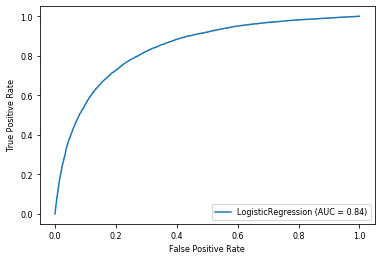

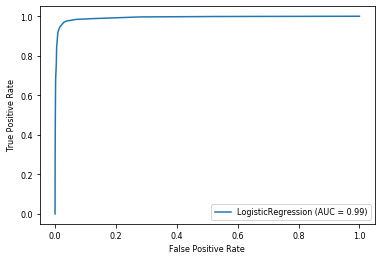

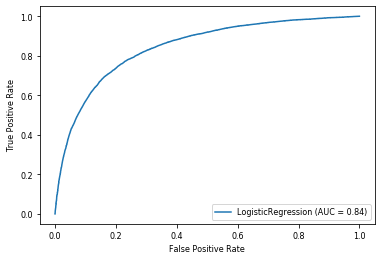

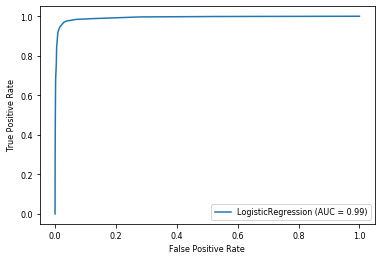

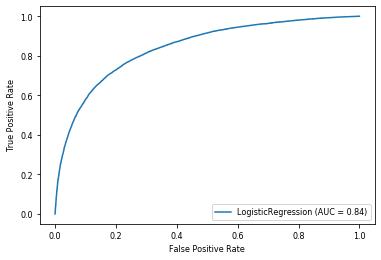

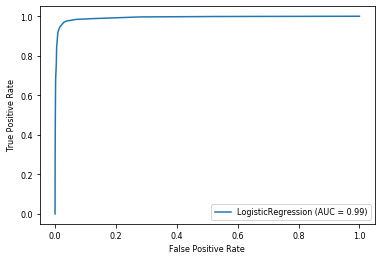

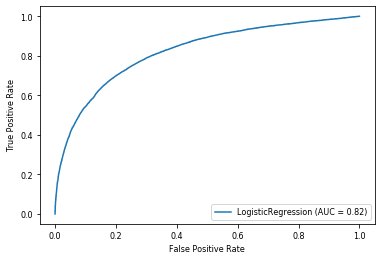

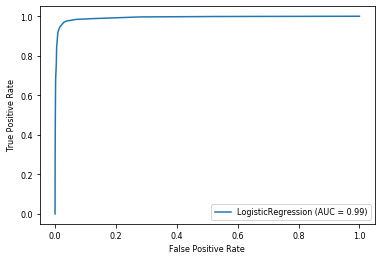

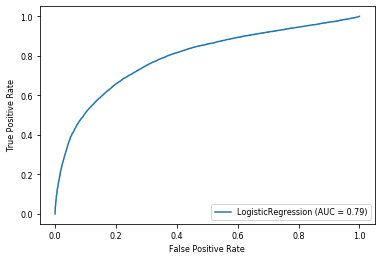

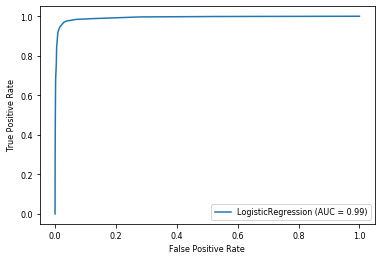

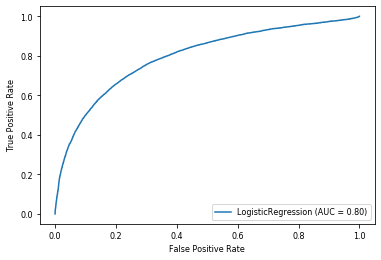

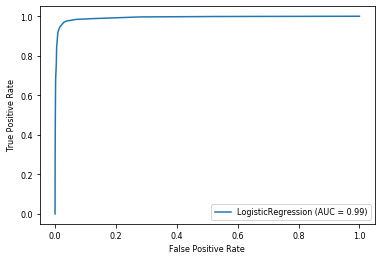

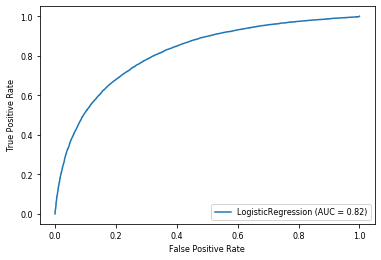

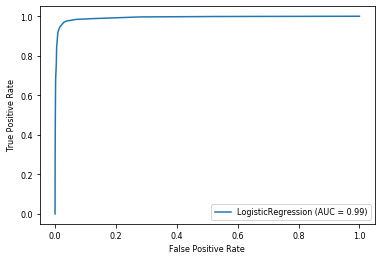

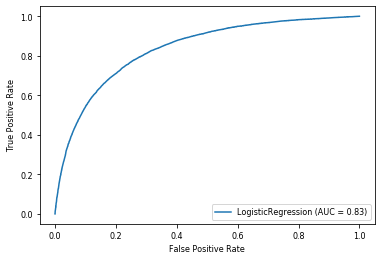

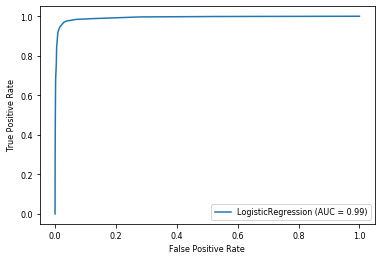

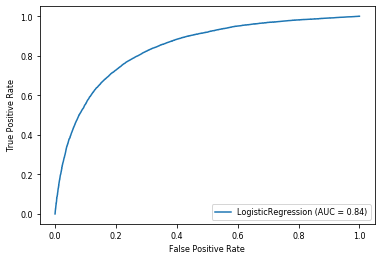

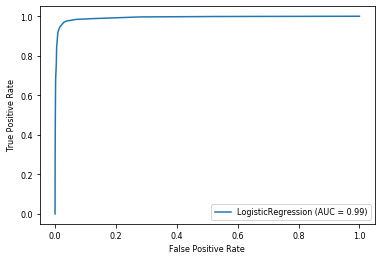

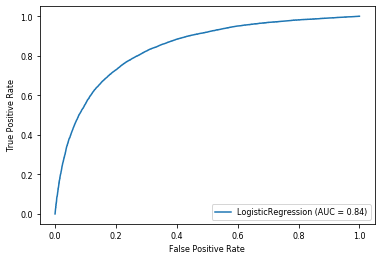

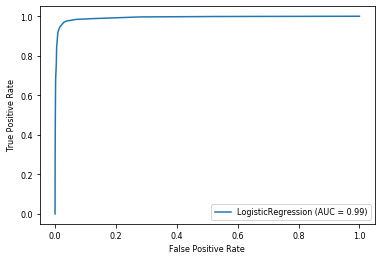

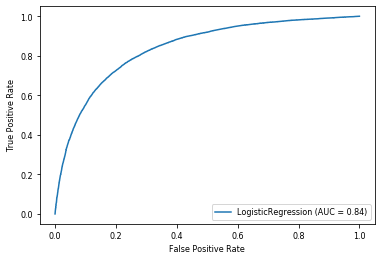

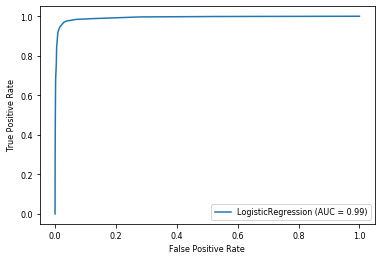

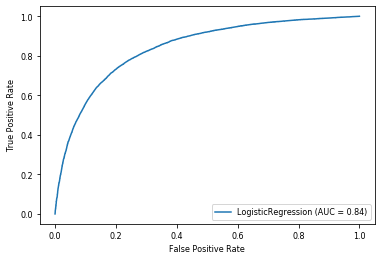

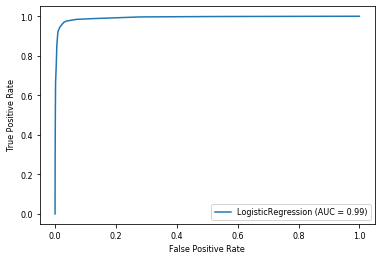

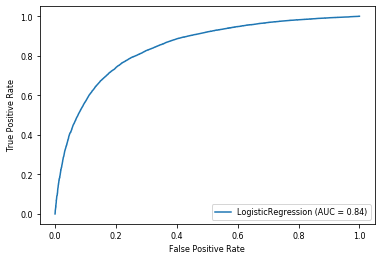

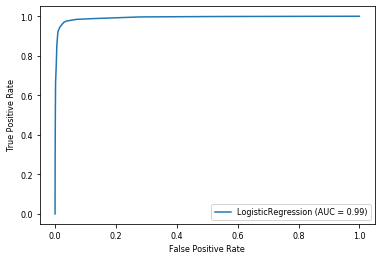

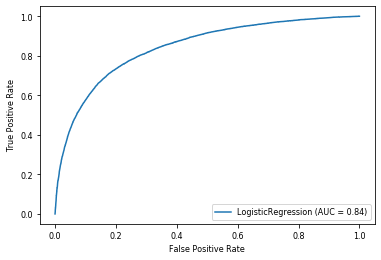

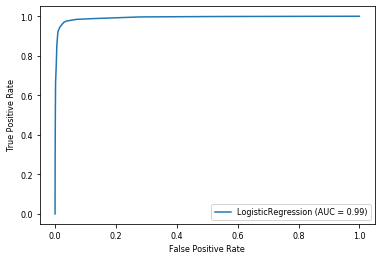

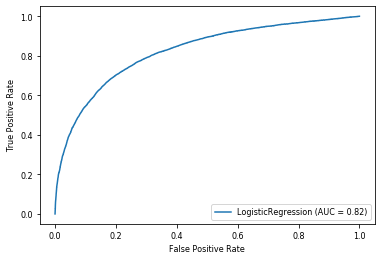

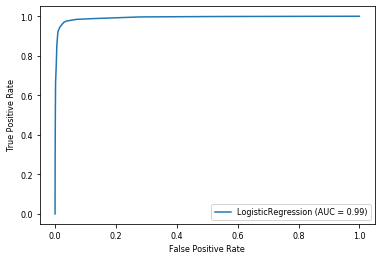

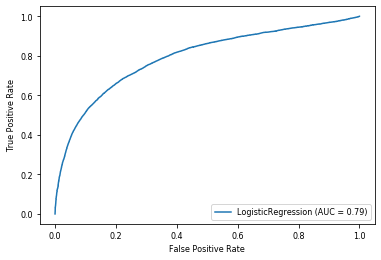

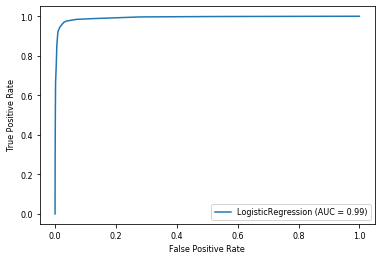

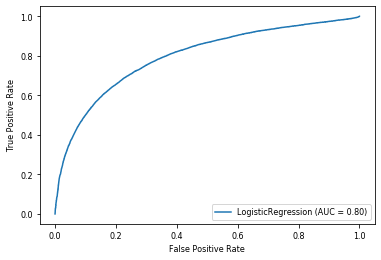

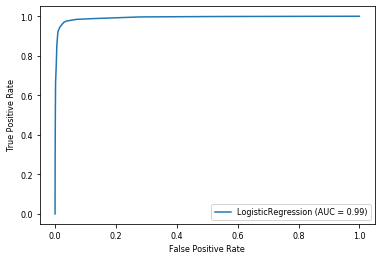

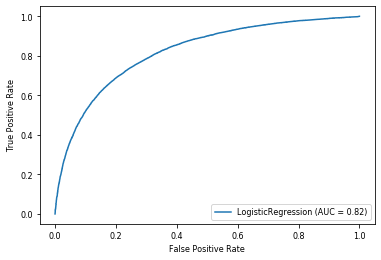

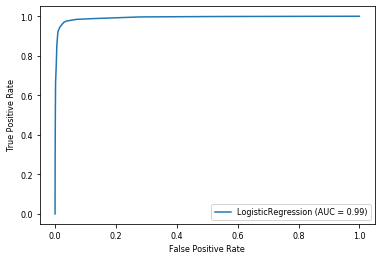

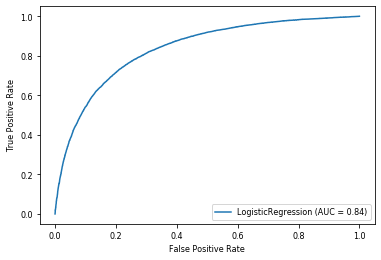

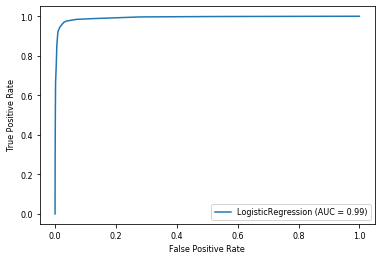

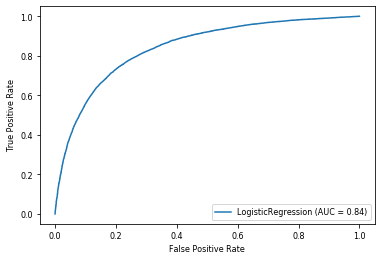

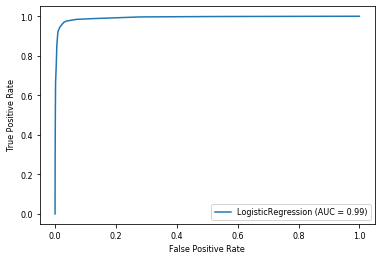

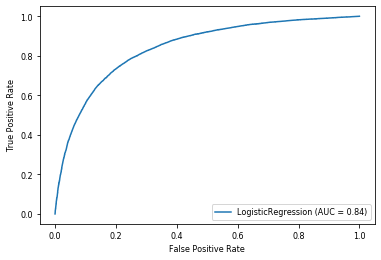

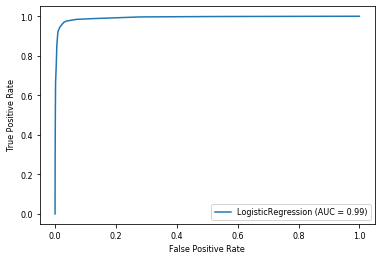

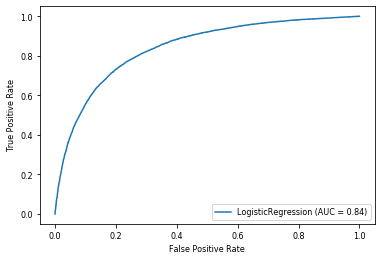

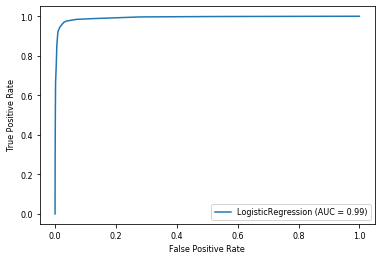

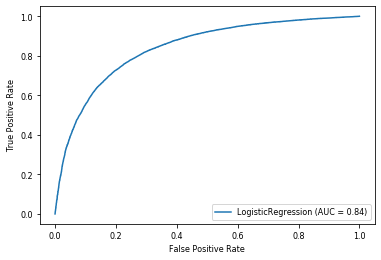

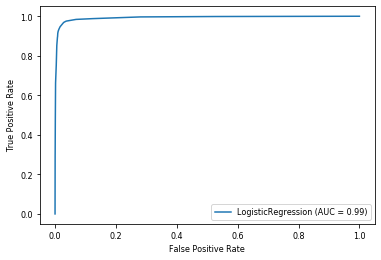

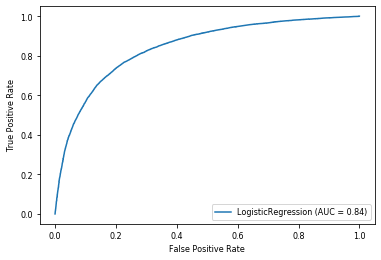

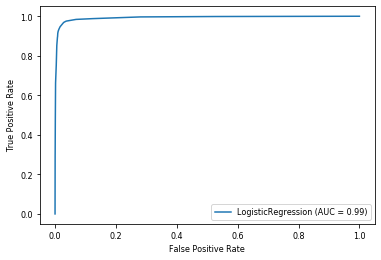

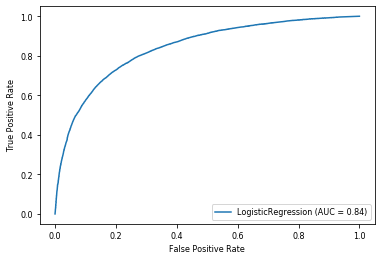

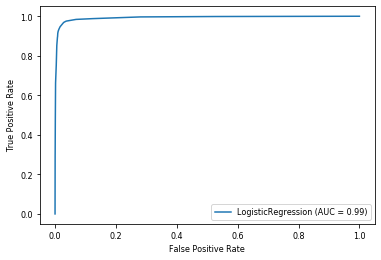

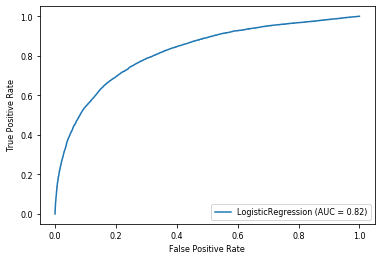

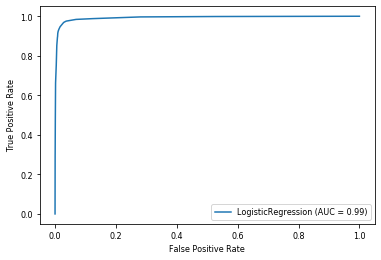

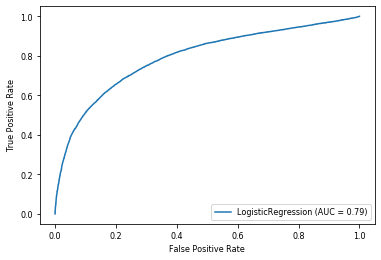

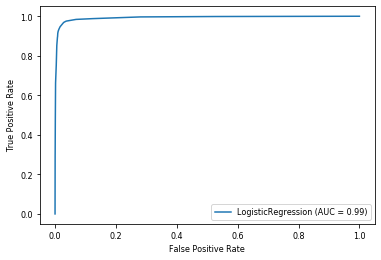

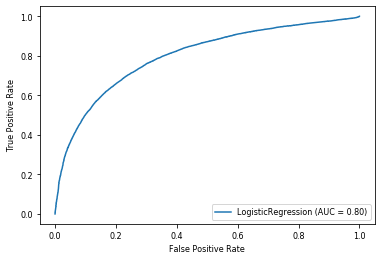

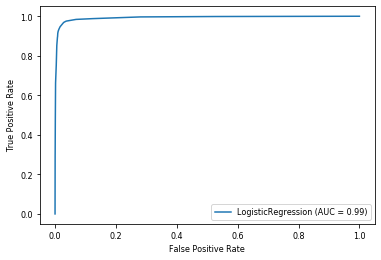

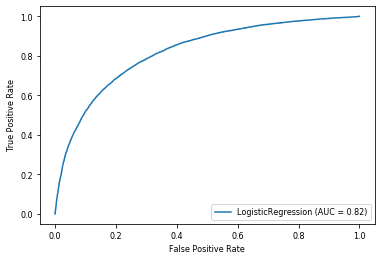

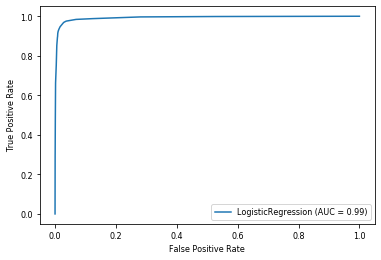

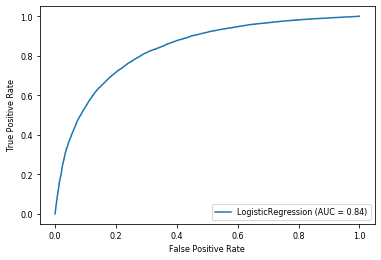

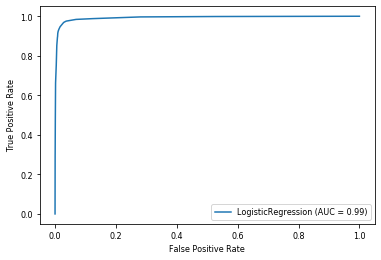

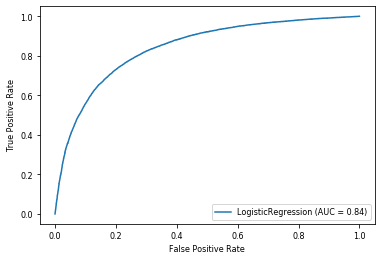

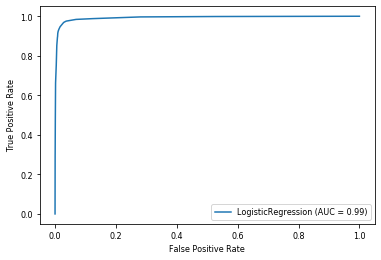

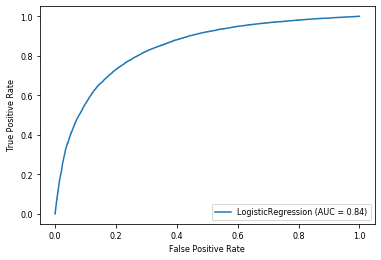

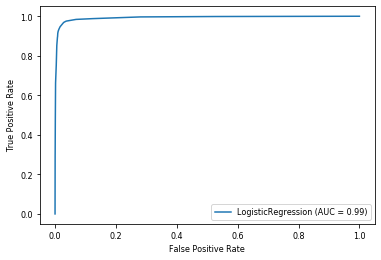

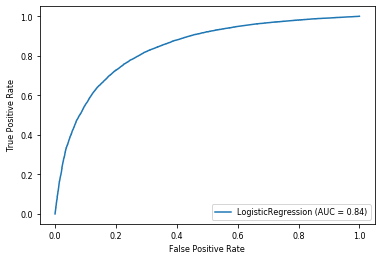

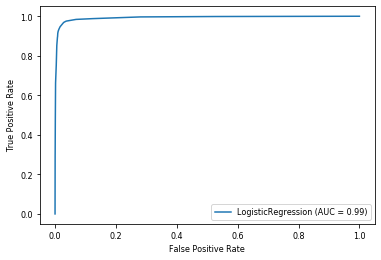

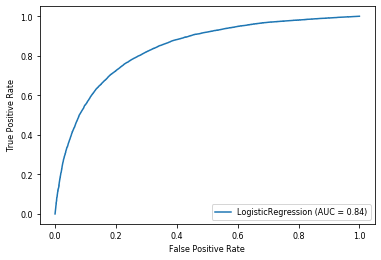

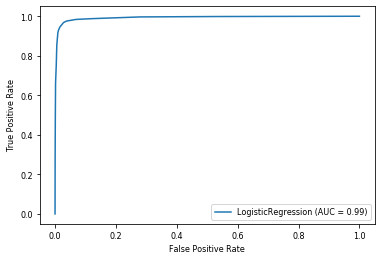

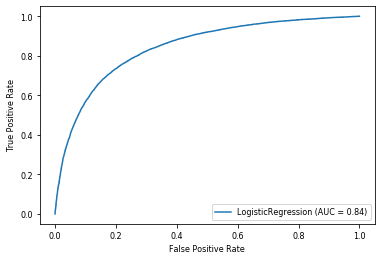

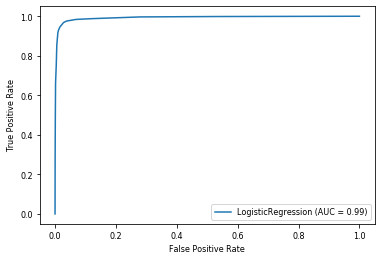

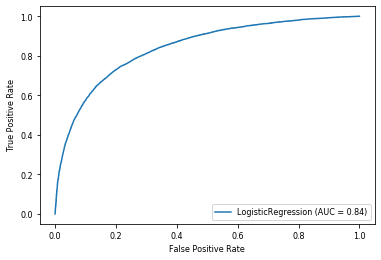

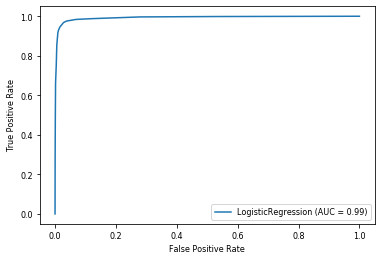

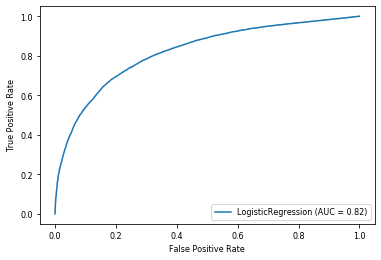

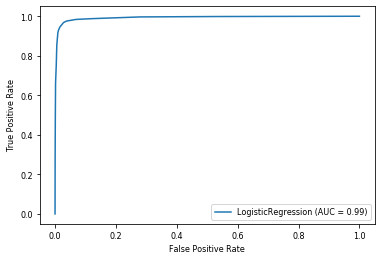

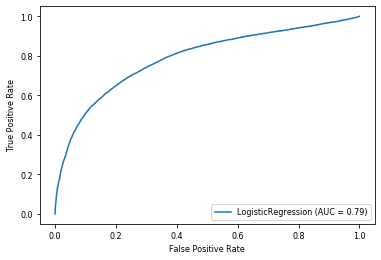

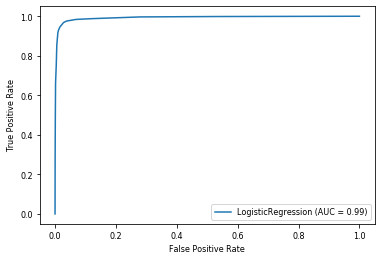

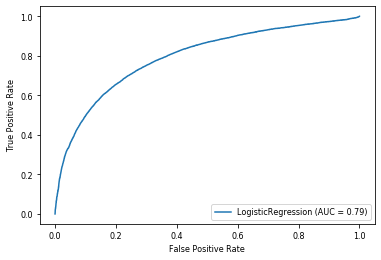

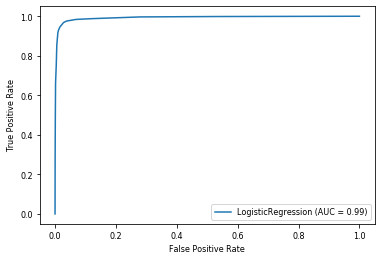

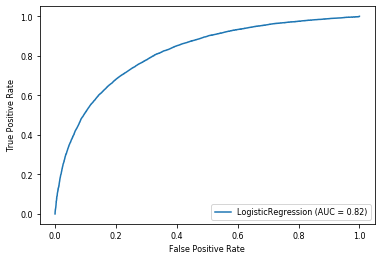

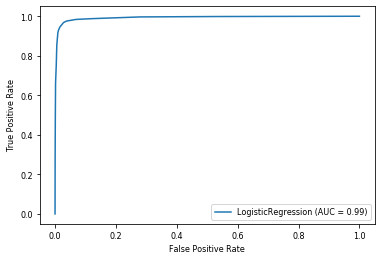

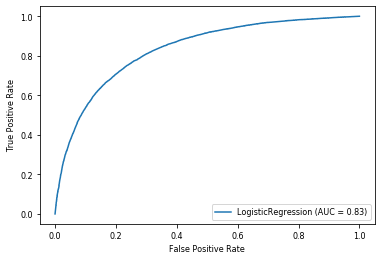

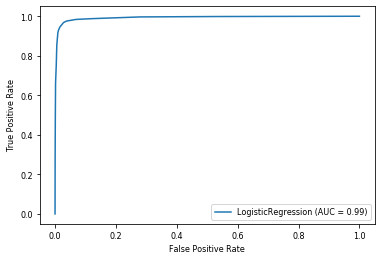

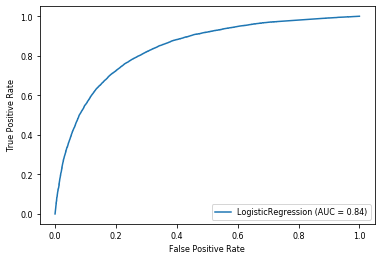

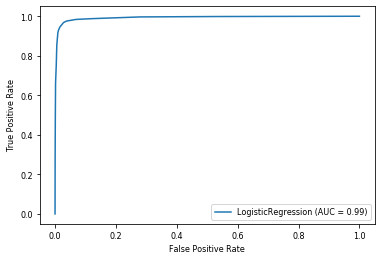

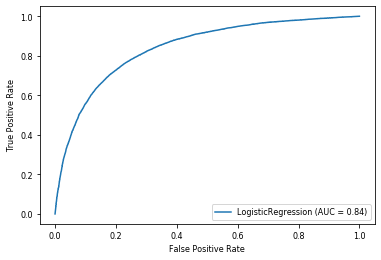

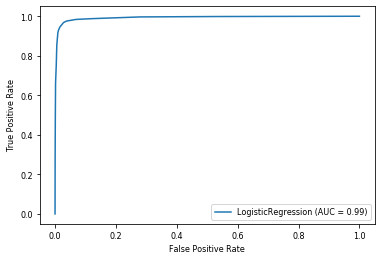

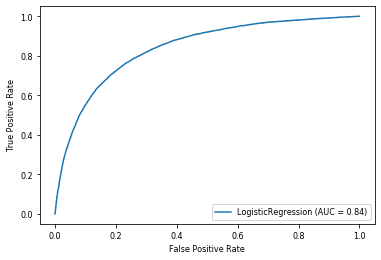

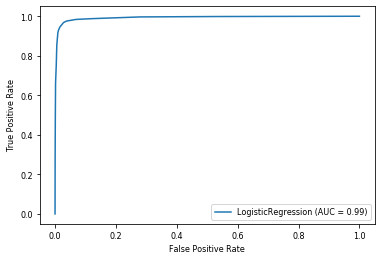

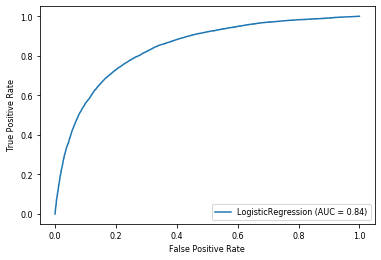

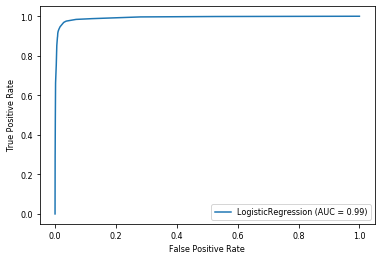

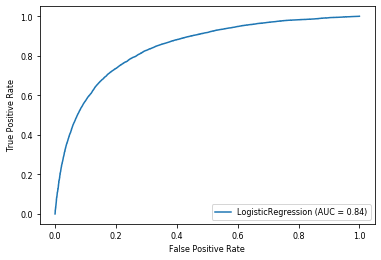

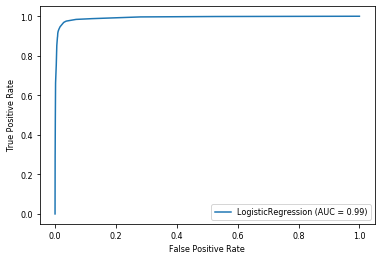

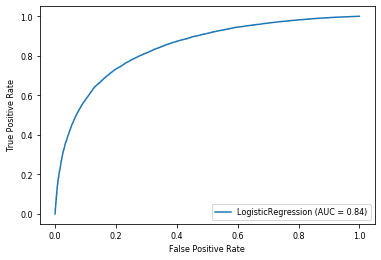

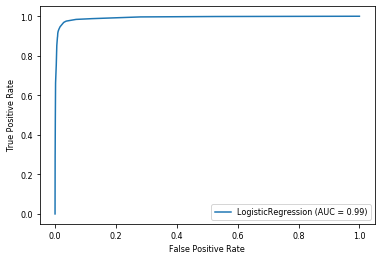

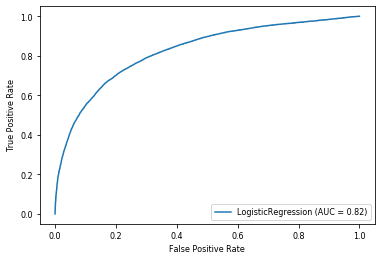

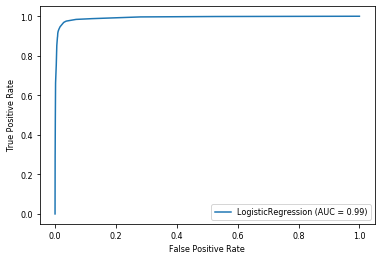

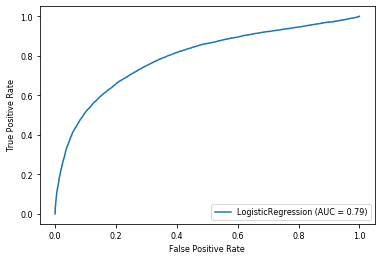

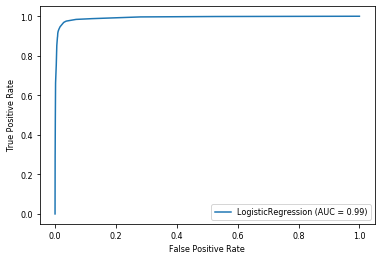

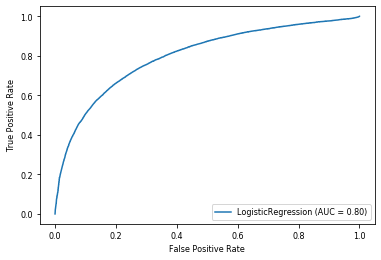

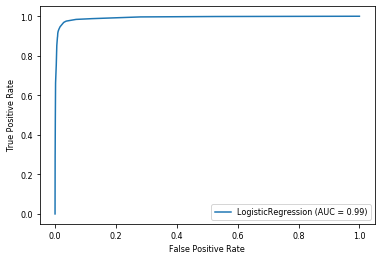

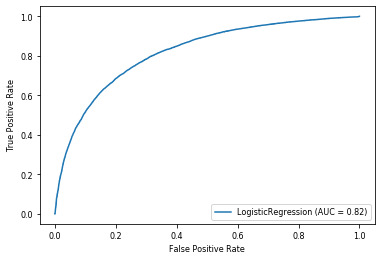

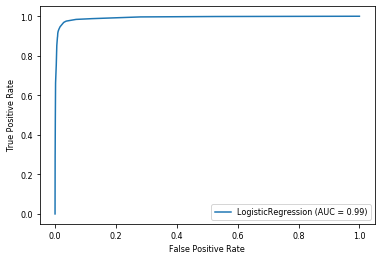

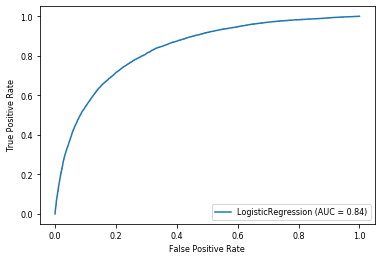

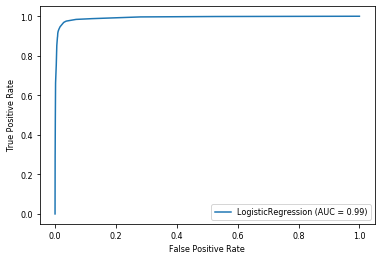

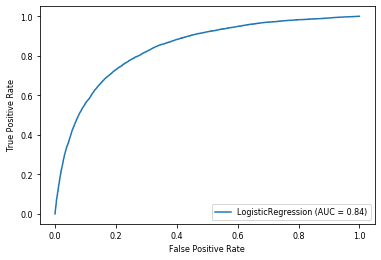

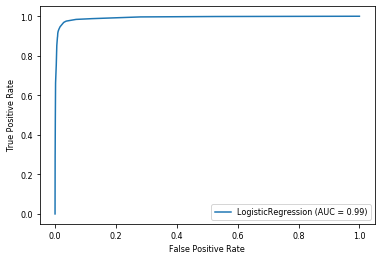

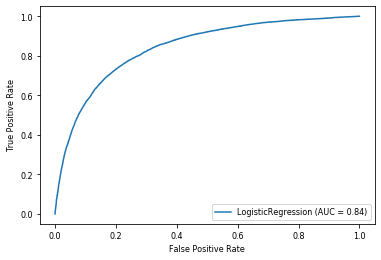

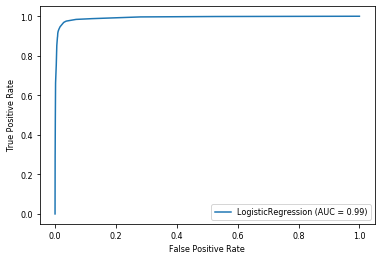

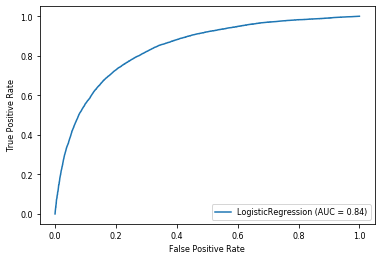

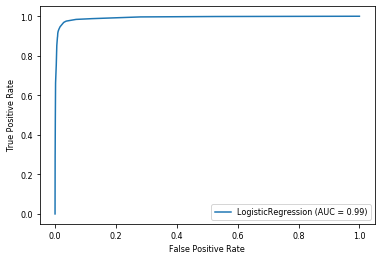

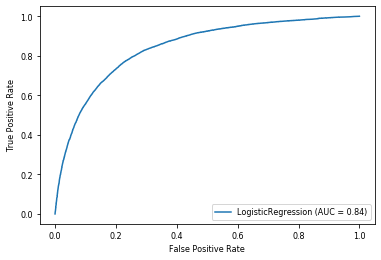

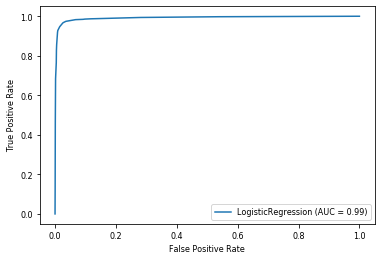

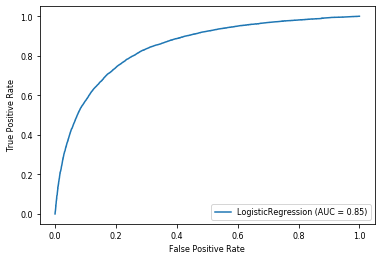

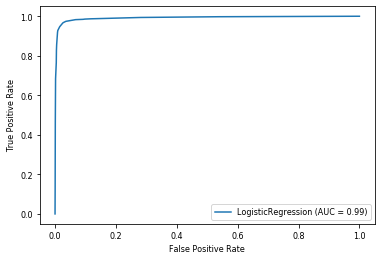

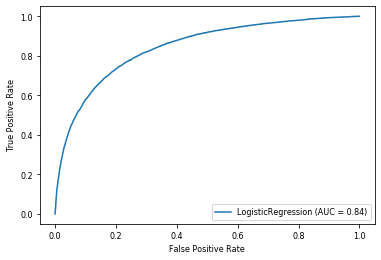

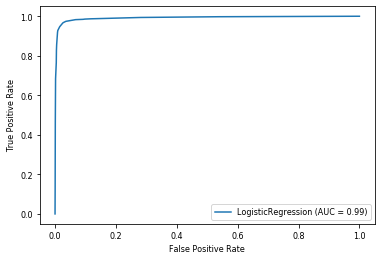

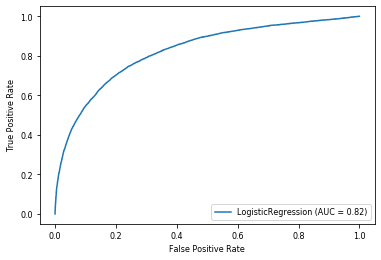

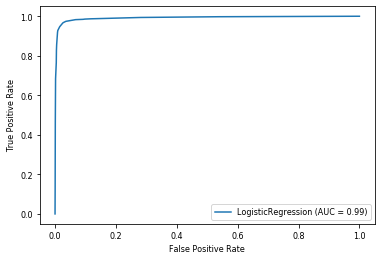

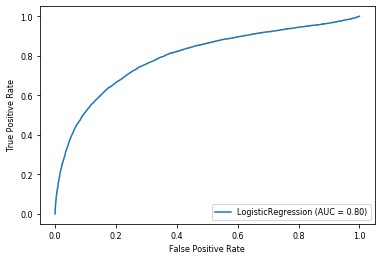

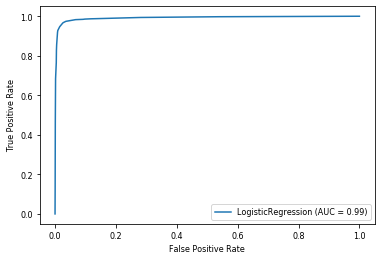

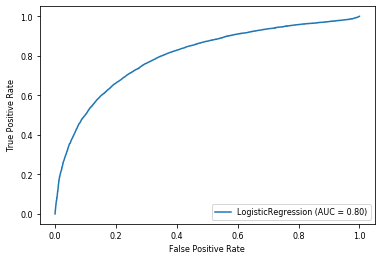

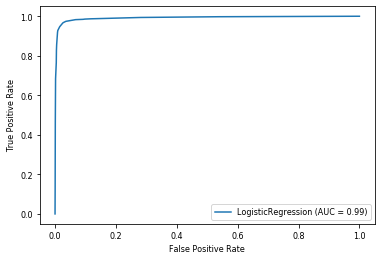

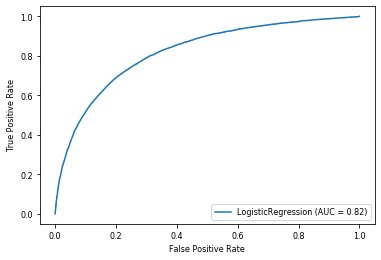

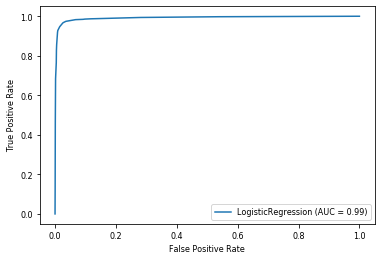

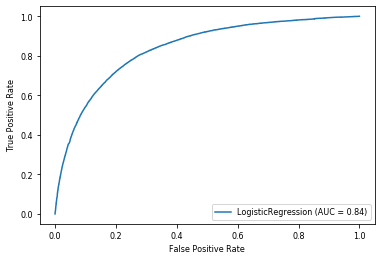

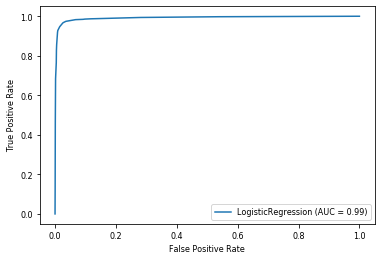

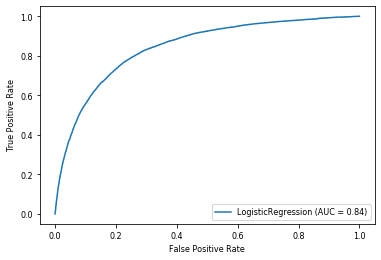

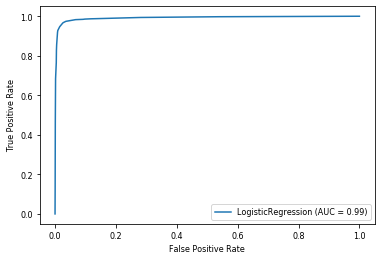

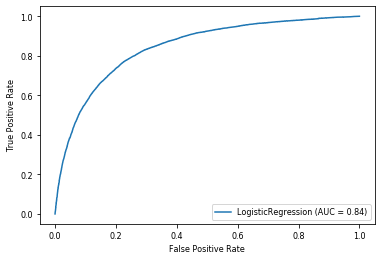

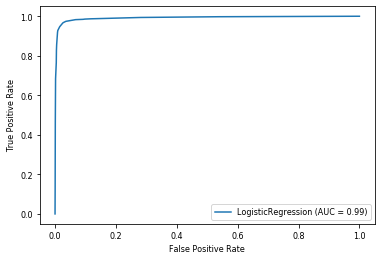

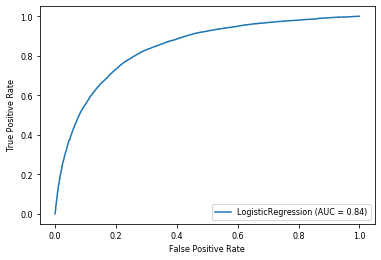

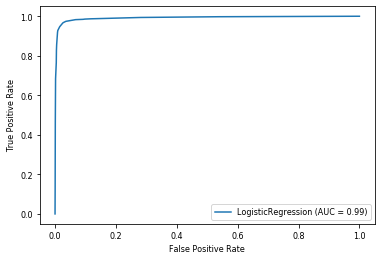

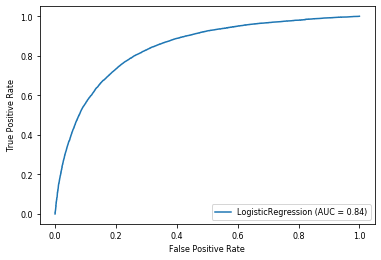

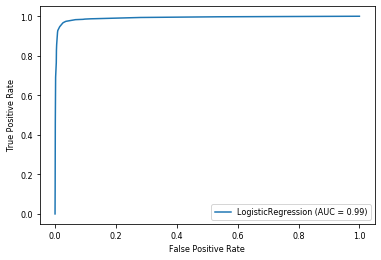

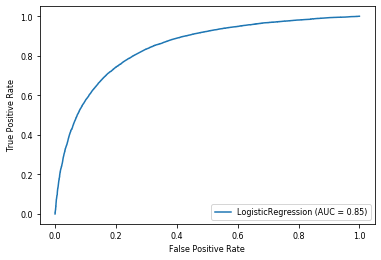

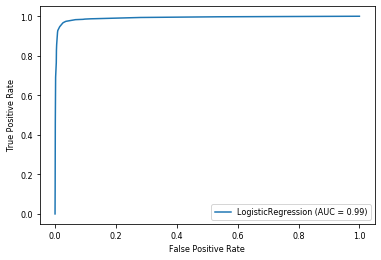

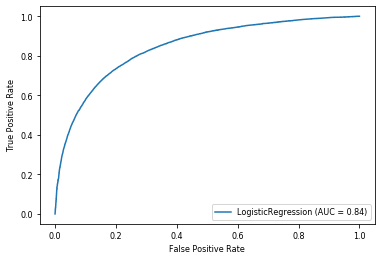

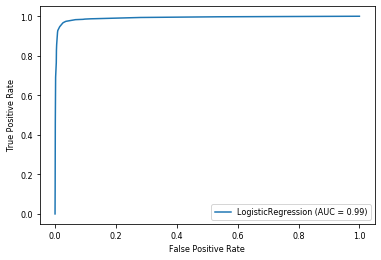

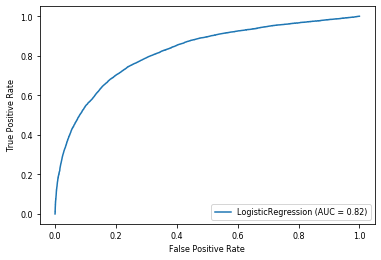

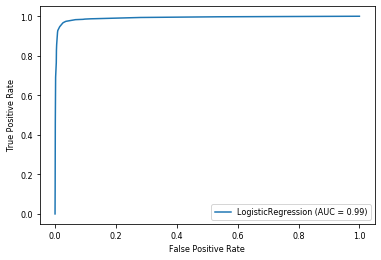

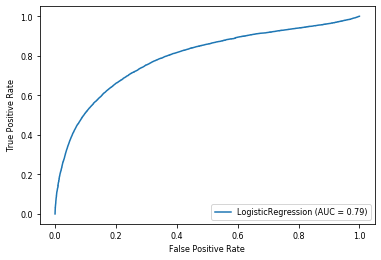

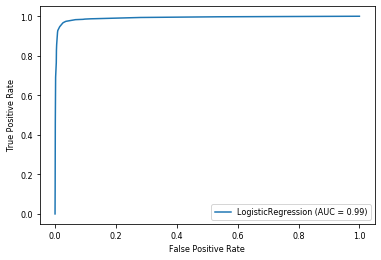

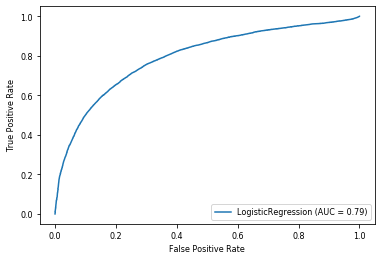

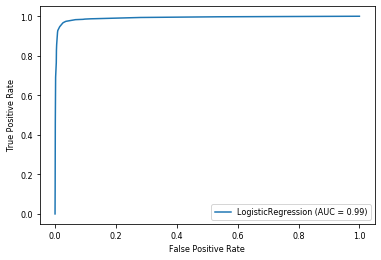

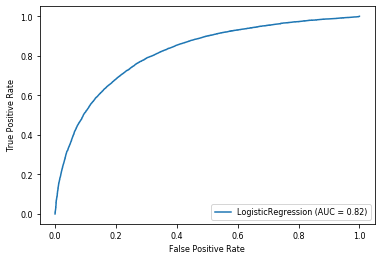

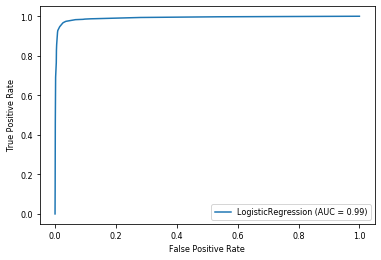

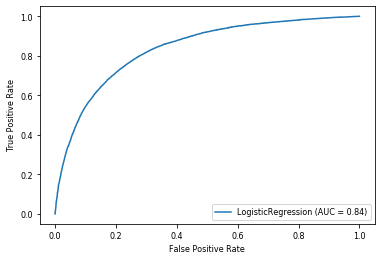

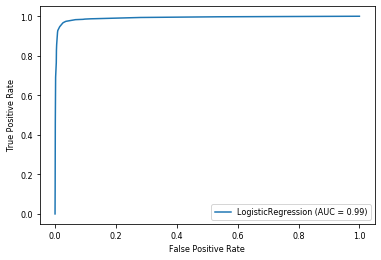

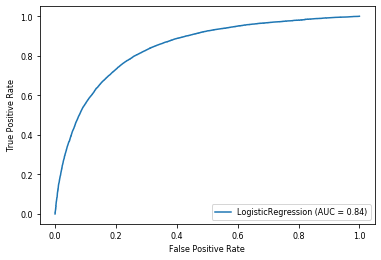

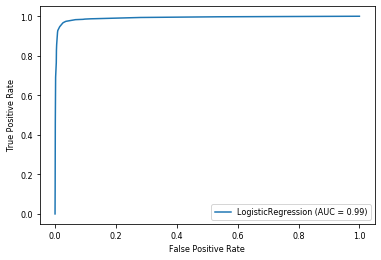

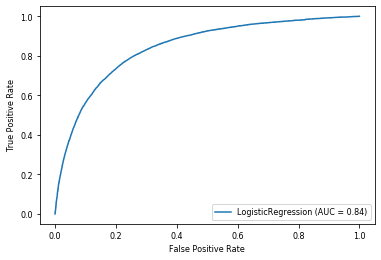

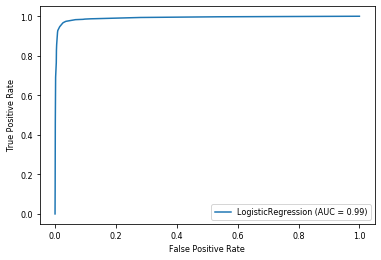

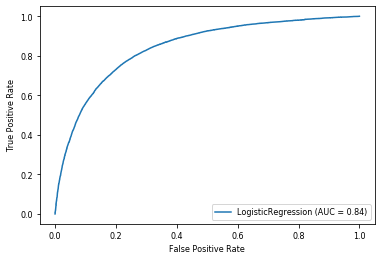

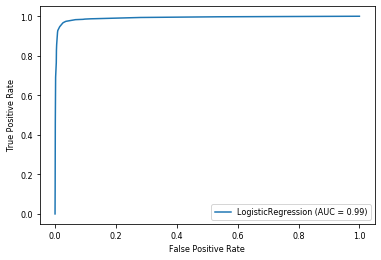

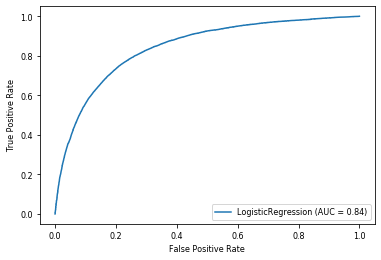

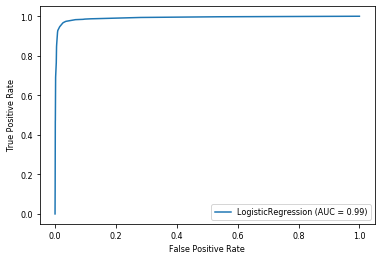

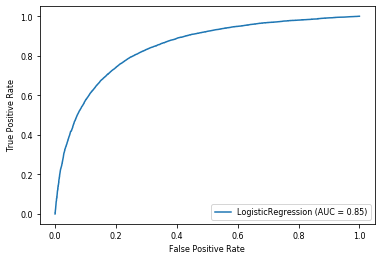

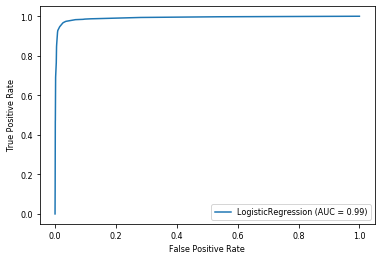

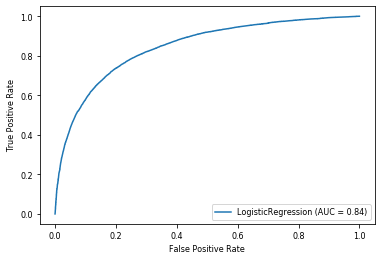

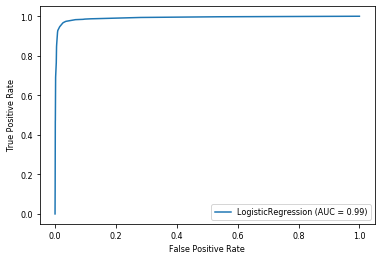

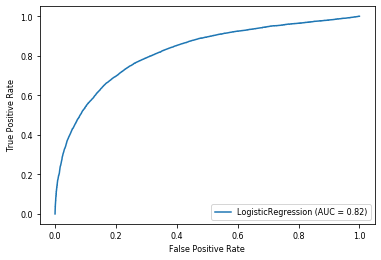

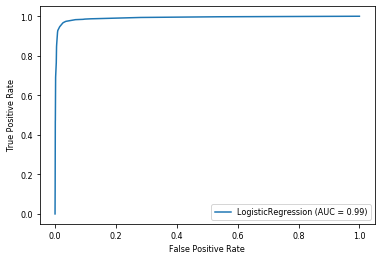

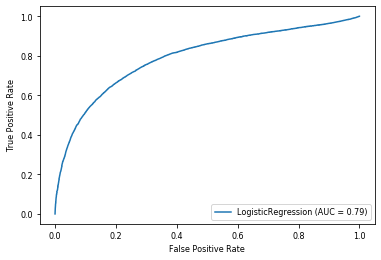

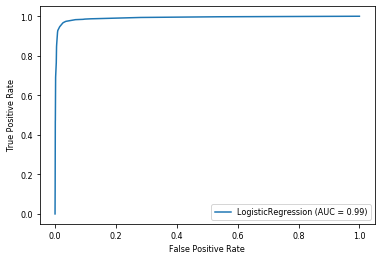

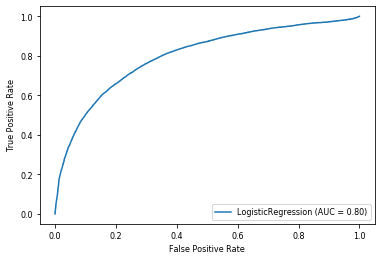

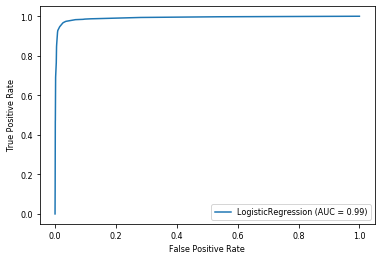

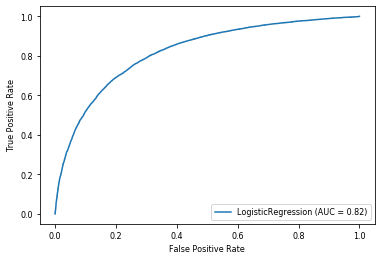

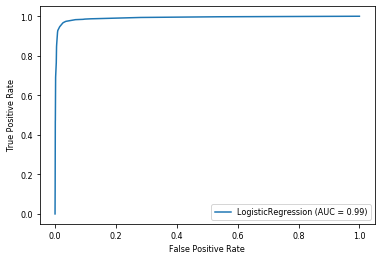

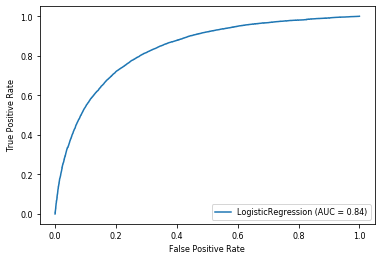

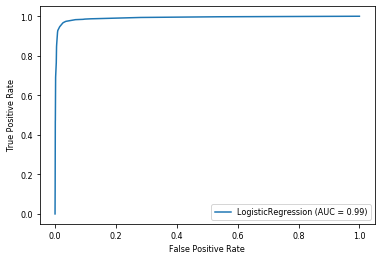

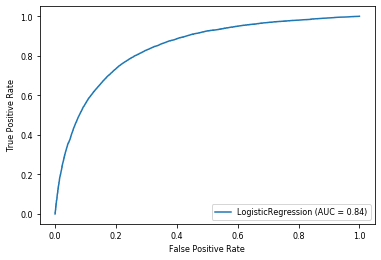

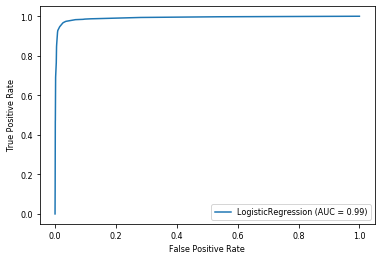

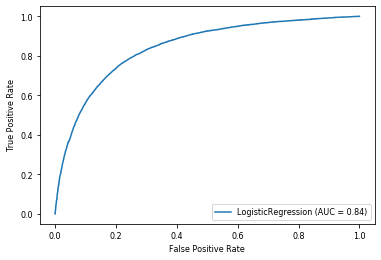

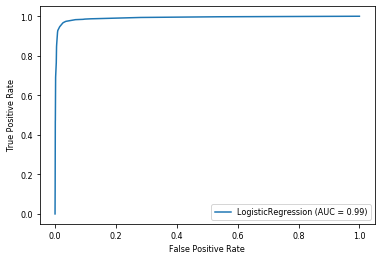

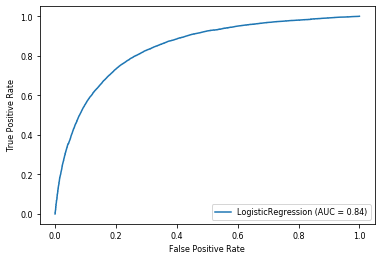

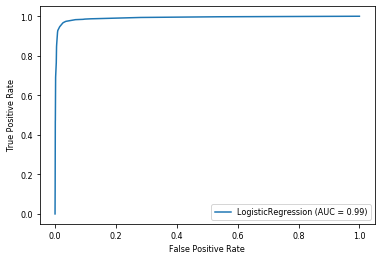

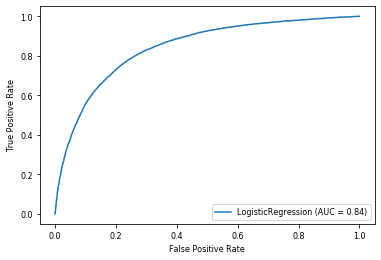

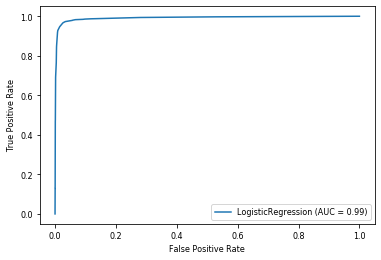

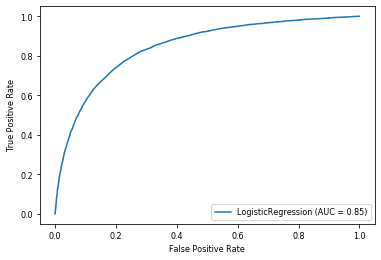

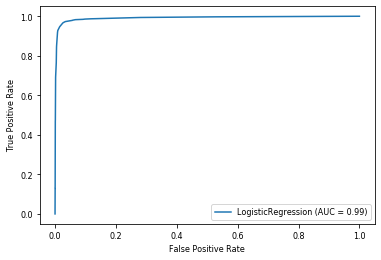

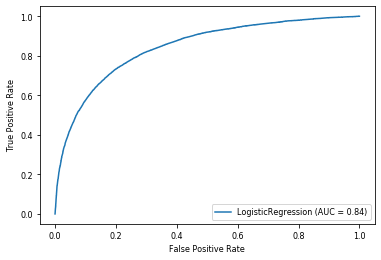

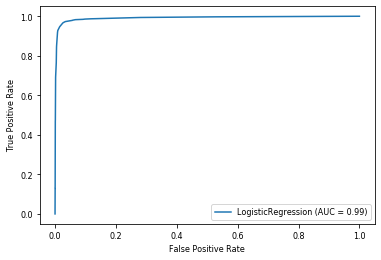

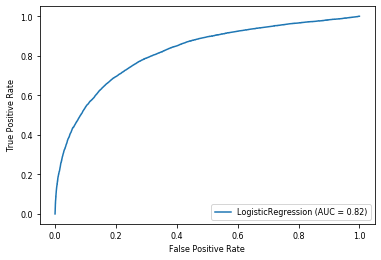

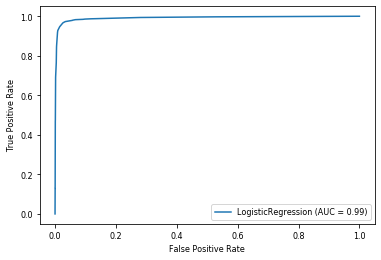

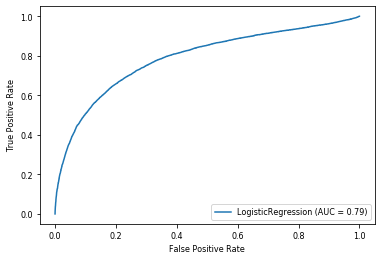

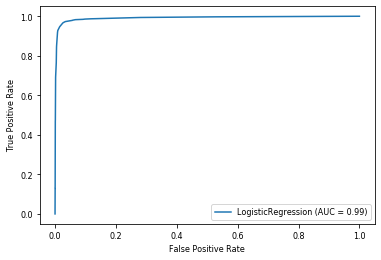

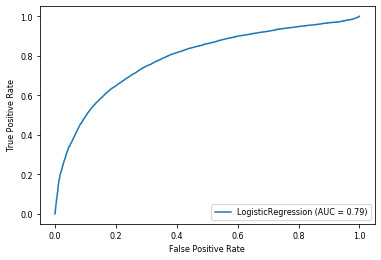

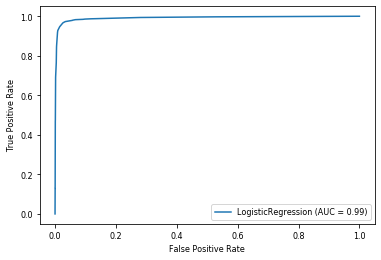

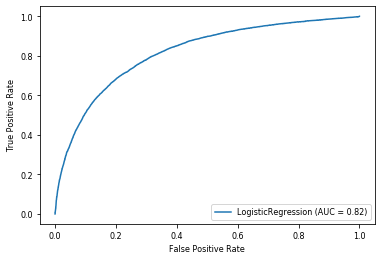

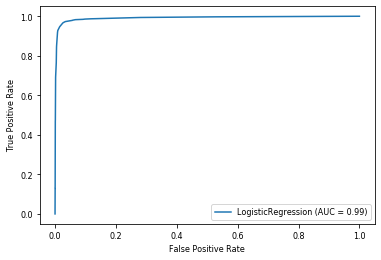

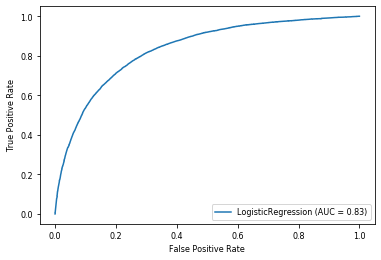

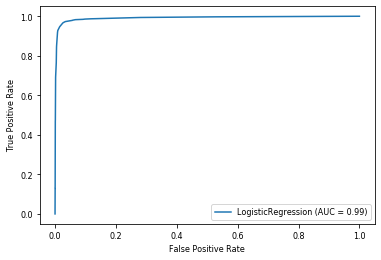

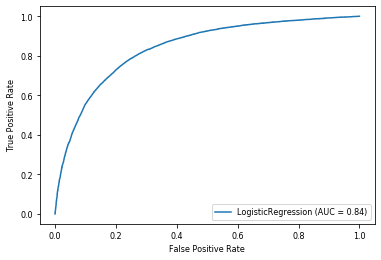

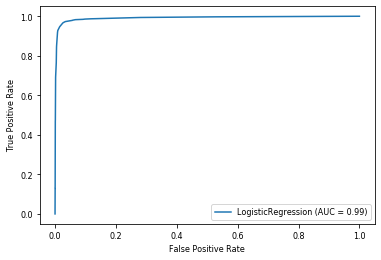

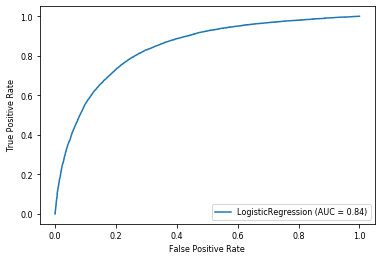

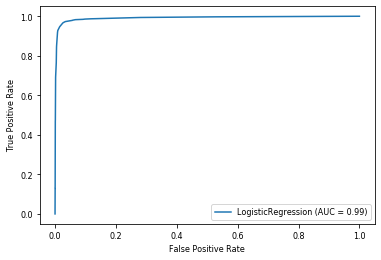

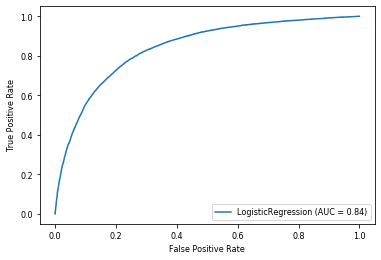

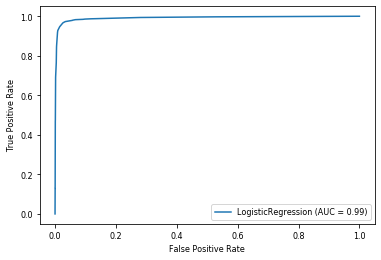

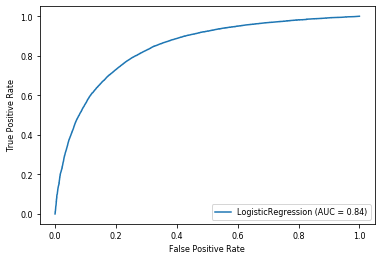

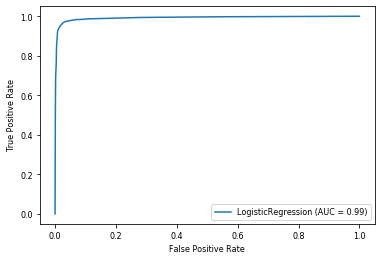

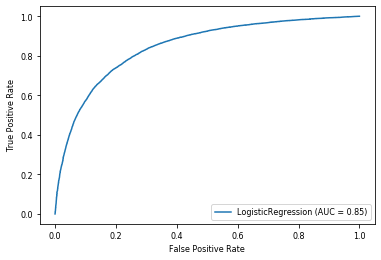

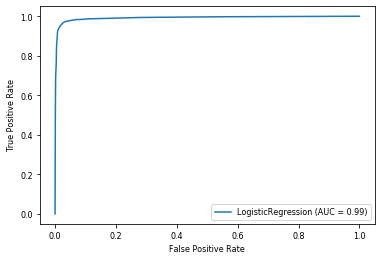

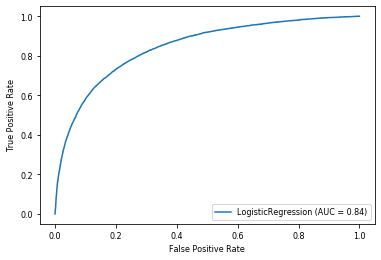

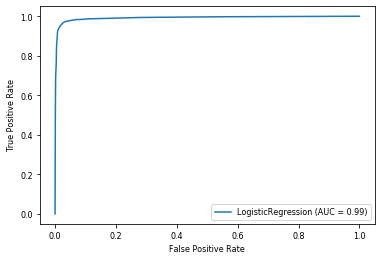

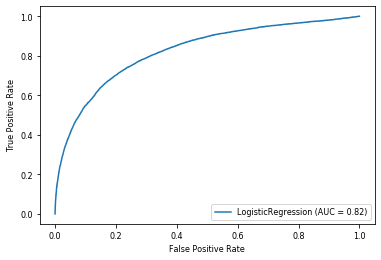

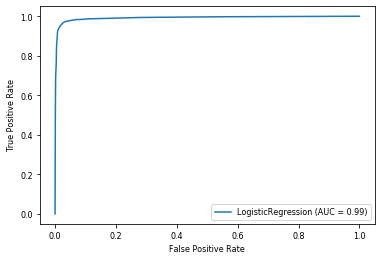

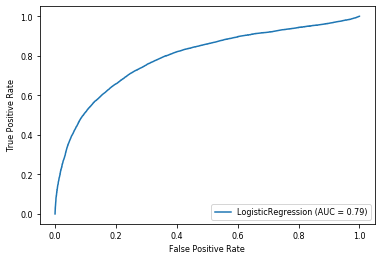

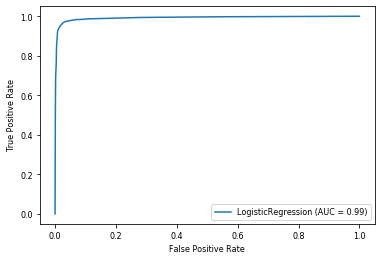

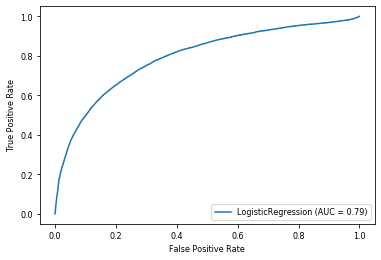

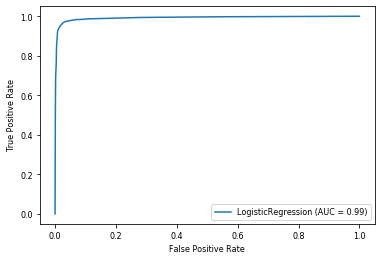

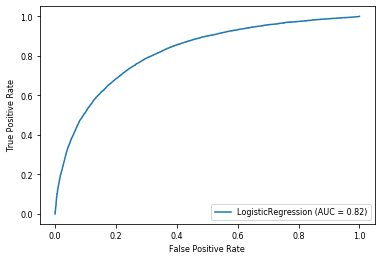

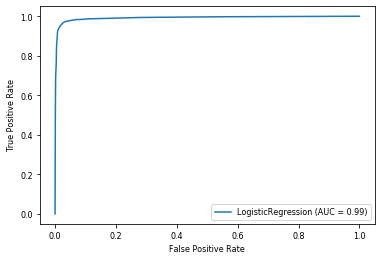

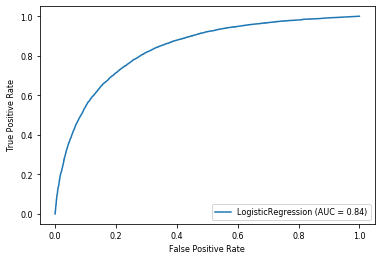

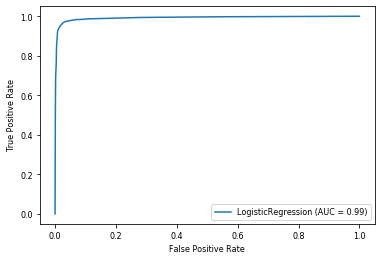

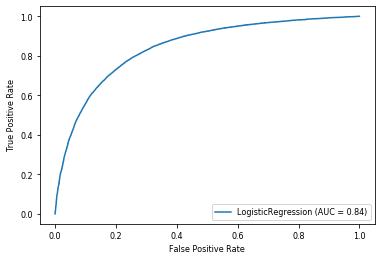

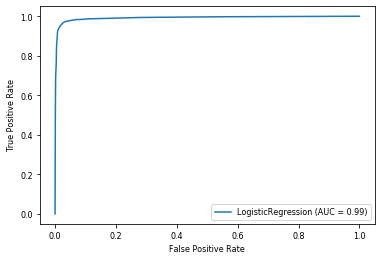

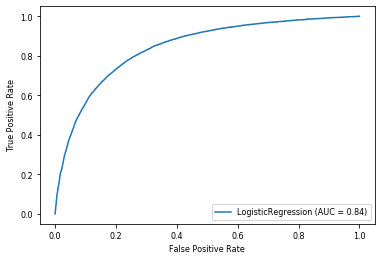

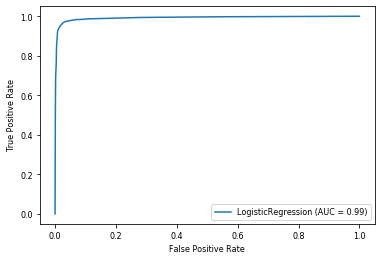

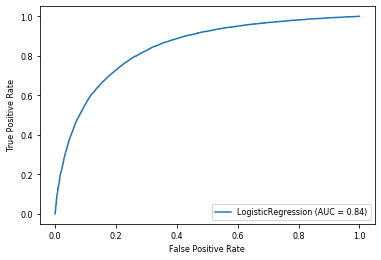

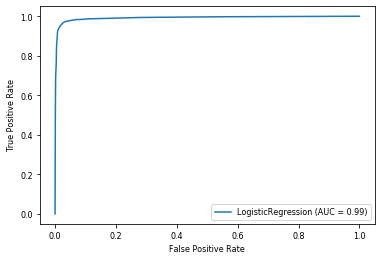

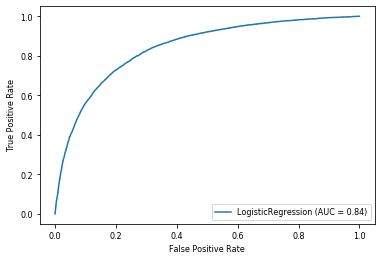

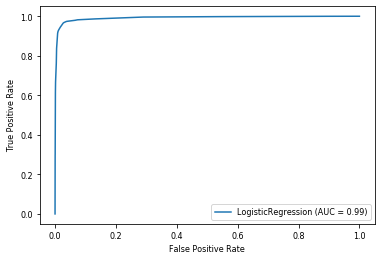

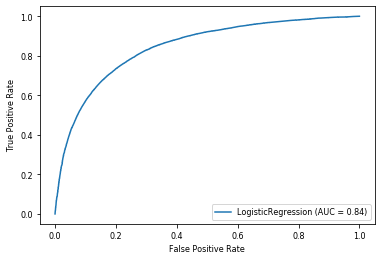

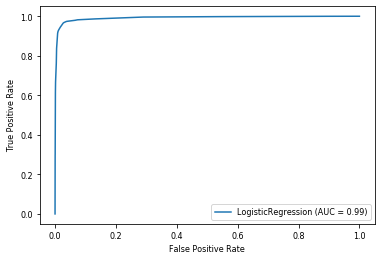

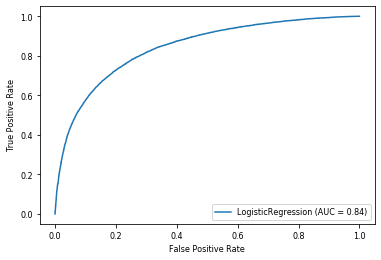

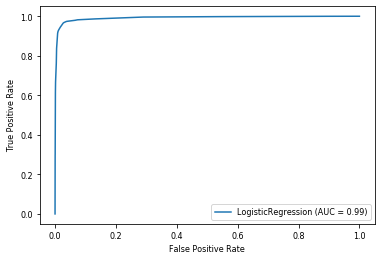

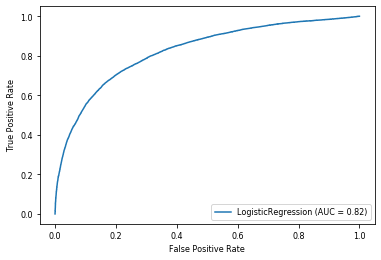

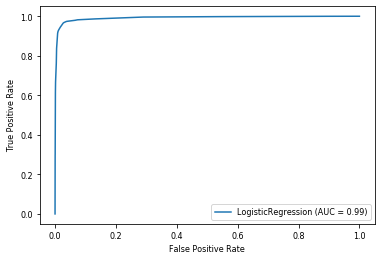

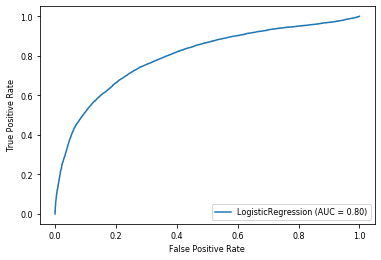

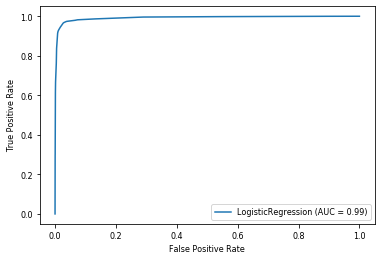

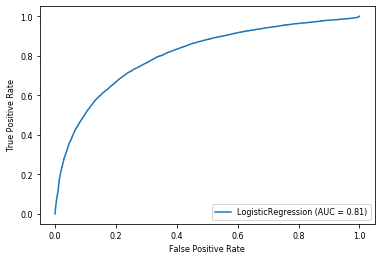

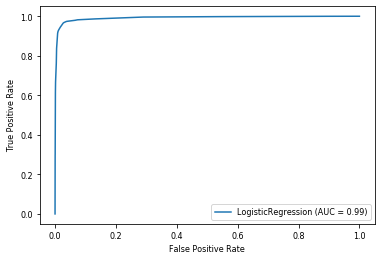

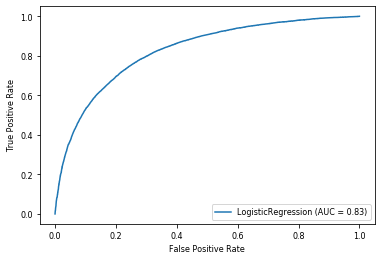

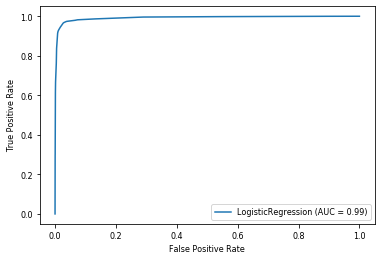

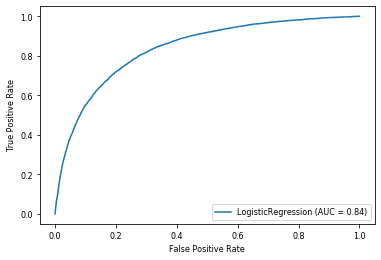

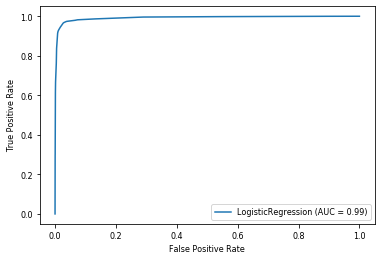

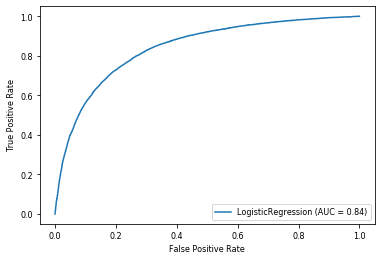

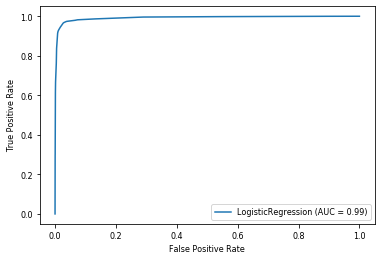

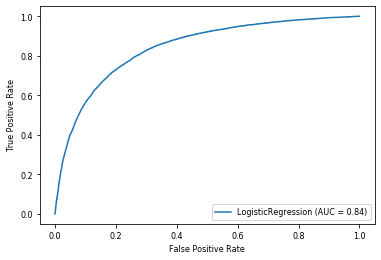

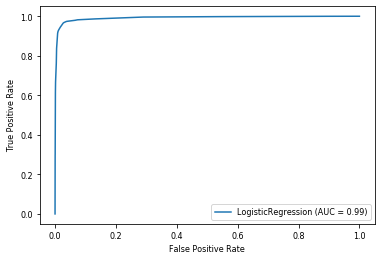

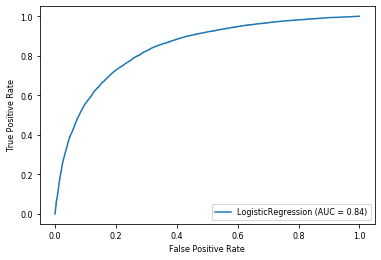

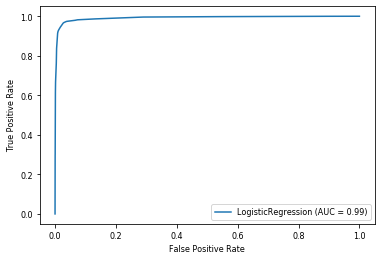

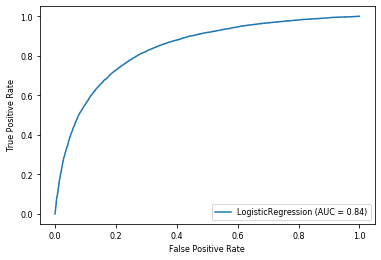

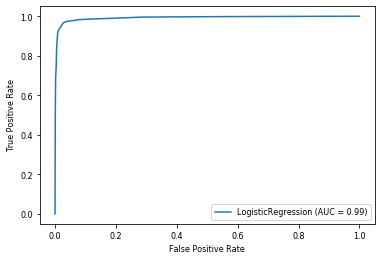

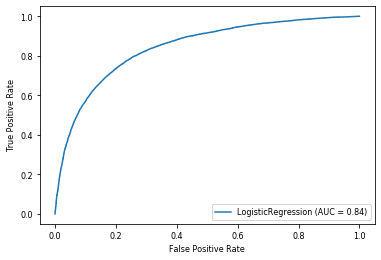

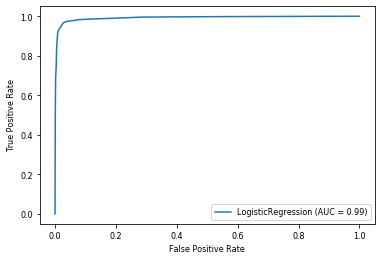

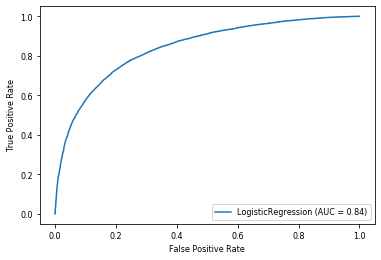

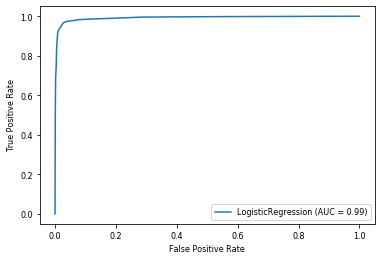

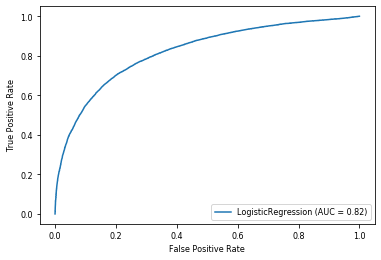

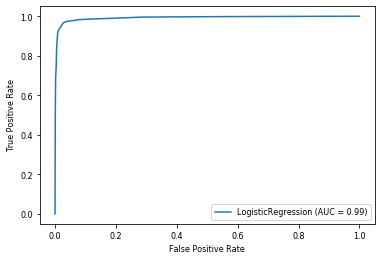

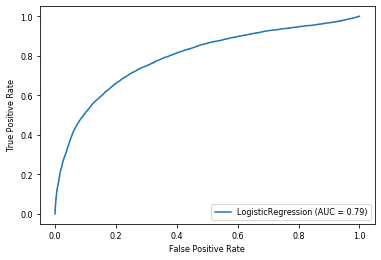

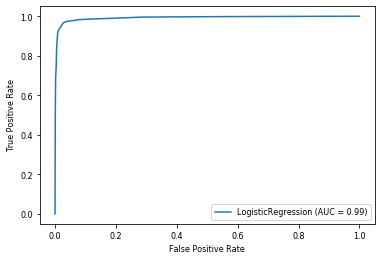

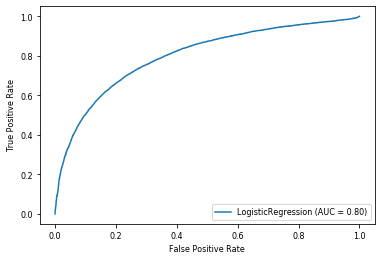

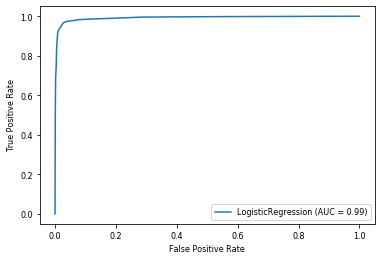

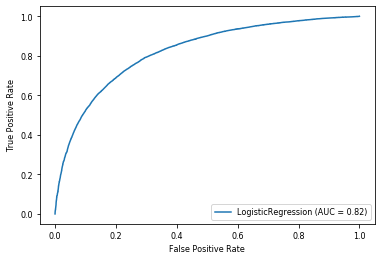

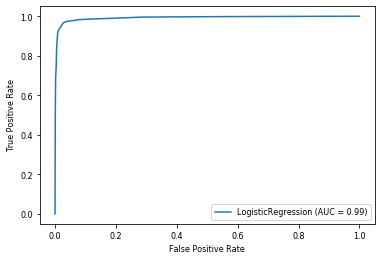

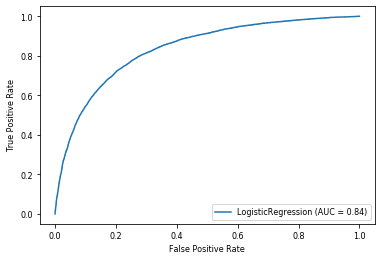

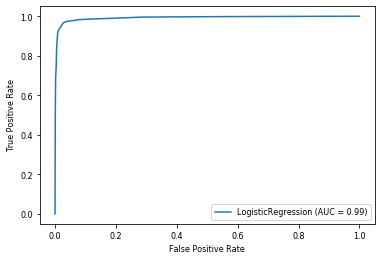

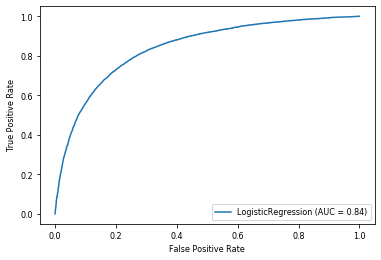

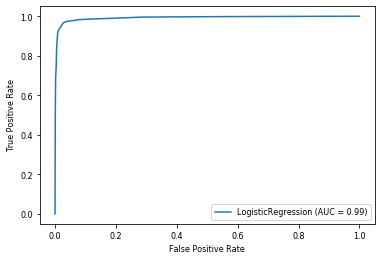

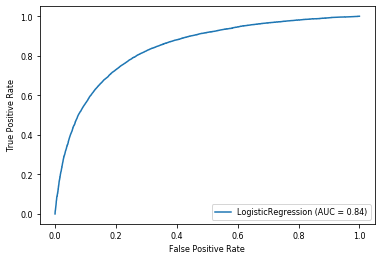

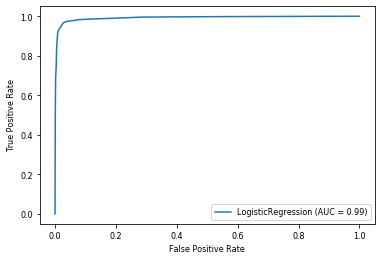

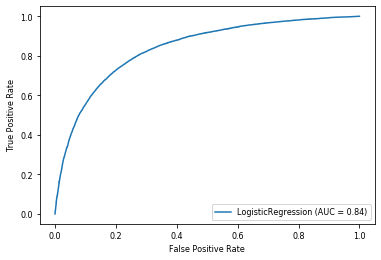

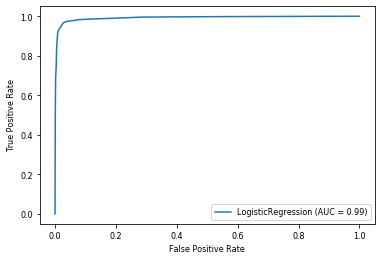

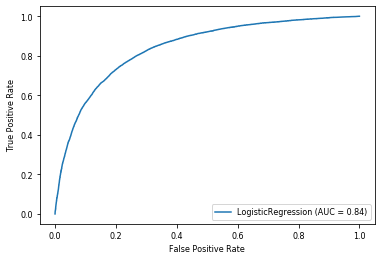

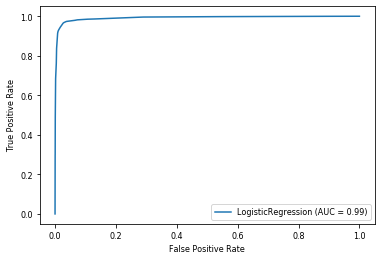

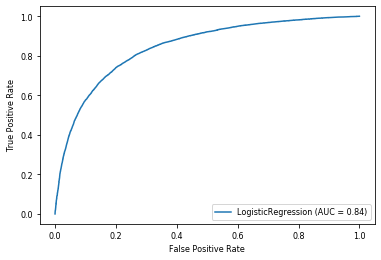

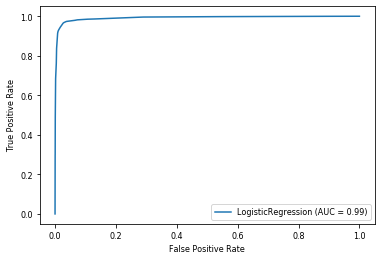

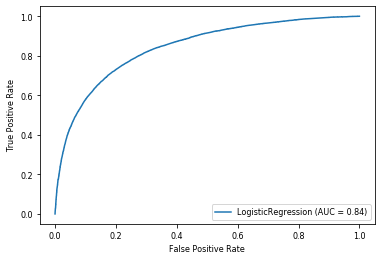

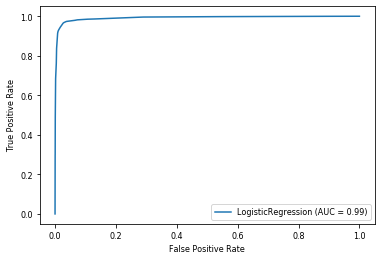

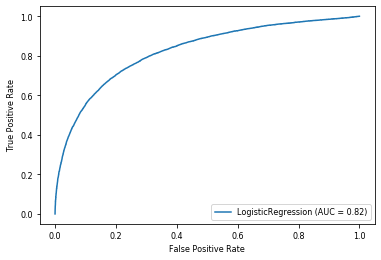

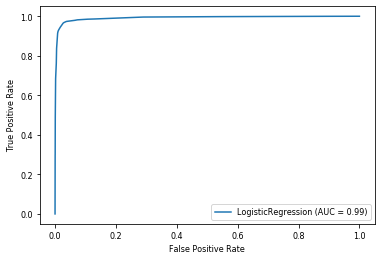

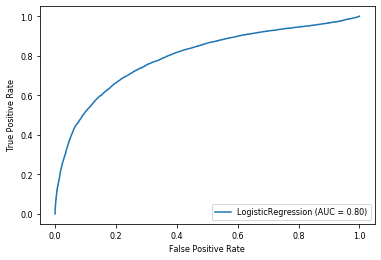

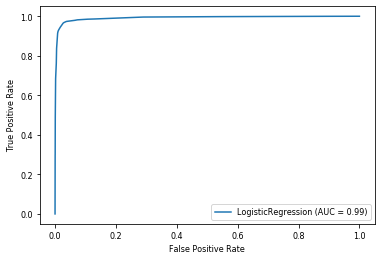

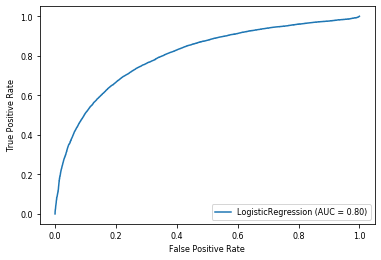

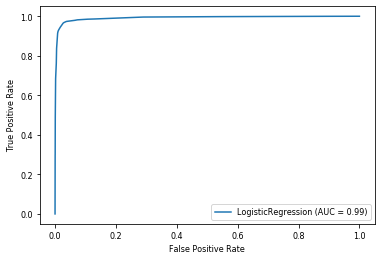

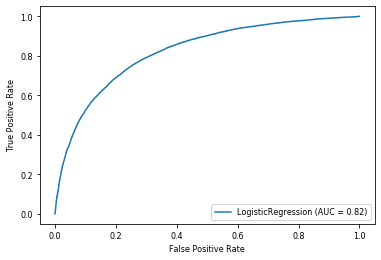

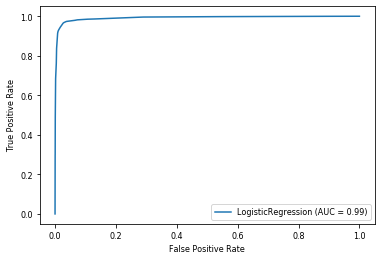

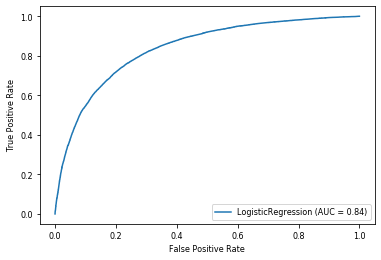

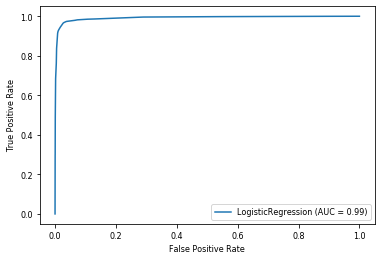

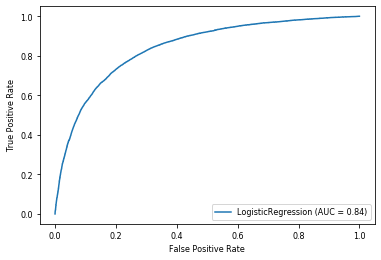

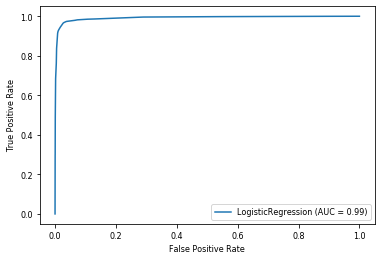

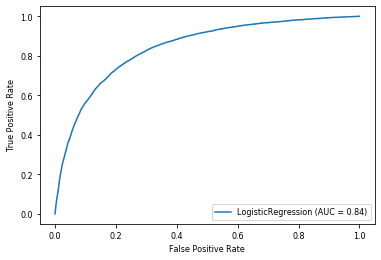

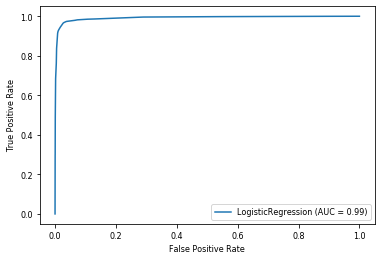

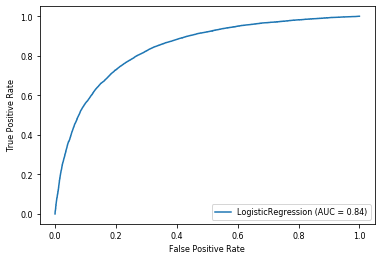

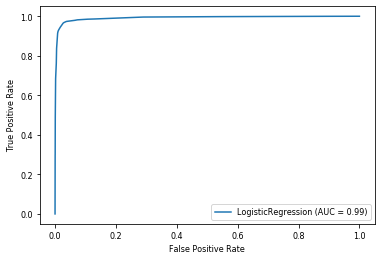

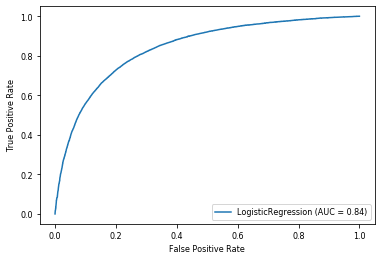

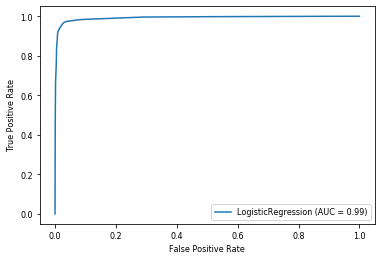

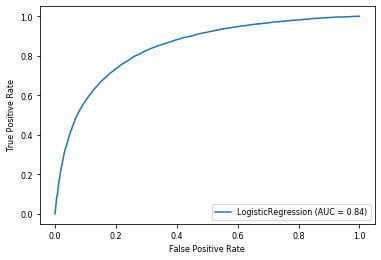

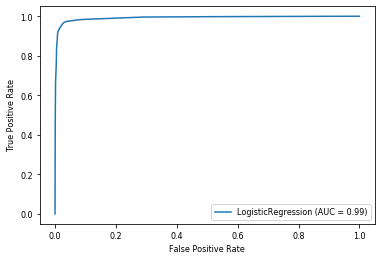

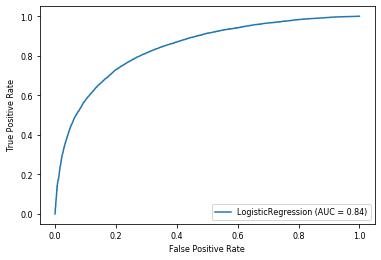

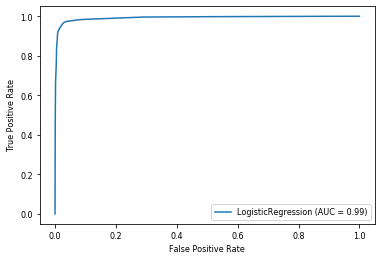

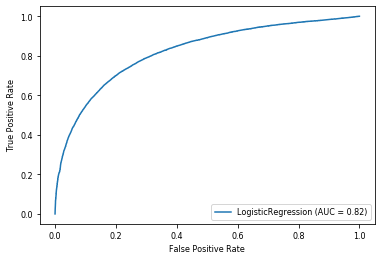

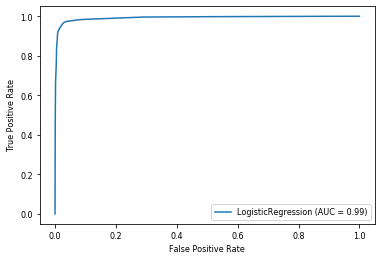

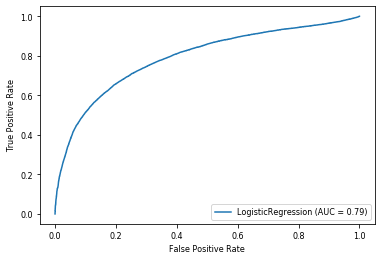

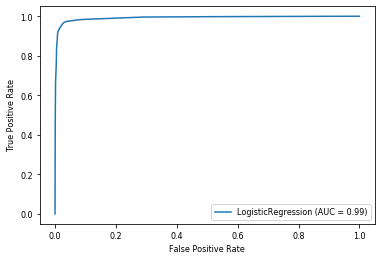

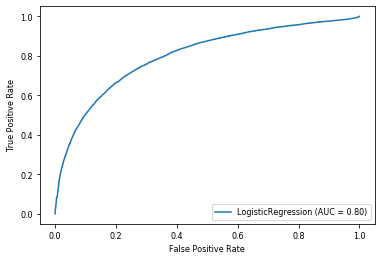

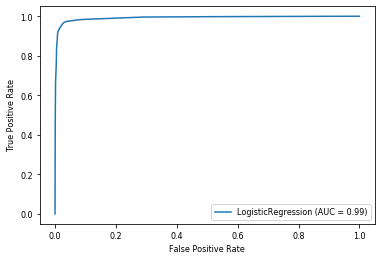

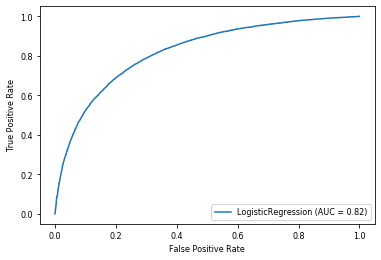

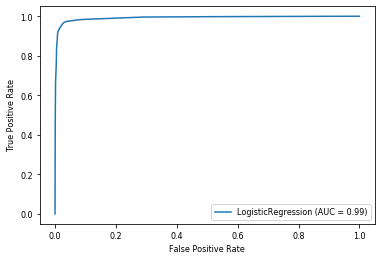

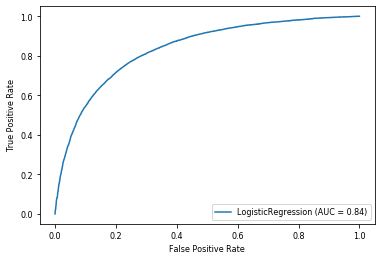

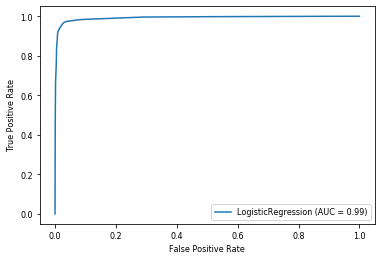

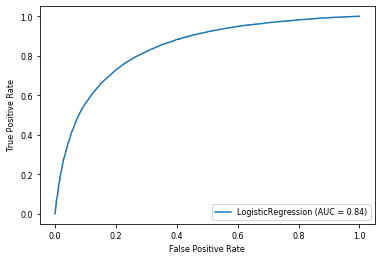

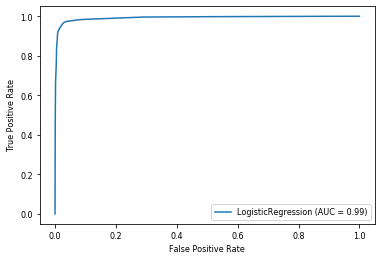

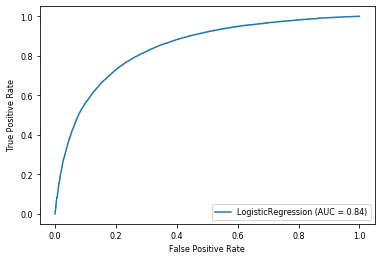

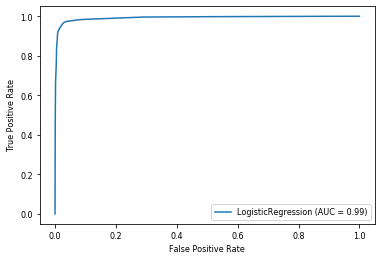

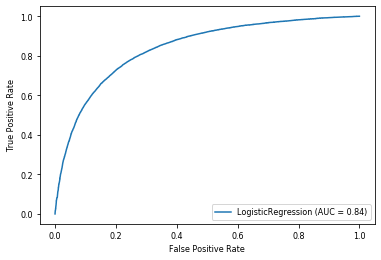

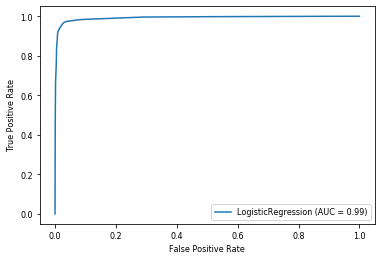

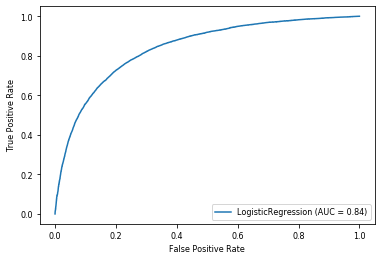

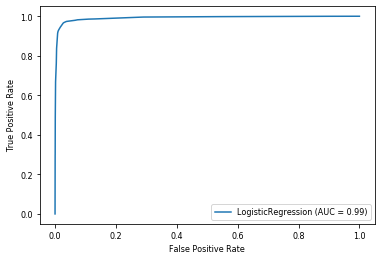

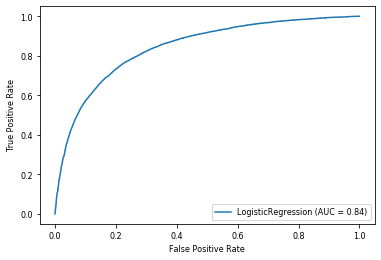

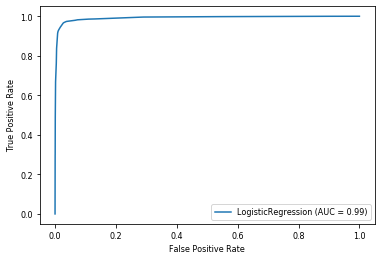

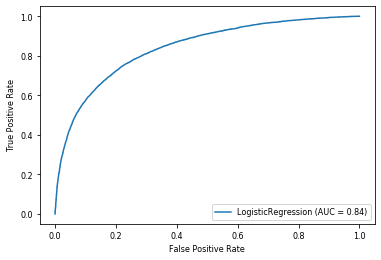

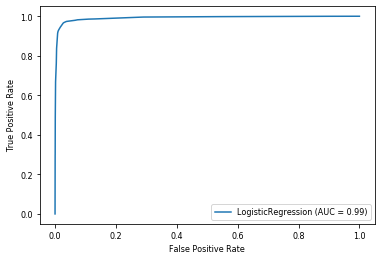

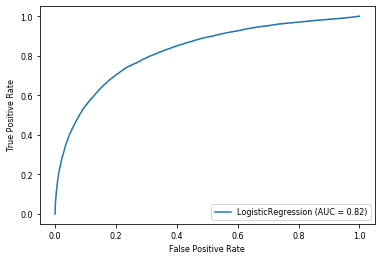

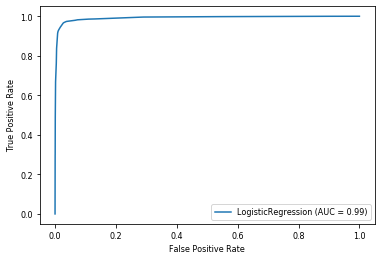

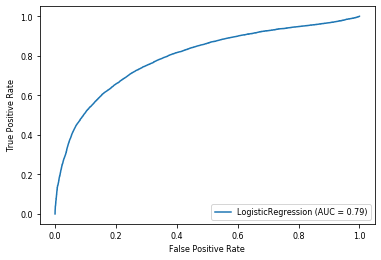

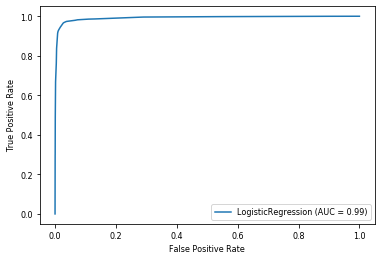

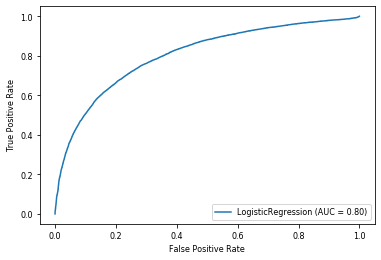

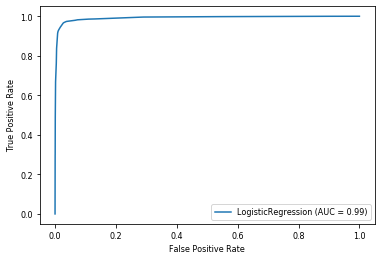

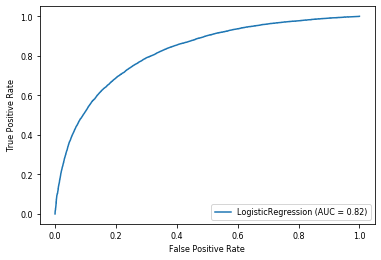

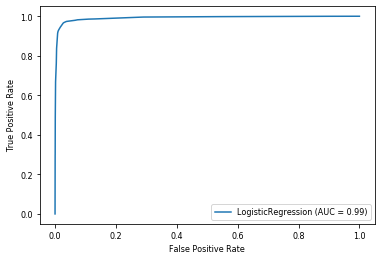

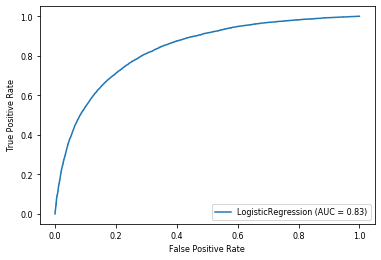

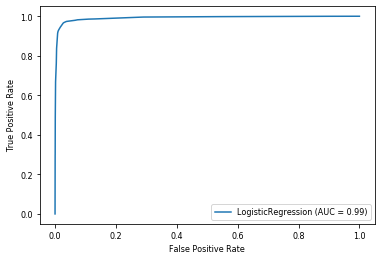

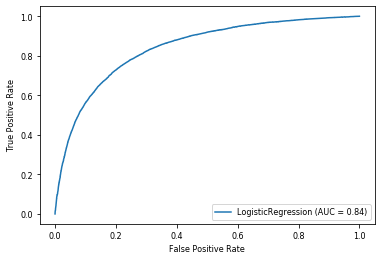

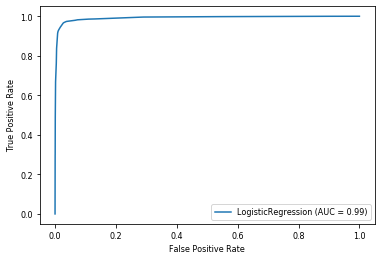

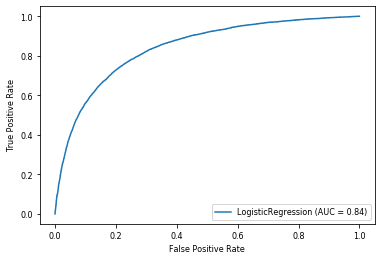

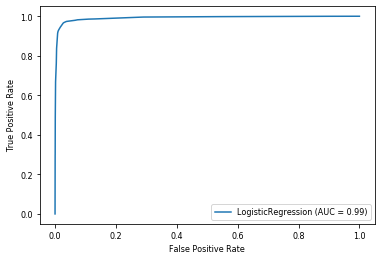

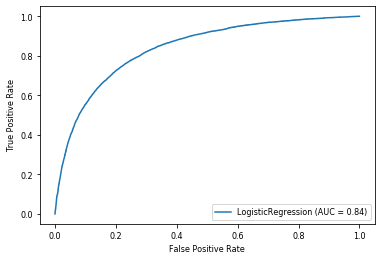

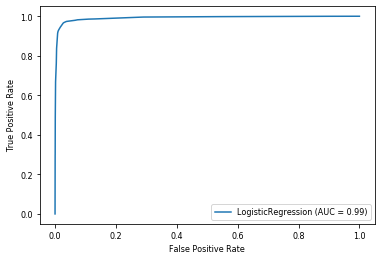

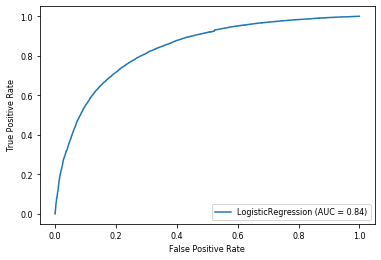

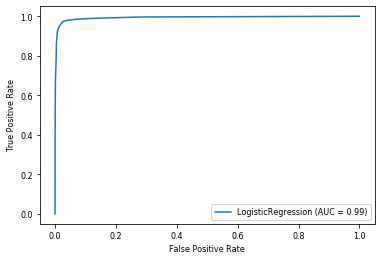

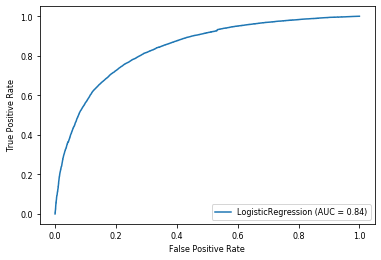

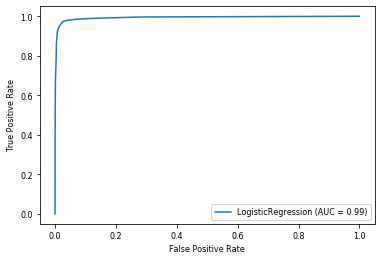

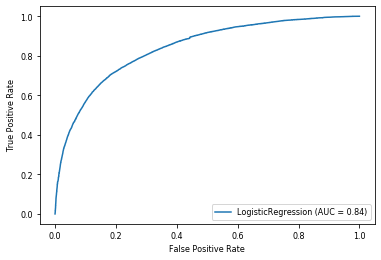

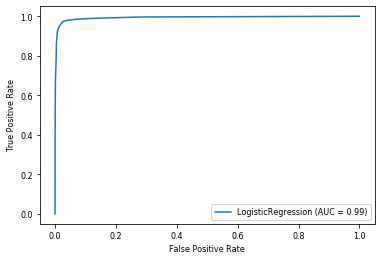

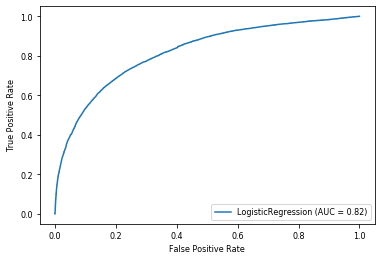

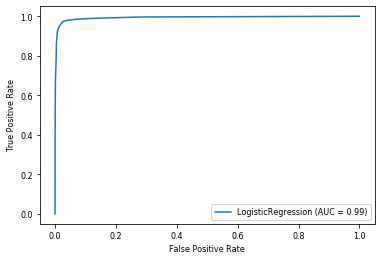

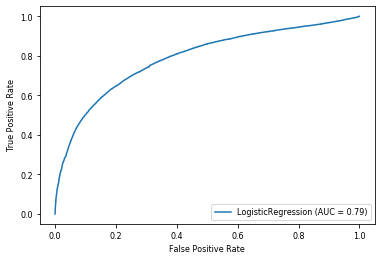

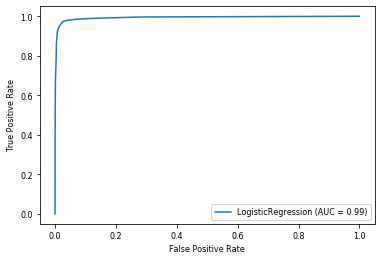

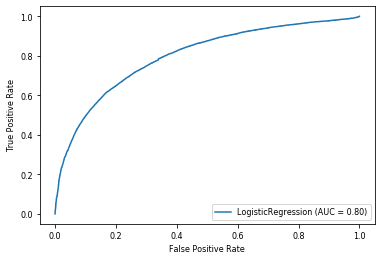

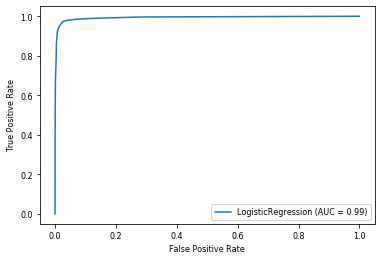

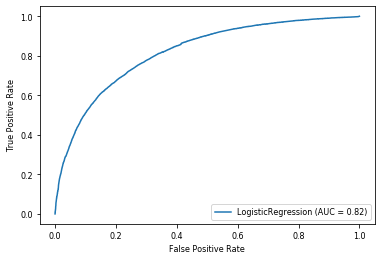

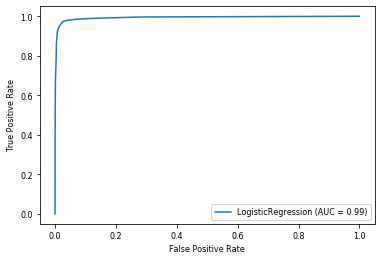

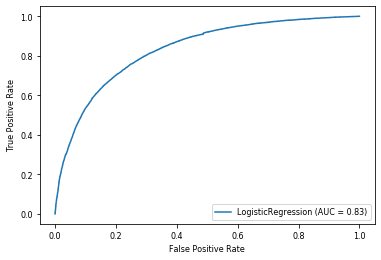

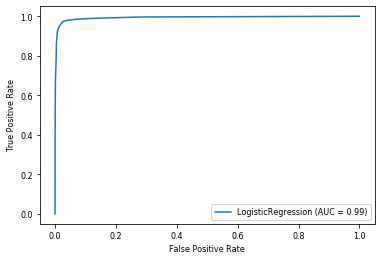

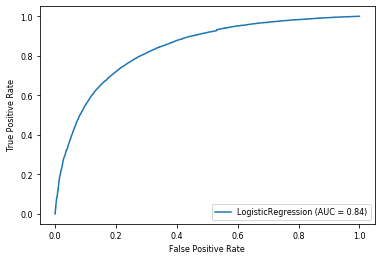

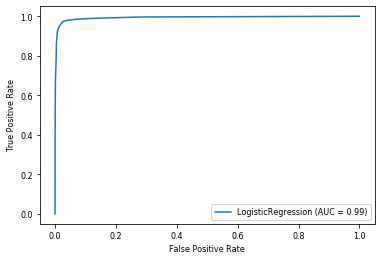

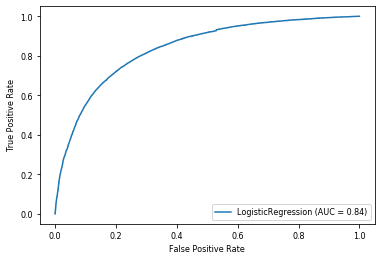

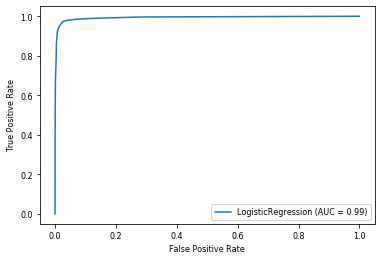

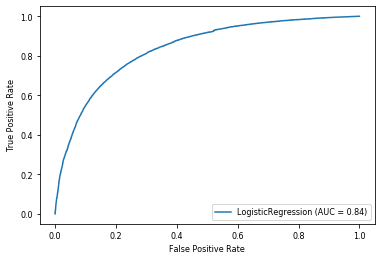

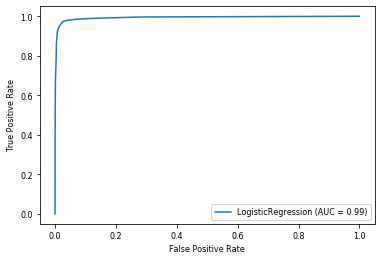

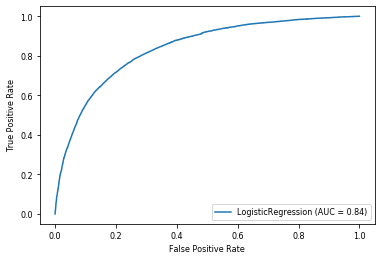

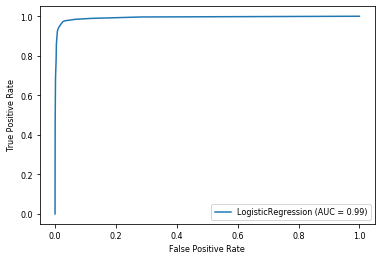

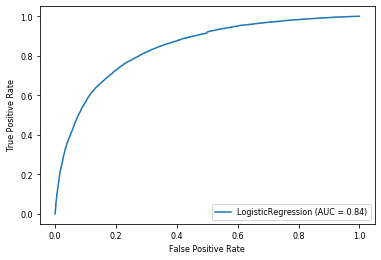

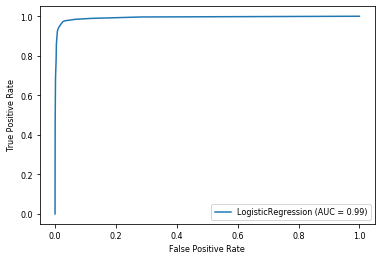

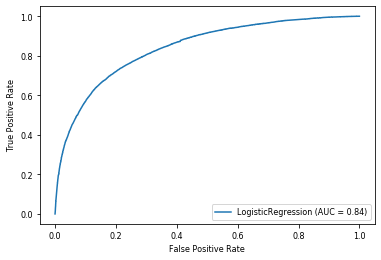

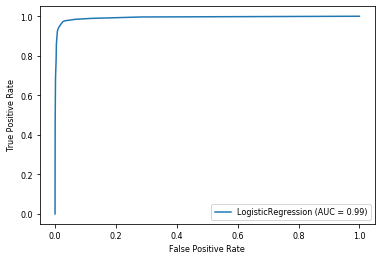

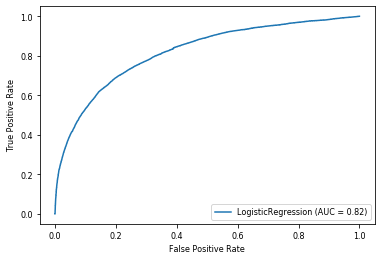

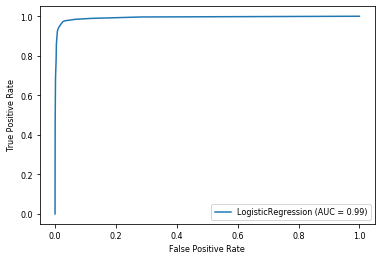

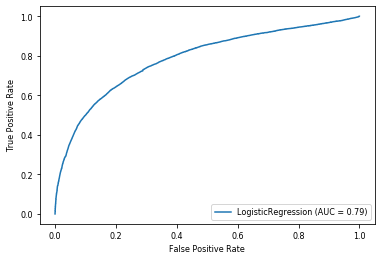

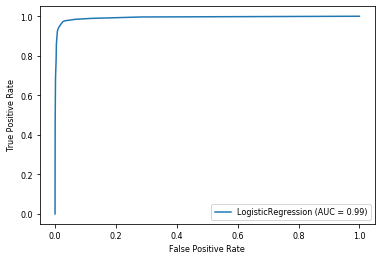

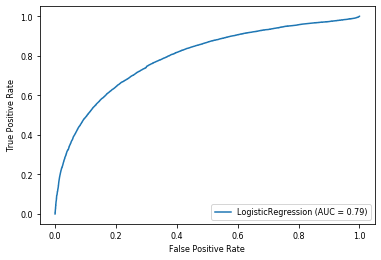

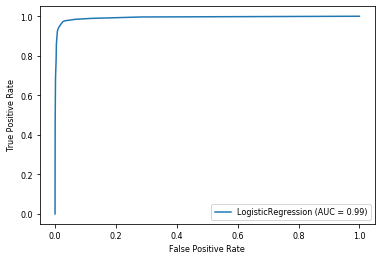

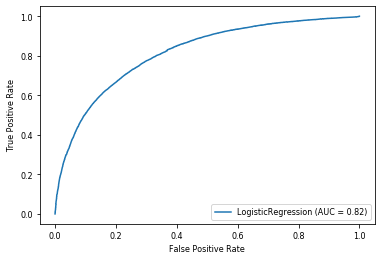

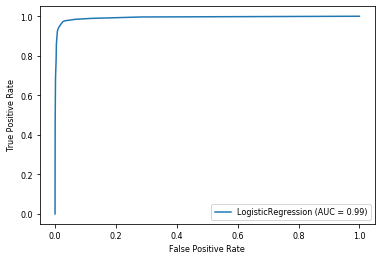

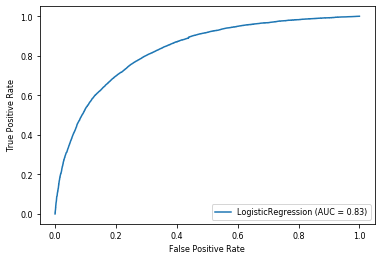

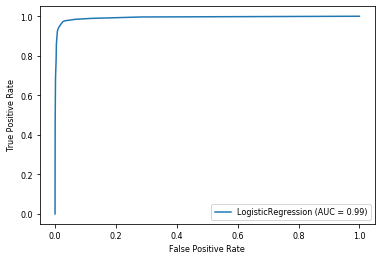

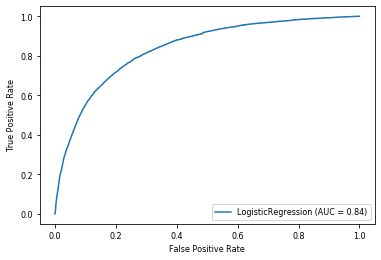

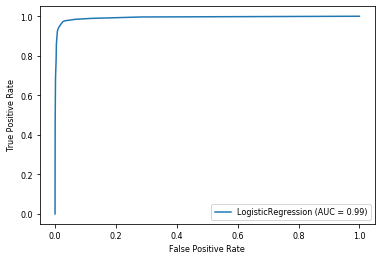

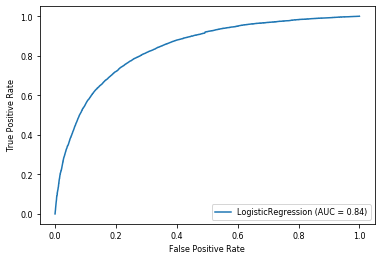

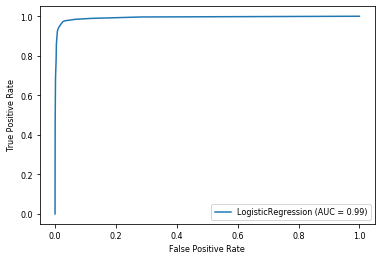

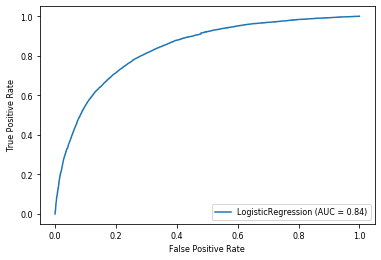

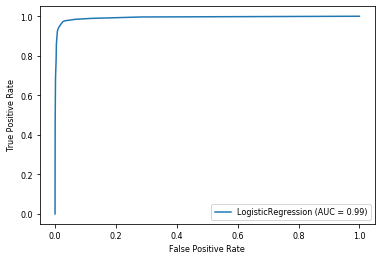

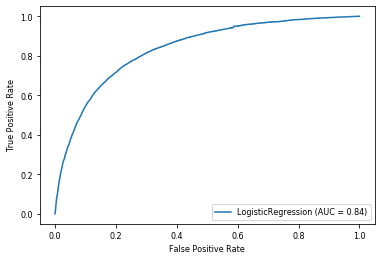

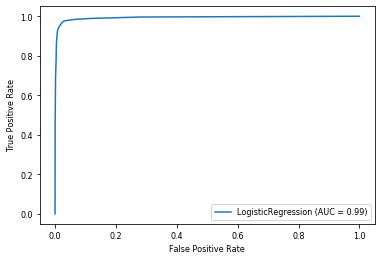

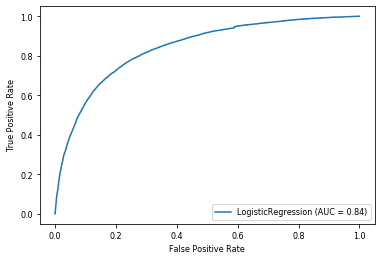

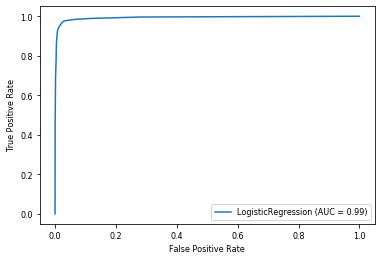

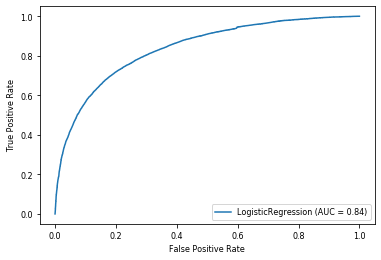

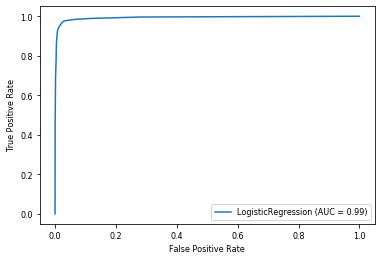

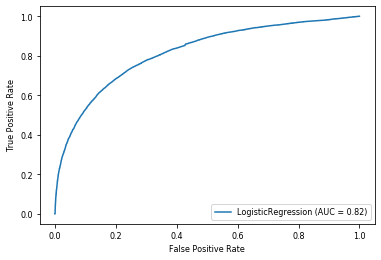

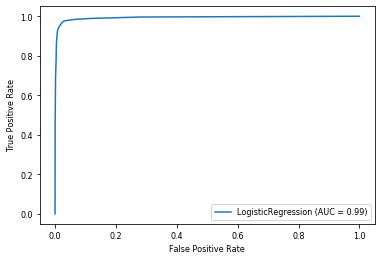

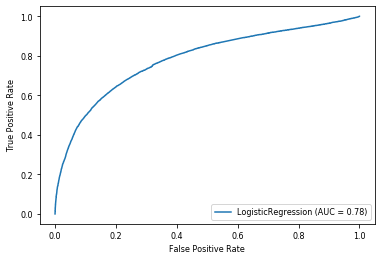

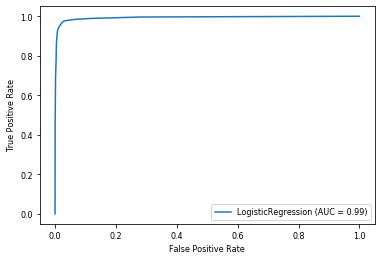

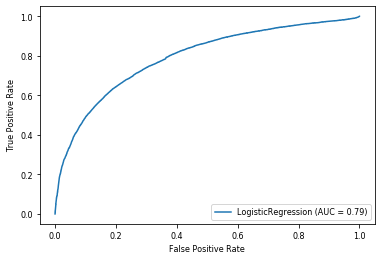

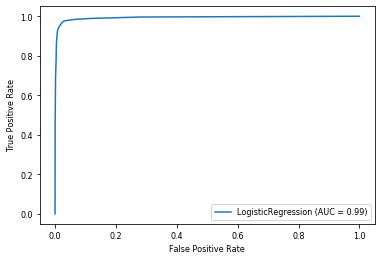

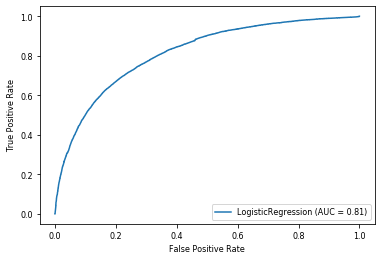

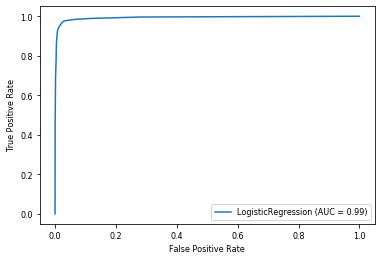

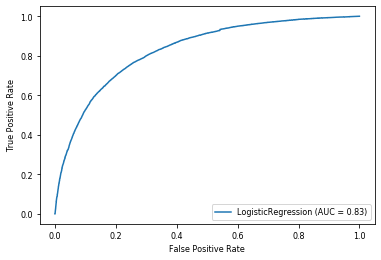

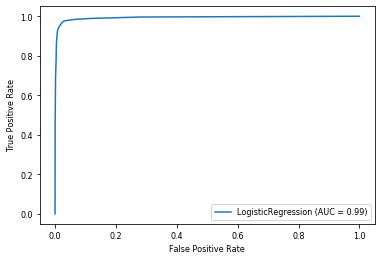

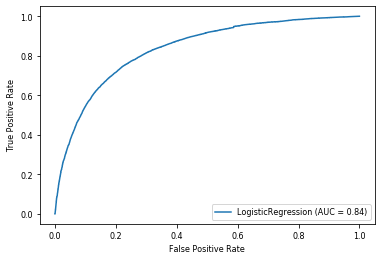

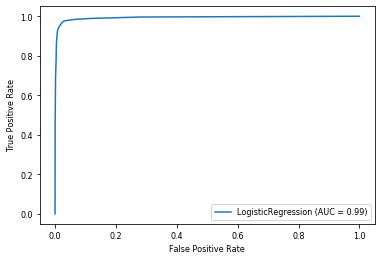

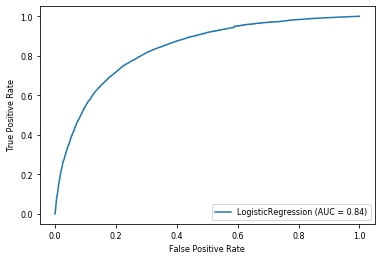

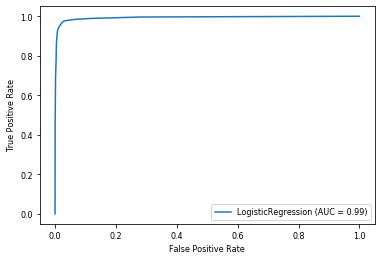

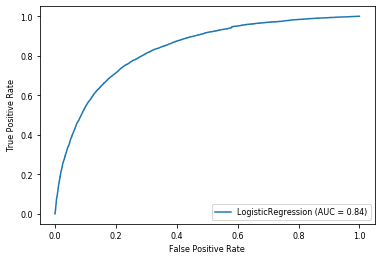

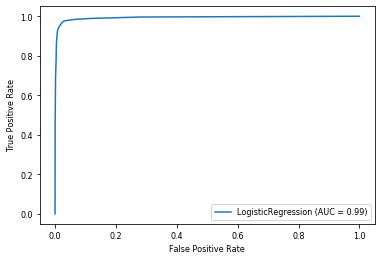

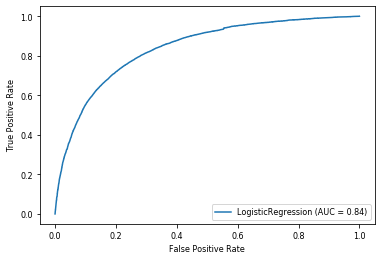

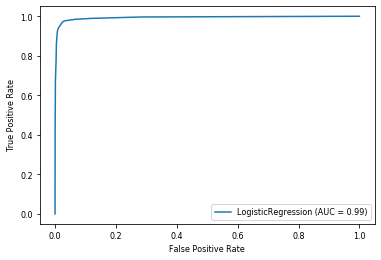

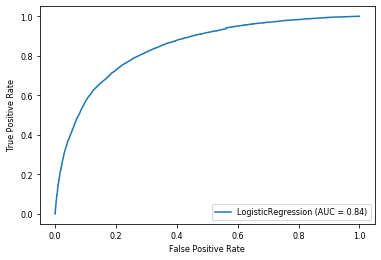

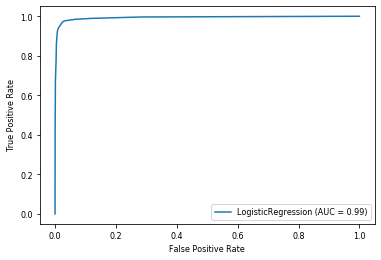

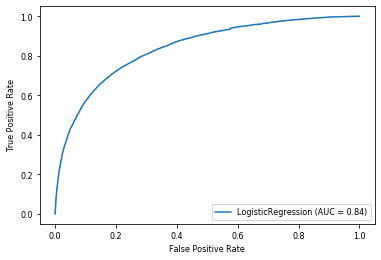

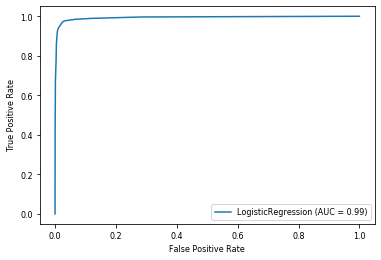

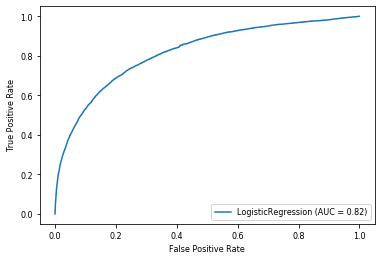

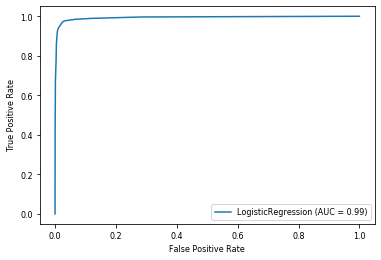

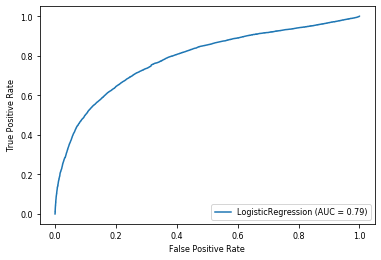

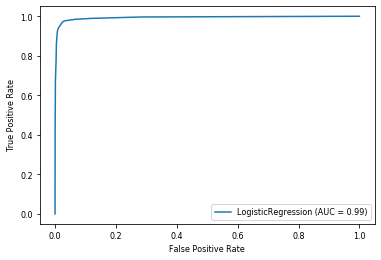

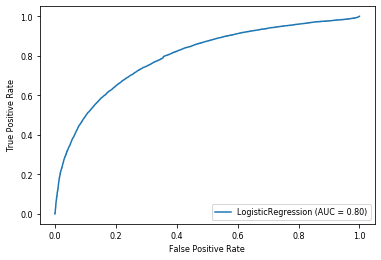

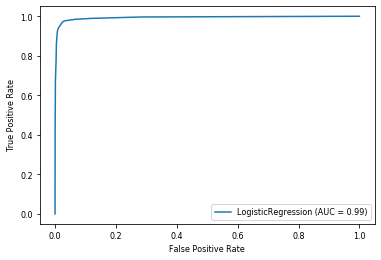

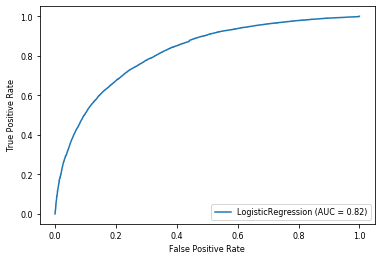

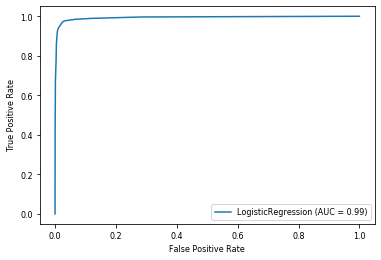

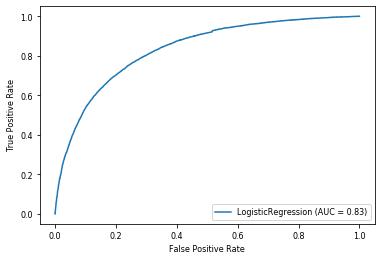

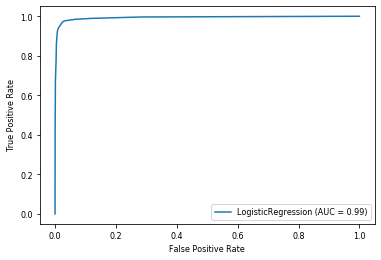

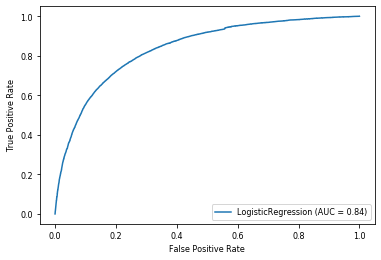

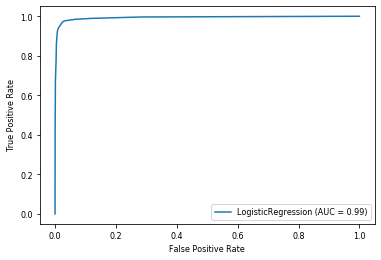

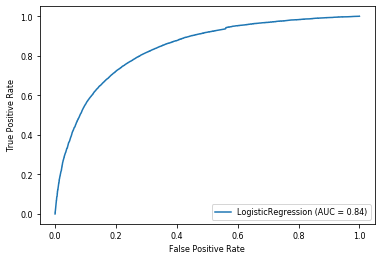

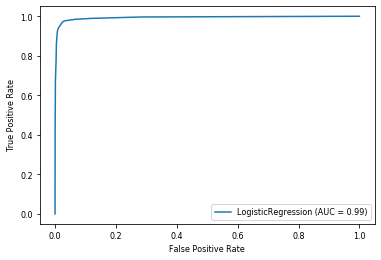

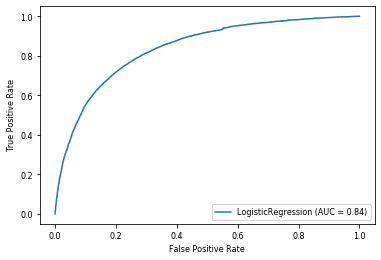

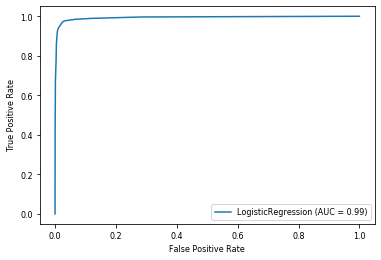

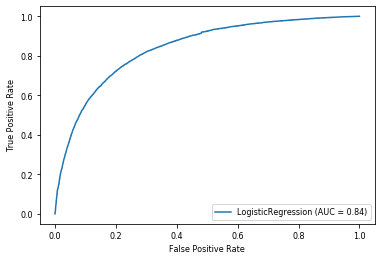

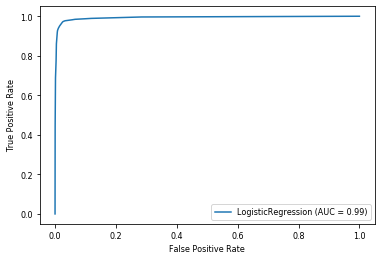

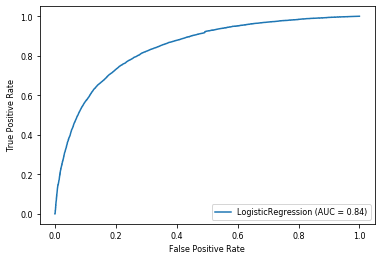

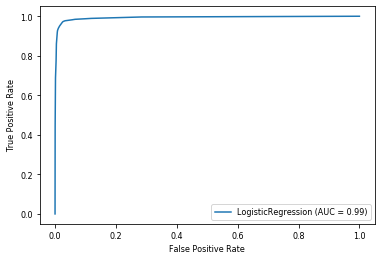

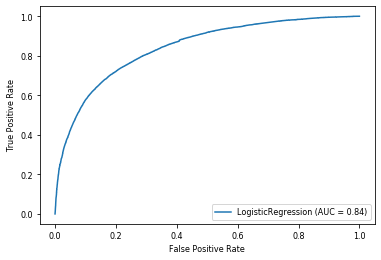

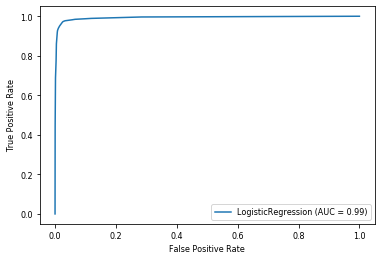

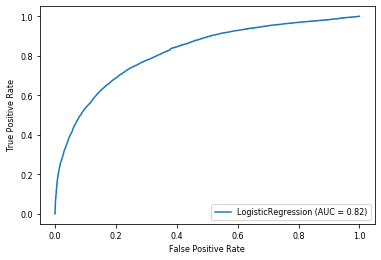

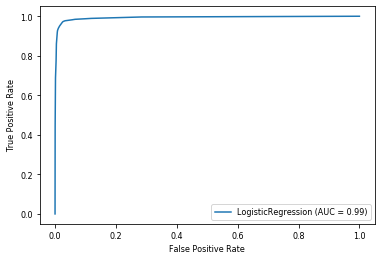

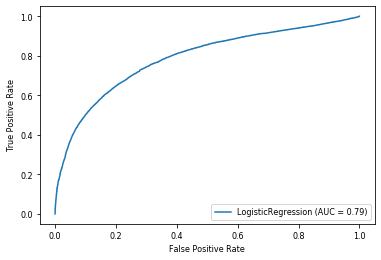

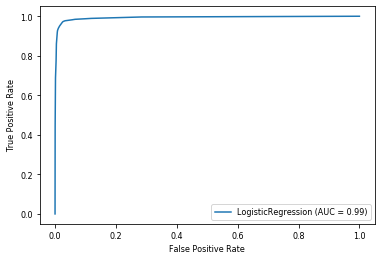

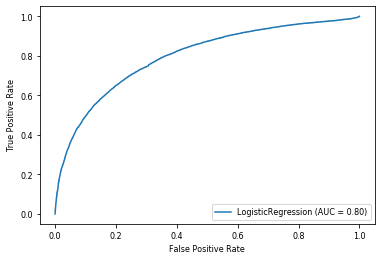

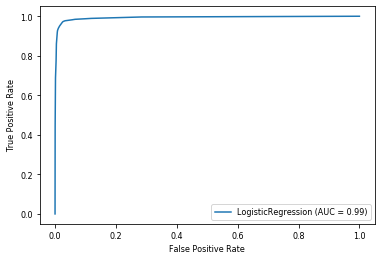

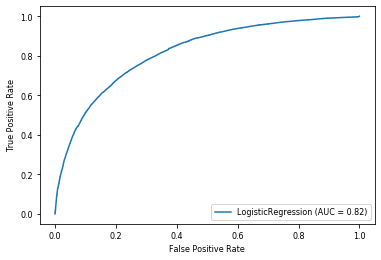

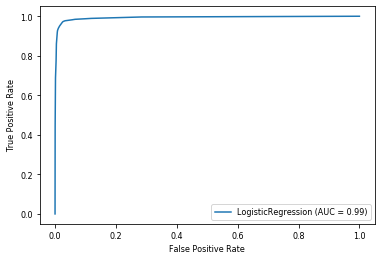

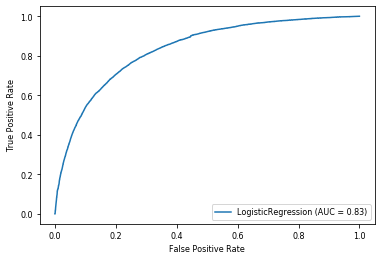

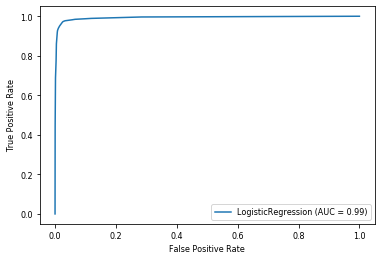

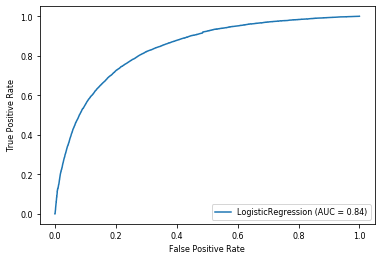

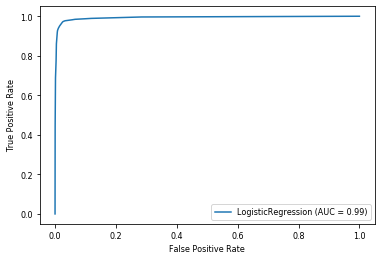

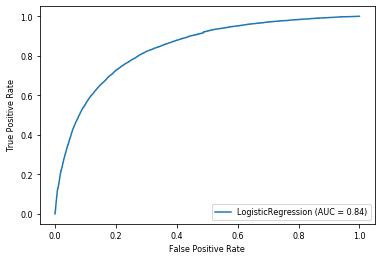

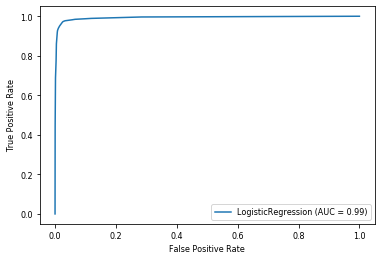

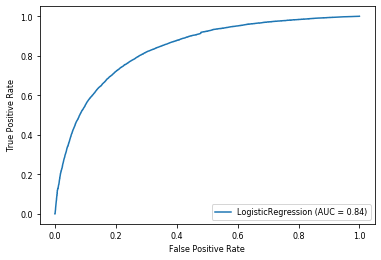

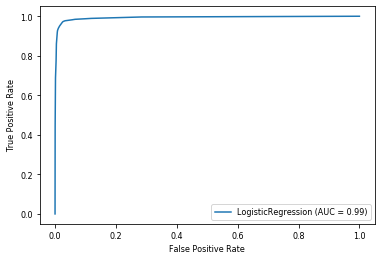

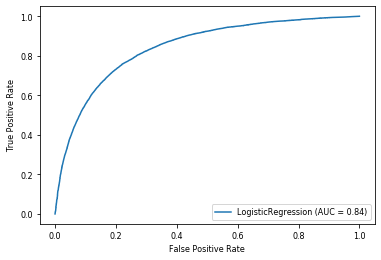

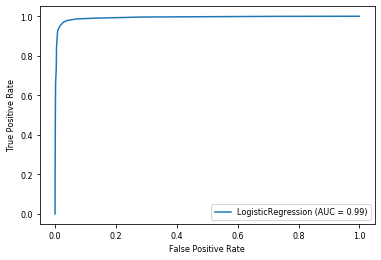

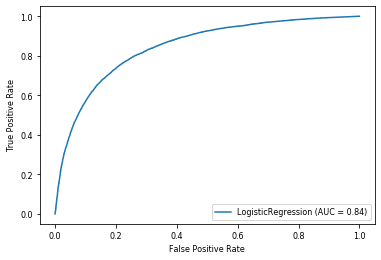

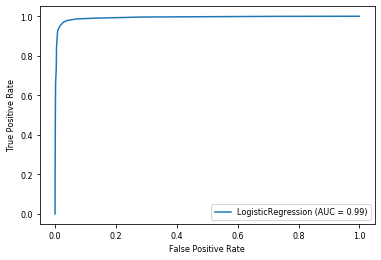

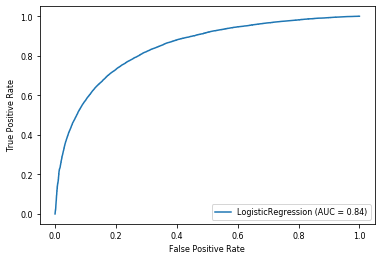

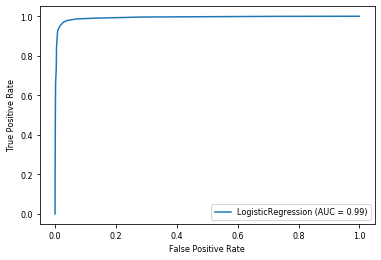

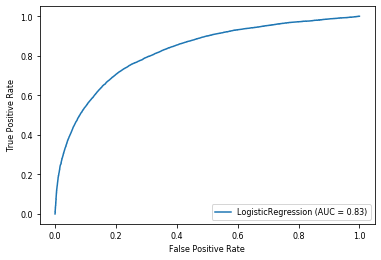

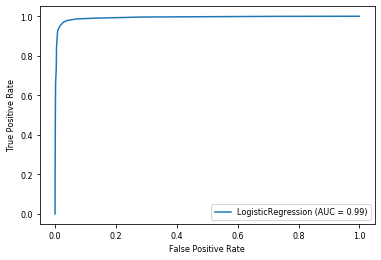

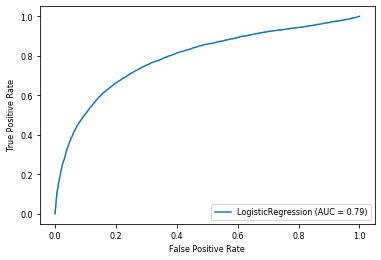

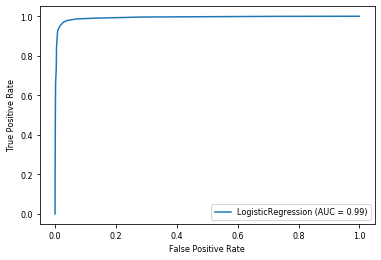

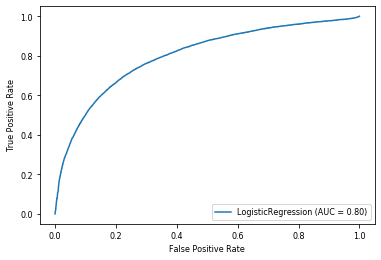

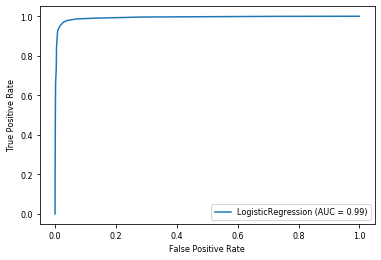

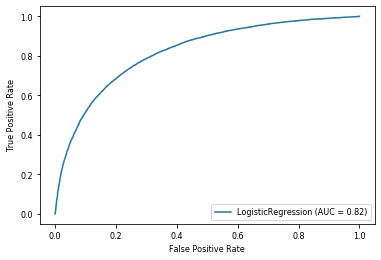

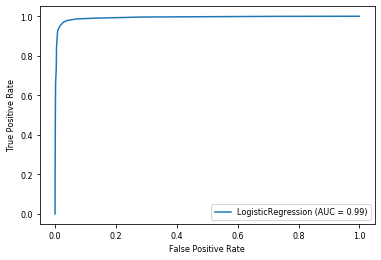

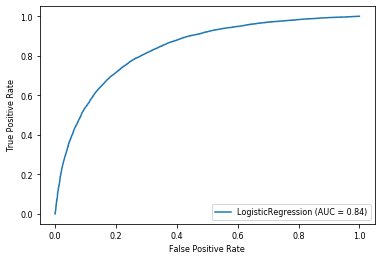

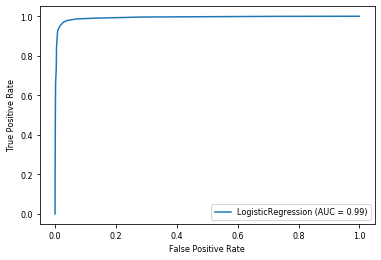

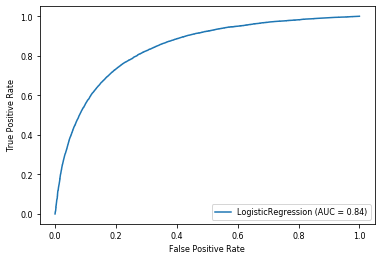

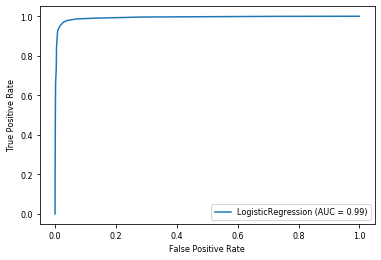

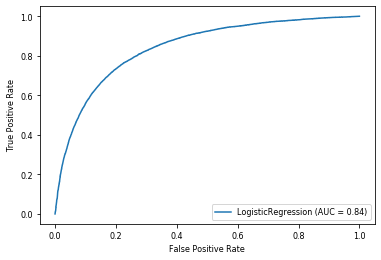

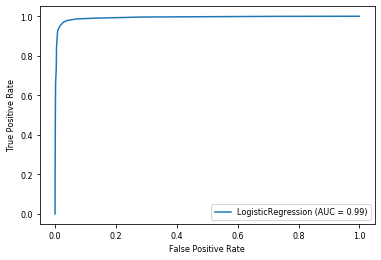

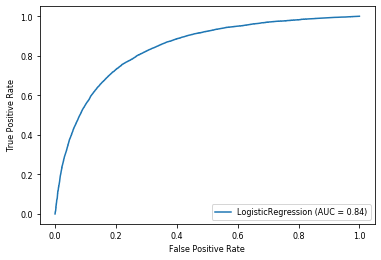

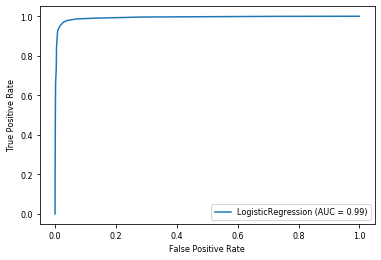

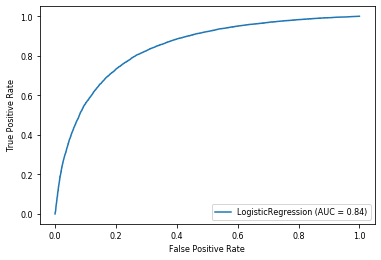

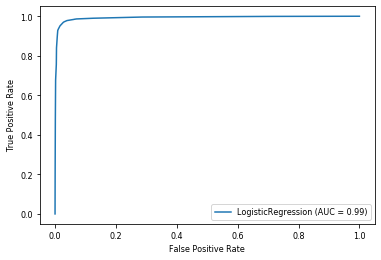

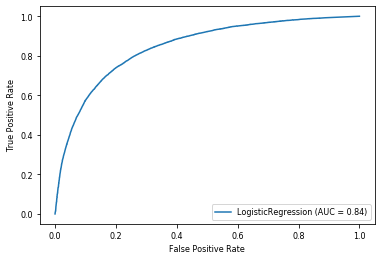

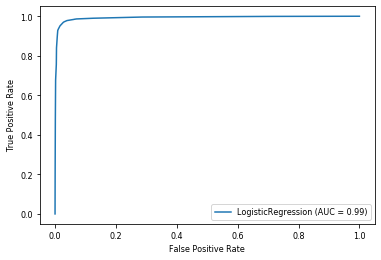

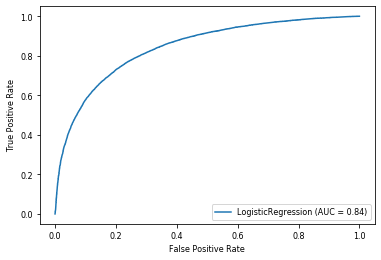

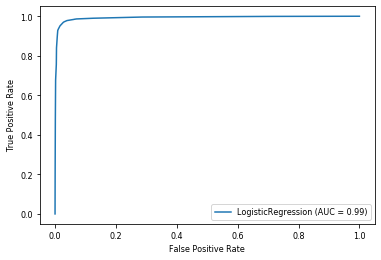

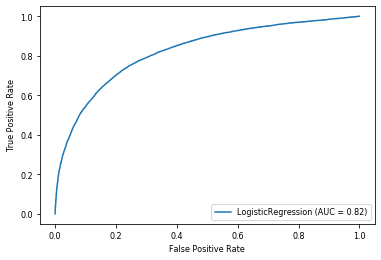

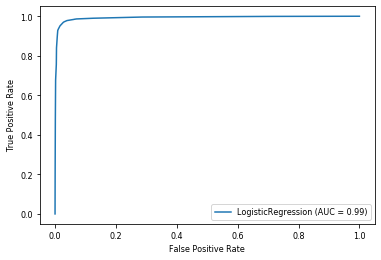

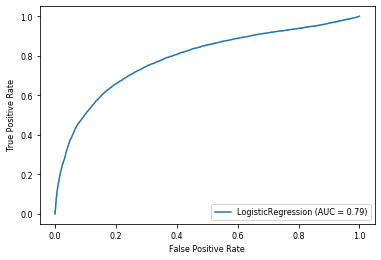

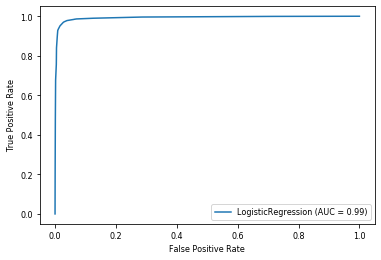

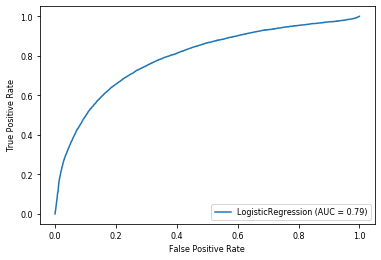

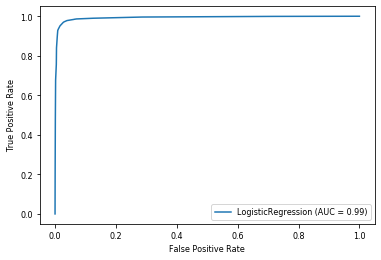

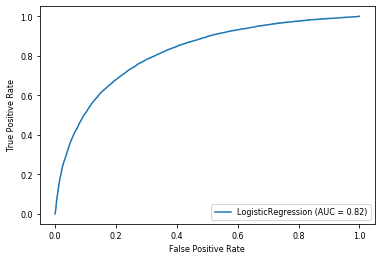

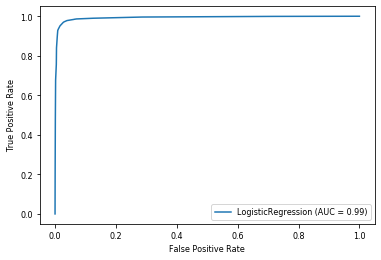

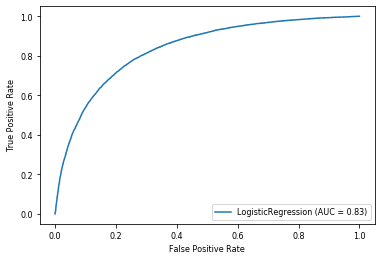

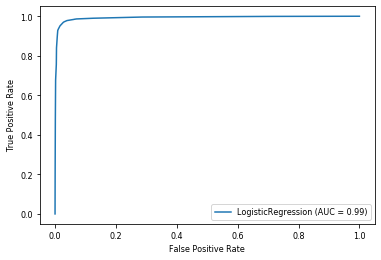

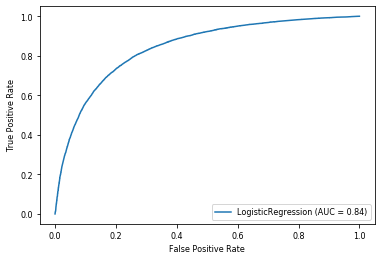

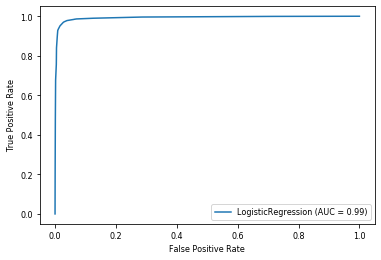

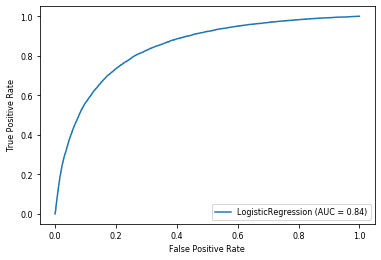

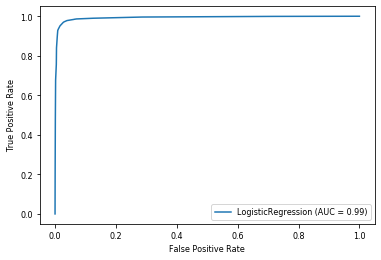

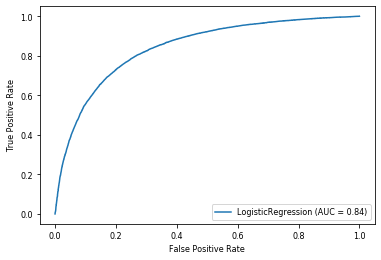

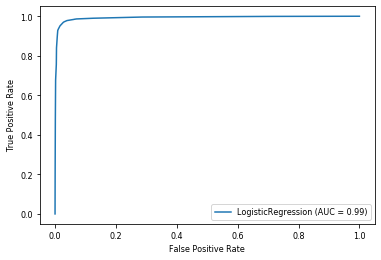

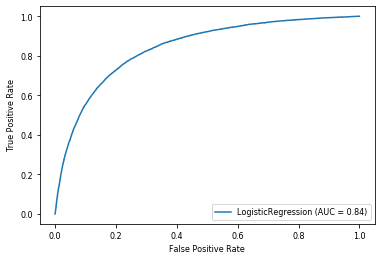

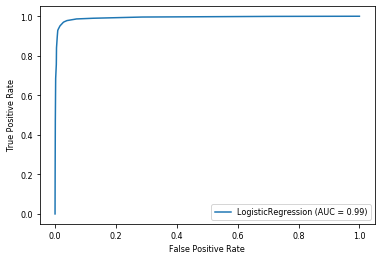

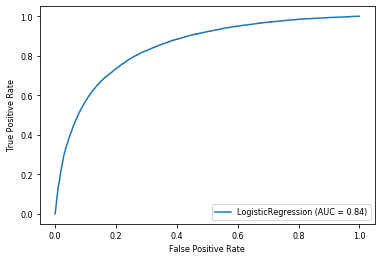

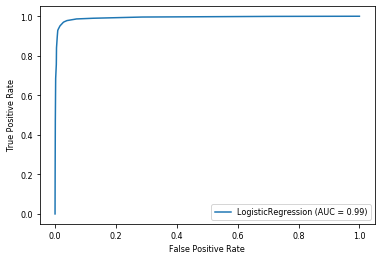

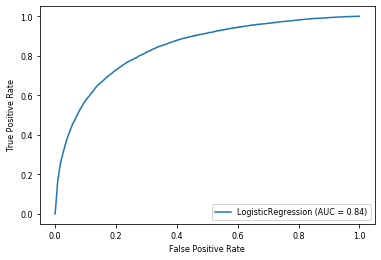

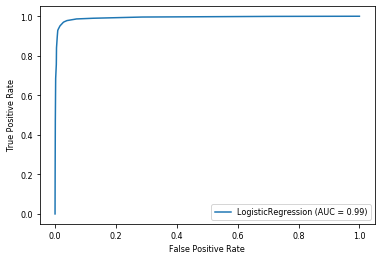

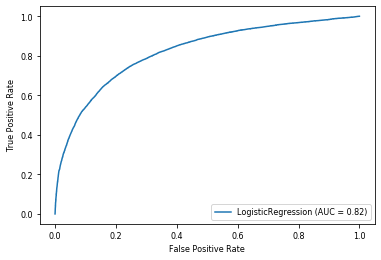

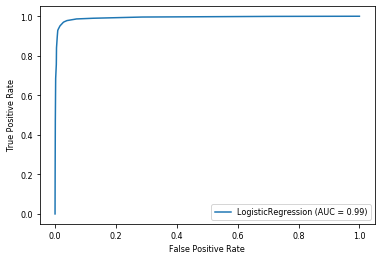

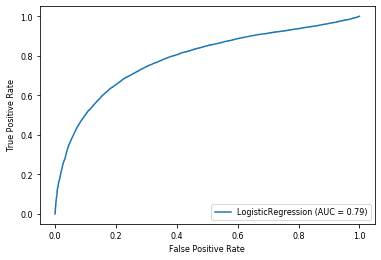

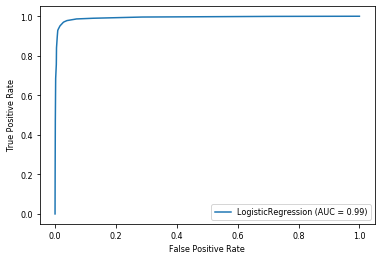

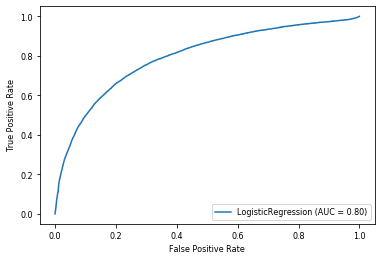

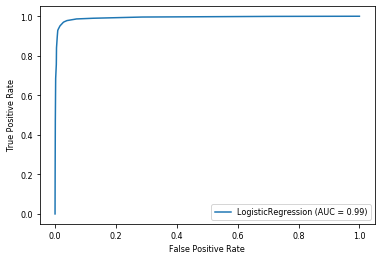

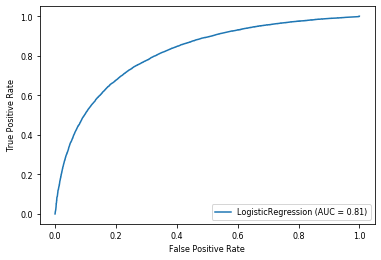

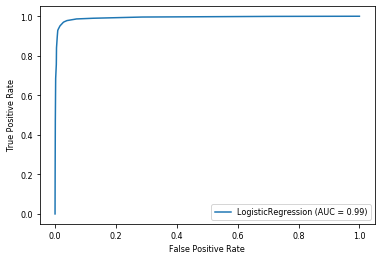

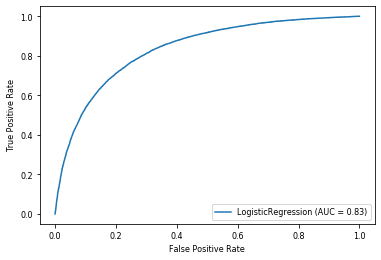

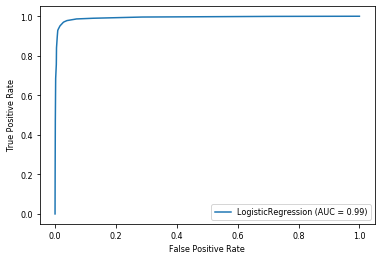

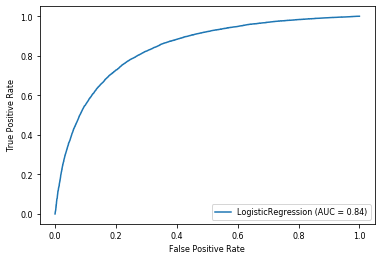

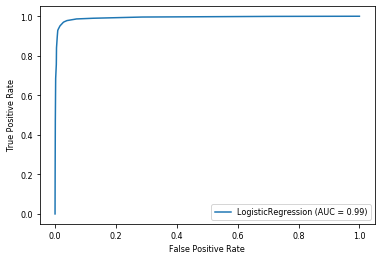

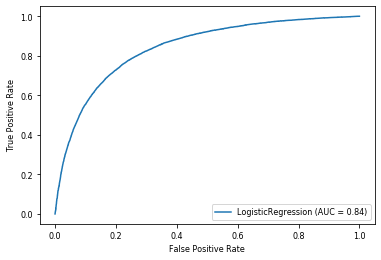

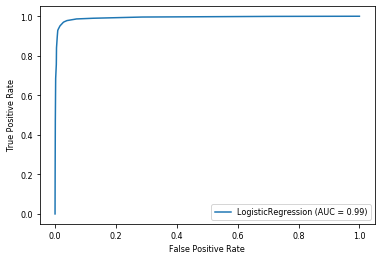

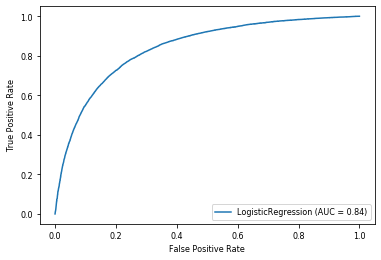

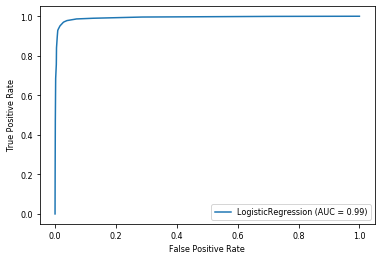

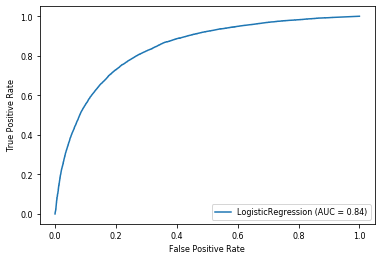

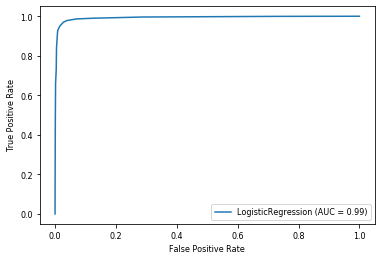

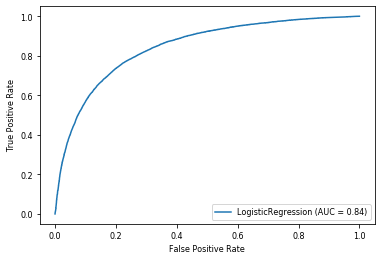

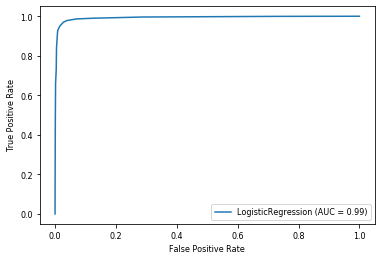

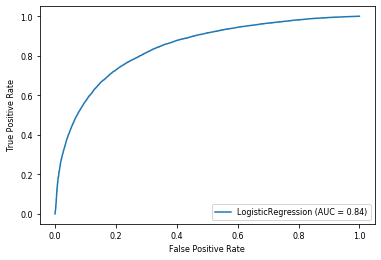

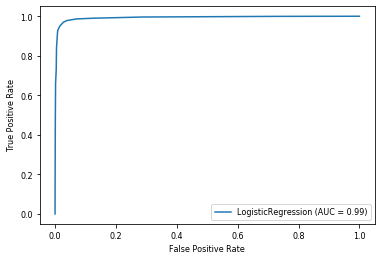

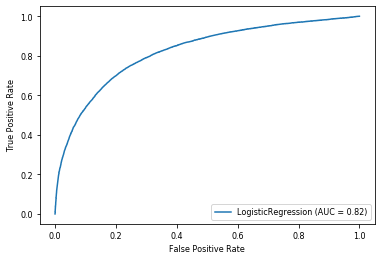

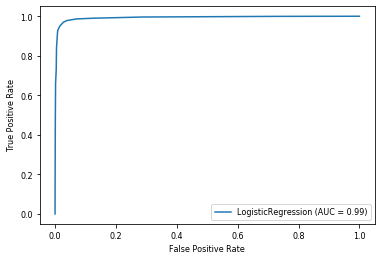

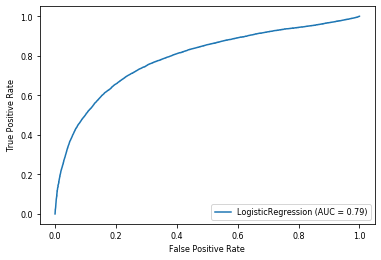

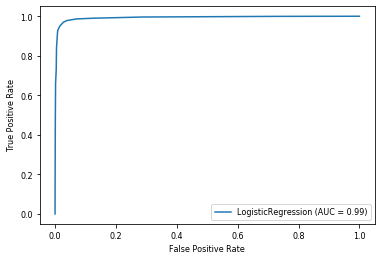

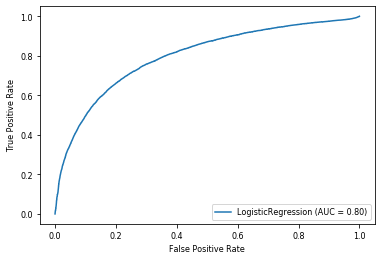

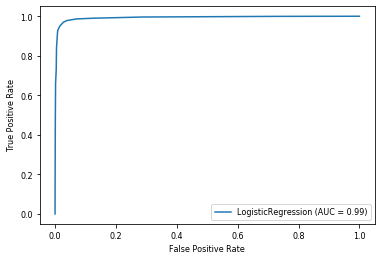

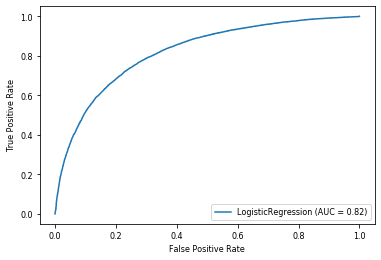

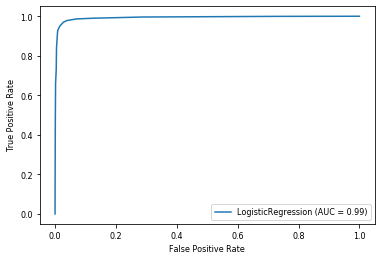

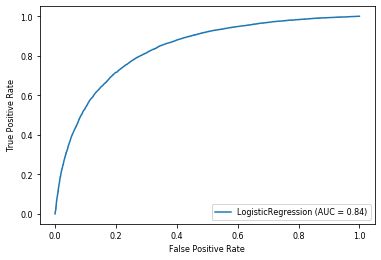

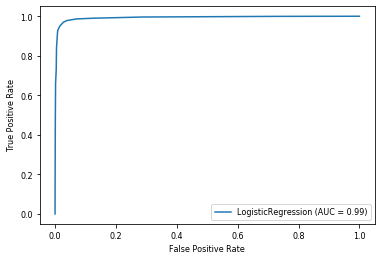

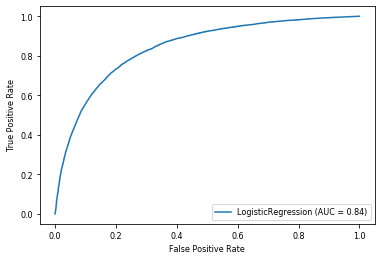

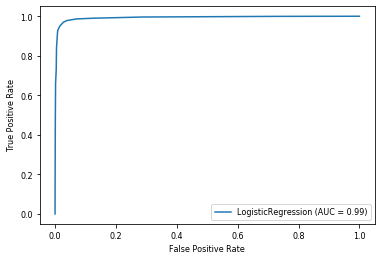

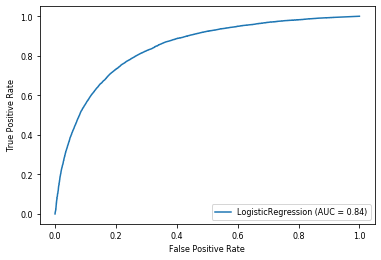

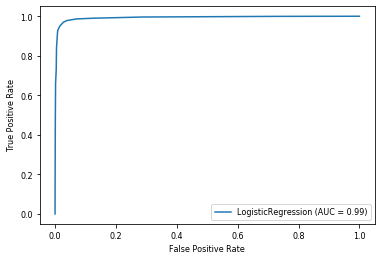

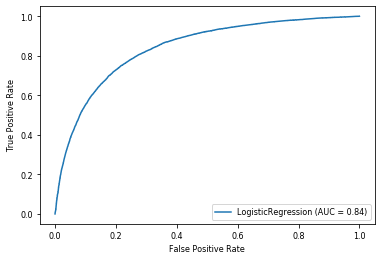

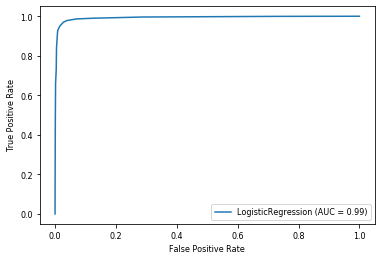

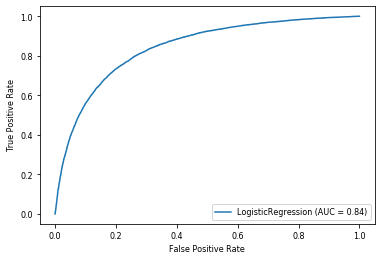

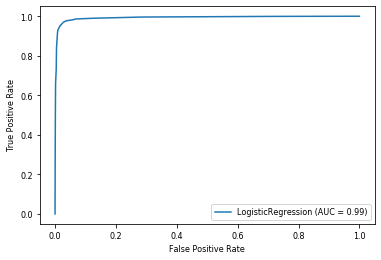

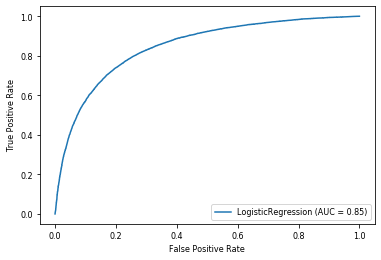

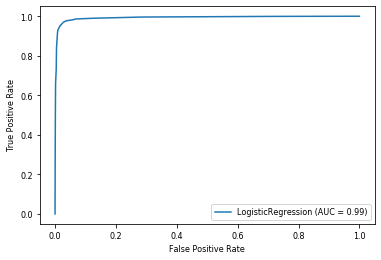

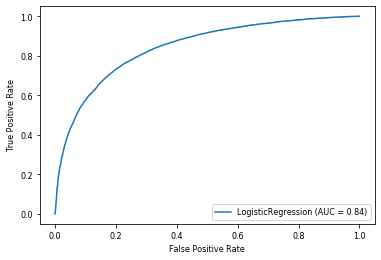

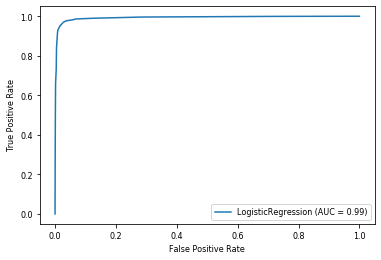

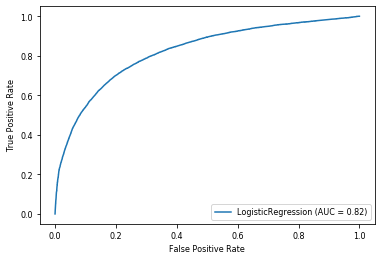

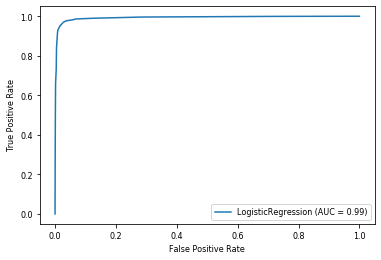

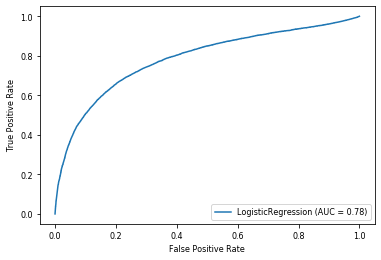

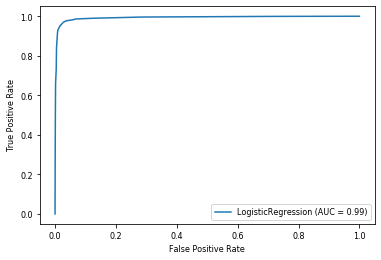

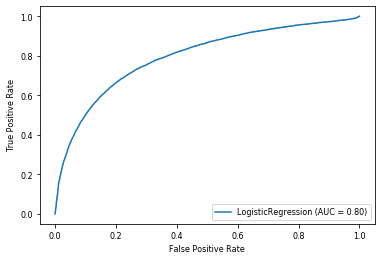

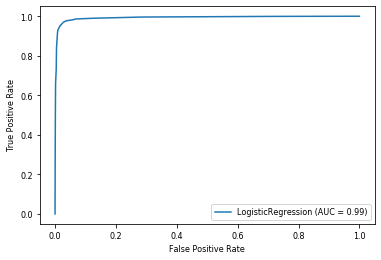

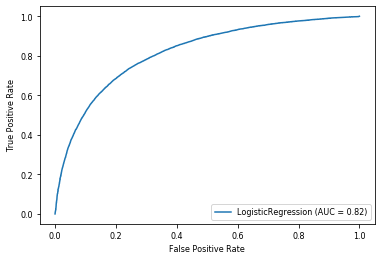

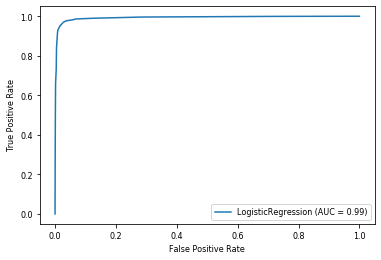

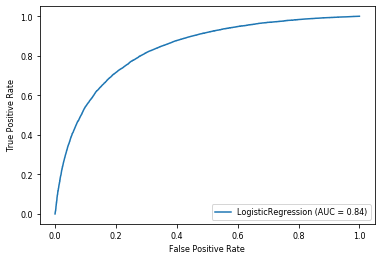

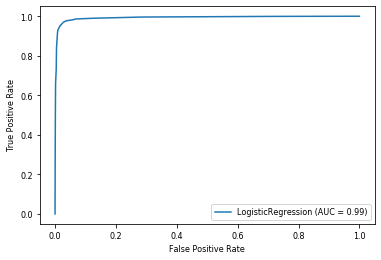

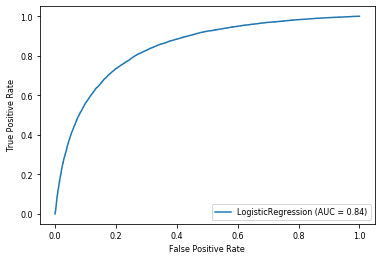

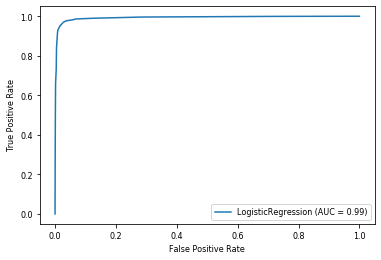

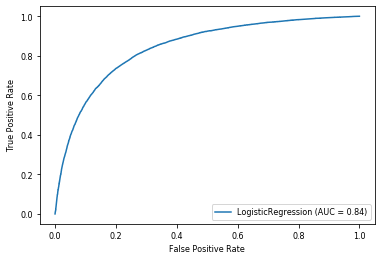

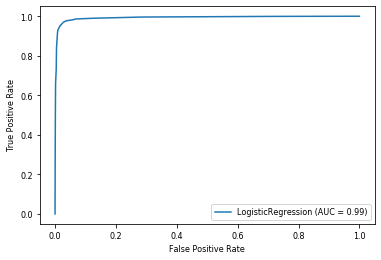

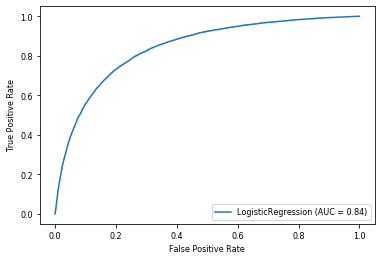

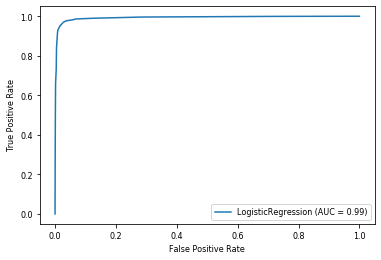

In [54]:
list_all_threshold = []

fold = 0
roc_json = {}
roc_json_ob = {}
num_iter = 0
mean_fpr = np.linspace(0, 1, 100)

kf = KFold(n_splits=5)
for train, test in nb.tqdm(kf.split(df_outcome_n)):
    fold +=1
    train_rating = df_outcome_n.iloc[train]
    test_outcome = df_outcome_n.iloc[test]
    test_outcome2=pd.merge(test_outcome,df_vote_rate2, on = 'discussion_id', how = 'inner')
    
    kf2 = KFold(n_splits=5)
    for train2, test2 in nb.tqdm(kf2.split(train_rating)):
        train_rating_dis = train_rating.iloc[train2]
        test_rating_dis = train_rating.iloc[test2]
#         print(train_rating3)
        train_rating3=pd.merge(train_rating_dis,df_vote_rate2, on = 'discussion_id', how = 'inner')
        test_rating=pd.merge(test_rating_dis,df_vote_rate2, on = 'discussion_id', how = 'inner')
        
        reader = Reader(rating_scale=(-1,1)) 

        data = Dataset.load_from_df(train_rating3[['user_id_y','discussion_id','raw_ratings']],reader)

        trainset = data.build_full_trainset()
        
        SVD_model = SVD(n_factors=500)
        f=SVD_model.fit(trainset)


        pred = [f.predict(uid , iid , r_ui) for uid,iid,r_ui in zip(test_rating['user_id_y']
                                                                                  ,test_rating['discussion_id']
                                                                                  ,test_rating['raw_ratings']) ]
        
        
        pred2 = [f.predict(uid , iid , r_ui) for uid,iid,r_ui in zip(test_outcome2['user_id_y']
                                                                                  ,test_outcome2['discussion_id']
                                                                                  ,test_outcome2['raw_ratings']) ]
        
        
        pred_tr = [f.predict(uid , iid , r_ui) for uid,iid,r_ui in zip(train_rating3['user_id_y']
                                                                                  ,train_rating3['discussion_id']
                                                                                  ,train_rating3['raw_ratings']) ]
        
        acc=[]
        pre=[]
        rec=[]
        f1=[]
        roc=[]
        
        acc2=[]
        pre2=[]
        rec2=[]
        f12=[]
        roc2=[]


        
        for threshold in nb.tqdm(np.arange(-1,1.2,.2)):


            print(threshold)
#             print(-2.220446049250313e-16)
            estimate= [1 if p.est >= threshold else -1 for p in pred]
            estimate2=[p.est for p in pred]
            rui_list= [p.r_ui for p in pred]

    #         print("Accuracy: ", np.sum(np.array(rui_list) == np.array(estimate))/len(pred))
            print("Classification report for Rating: \n", classification_report(rui_list,estimate,target_names=['-1','1']))

            report = classification_report(rui_list,estimate,target_names=['-1','1'], output_dict=True)


            
# Train Outcome           
            estimate_tr= [1 if p.est >= threshold else -1 for p in pred_tr]
            estimate2_tr=[p.est for p in pred_tr]
#             rui_list_tr= [p.r_ui for p in pred_tr]
            
            ss= train_rating3.copy()
            ss['estimate2']=estimate_tr
            ss['estimate']=estimate2_tr
            n_k_d = []

            n_k_d_ob = []


            tr_outcome = []
            for name,g in nb.tqdm(ss.groupby('discussion_id')):
            #     print(list(g['estimates'].value_counts().reindex([1,-1], fill_value=0)))
                k_d=list(g['estimate2'].value_counts().reindex([1,-1], fill_value=0))
                k_d.append(g['estimate'].mean())
                var = g['estimate'].var()
                if np.isnan(var):
                    var=0
                k_d.append(var)
                n_k_d.append(k_d)

                k_d_ob=list(g['raw_ratings'].value_counts().reindex([1,-1], fill_value=0))
                k_d_ob.append(g['raw_ratings'].mean())
                var_ob = g['raw_ratings'].var()
                if np.isnan(var_ob):
                    var_ob=0
                k_d_ob.append(var_ob)
                n_k_d_ob.append(k_d_ob)

                tr_outcome.append(g['outcome'].mean())
                
            
            
                
            estimate_ts= [1 if p.est >= threshold else -1 for p in pred2]
            estimate2_ts=[p.est for p in pred2]
            
#             rui_list_2= [p.r_ui for p in pred2]
            
#  Test Outcome   
            ss2= test_outcome2.copy()
            ss2['estimate2']=estimate_ts
            ss2['estimate']=estimate2_ts
            n_k_d_ts = []

            n_k_d_ob_ts = []


            ts_outcome = []
            for name,g in nb.tqdm(ss2.groupby('discussion_id')):
            #     print(list(g['estimates'].value_counts().reindex([1,-1], fill_value=0)))
                k_d=list(g['estimate2'].value_counts().reindex([1,-1], fill_value=0))
                k_d.append(g['estimate'].mean())
                var = g['estimate'].var()
                if np.isnan(var):
                    var=0
                k_d.append(var)
                n_k_d_ts.append(k_d)

                k_d_ob=list(g['raw_ratings'].value_counts().reindex([1,-1], fill_value=0))
                k_d_ob.append(g['raw_ratings'].mean())
                var_ob = g['raw_ratings'].var()
                if np.isnan(var_ob):
                    var_ob=0
                k_d_ob.append(var_ob)
                n_k_d_ob_ts.append(k_d_ob)

                ts_outcome.append(g['outcome'].mean())
                
            clf = LogisticRegression(random_state=0, solver='liblinear').fit(n_k_d,tr_outcome )
            
            viz = plot_roc_curve(clf, n_k_d_ts, ts_outcome,)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs_est=roc_json.get(str(threshold),[])
            tprs_est.append(interp_tpr)
            roc_json[str(threshold)]=tprs_est
            with open('Data_Wiki_Workshop/ROC_Est.pickle', 'wb') as handle:
                 pickle.dump(roc_json, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
            aucs_est=viz.roc_auc

            predicted_outcome= clf.predict(n_k_d_ts)

            print("Logistic Regression Classification report of OUTCOME, with est rating: \n", 
                  classification_report(ts_outcome,predicted_outcome,target_names=['-1','1']))
#             print("ROC AUC: ", roc_auc_score(ts_outcome, predicted_outcome))
            
            report2 = classification_report(ts_outcome, predicted_outcome,target_names=['-1','1'], output_dict=True)
        
        
        
            clf2 = LogisticRegression(random_state=0, solver='liblinear').fit(n_k_d_ob,tr_outcome )
            
            viz = plot_roc_curve(clf2, n_k_d_ob_ts, ts_outcome,)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            
            tprs_est=roc_json_ob.get(str(threshold),[])
            tprs_est.append(interp_tpr)
            roc_json_ob[str(threshold)]=tprs_est
            
            with open('Data_Wiki_Workshop/ROC_Ob.pickle', 'wb') as handle:
                 pickle.dump(roc_json_ob, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
            aucs_ob=viz.roc_auc

            predicted_outcome= clf2.predict(n_k_d_ob_ts)

            print("Logistic Regression Classification report of OUTCOME, with observed rating: \n", 
                  classification_report(ts_outcome,predicted_outcome,target_names=['-1','1']))
#             print("ROC AUC: ", roc_auc_score(ts_outcome, predicted_outcome))
            
            report3 = classification_report(ts_outcome, predicted_outcome,target_names=['-1','1'], output_dict=True)
            
            list_all_threshold.append([fold, threshold,
                                       
                                      report['accuracy'],
                                      report['weighted avg']['precision'],
                                      report['weighted avg']['recall'],
                                      report['weighted avg']['f1-score'],
                                      report2['accuracy'],
                                      report2['weighted avg']['precision'],
                                      report2['weighted avg']['recall'],
                                      report2['weighted avg']['f1-score'],
                                      report3['accuracy'],
                                      report3['weighted avg']['precision'],
                                      report3['weighted avg']['recall'],
                                      report3['weighted avg']['f1-score'],
                                      aucs_est,
                                      aucs_ob
                                       
                                      ])
            all_result=pd.DataFrame(list_all_threshold, columns=['Outer_k_fold','threshold','est_rate_acc','est_rate_w_precision',
                                          'est_rate_w_recall','est_rate_w_f1_score',
                                          'outcome_with_est_rate_acc','outcome_with_est_rate_w_precision',
                                          'outcome_with_est_rate_w_recall','outcome_with_est_rate_w_f1_score',
                                          'outcome_with_observed_rate_acc','outcome_with_observed_rate_w_precision',
                                          'outcome_with_observed_rate_w_recall','outcome_with_observed_rate_w_f1_score',
                                           'auc_est', 'aucs_ob'                      
                                          
                                         ])
            
            all_result.to_csv('Data_Wiki_Workshop/csv_files/Result_kfold.csv', index=False)
            num_iter +=0

                
            

            
        
        
        
        
